# Image + Text only Branches
<style>
h2: color:blue;
</style>

### Here we are only testing the image only, text only 2D, and text only 1D

# Section 0: Import modules, set variables, load functions 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from keras import backend as K
from sklearn.metrics import confusion_matrix    
from sklearn import metrics
from keras.models import Model
from keras.layers import Dense, Reshape, concatenate, Lambda, Average, Maximum, Add, Multiply, Concatenate, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers.embeddings import Embedding
from keras.engine.input_layer import Input
from keras.optimizers import Adam
from utils import *
from keras.activations import relu
from sklearn.model_selection import StratifiedKFold, train_test_split
import random
import dill
import matplotlib.pyplot as plt
from scipy import ndimage
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from PIL import Image
import io
from keras.utils.training_utils import multi_gpu_model
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())
G = len(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1']


In [3]:
SRC = 'indiana'

if SRC=='PMC':
    CLASSES = {0: 'bar', 1: 'gel', 2: 'map', 3: 'network', 4: 'plot',
             5: 'text', 6: 'box', 7: 'heatmap',8: 'medical', 9: 'nxmls', 10: 'screenshot',
             11: 'topology', 12: 'diagram', 13: 'histology', 14: 'microscopy',
             15: 'photo', 16: 'sequence', 17: 'tree', 18: 'fluorescence', 19: 'line',
             20: 'molecular', 21: 'pie', 22: 'table'}
    
    class_names = ['bar', 'gel', 'network', 'plot', 'histology', 'sequence',
                               'line', 'molecular']
elif SRC=='indiana':
    class_names = ['normal', 'abnormal']
else:
    class_names = ['cat','dog']
num_class = len(class_names)
NN_Class_Names = dict(enumerate(class_names))
test_size = 0.2
epochs = 150
bs=150
#Set parameters
create_word_vec = False
w2v_epochs = 20
w2v_window_size=5
w2v_filters=''
seed = 0
max_text_len = 200
vocabulary_size = 10000
csv_fname = 'image_list.csv'
coco_loc = '/home/kevin/Documents/Lab/coco_dataset'
pmc_loc = '/gpfs/ysm/pi/krauthammer/kl533/'
indiana_loc = '/gpfs/ysm/pi/krauthammer/kl533/Indiana_University_Chest_X-ray_Collection'
suffix = '.png'
filters = ''
use_glove = False
LOAD_IMG_MODEL_WEIGHTS = False
LOAD_TXT_MODEL_WEIGHTS = False
CHANNELS = 3#should be either 3 or 1 for the number of channels
shape = (100,100,CHANNELS)#image shape
embedding_output_dim = 100
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None)
nltk.download('punkt')
nltk.download('stopwords')
plt.rcParams["figure.dpi"] = 600
n_splits = 5

[nltk_data] Downloading package punkt to /home/kl533/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kl533/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Section 1: Initalize variables and load data

In [4]:
# Load our data from source

print('Getting Data')
if SRC == 'PMC':
    image_classes = [list(CLASSES.keys())[list(CLASSES.values()).index(x)] for 
                 x in class_names]  
    data = load_PMC(csv_fname, image_classes, uniform=True)
    #dynamically add location of files
    data['location'] = pmc_loc + data['location'].astype(str)
elif SRC=='indiana':
    data = load_indiana_CXR(path=indiana_loc)
else:
    data = load_COCO(coco_loc, class_names=class_names)

Getting Data
missing some free text labels
missing some free text labels
missing some free text labels
missing some free text labels
missing some free text labels
missing some free text labels
loaded CXR481_IM-2105-1001
missing some free text labels
missing some free text labels
missing some free text labels
missing some free text labels
missing some free text labels
missing some free text labels
missing some free text labels
missing some free text labels
missing some free text labels
loaded CXR1637_IM-0416-1001
missing some free text labels
missing some free text labels
missing some free text labels
missing some free text labels
missing some free text labels
missing some free text labels
missing some free text labels
missing some free text labels
missing some free text labels
missing some free text labels
loaded CXR1012_IM-0013-1001
missing some free text labels
missing some free text labels
loaded CXR2535_IM-1048-1002
loaded CXR2496_IM-1022-2001
loaded CXR3019_IM-1393-1001
missing so

In [5]:
if SRC=='indiana':
    #normal
    normal_mask = data.labels.apply(lambda x: 1 if 'normal' in x else 0)
    #abnormal mask
    #abnormal_mask = data.labels.apply(lambda x: 'normal' not in x)

    data['normal'] = normal_mask
    #add correct paths
    data['img_id'] = data['img_id'].apply(lambda x: indiana_loc + '/images/' + x + suffix)

## Optional: Create embeddings

In [6]:
#%%Section 0.5 create embeddings - Optional
if create_word_vec:
    print('Section 0.5: create embeddings')
    from w2v_keras import w2v_keras
    w2v = w2v_keras(vocabulary_size=vocabulary_size, window_size=w2v_window_size, filters=w2v_filters, vector_dim = embedding_output_dim)
    w2v.fit(data['caption'], epochs=w2v_epochs)
    w2v.save_embeddings('w2v_embeddings.json')
else:
    print("Not creating embeddings")

Not creating embeddings


In [7]:
def Generate_Model(model_type = None):
    #set up our text input
    if model_type == "image":#image only
        image_input = Input(shape, name='image_input')
        x = get_img_branch()(image_input)
        x = Dense(1024, activation='relu', name='dense_layer1_image')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)        
        x = Dense(512, activation='relu', name='dense_layer2_image')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        output = Dense(num_class, activation='softmax', name='image_output')(x)
        classificationModel = Model(inputs=[image_input], outputs=[output])
    if model_type == "text_1d":#text_1d only
        input_text = Input(shape=(max_text_len,), name='text_input')
        embedding = Embedding(input_length=max_text_len, input_dim=vocabulary_size, output_dim=embedding_output_dim, 
                               name='embedding_layer', trainable=False, weights=[embedding_weights])
        embedded_text = embedding(input_text)
        x = get_text_branch()(embedded_text)
        x = Dense(1024, activation='relu', name='dense_layer1_text')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)        
        x = Dense(512, activation='relu', name='dense_layer2_text')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        output = Dense(num_class, activation='softmax', name='text_output')(x)
        classificationModel = Model(inputs=[input_text], outputs=[output])
    if model_type == "text_2d":
        input_text = Input(shape=(max_text_len,), name='text_input')
        embedding = Embedding(input_length=max_text_len, input_dim=vocabulary_size, output_dim=embedding_output_dim, 
                               name='embedding_layer', trainable=False, weights=[embedding_weights])
        embedded_text = embedding(input_text)
        #text_embedding = Reshape((max_text_len,shape[0],1))(embedded_text)
        text_embedding = Lambda(embedding_3Ch)(embedded_text)
        x = get_text_branch_2D()(text_embedding)
        x = Dense(1024, activation='relu', name='dense_layer1_text')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)        
        x = Dense(512, activation='relu', name='dense_layer2_text')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        output = Dense(num_class, activation='softmax', name='text_output')(x)
        classificationModel = Model(inputs=[input_text], outputs=[output])
    if G > 1:
        classificationModel = get_multi_gpu_model(classificationModel, G)
    return classificationModel

# Section 2: K-Fold Validation

### Get data into format our model understands

In [9]:
#Get all data to kfoldsplit
X_text, X_image, y, tokenizer = get_model_data(data, seed=seed, test_size = test_size, 
                vocabulary_size = vocabulary_size, filters = filters, 
                max_text_len=max_text_len, shape=shape, split=True, text_col='radiology_report', label_col='normal', loc_col='img_id')
X_text = np.array(X_text)#need to fix this!!!!!!!!!!!!!!!!!!!!!!!!!!!

filtering sentences
filtering sents and removing stopwords
filtering sentences
filtering sents and removing stopwords


/home/kl533/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [10]:
#Lets look at our shapes
print(len(X_image))
print(len(X_text))

7470
7470


### Load our word embeddings

In [11]:
#%% Section 1.5: Load word embeddings
if use_glove:
    embedding_weights = load_glove('/home/kevin/Downloads', 
                        take(vocabulary_size, tokenizer.word_index.items()))
elif create_word_vec:#get weights from w2v model directly if trained.
    embedding_weights = mapTokensToEmbedding(w2v.get_embeddings(), 
                                             tokenizer.word_index, vocabulary_size)
else:
    #load embedding weights from file
    location = 'w2v_embeddings.json'
    import json
    with open(location) as f:
        embs = json.load(f)
        emb = json.loads(embs)
    embedding_weights = mapTokensToEmbedding(emb, tokenizer.word_index, 
                                             vocabulary_size)

## Lets visualize our models:

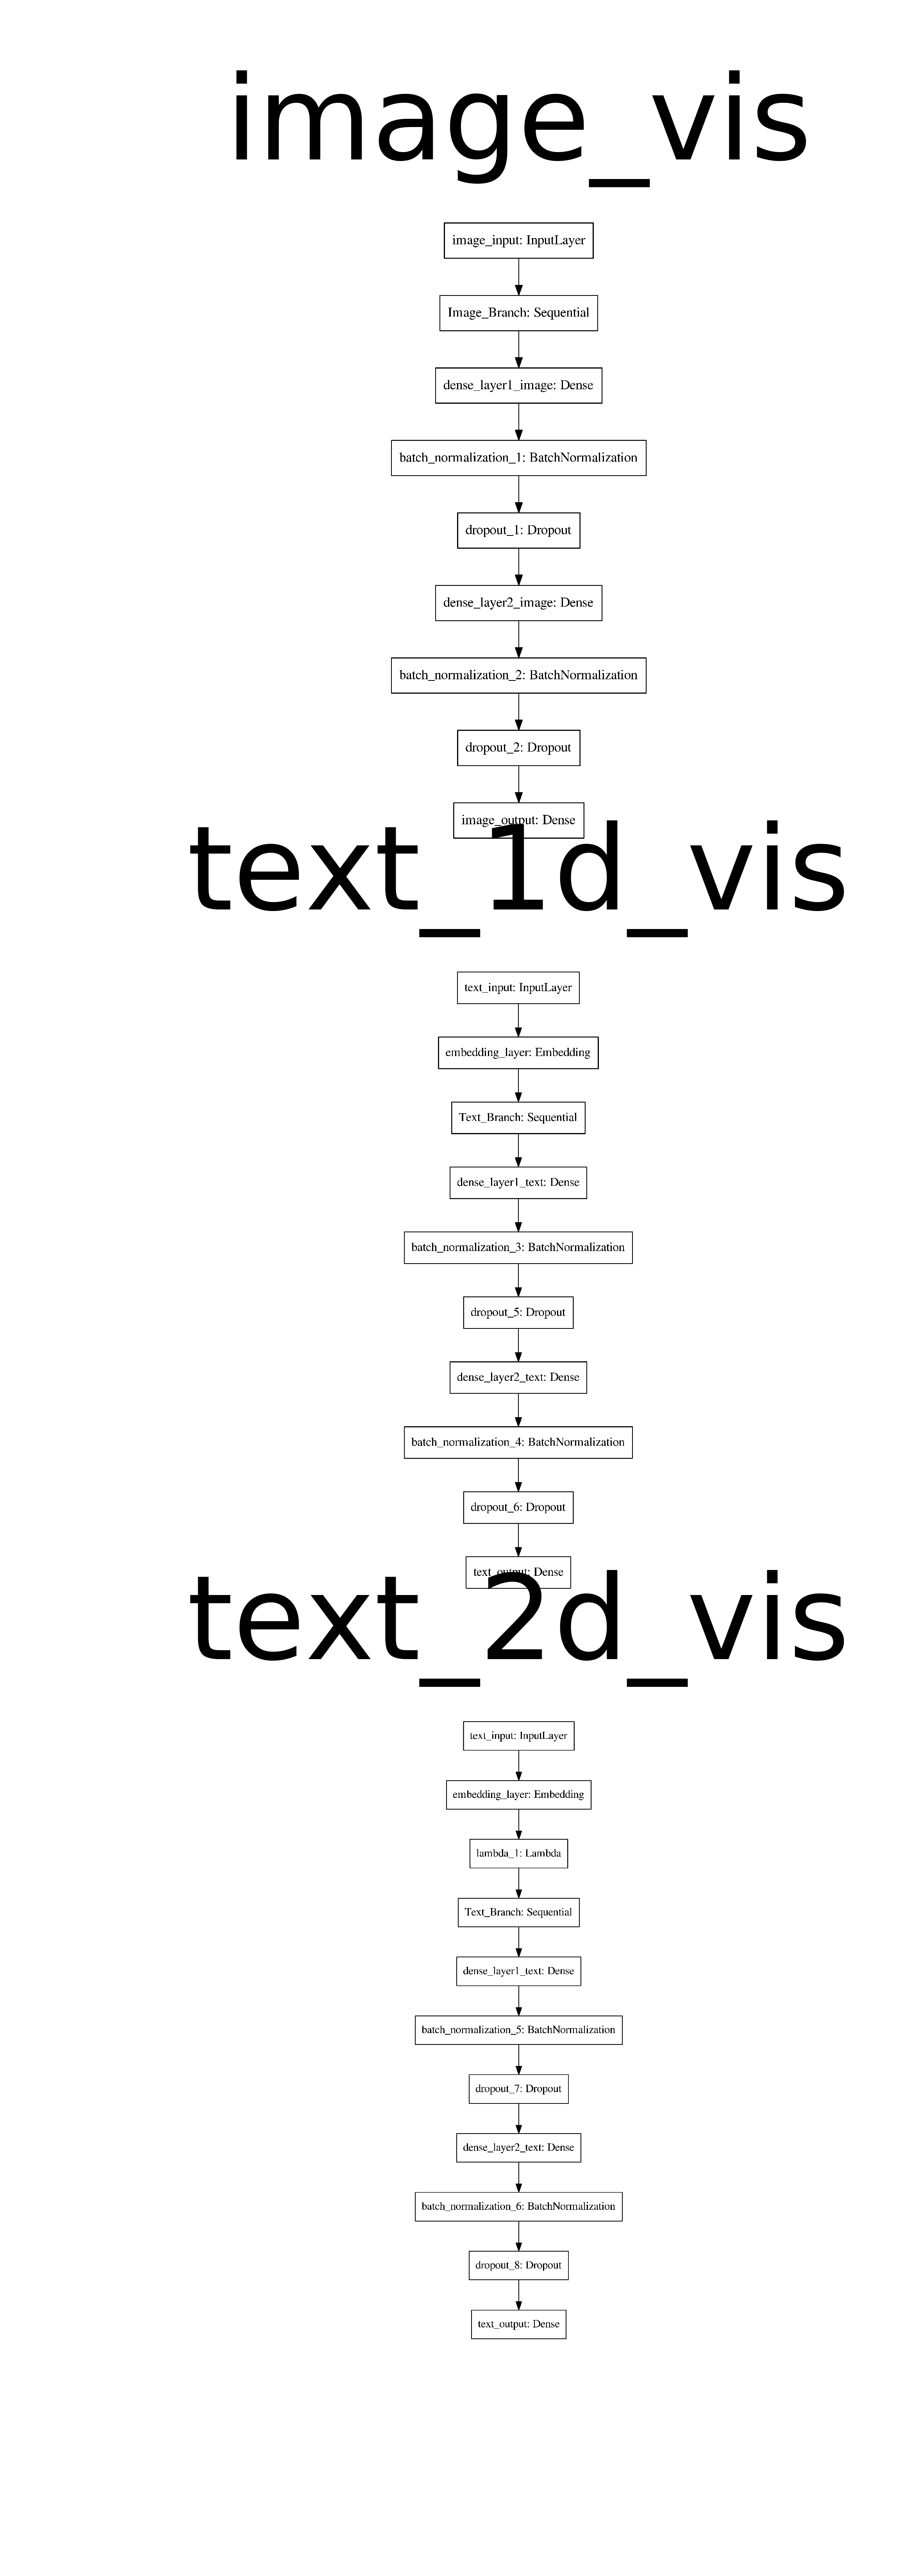

In [9]:
G_bak = G
G = 1
image_vis = Generate_Model(model_type = "image")
text_1d_vis = Generate_Model(model_type = 'text_1d')
text_2d_vis = Generate_Model(model_type = 'text_2d')

G = G_bak
base_model_list = {'image_vis': image_vis, 
                   'text_1d_vis': text_1d_vis,
                  'text_2d_vis' : text_2d_vis}
plt.rcParams["figure.dpi"] = 1800


fig,ax = plt.subplots(len(base_model_list),1)
for i, (name,model) in enumerate(base_model_list.items()):
    x = model_to_dot(model)
    x.set_dpi(600)
    x = x.create(prog='dot', format='png')
    x_ = plt.imread(io.BytesIO(x))
    #x_ = ndimage.rotate(x_, 0)
    ax[i].imshow(x_)
    ax[i].axis("off")
    ax[i].set_title(name)

### Generate our K-Folds and save them to be used by other files

In [12]:
#Split into train test
df_y = pd.DataFrame(y)
y_train = df_y.sample(frac=0.7,random_state=seed)
y_test = df_y.drop(y_train.index)

#k-fold section after we have split our data into train/test
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
folds = {}
count = 1
for train, valid in kfold.split((y_train.index), y_train[0]):
    random.shuffle(train)
    folds['fold_{}'.format(count)] = {}
    folds['fold_{}'.format(count)]['train'] = y_train.index[train].tolist()
    folds['fold_{}'.format(count)]['valid'] = y_train.index[valid].tolist()
    count += 1
folds['final'] = {}
folds['final']['train'] = list(y_train.index)
folds['final']['test'] = list(y_test.index)
#assert we have the same number of splits. Do plus 1 because folds includes a test set
print(len(folds) == n_splits+1)
#assert not having any of the test examples in train or valid--dunno why this doesn't work?
'''
for key, fold in folds.items():
    assert len(set(fold['train']).intersection(test)) == 0
    assert len(set(fold['valid']).intersection(test)) == 0
    assert len(set(fold['train']).intersection(fold['valid'])) == 0
'''
#dump folds to json
import json
with open('folds.json', 'w') as fp:
    json.dump(folds, fp)


True


In [13]:
#load to dict to be used
with open('folds.json') as f:
    kfolds = json.load(f)#get all of the fold information
    final_train = kfolds['final']['train']#put our final train indicies into a variable called train
    final_test = kfolds['final']['test']#put our final test indicies into a variable called test
    kfolds.pop('final', None)#pop the test indicies from the kfold dict
print("Number of folds: {}, length of test: {}".format(len(kfolds), len(final_test)))
#assert not having any of the test examples in train or valid. Set must be empty
#also assert all train, val, and test are different
for key, kfold in kfolds.items():
    assert len(set(kfold['train']).intersection(final_test)) == 0
    assert len(set(kfold['valid']).intersection(final_test)) == 0
    assert len(set(kfold['train']).intersection(kfold['valid'])) == 0
assert len(set(final_train).intersection(final_test)) == 0
    

Number of folds: 5, length of test: 2241


### K fold validation on images only

fold_1
K-: fold_1
Samples from Training
[1267 5926 2215 2933]


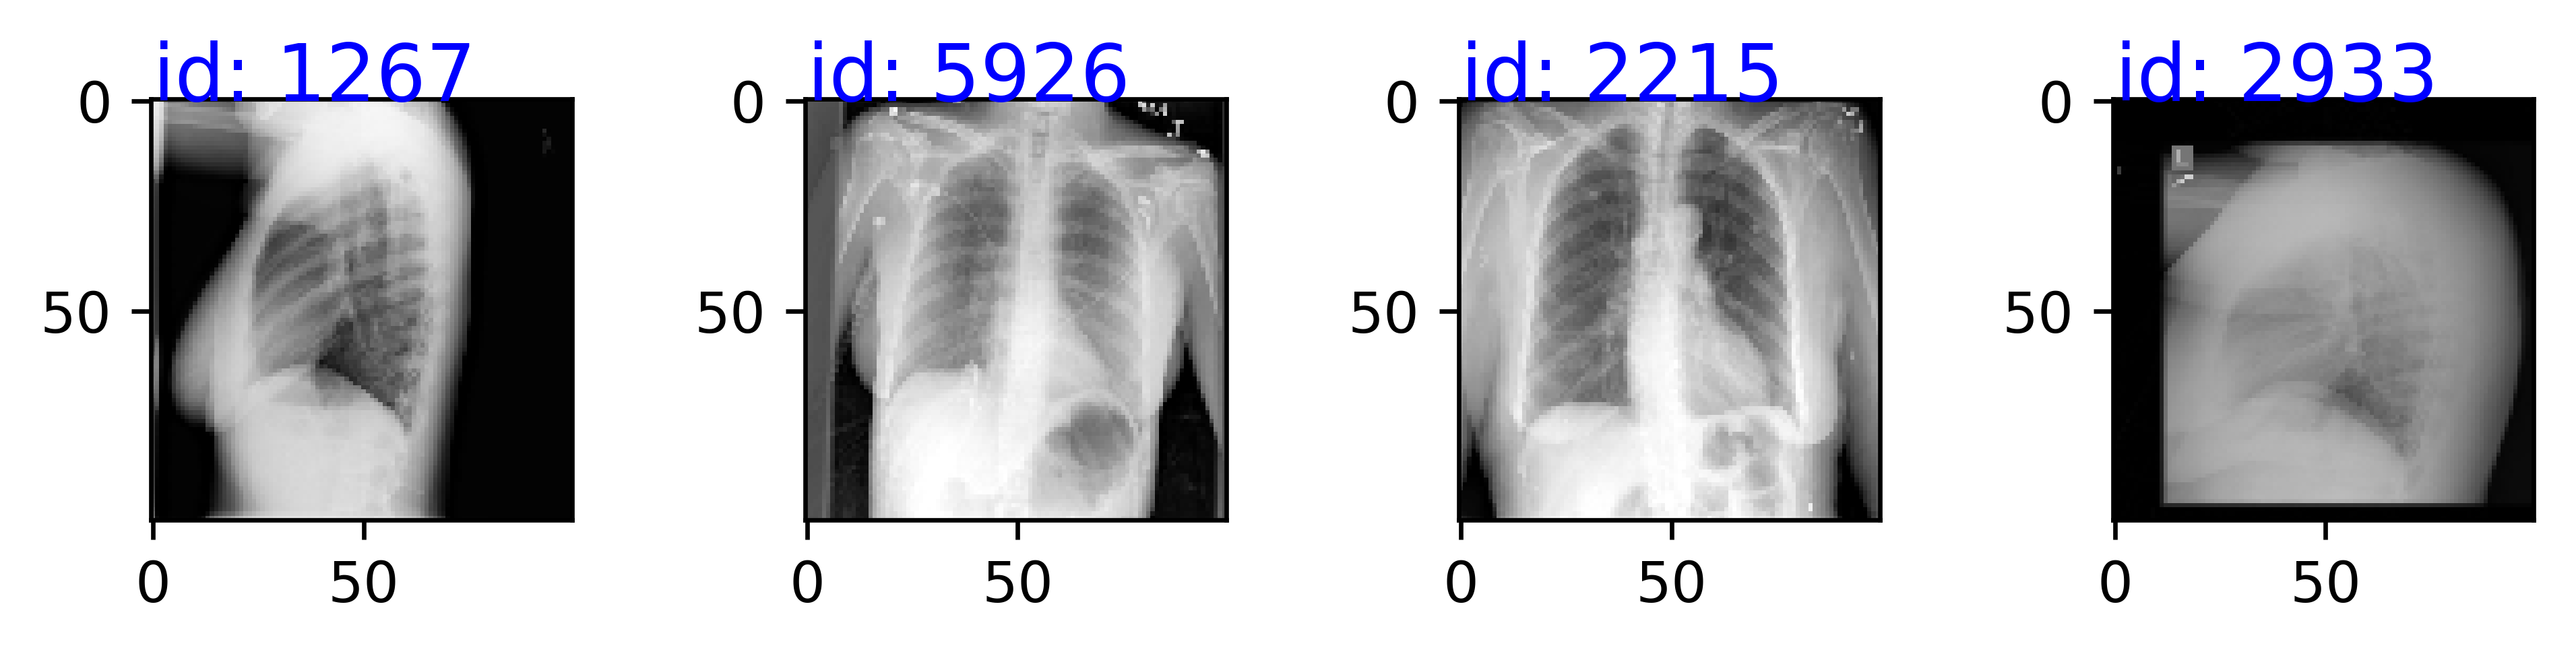

Samples from Validation
[  39 6979 3506 3377]


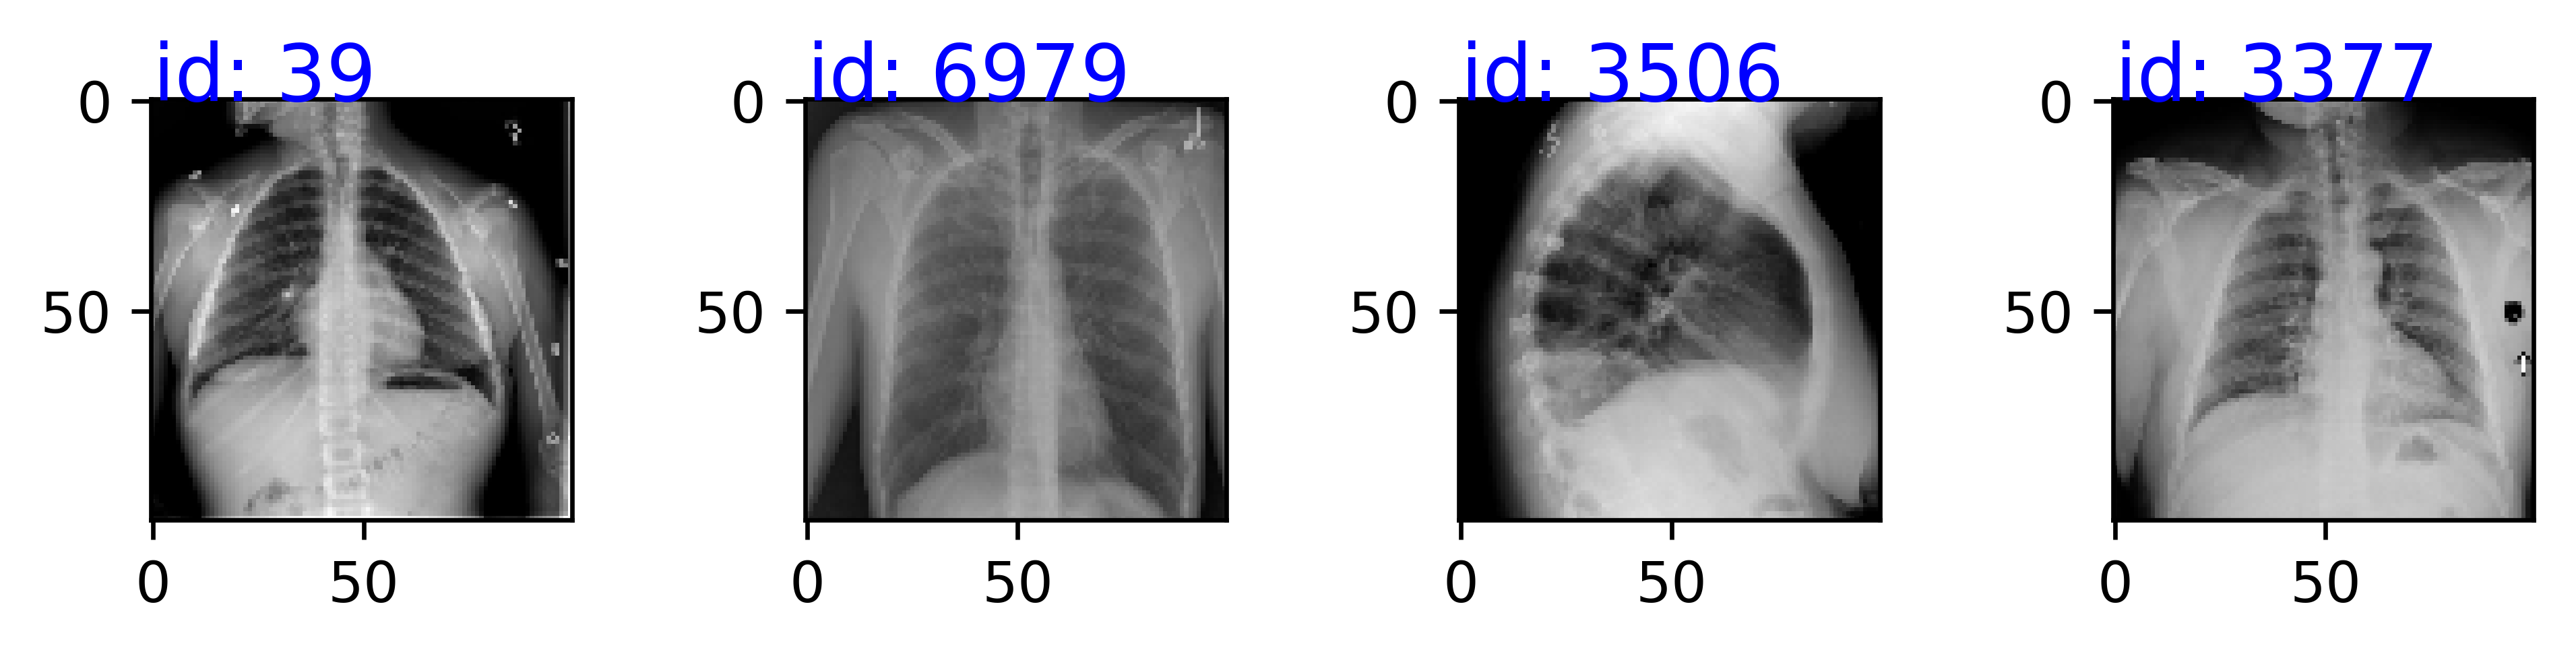

[INFO] training with 2 GPUs...
Train on 4182 samples, validate on 1047 samples
Epoch 1/150
4182/4182 [==============================] - 10s 2ms/step - loss: 1.1471 - acc: 0.5368 - val_loss: 1.0582 - val_acc: 0.5683

Epoch 00001: val_acc improved from -inf to 0.56829, saving model to unimodal_weights/best_weight_image_only_k-fold_1.hdf5
Epoch 2/150
4182/4182 [==============================] - 5s 1ms/step - loss: 0.9389 - acc: 0.5780 - val_loss: 1.3413 - val_acc: 0.4766

Epoch 00002: val_acc did not improve from 0.56829
Epoch 3/150
4182/4182 [==============================] - 5s 1ms/step - loss: 0.8551 - acc: 0.5760 - val_loss: 1.0674 - val_acc: 0.5960

Epoch 00003: val_acc improved from 0.56829 to 0.59599, saving model to unimodal_weights/best_weight_image_only_k-fold_1.hdf5
Epoch 4/150
4182/4182 [==============================] - 5s 1ms/step - loss: 0.7656 - acc: 0.5971 - val_loss: 0.6822 - val_acc: 0.6036

Epoch 00004: val_acc improved from 0.59599 to 0.60363, saving model to unimodal

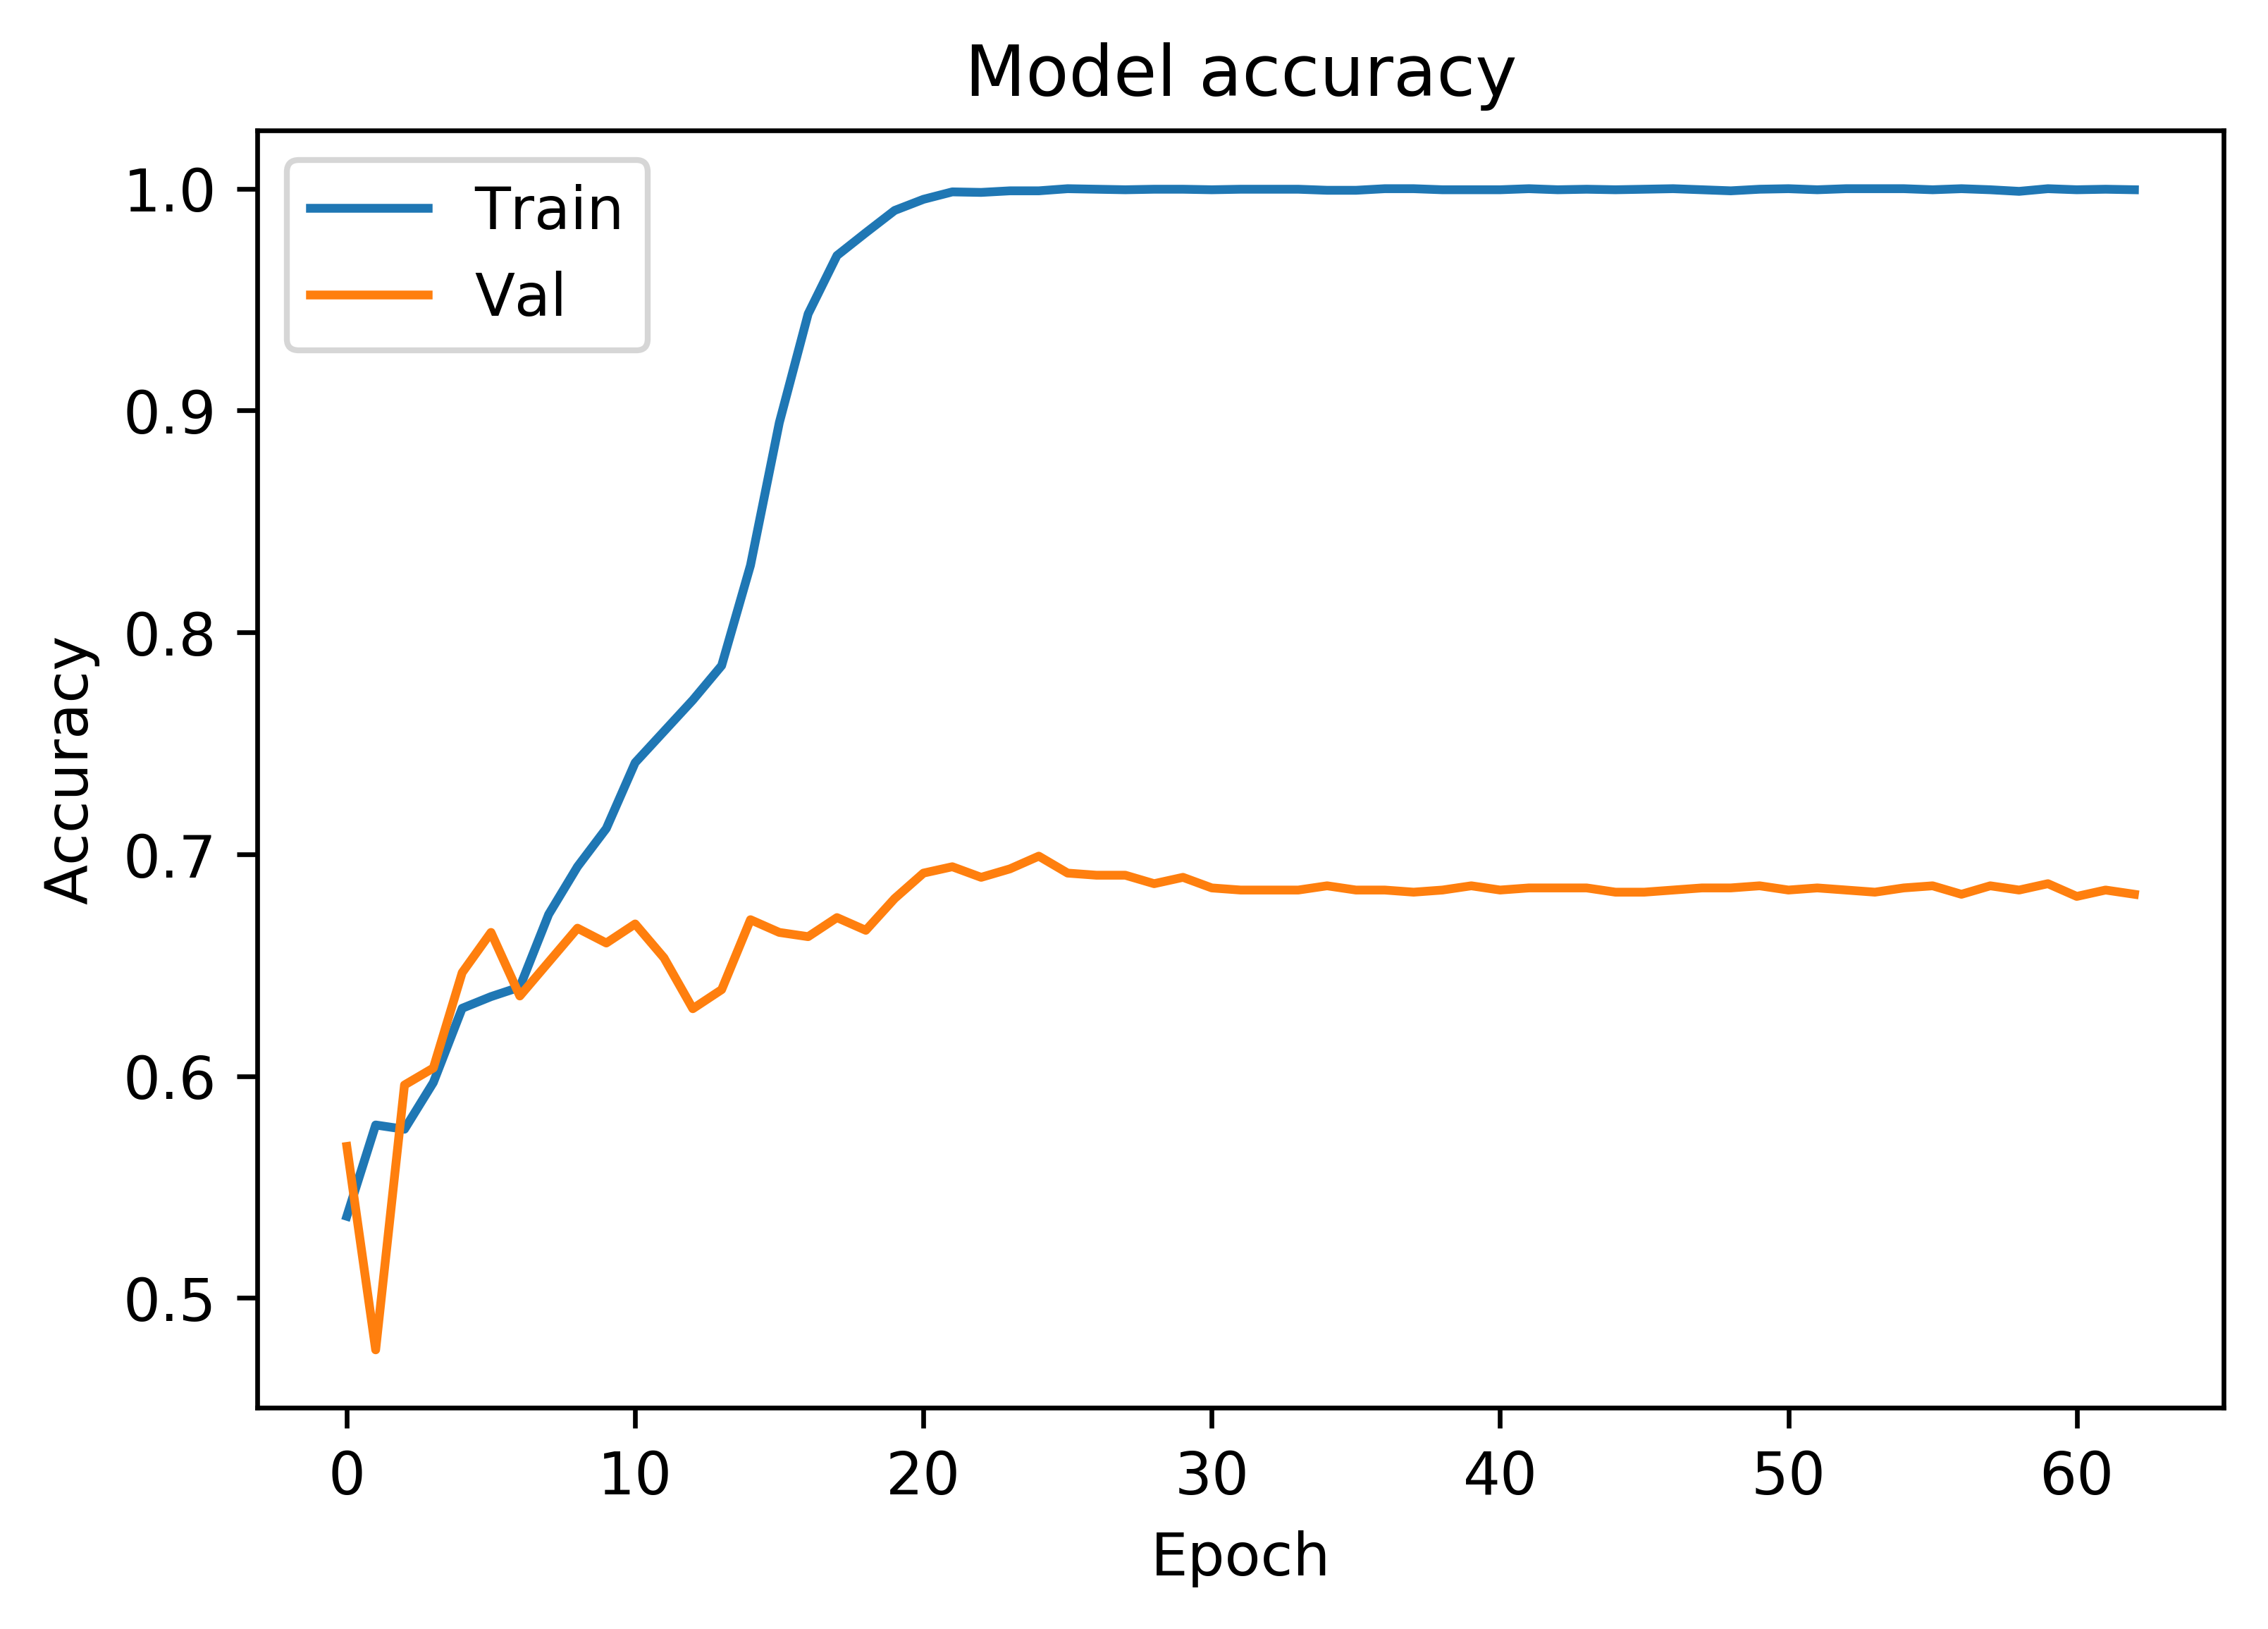

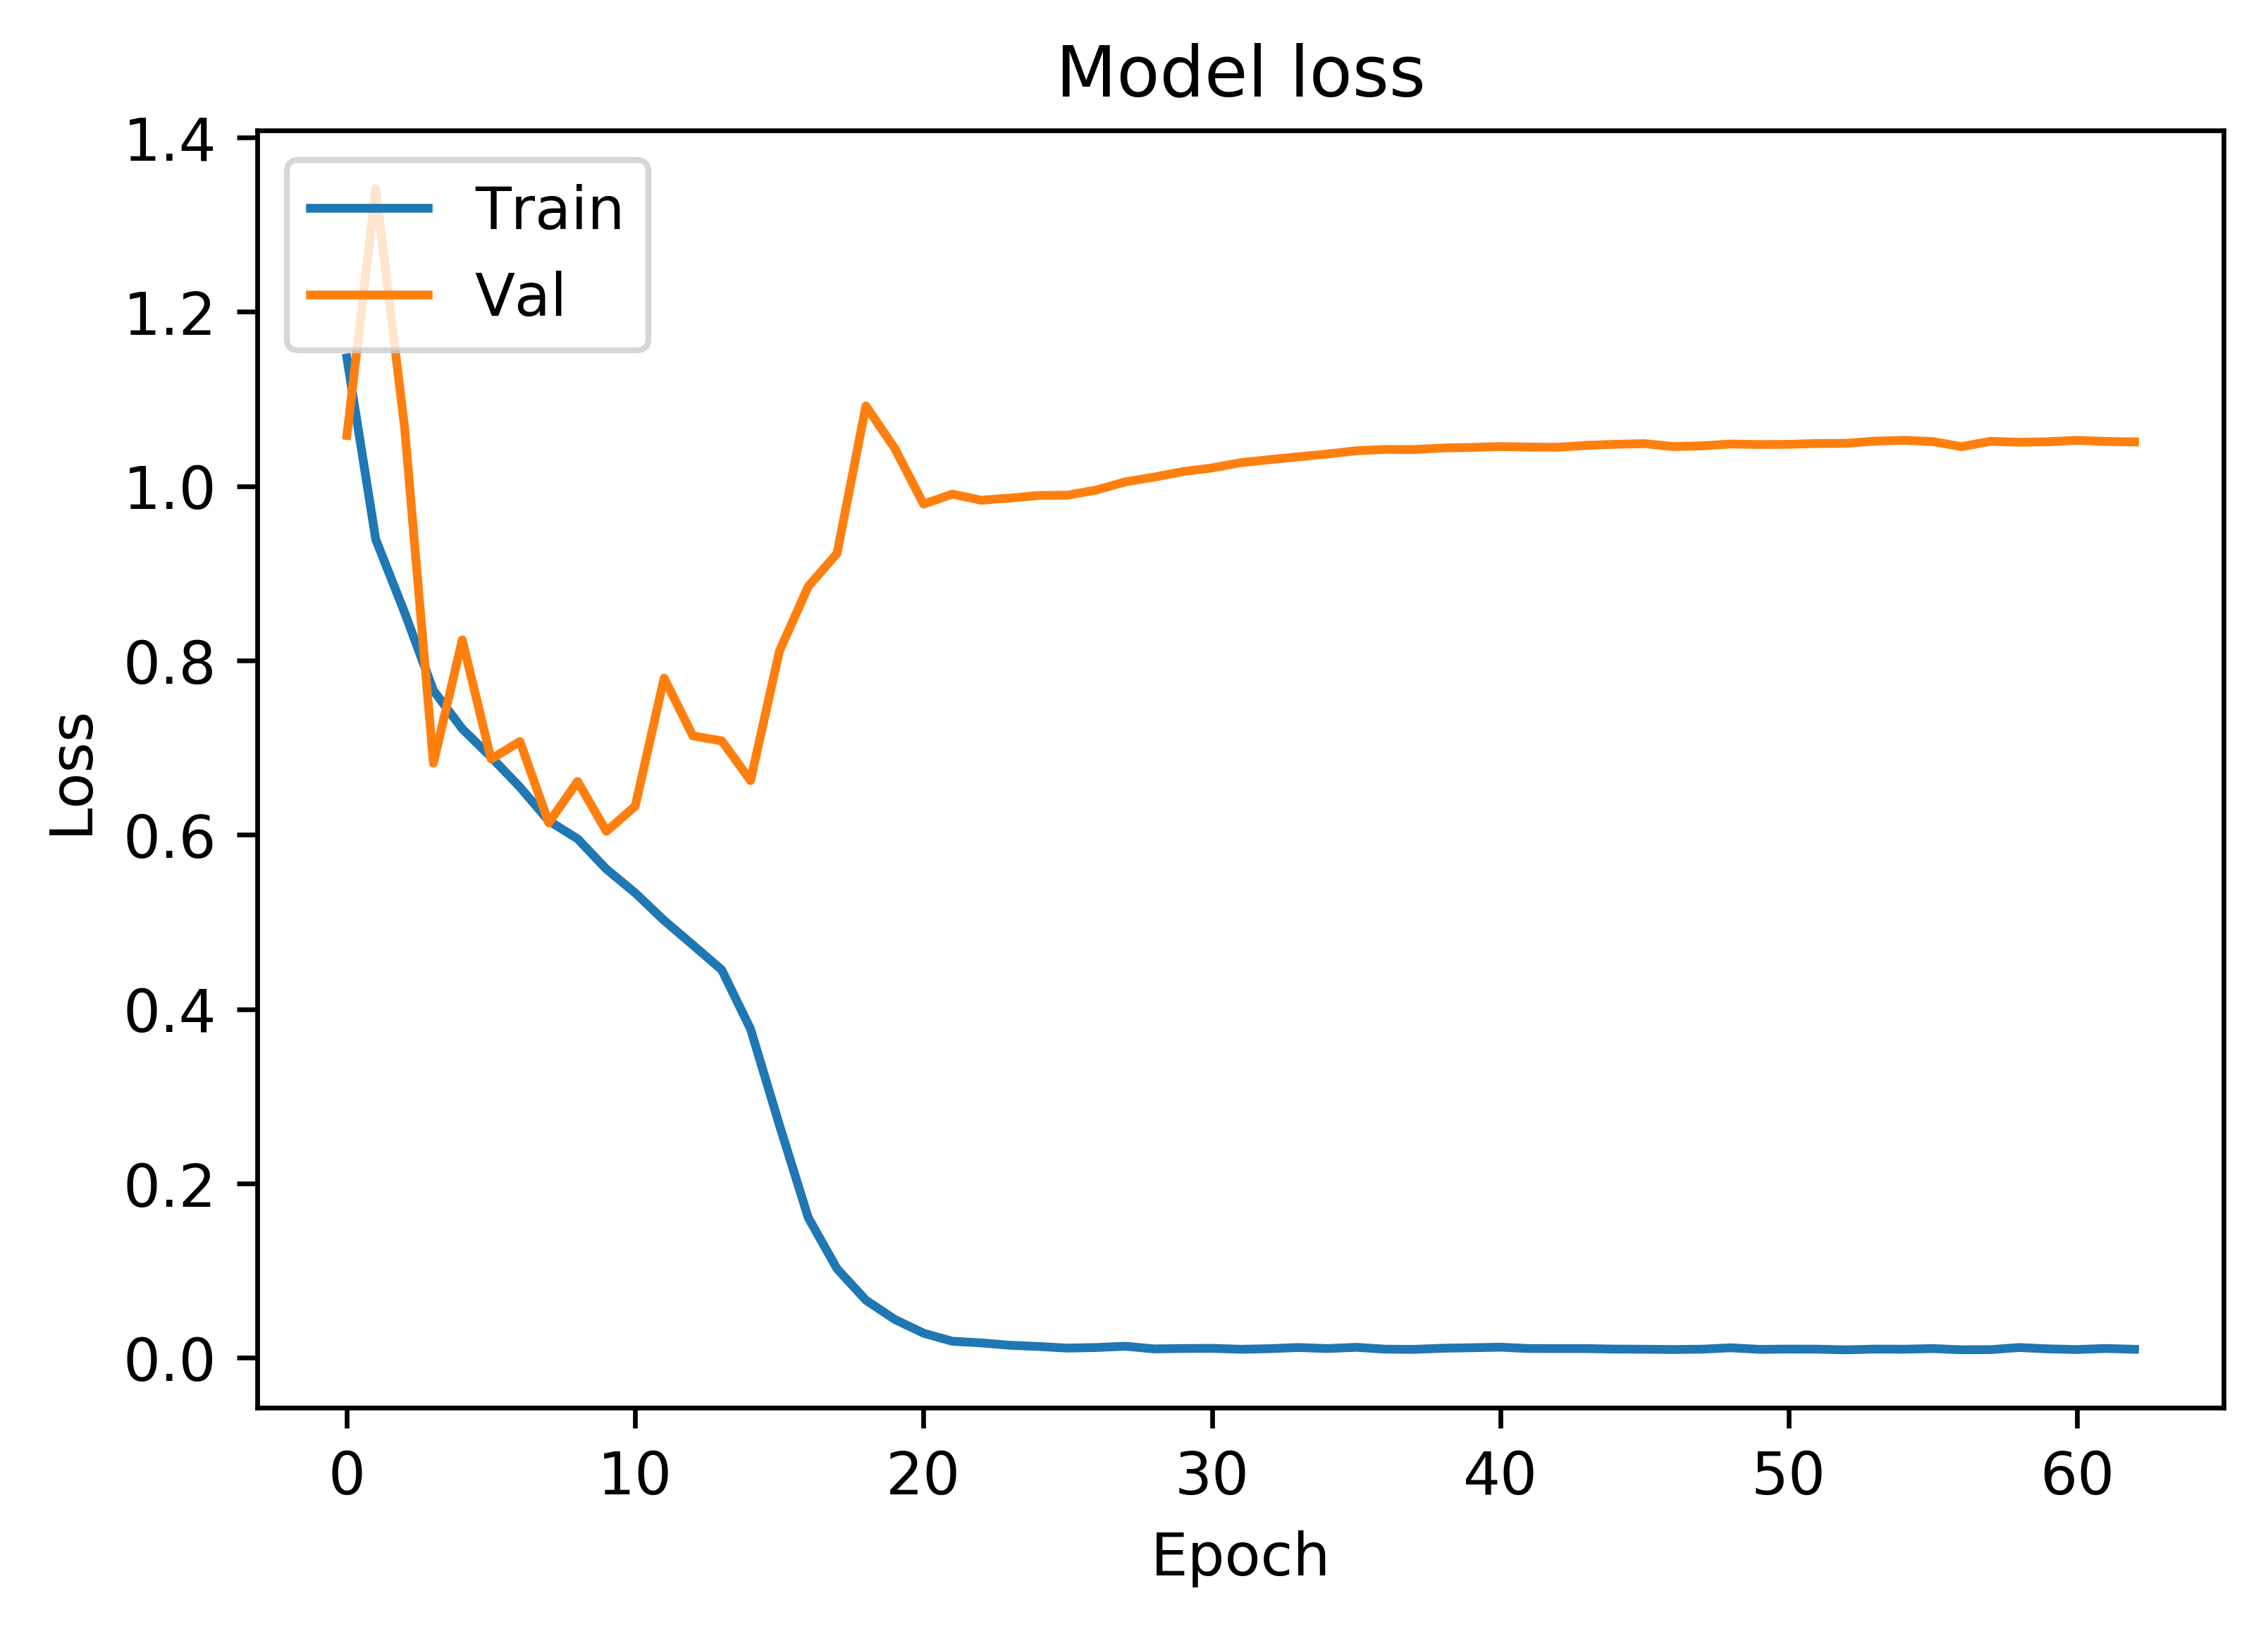

Results from K-fold: 1
acc: 68.19%
1047/1047 [==============================] - 1s 710us/step
[1.050747893259655, 0.6819484245811287]
          normal  abnormal
normal       522       147
abnormal     186       192
              precision    recall  f1-score   support

      normal       0.74      0.78      0.76       669
    abnormal       0.57      0.51      0.54       378

   micro avg       0.68      0.68      0.68      1047
   macro avg       0.65      0.64      0.65      1047
weighted avg       0.68      0.68      0.68      1047

fold_2
K-: fold_2
Samples from Training
[6945 4672 2690 2928]


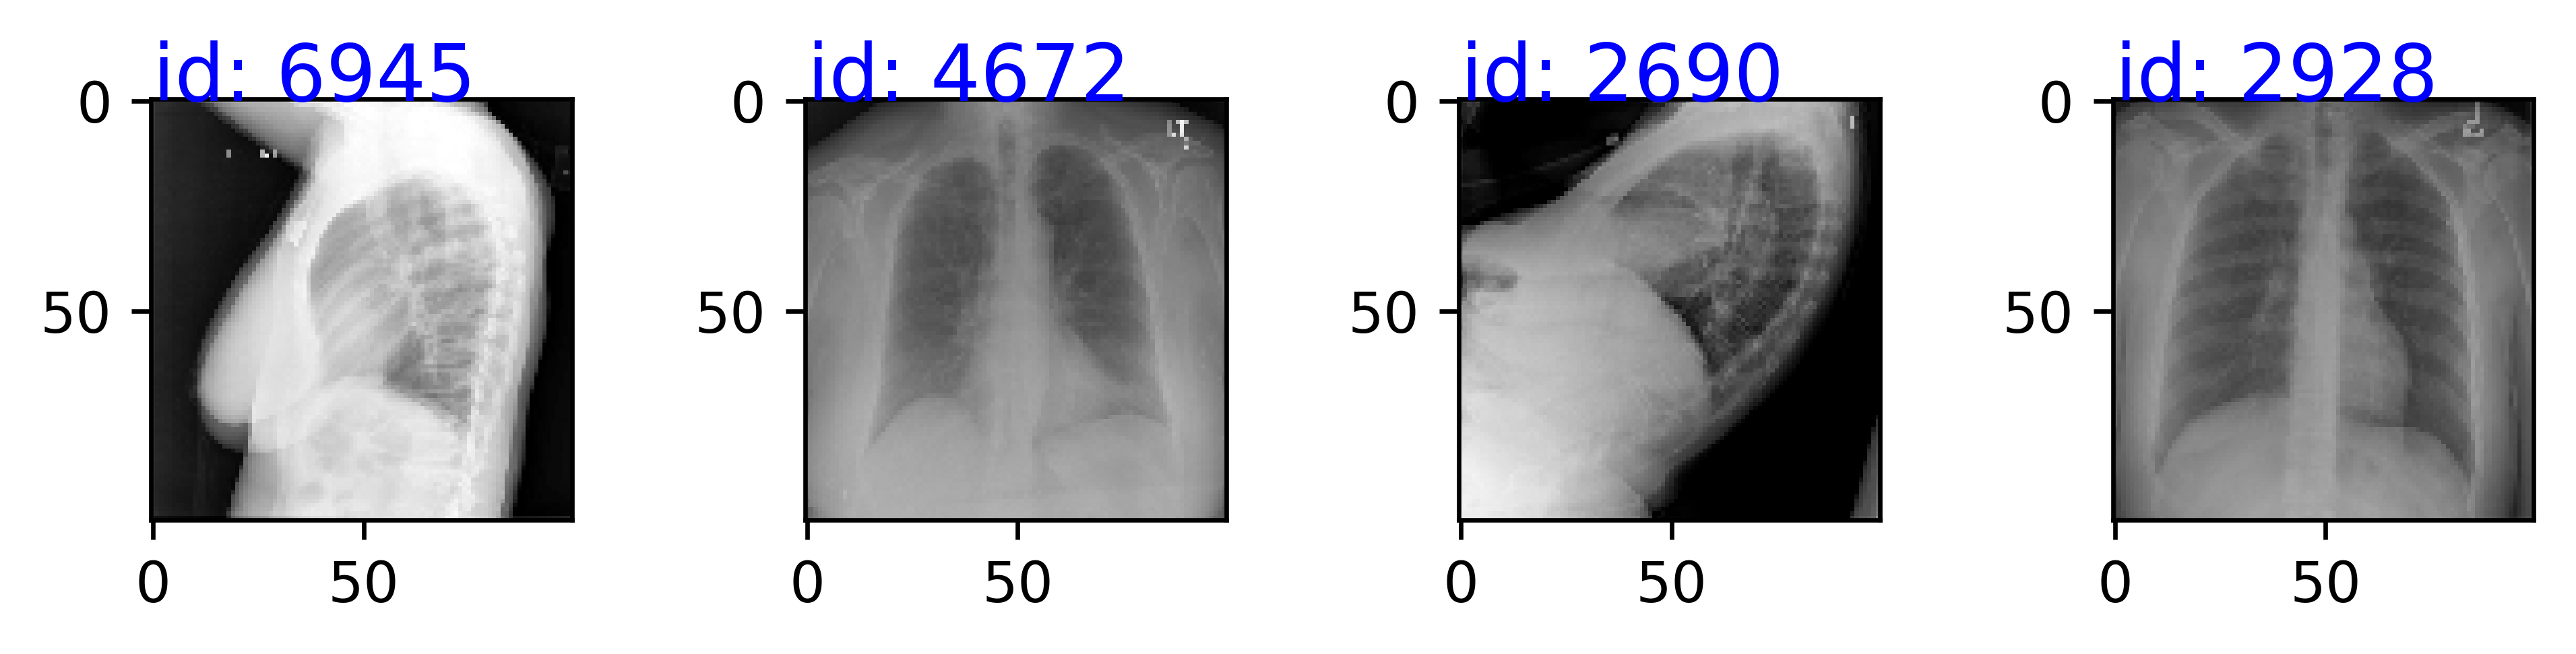

Samples from Validation
[2200 3605 1592 4253]


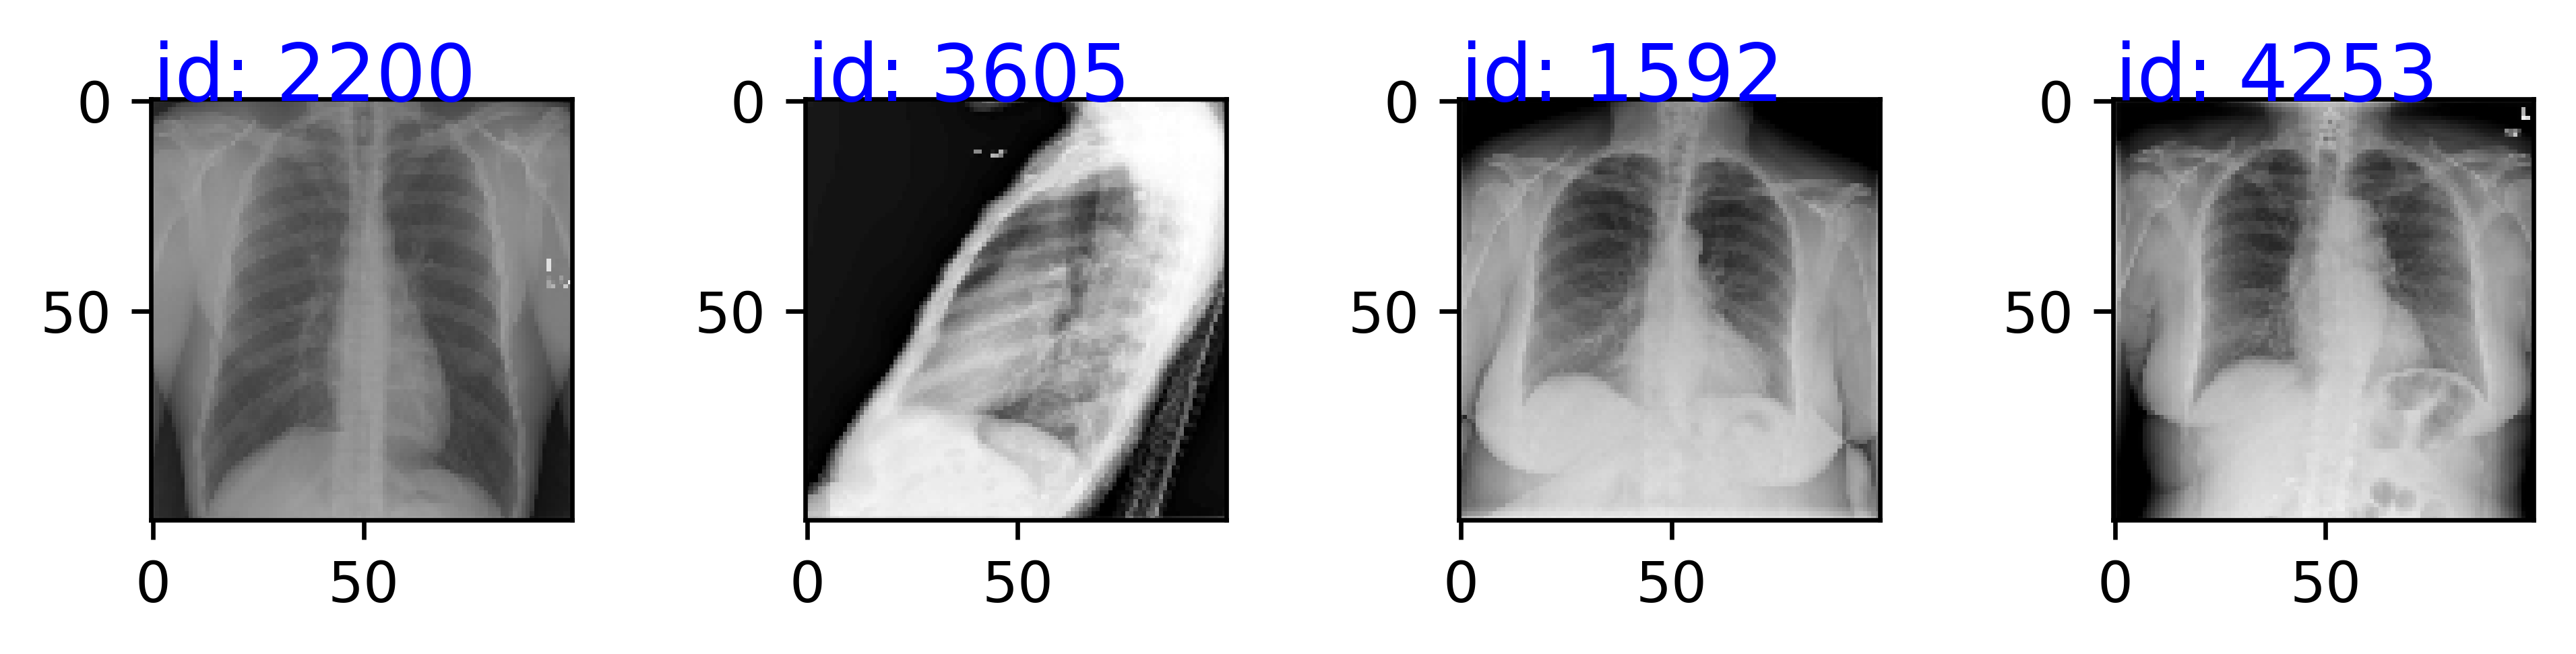

[INFO] training with 2 GPUs...
Train on 4183 samples, validate on 1046 samples
Epoch 1/150
4183/4183 [==============================] - 11s 3ms/step - loss: 1.1761 - acc: 0.5305 - val_loss: 1.6682 - val_acc: 0.5870

Epoch 00001: val_acc improved from -inf to 0.58700, saving model to unimodal_weights/best_weight_image_only_k-fold_2.hdf5
Epoch 2/150
4183/4183 [==============================] - 5s 1ms/step - loss: 0.9254 - acc: 0.5709 - val_loss: 1.6585 - val_acc: 0.5516

Epoch 00002: val_acc did not improve from 0.58700
Epoch 3/150
4183/4183 [==============================] - 5s 1ms/step - loss: 0.8349 - acc: 0.5989 - val_loss: 0.7546 - val_acc: 0.6243

Epoch 00003: val_acc improved from 0.58700 to 0.62428, saving model to unimodal_weights/best_weight_image_only_k-fold_2.hdf5
Epoch 4/150
4183/4183 [==============================] - 5s 1ms/step - loss: 0.7819 - acc: 0.6082 - val_loss: 0.6658 - val_acc: 0.6482

Epoch 00004: val_acc improved from 0.62428 to 0.64818, saving model to unimodal

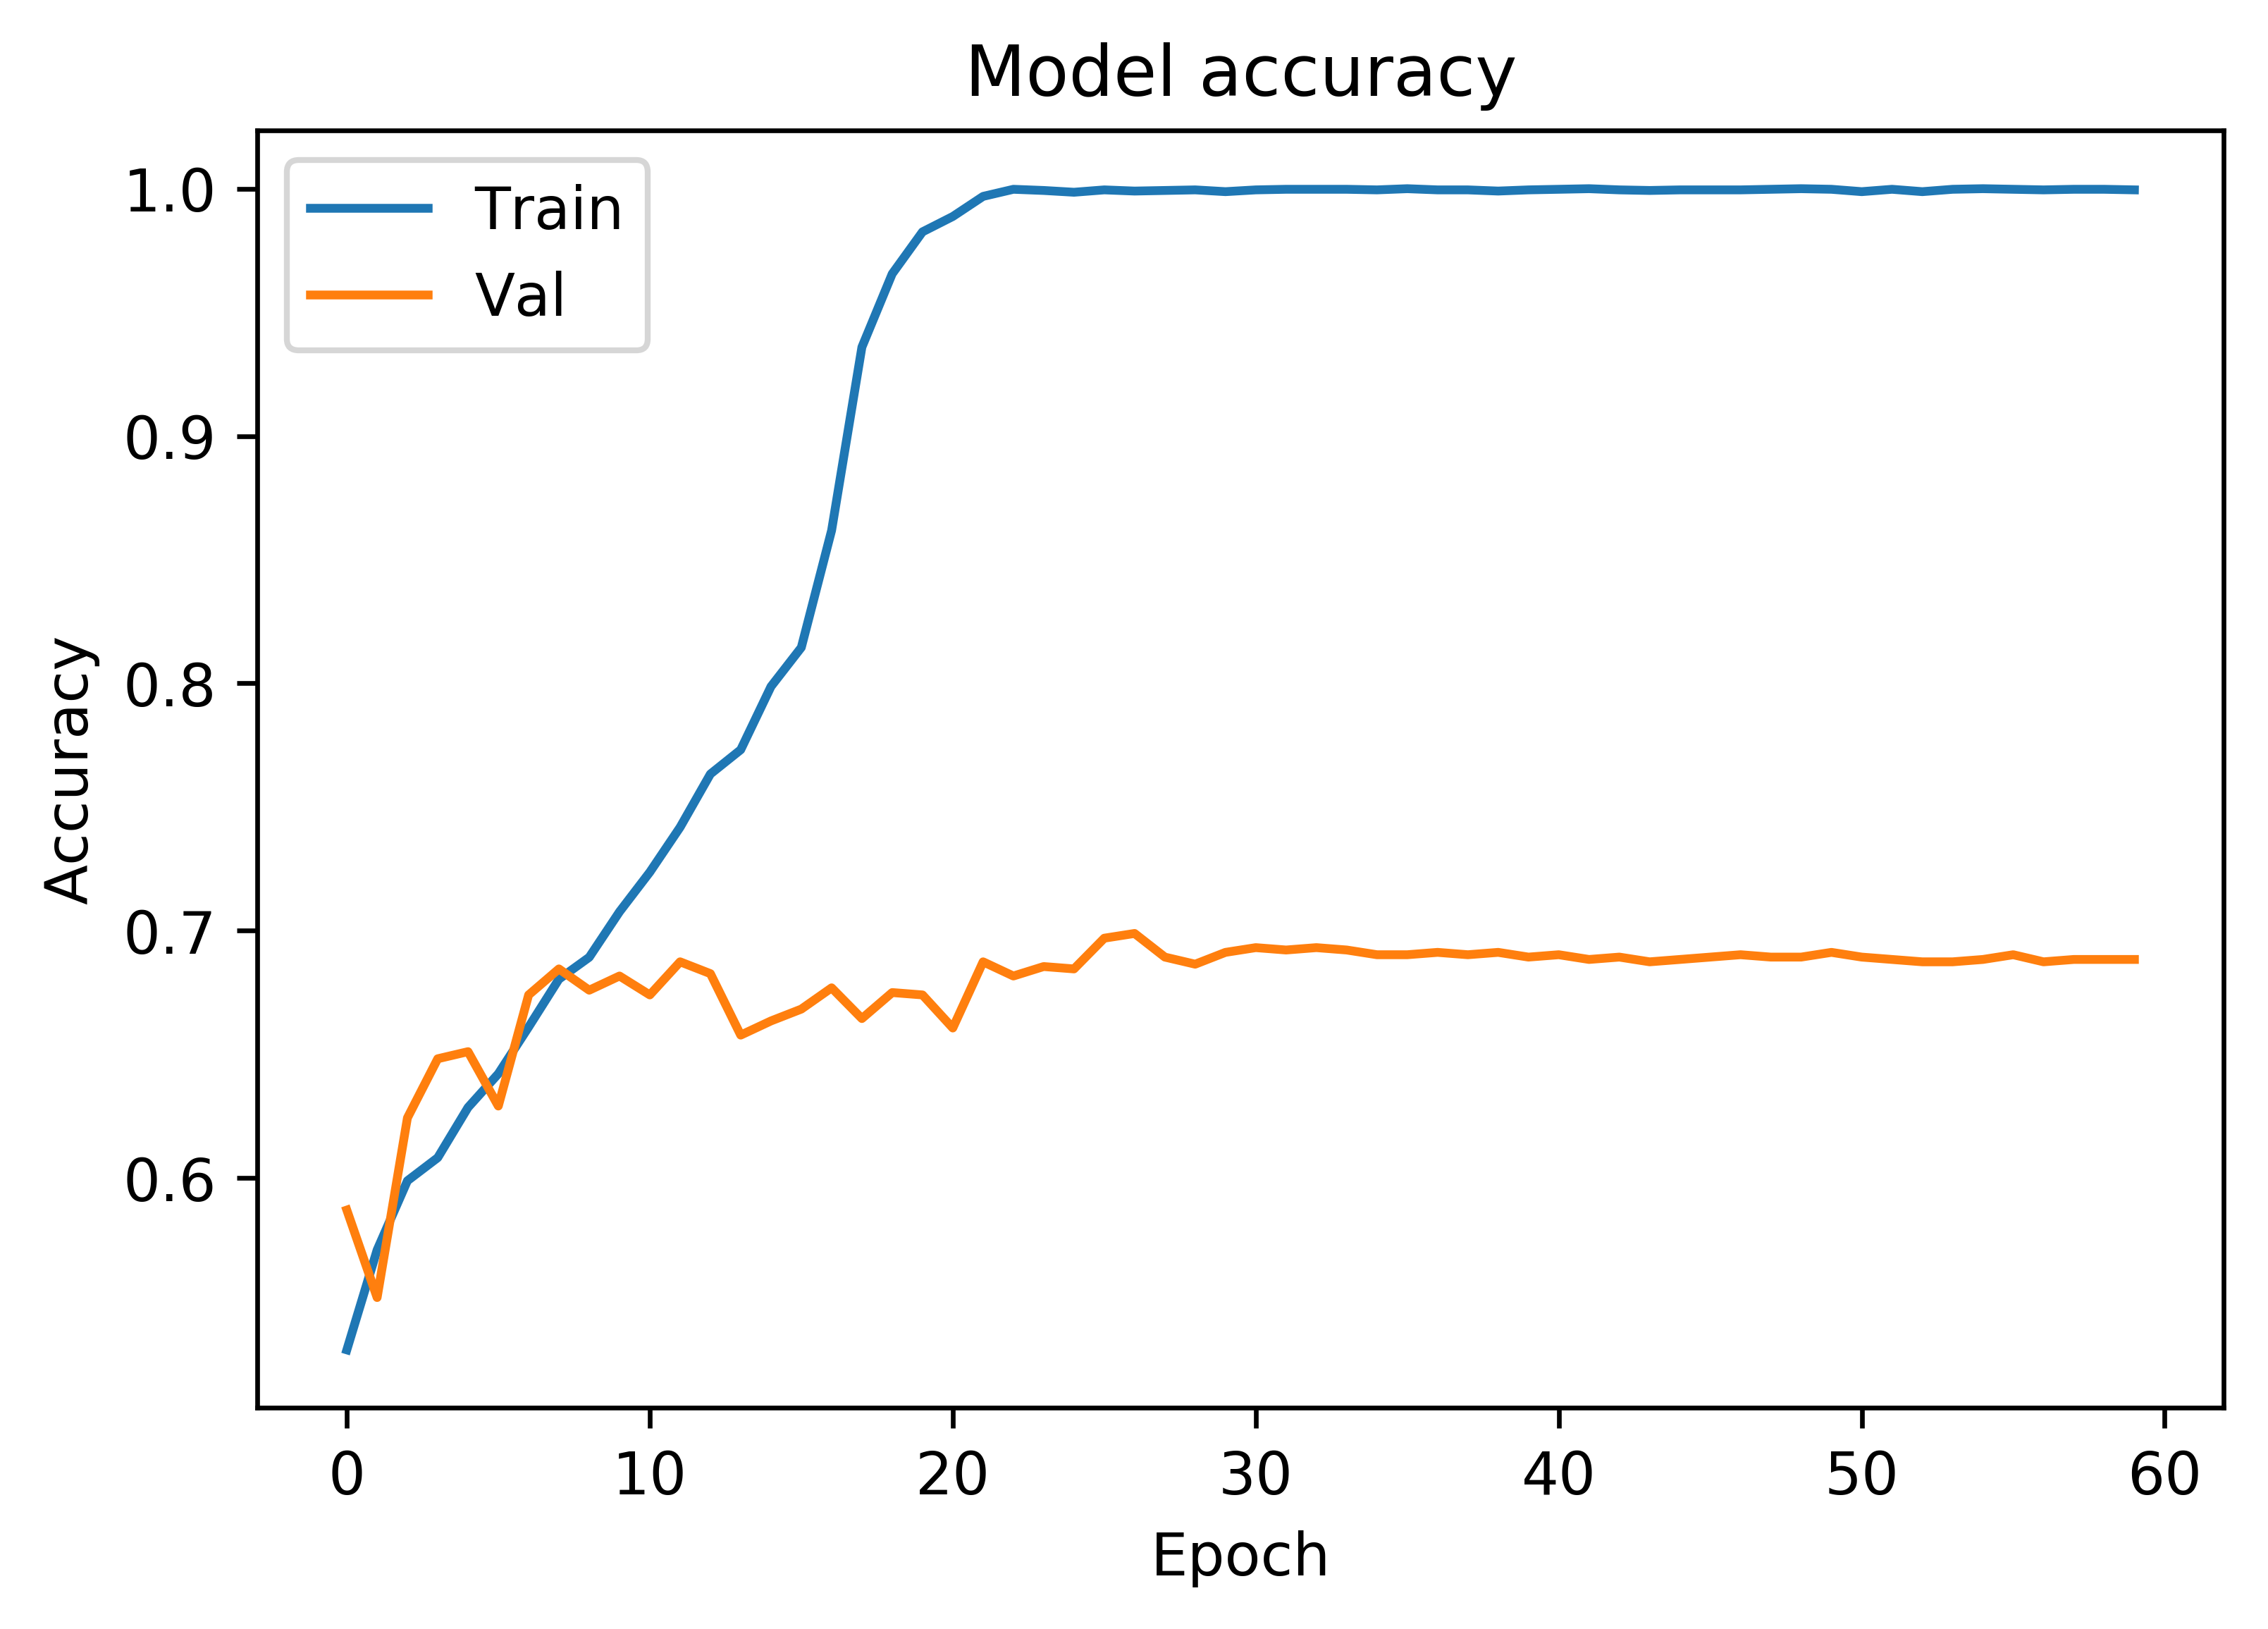

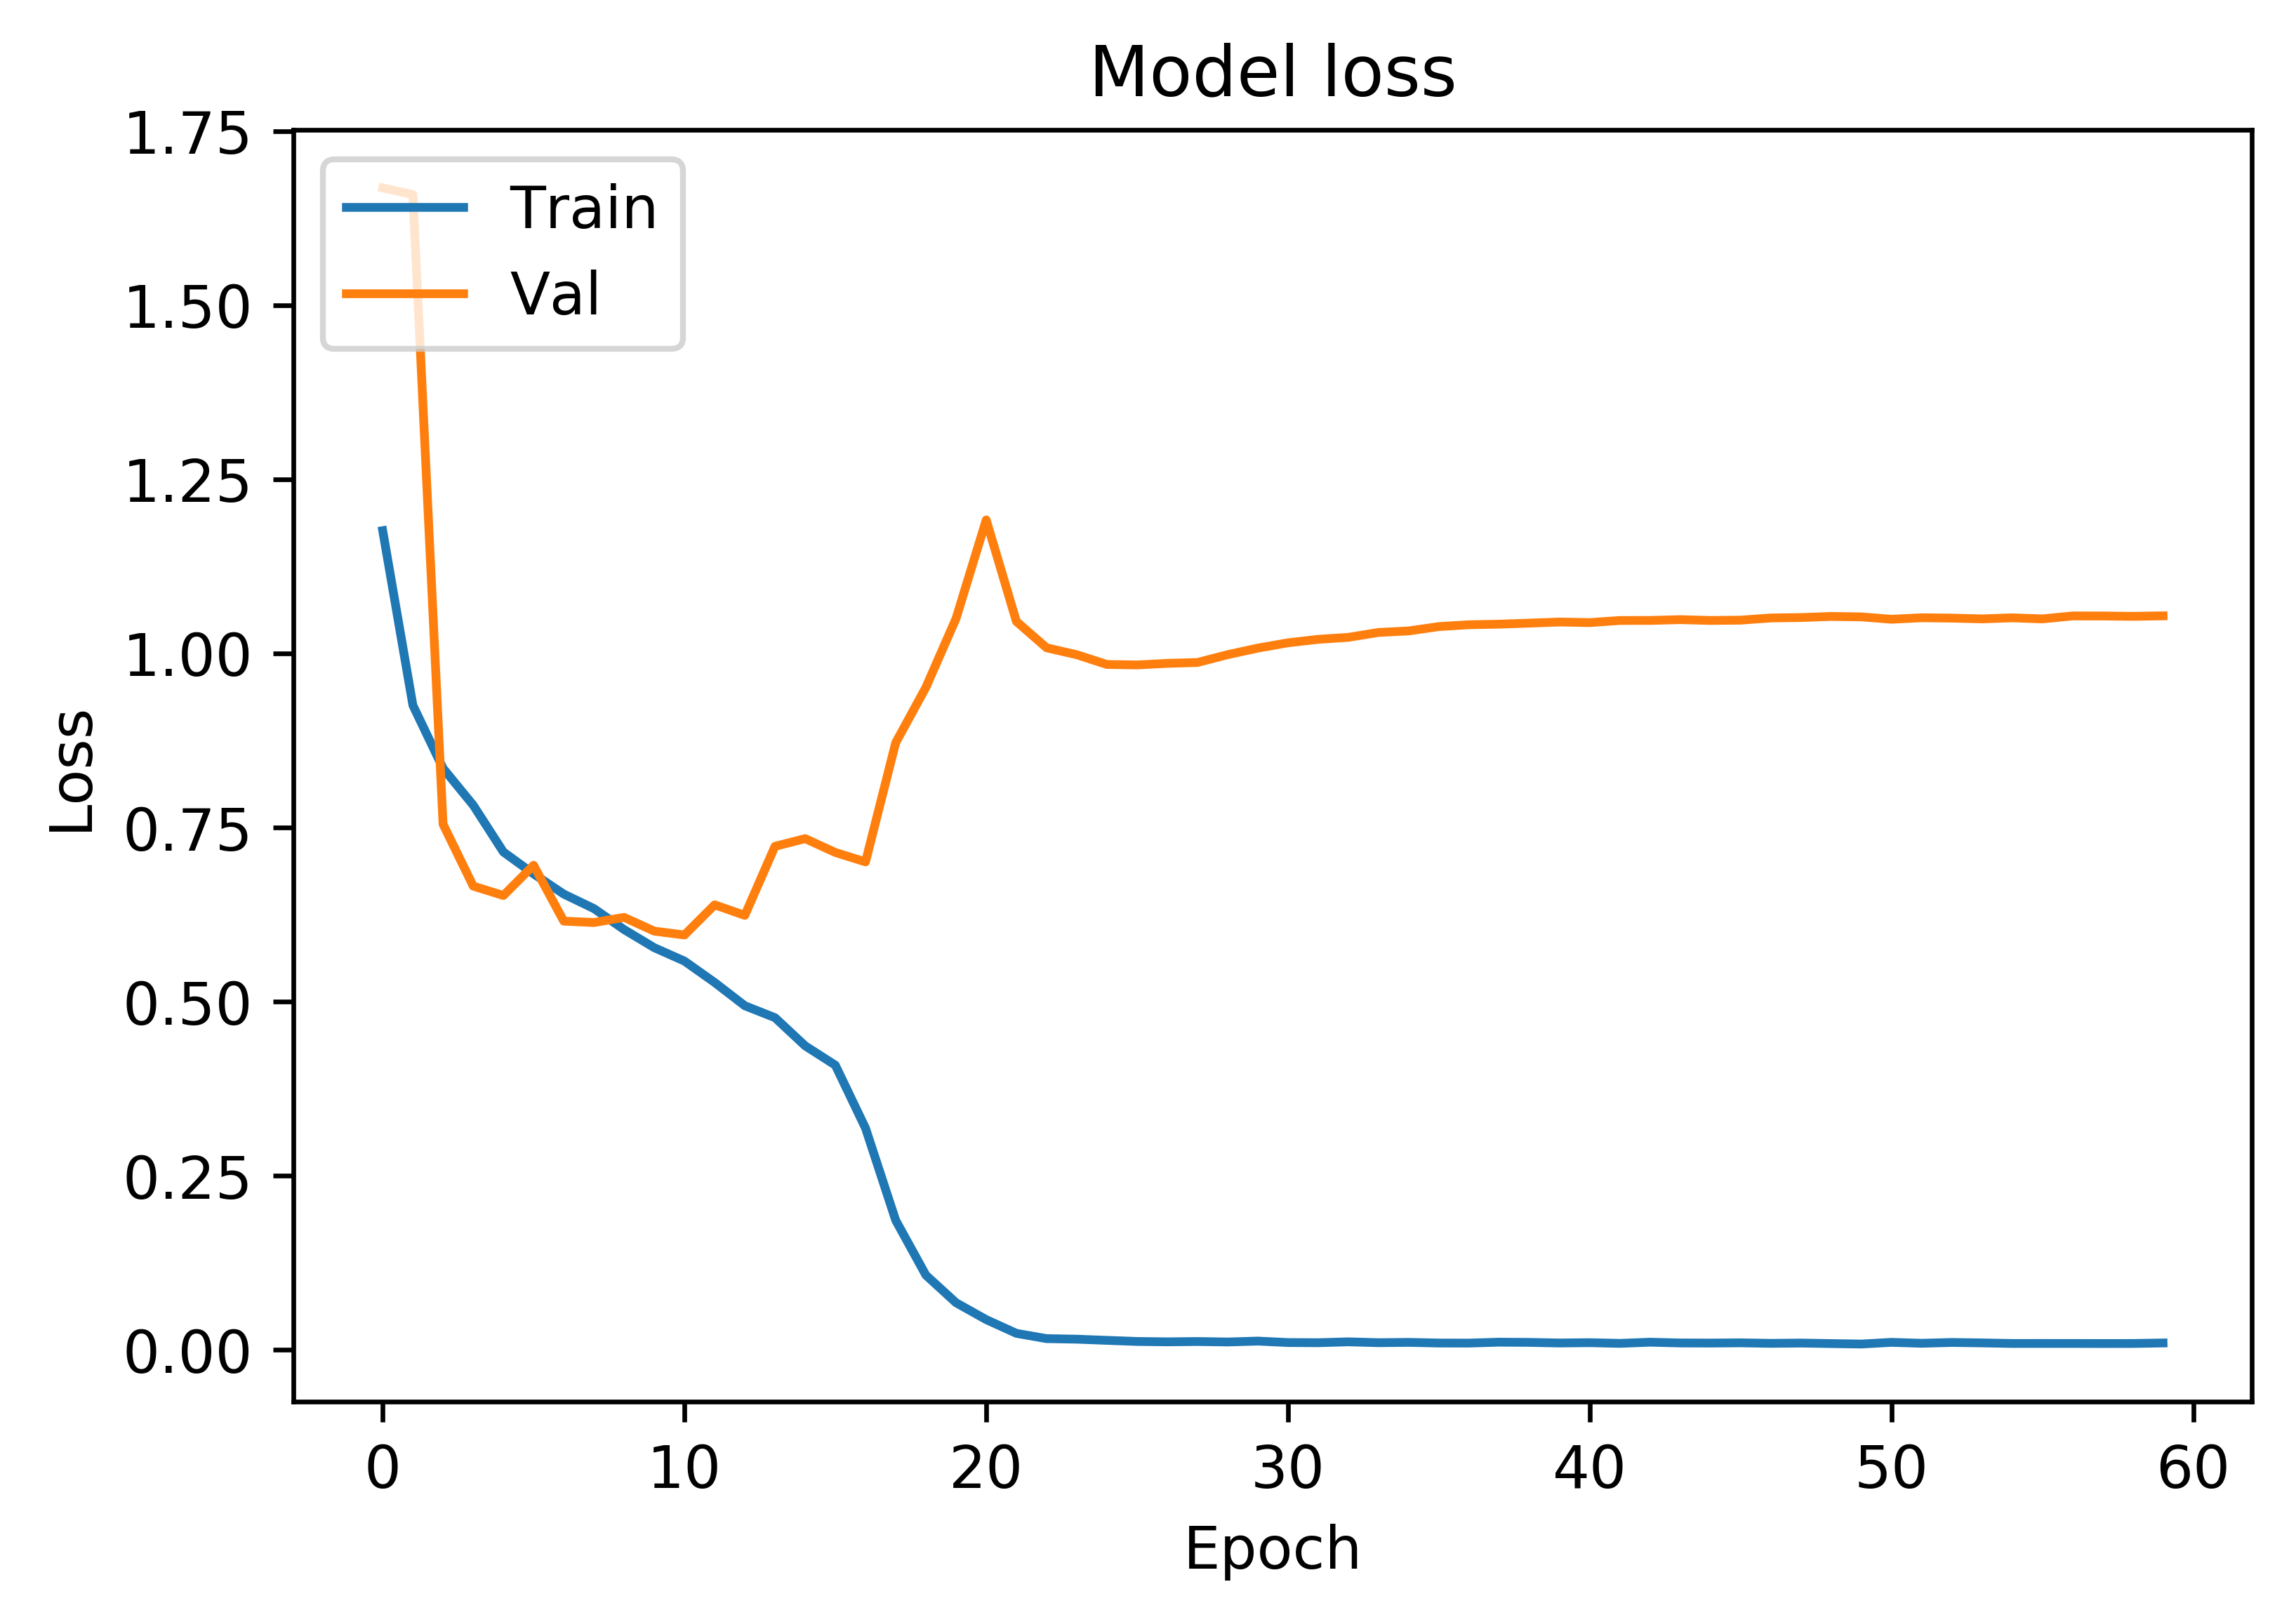

Results from K-fold: 2
acc: 68.83%
1046/1046 [==============================] - 1s 816us/step
[1.053800724888395, 0.6883365196206146]
          normal  abnormal
normal       539       129
abnormal     197       181
              precision    recall  f1-score   support

      normal       0.73      0.81      0.77       668
    abnormal       0.58      0.48      0.53       378

   micro avg       0.69      0.69      0.69      1046
   macro avg       0.66      0.64      0.65      1046
weighted avg       0.68      0.69      0.68      1046

fold_3
K-: fold_3
Samples from Training
[1892 2643 6303 1168]


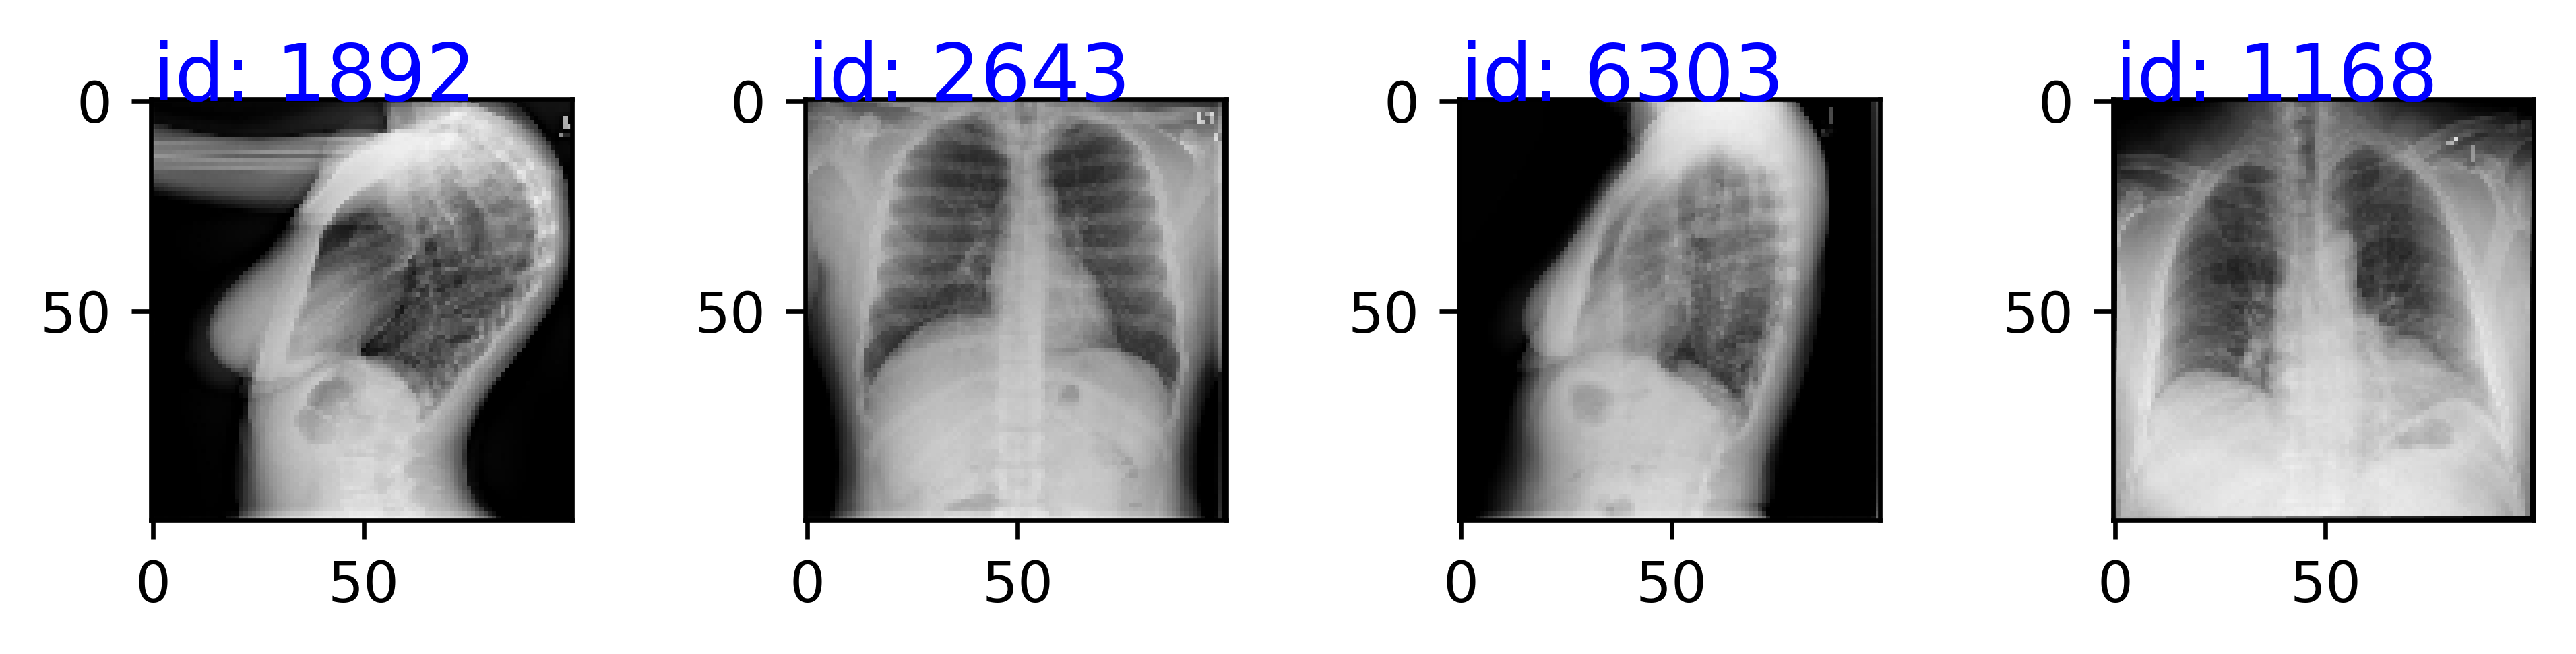

Samples from Validation
[4229 3925 5427 6301]


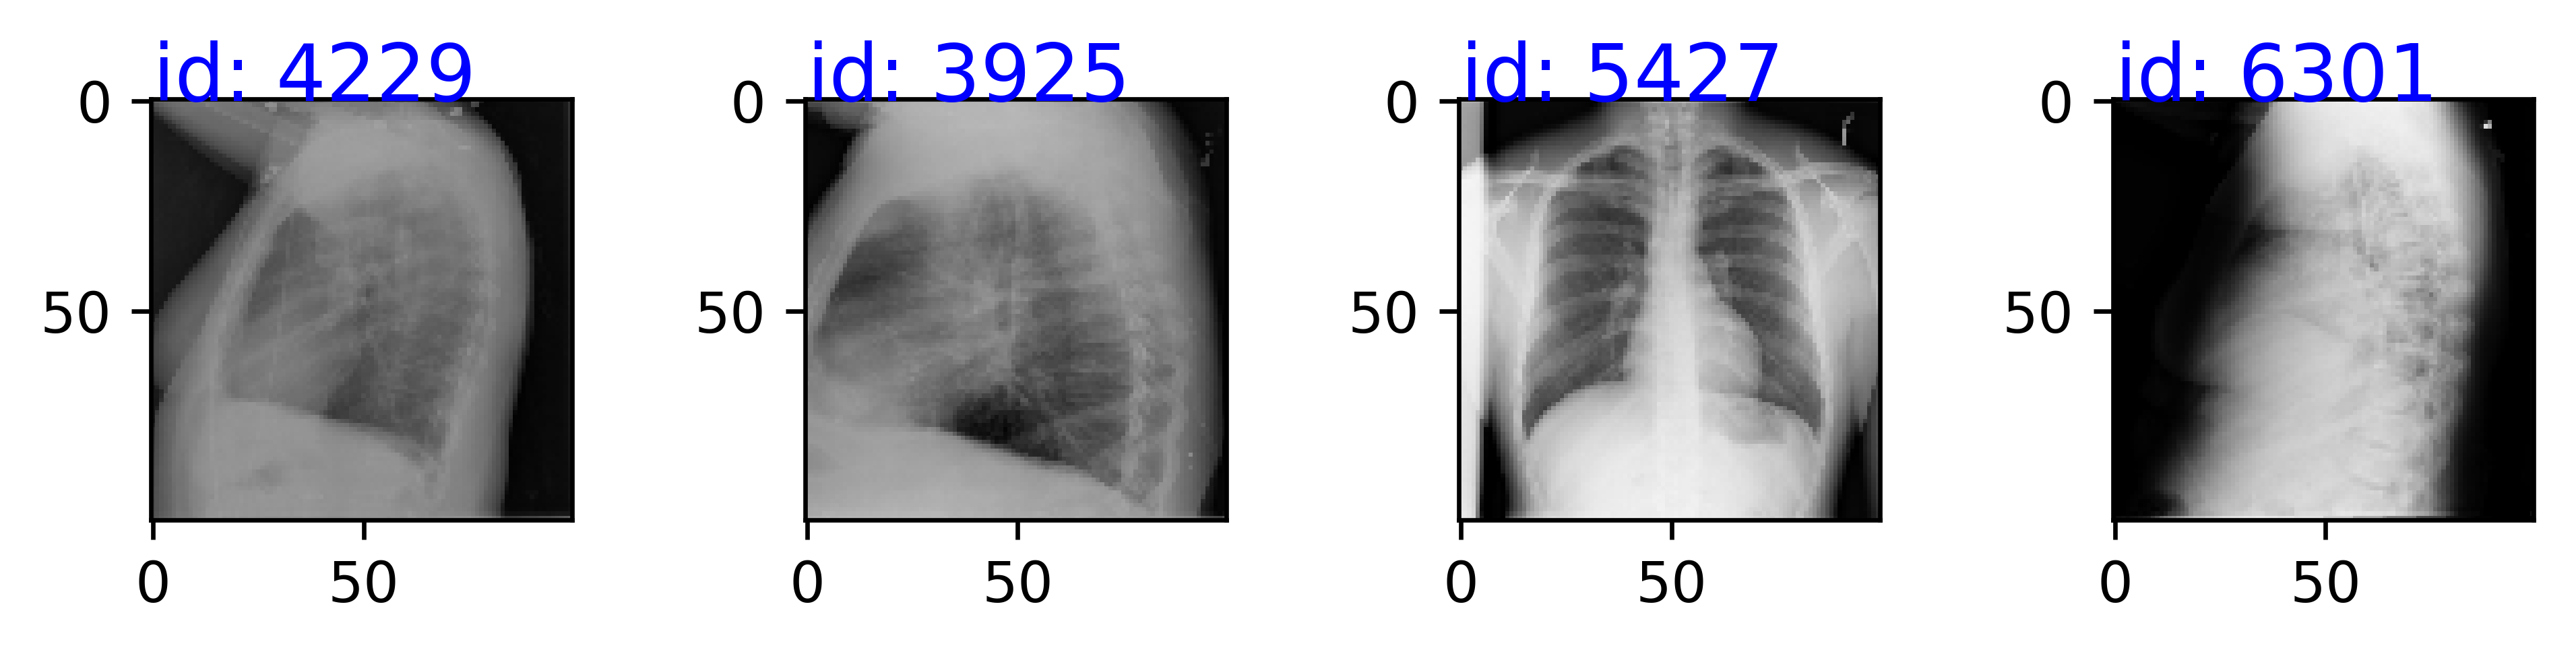

[INFO] training with 2 GPUs...
Train on 4183 samples, validate on 1046 samples
Epoch 1/150
4183/4183 [==============================] - 11s 3ms/step - loss: 1.1671 - acc: 0.5415 - val_loss: 1.5658 - val_acc: 0.5899

Epoch 00001: val_acc improved from -inf to 0.58987, saving model to unimodal_weights/best_weight_image_only_k-fold_3.hdf5
Epoch 2/150
4183/4183 [==============================] - 5s 1ms/step - loss: 0.9335 - acc: 0.5785 - val_loss: 0.9847 - val_acc: 0.5880

Epoch 00002: val_acc did not improve from 0.58987
Epoch 3/150
4183/4183 [==============================] - 5s 1ms/step - loss: 0.8153 - acc: 0.6034 - val_loss: 0.7606 - val_acc: 0.6243

Epoch 00003: val_acc improved from 0.58987 to 0.62428, saving model to unimodal_weights/best_weight_image_only_k-fold_3.hdf5
Epoch 4/150
4183/4183 [==============================] - 5s 1ms/step - loss: 0.7889 - acc: 0.6084 - val_loss: 0.6794 - val_acc: 0.5985

Epoch 00004: val_acc did not improve from 0.62428
Epoch 5/150
4183/4183 [======

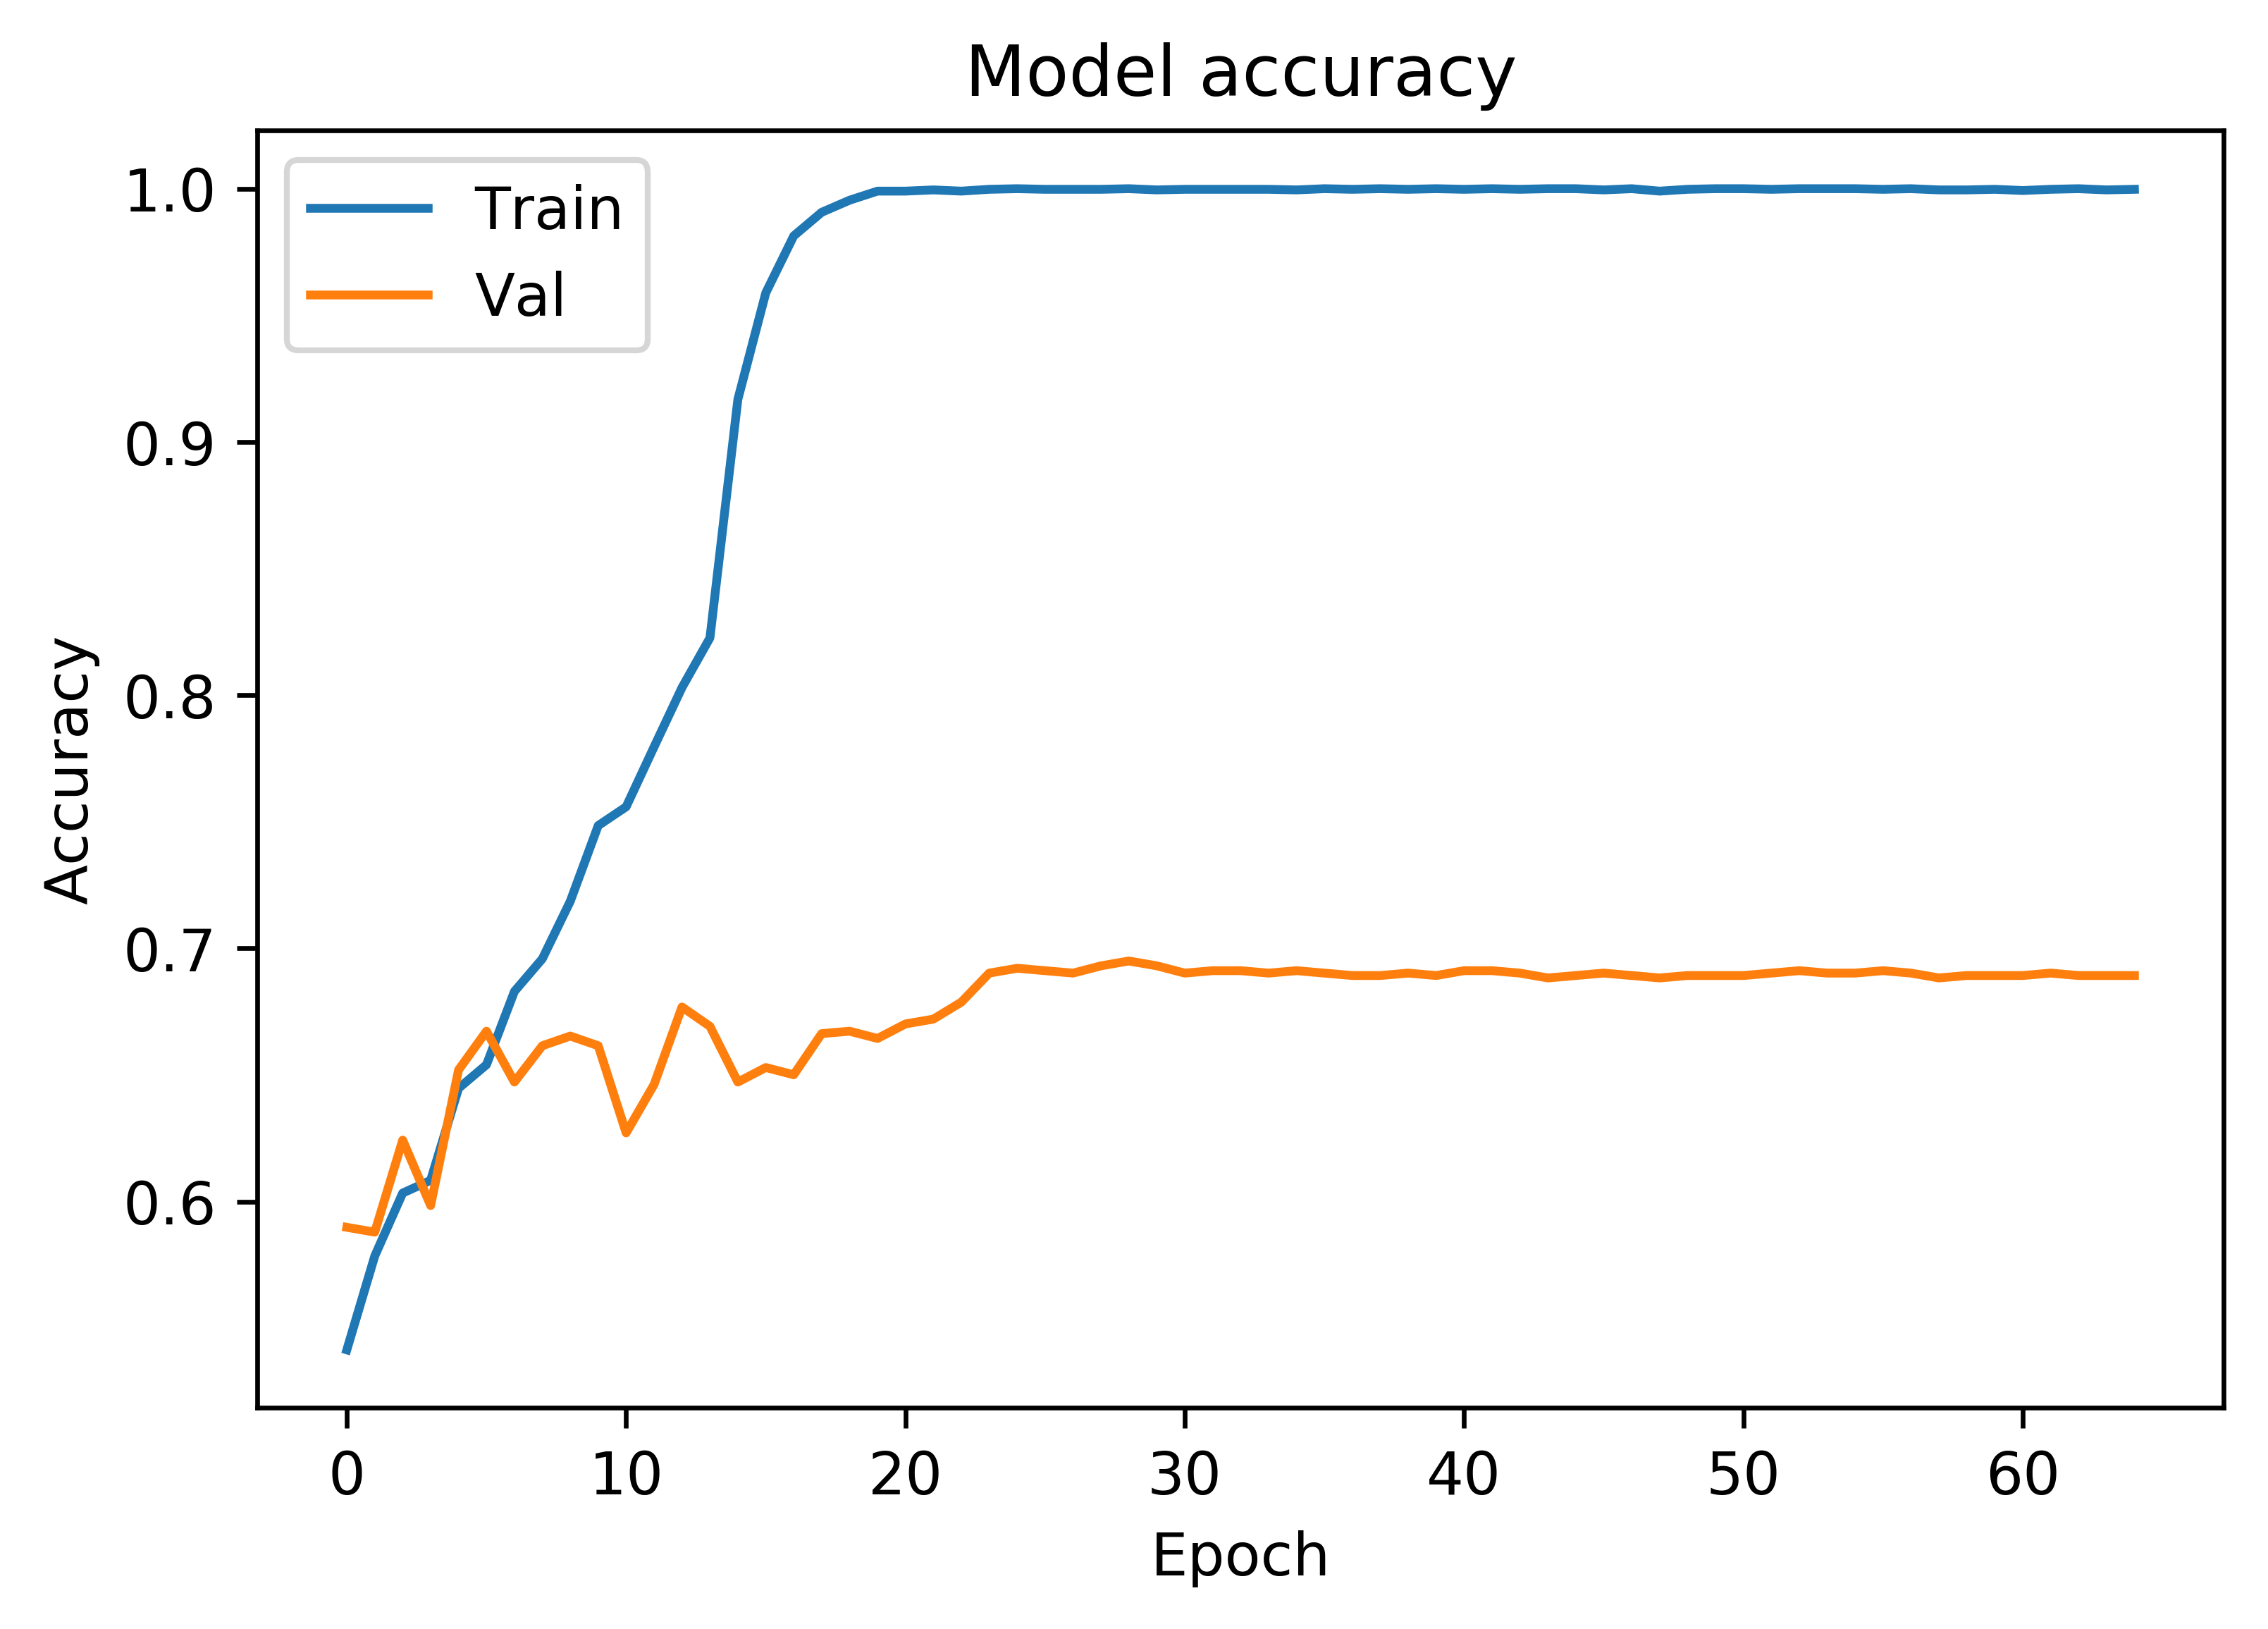

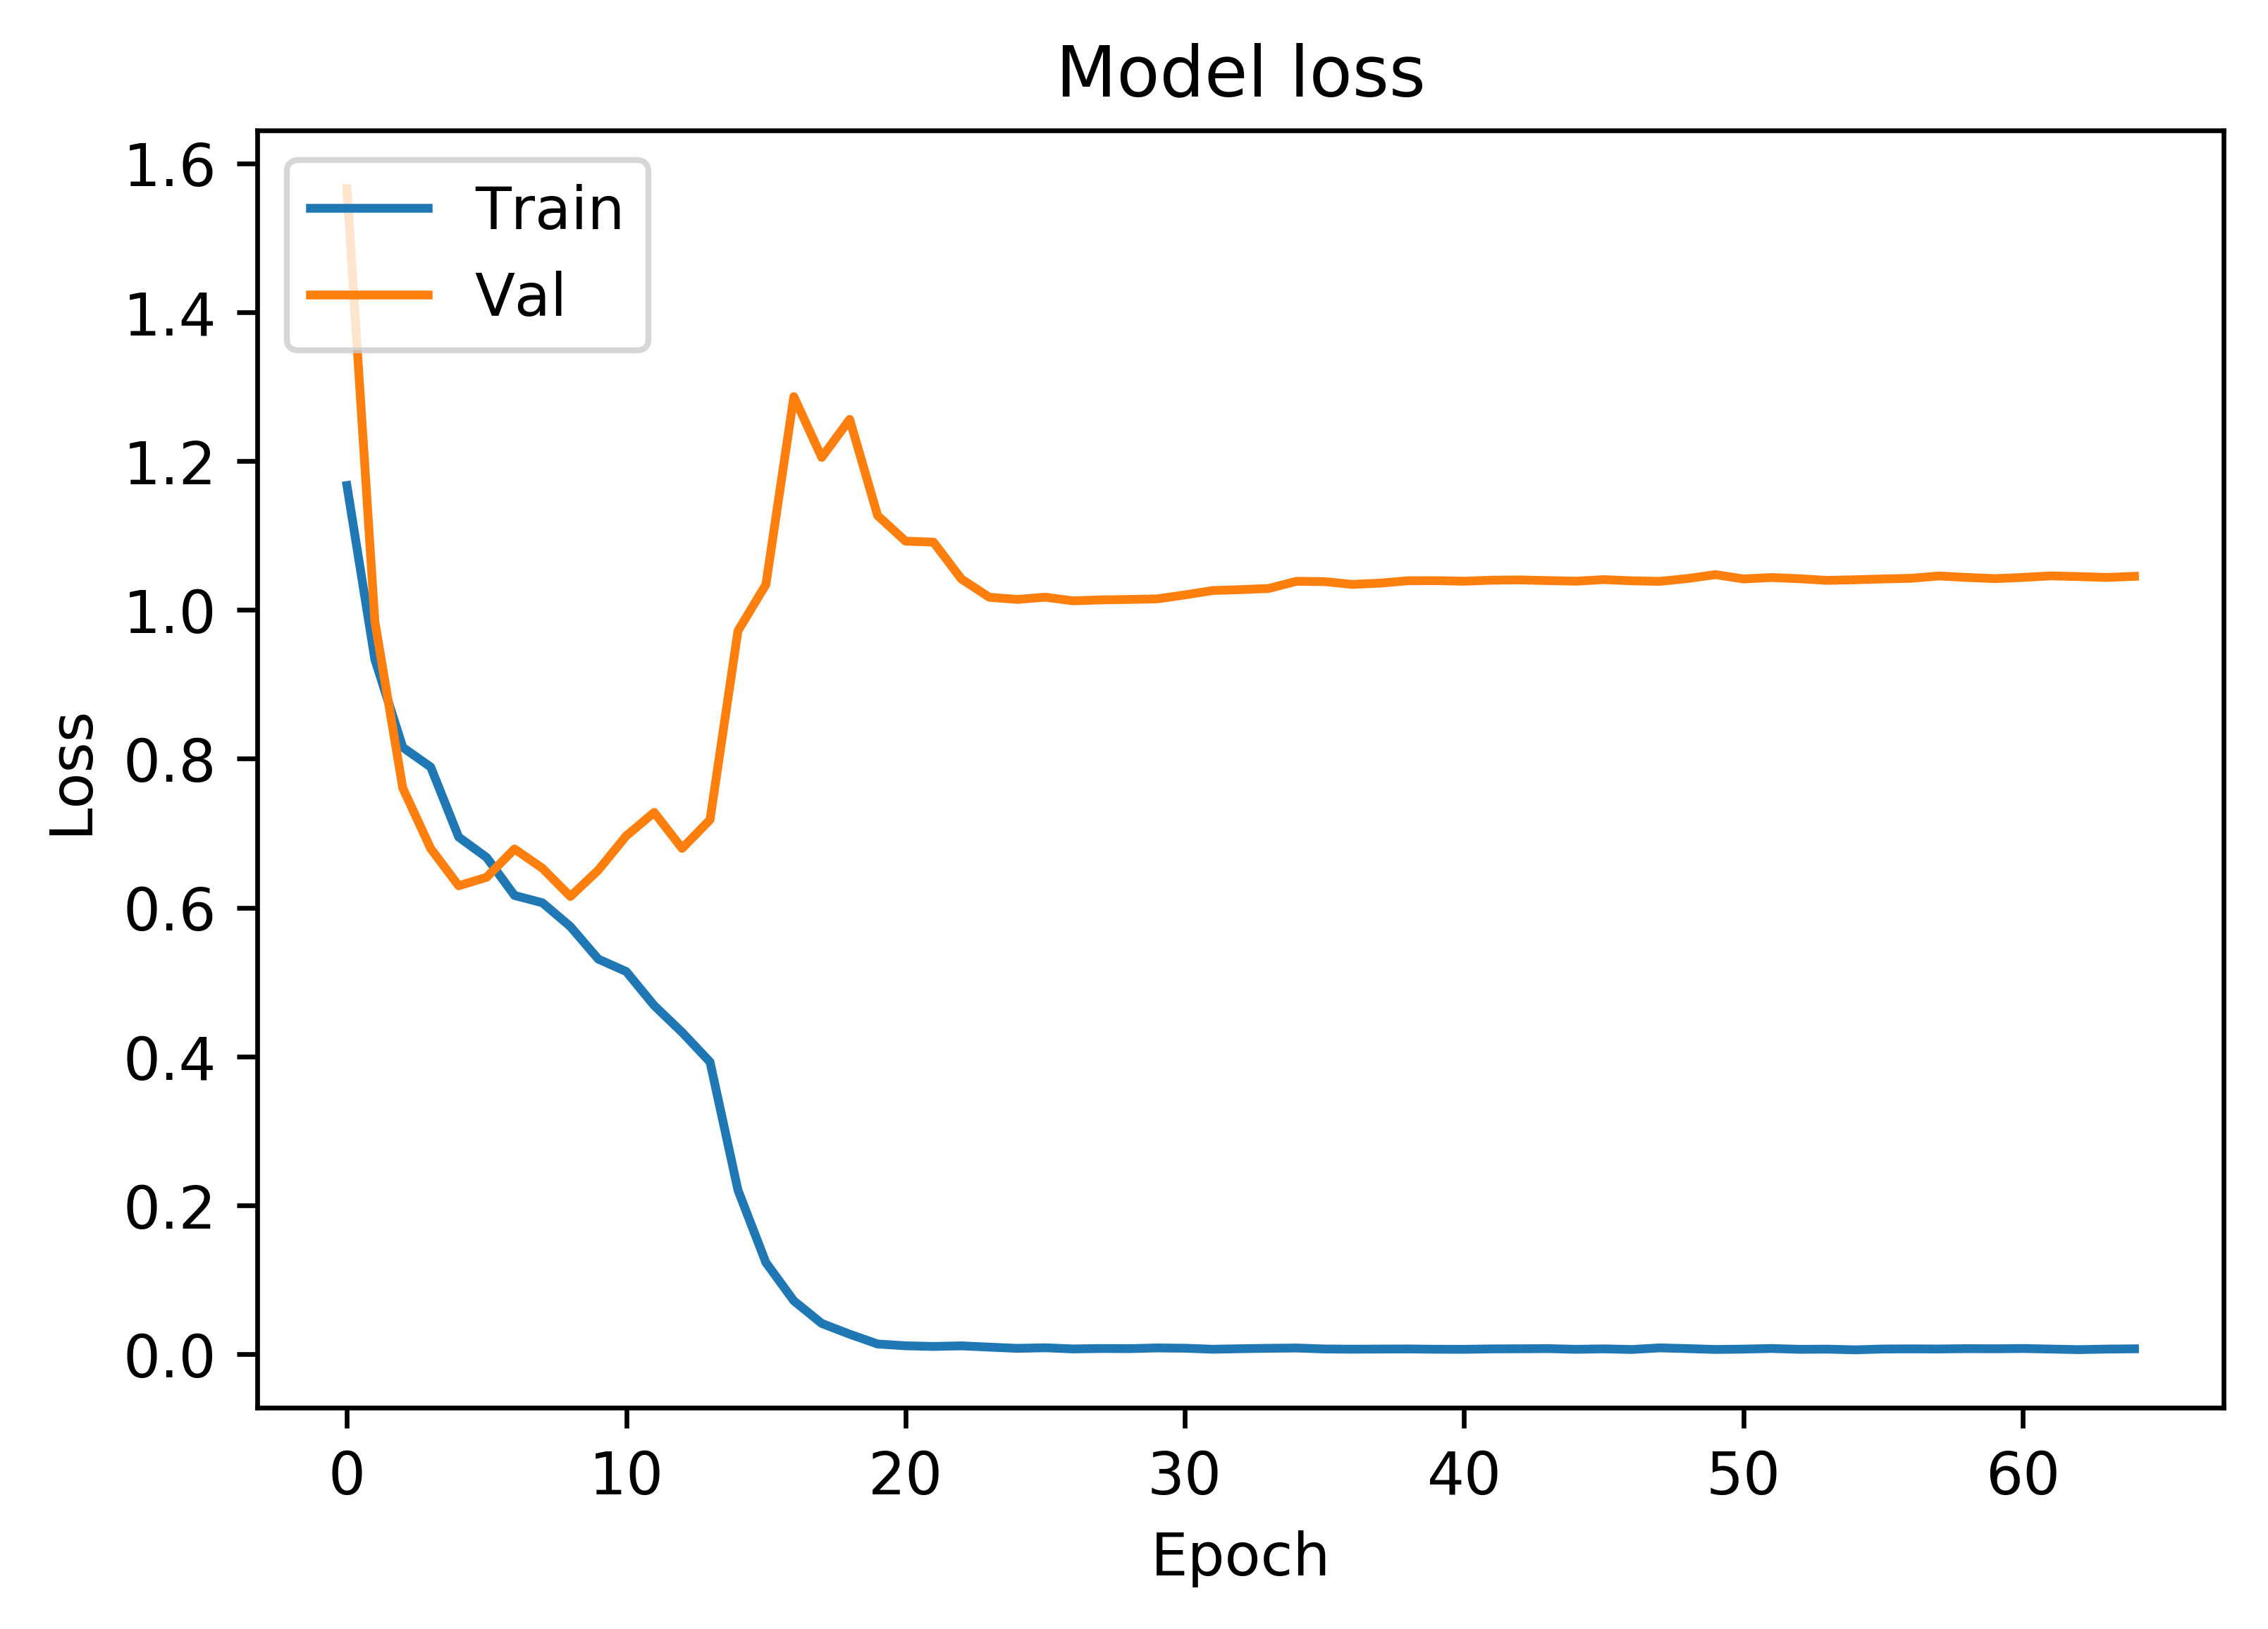

Results from K-fold: 3
acc: 68.93%
1046/1046 [==============================] - 1s 797us/step
[1.0450770649809682, 0.6892925427930989]
          normal  abnormal
normal       542       126
abnormal     199       179
              precision    recall  f1-score   support

      normal       0.73      0.81      0.77       668
    abnormal       0.59      0.47      0.52       378

   micro avg       0.69      0.69      0.69      1046
   macro avg       0.66      0.64      0.65      1046
weighted avg       0.68      0.69      0.68      1046

fold_4
K-: fold_4
Samples from Training
[3579  177 3127 5831]


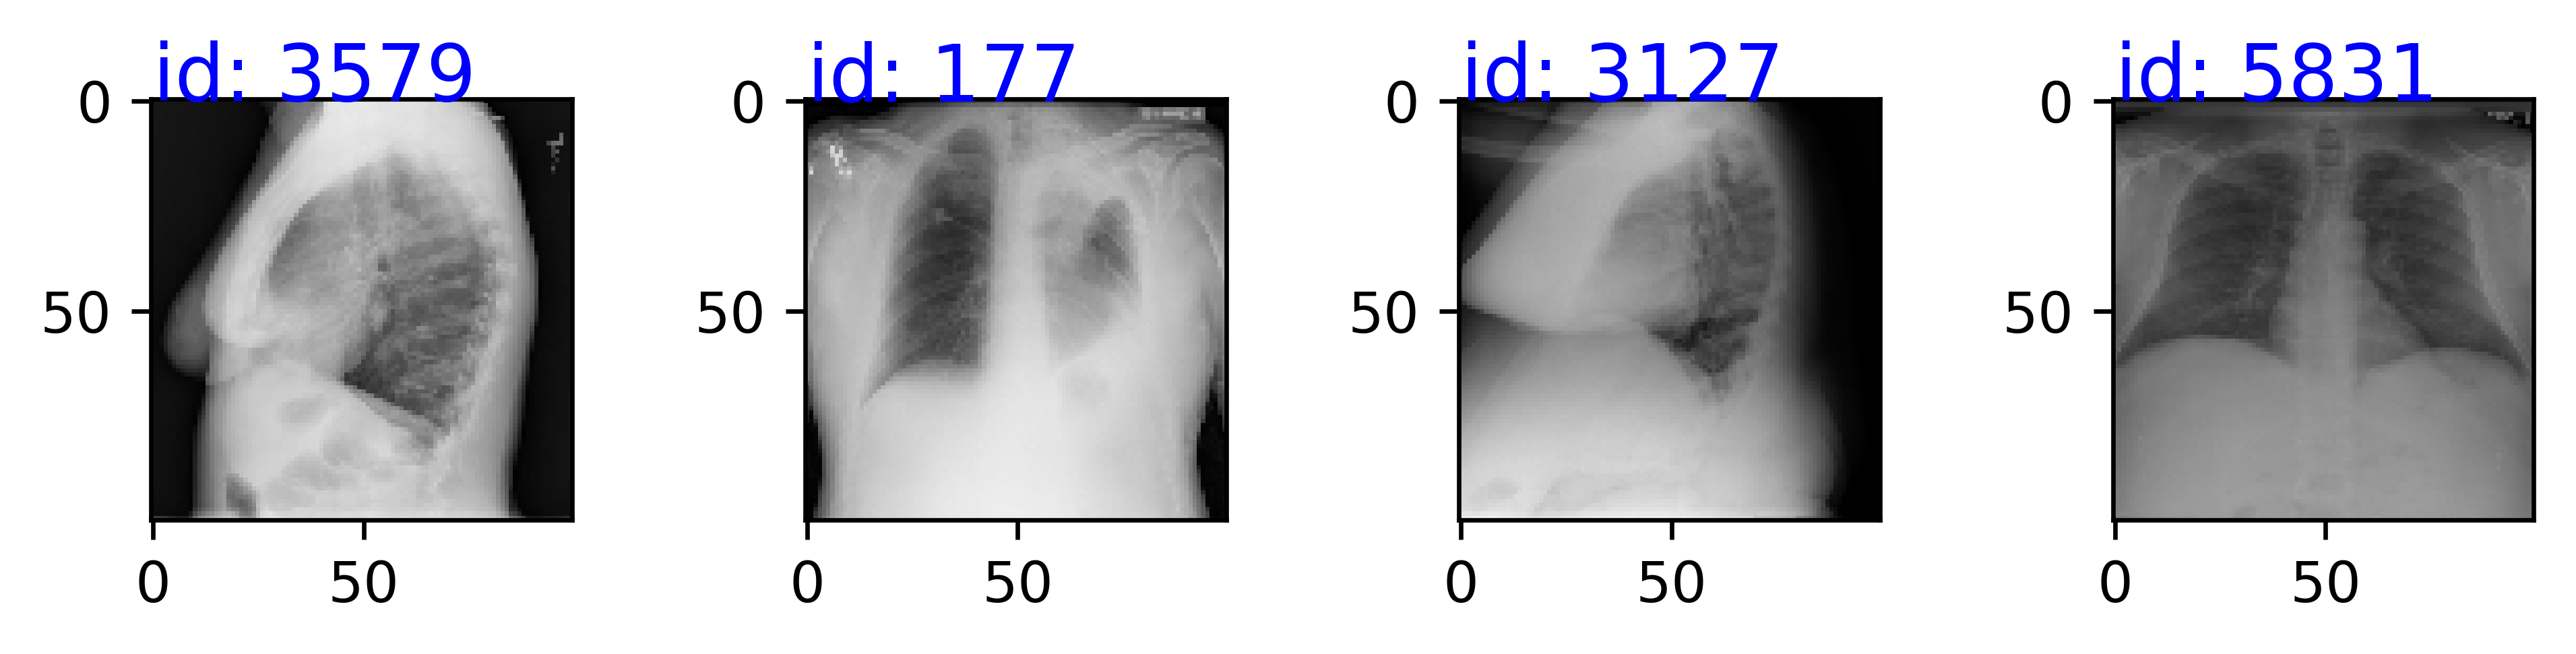

Samples from Validation
[6445 6373 4440 4538]


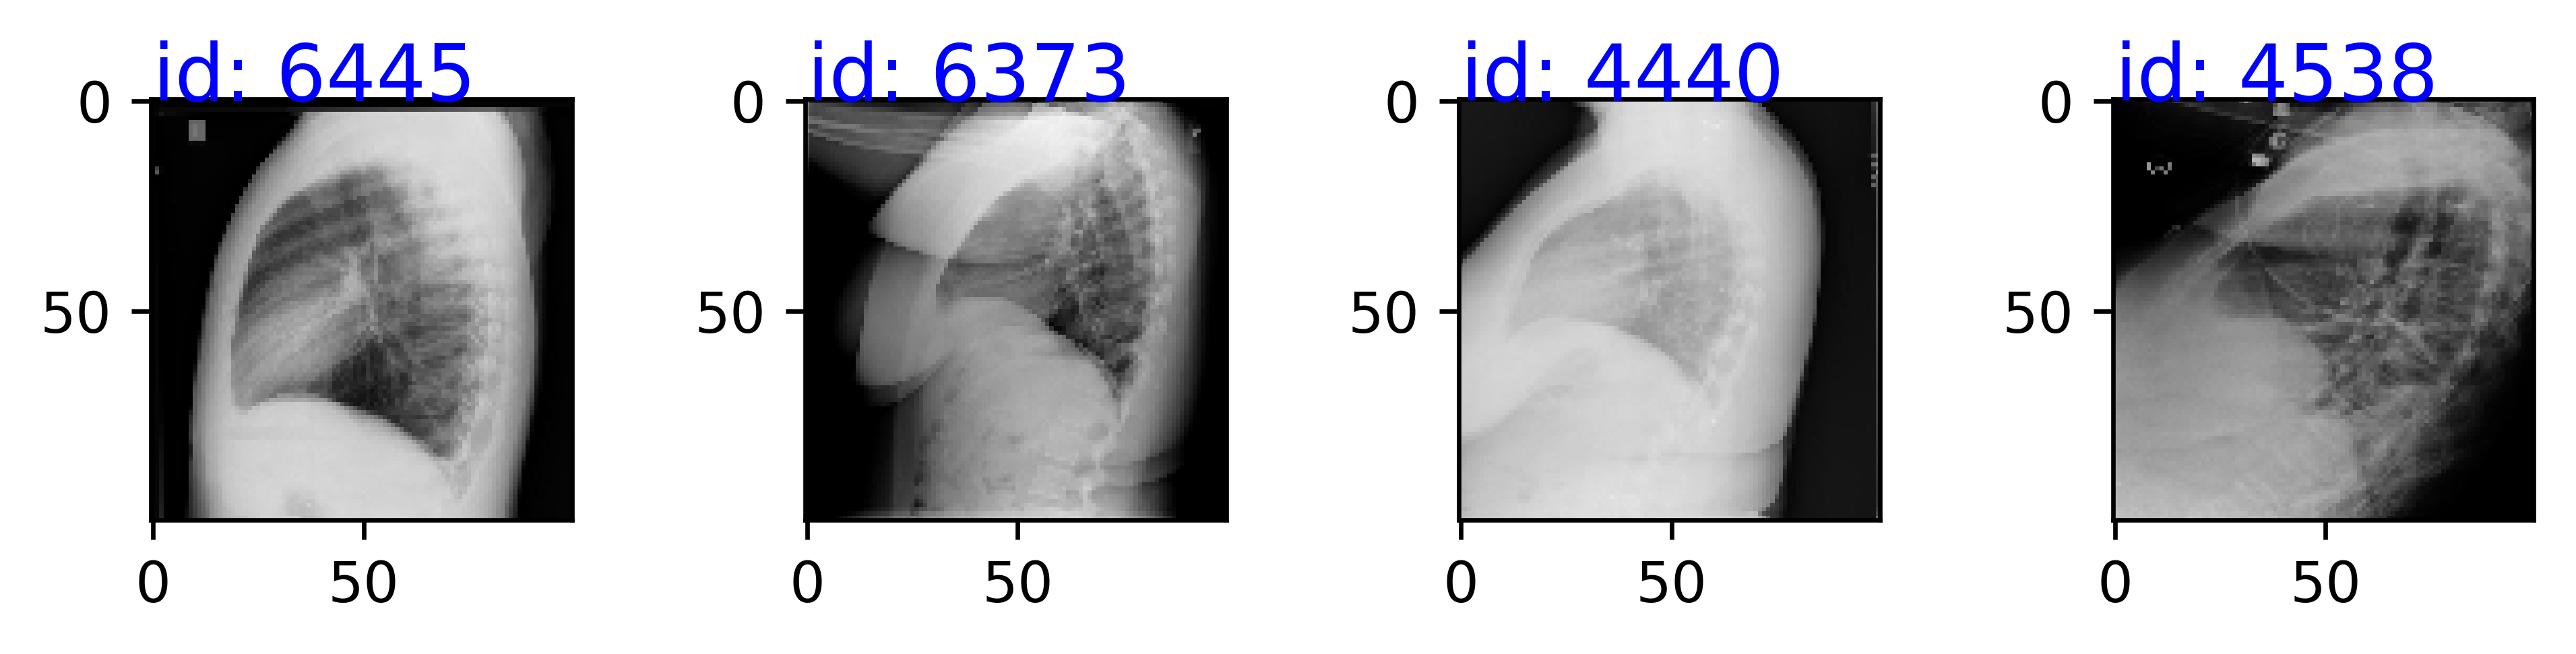

[INFO] training with 2 GPUs...
Train on 4184 samples, validate on 1045 samples
Epoch 1/150
4184/4184 [==============================] - 13s 3ms/step - loss: 1.1695 - acc: 0.5327 - val_loss: 0.9687 - val_acc: 0.6268

Epoch 00001: val_acc improved from -inf to 0.62679, saving model to unimodal_weights/best_weight_image_only_k-fold_4.hdf5
Epoch 2/150
4184/4184 [==============================] - 5s 1ms/step - loss: 0.9674 - acc: 0.5688 - val_loss: 1.0074 - val_acc: 0.6038

Epoch 00002: val_acc did not improve from 0.62679
Epoch 3/150
4184/4184 [==============================] - 5s 1ms/step - loss: 0.8498 - acc: 0.5880 - val_loss: 0.8582 - val_acc: 0.6287

Epoch 00003: val_acc improved from 0.62679 to 0.62871, saving model to unimodal_weights/best_weight_image_only_k-fold_4.hdf5
Epoch 4/150
4184/4184 [==============================] - 5s 1ms/step - loss: 0.7828 - acc: 0.6004 - val_loss: 0.8840 - val_acc: 0.5828

Epoch 00004: val_acc did not improve from 0.62871
Epoch 5/150
4184/4184 [======

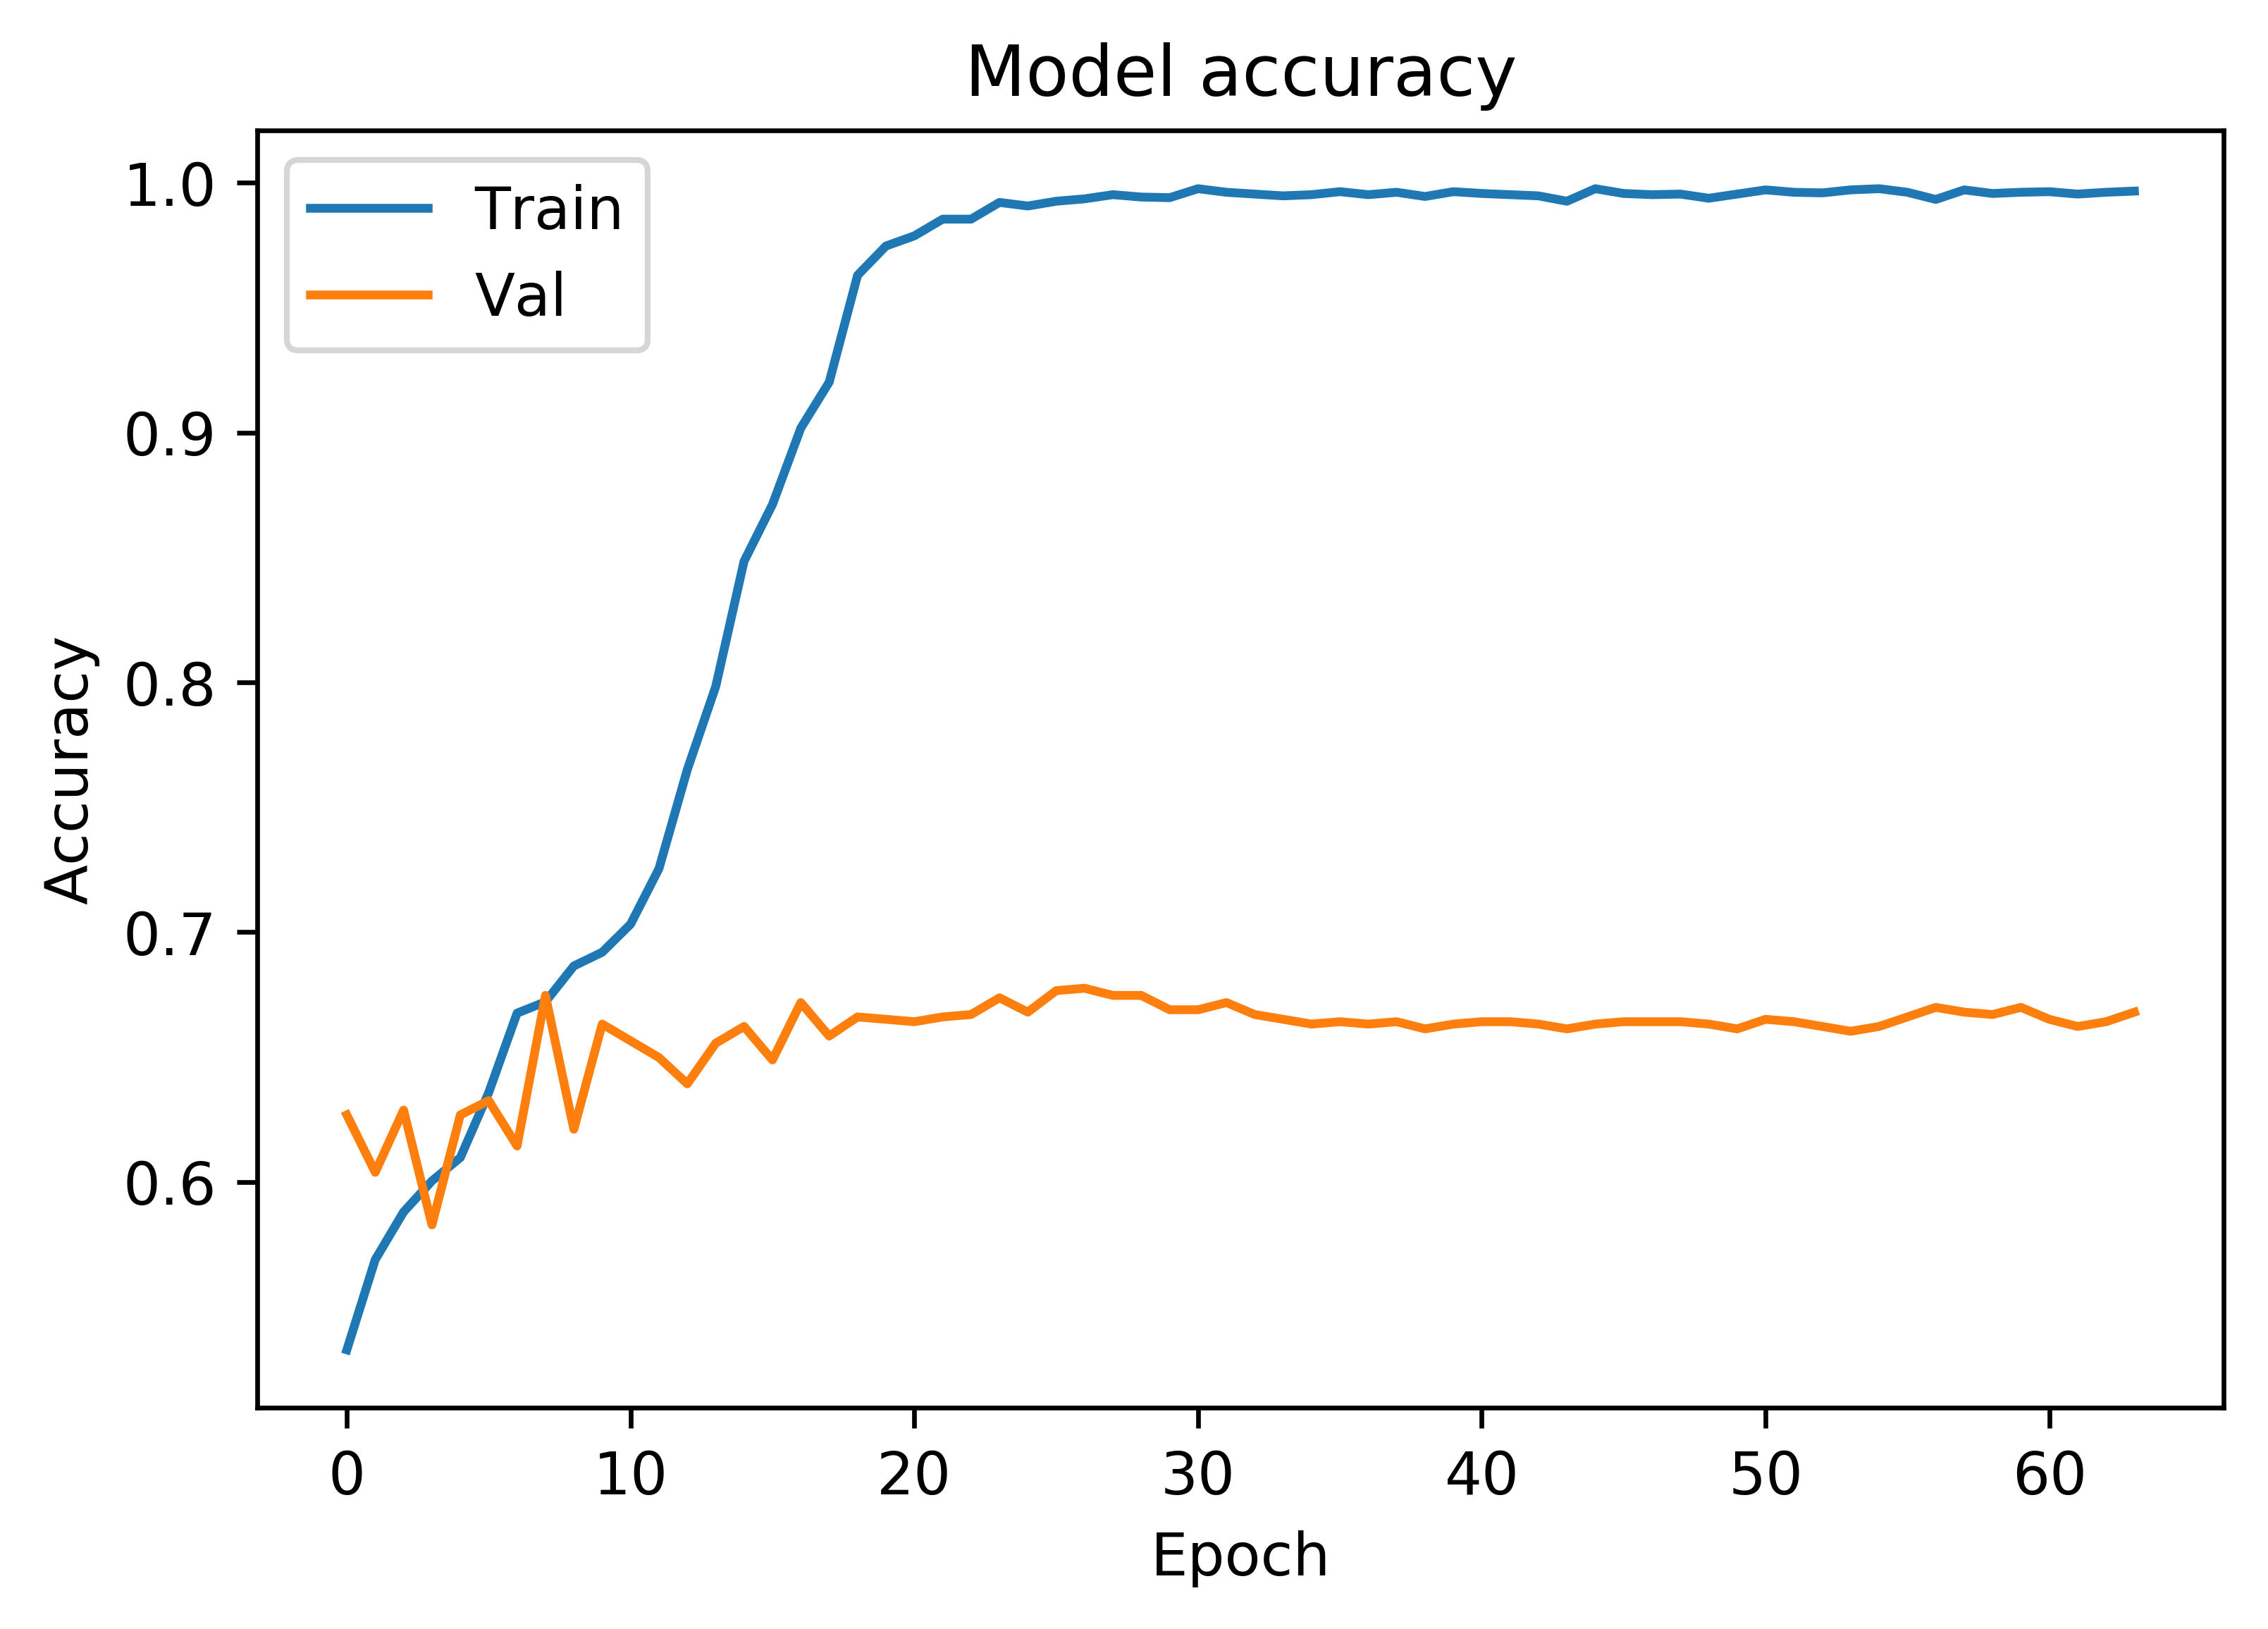

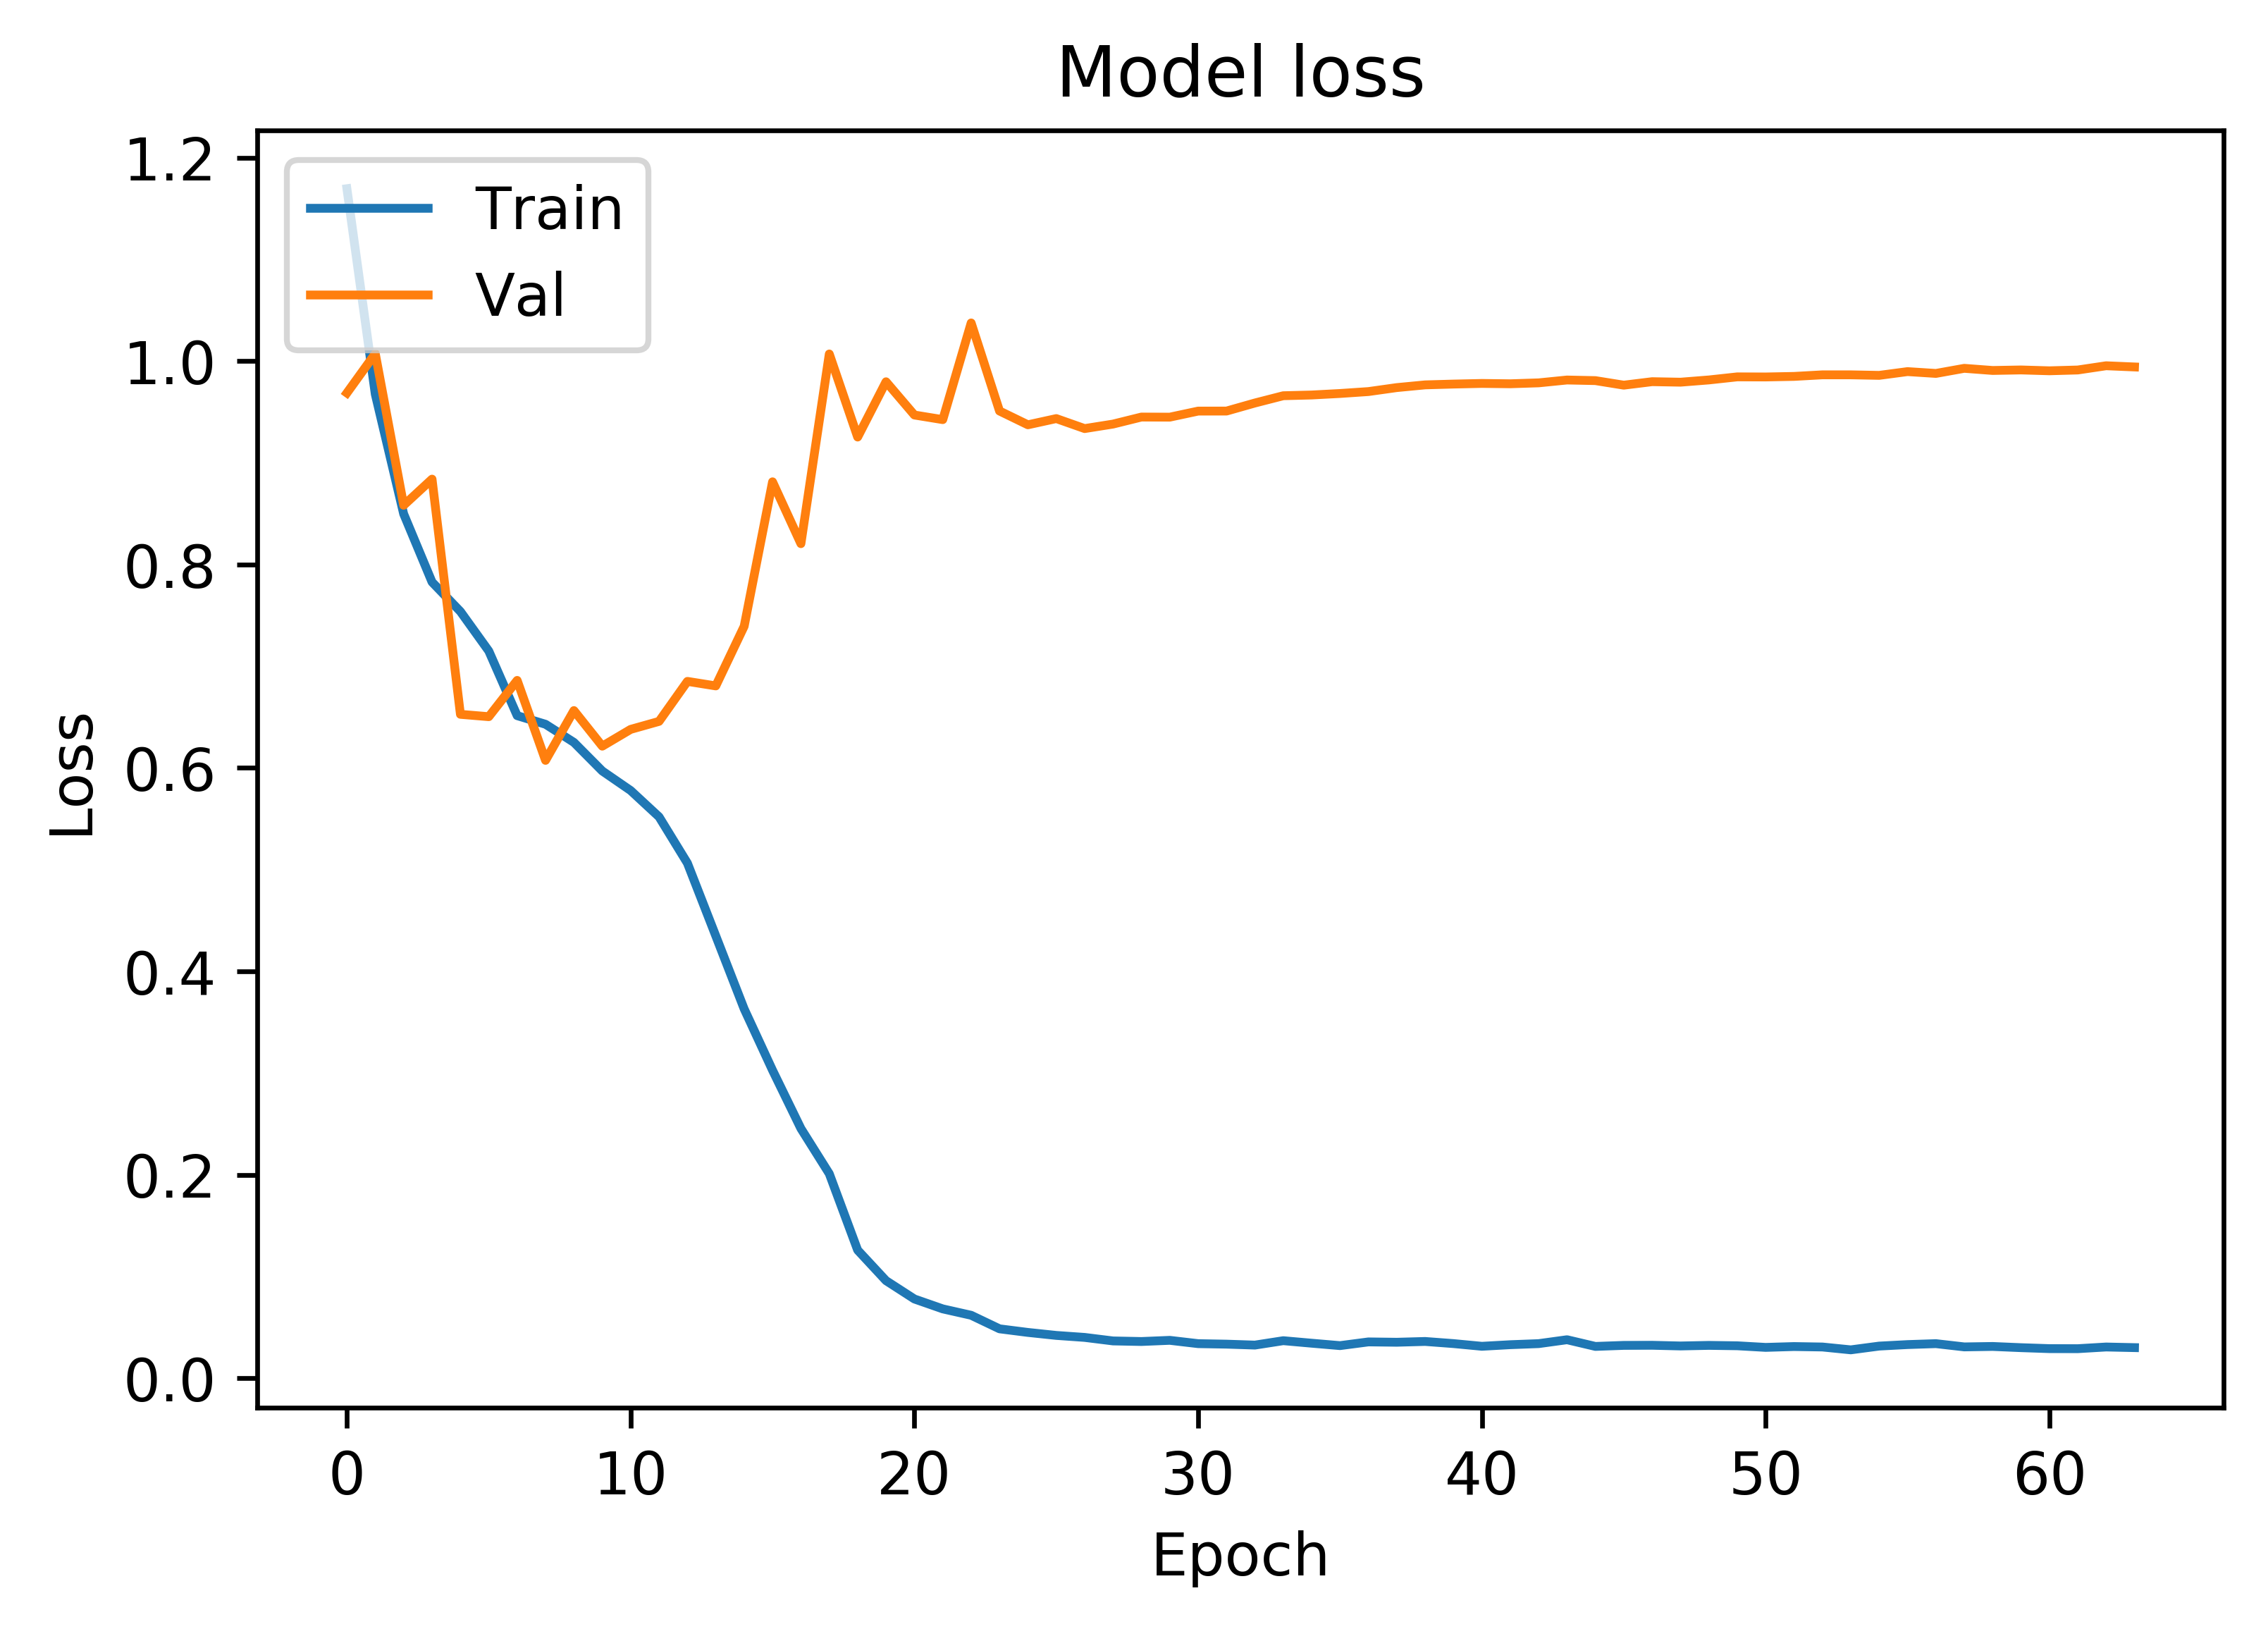

Results from K-fold: 4
acc: 66.79%
1045/1045 [==============================] - 1s 752us/step
[0.9942483103446413, 0.6679425840172472]
          normal  abnormal
normal       538       130
abnormal     217       160
              precision    recall  f1-score   support

      normal       0.71      0.81      0.76       668
    abnormal       0.55      0.42      0.48       377

   micro avg       0.67      0.67      0.67      1045
   macro avg       0.63      0.61      0.62      1045
weighted avg       0.65      0.67      0.66      1045

fold_5
K-: fold_5
Samples from Training
[5822 5097 4853 3579]


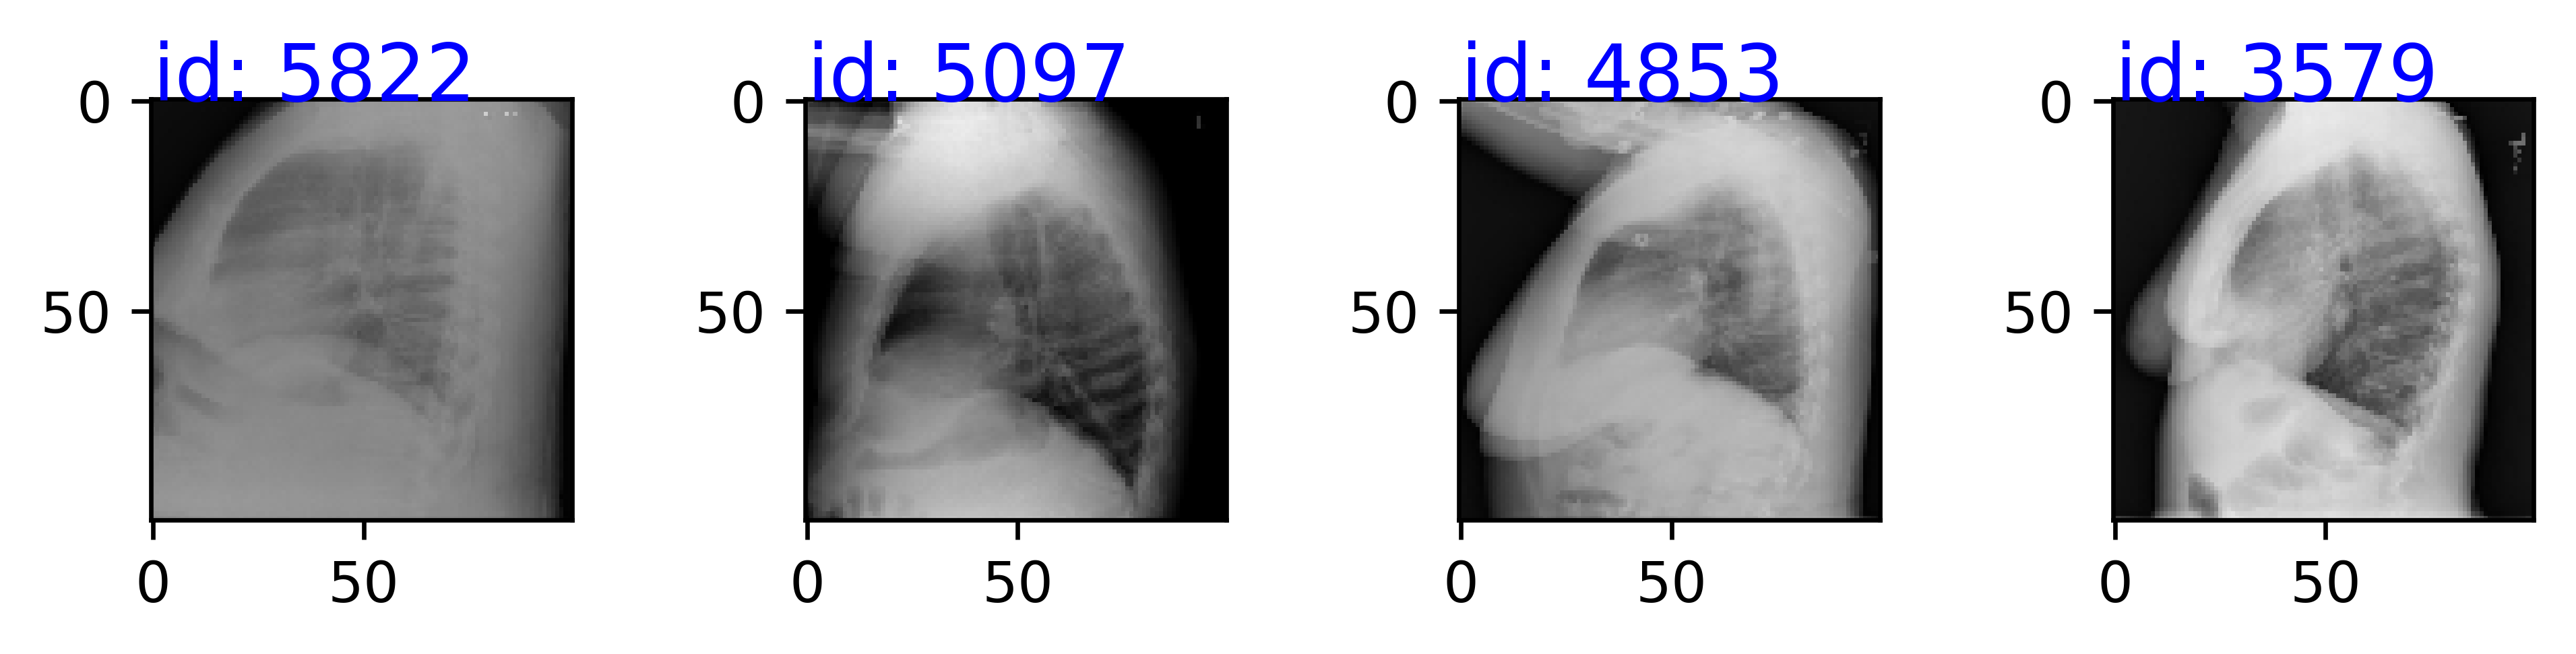

Samples from Validation
[5484 1029 4698 6262]


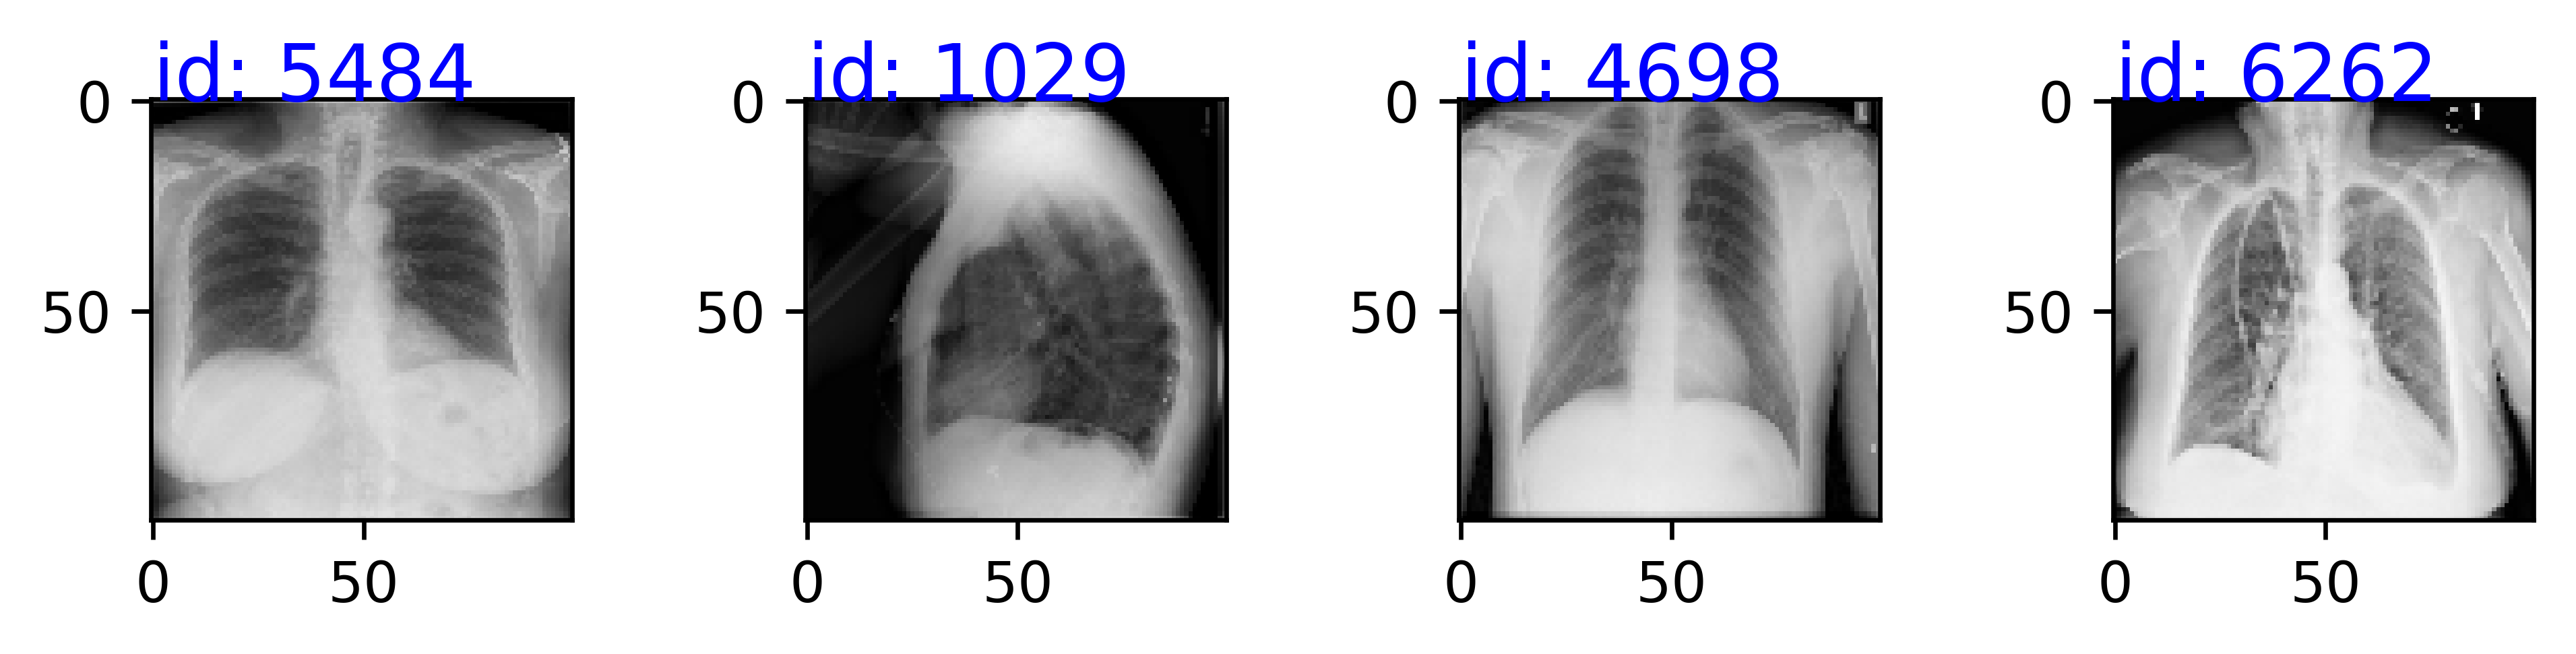

[INFO] training with 2 GPUs...
Train on 4184 samples, validate on 1045 samples
Epoch 1/150
4184/4184 [==============================] - 12s 3ms/step - loss: 1.1503 - acc: 0.5430 - val_loss: 2.6412 - val_acc: 0.6383

Epoch 00001: val_acc improved from -inf to 0.63828, saving model to unimodal_weights/best_weight_image_only_k-fold_5.hdf5
Epoch 2/150
4184/4184 [==============================] - 5s 1ms/step - loss: 0.9470 - acc: 0.5586 - val_loss: 1.1621 - val_acc: 0.6239

Epoch 00002: val_acc did not improve from 0.63828
Epoch 3/150
4184/4184 [==============================] - 5s 1ms/step - loss: 0.8328 - acc: 0.5815 - val_loss: 0.7322 - val_acc: 0.5933

Epoch 00003: val_acc did not improve from 0.63828
Epoch 4/150
4184/4184 [==============================] - 5s 1ms/step - loss: 0.7772 - acc: 0.5968 - val_loss: 0.6958 - val_acc: 0.6067

Epoch 00004: val_acc did not improve from 0.63828
Epoch 5/150
4184/4184 [==============================] - 5s 1ms/step - loss: 0.7007 - acc: 0.6322 - val_

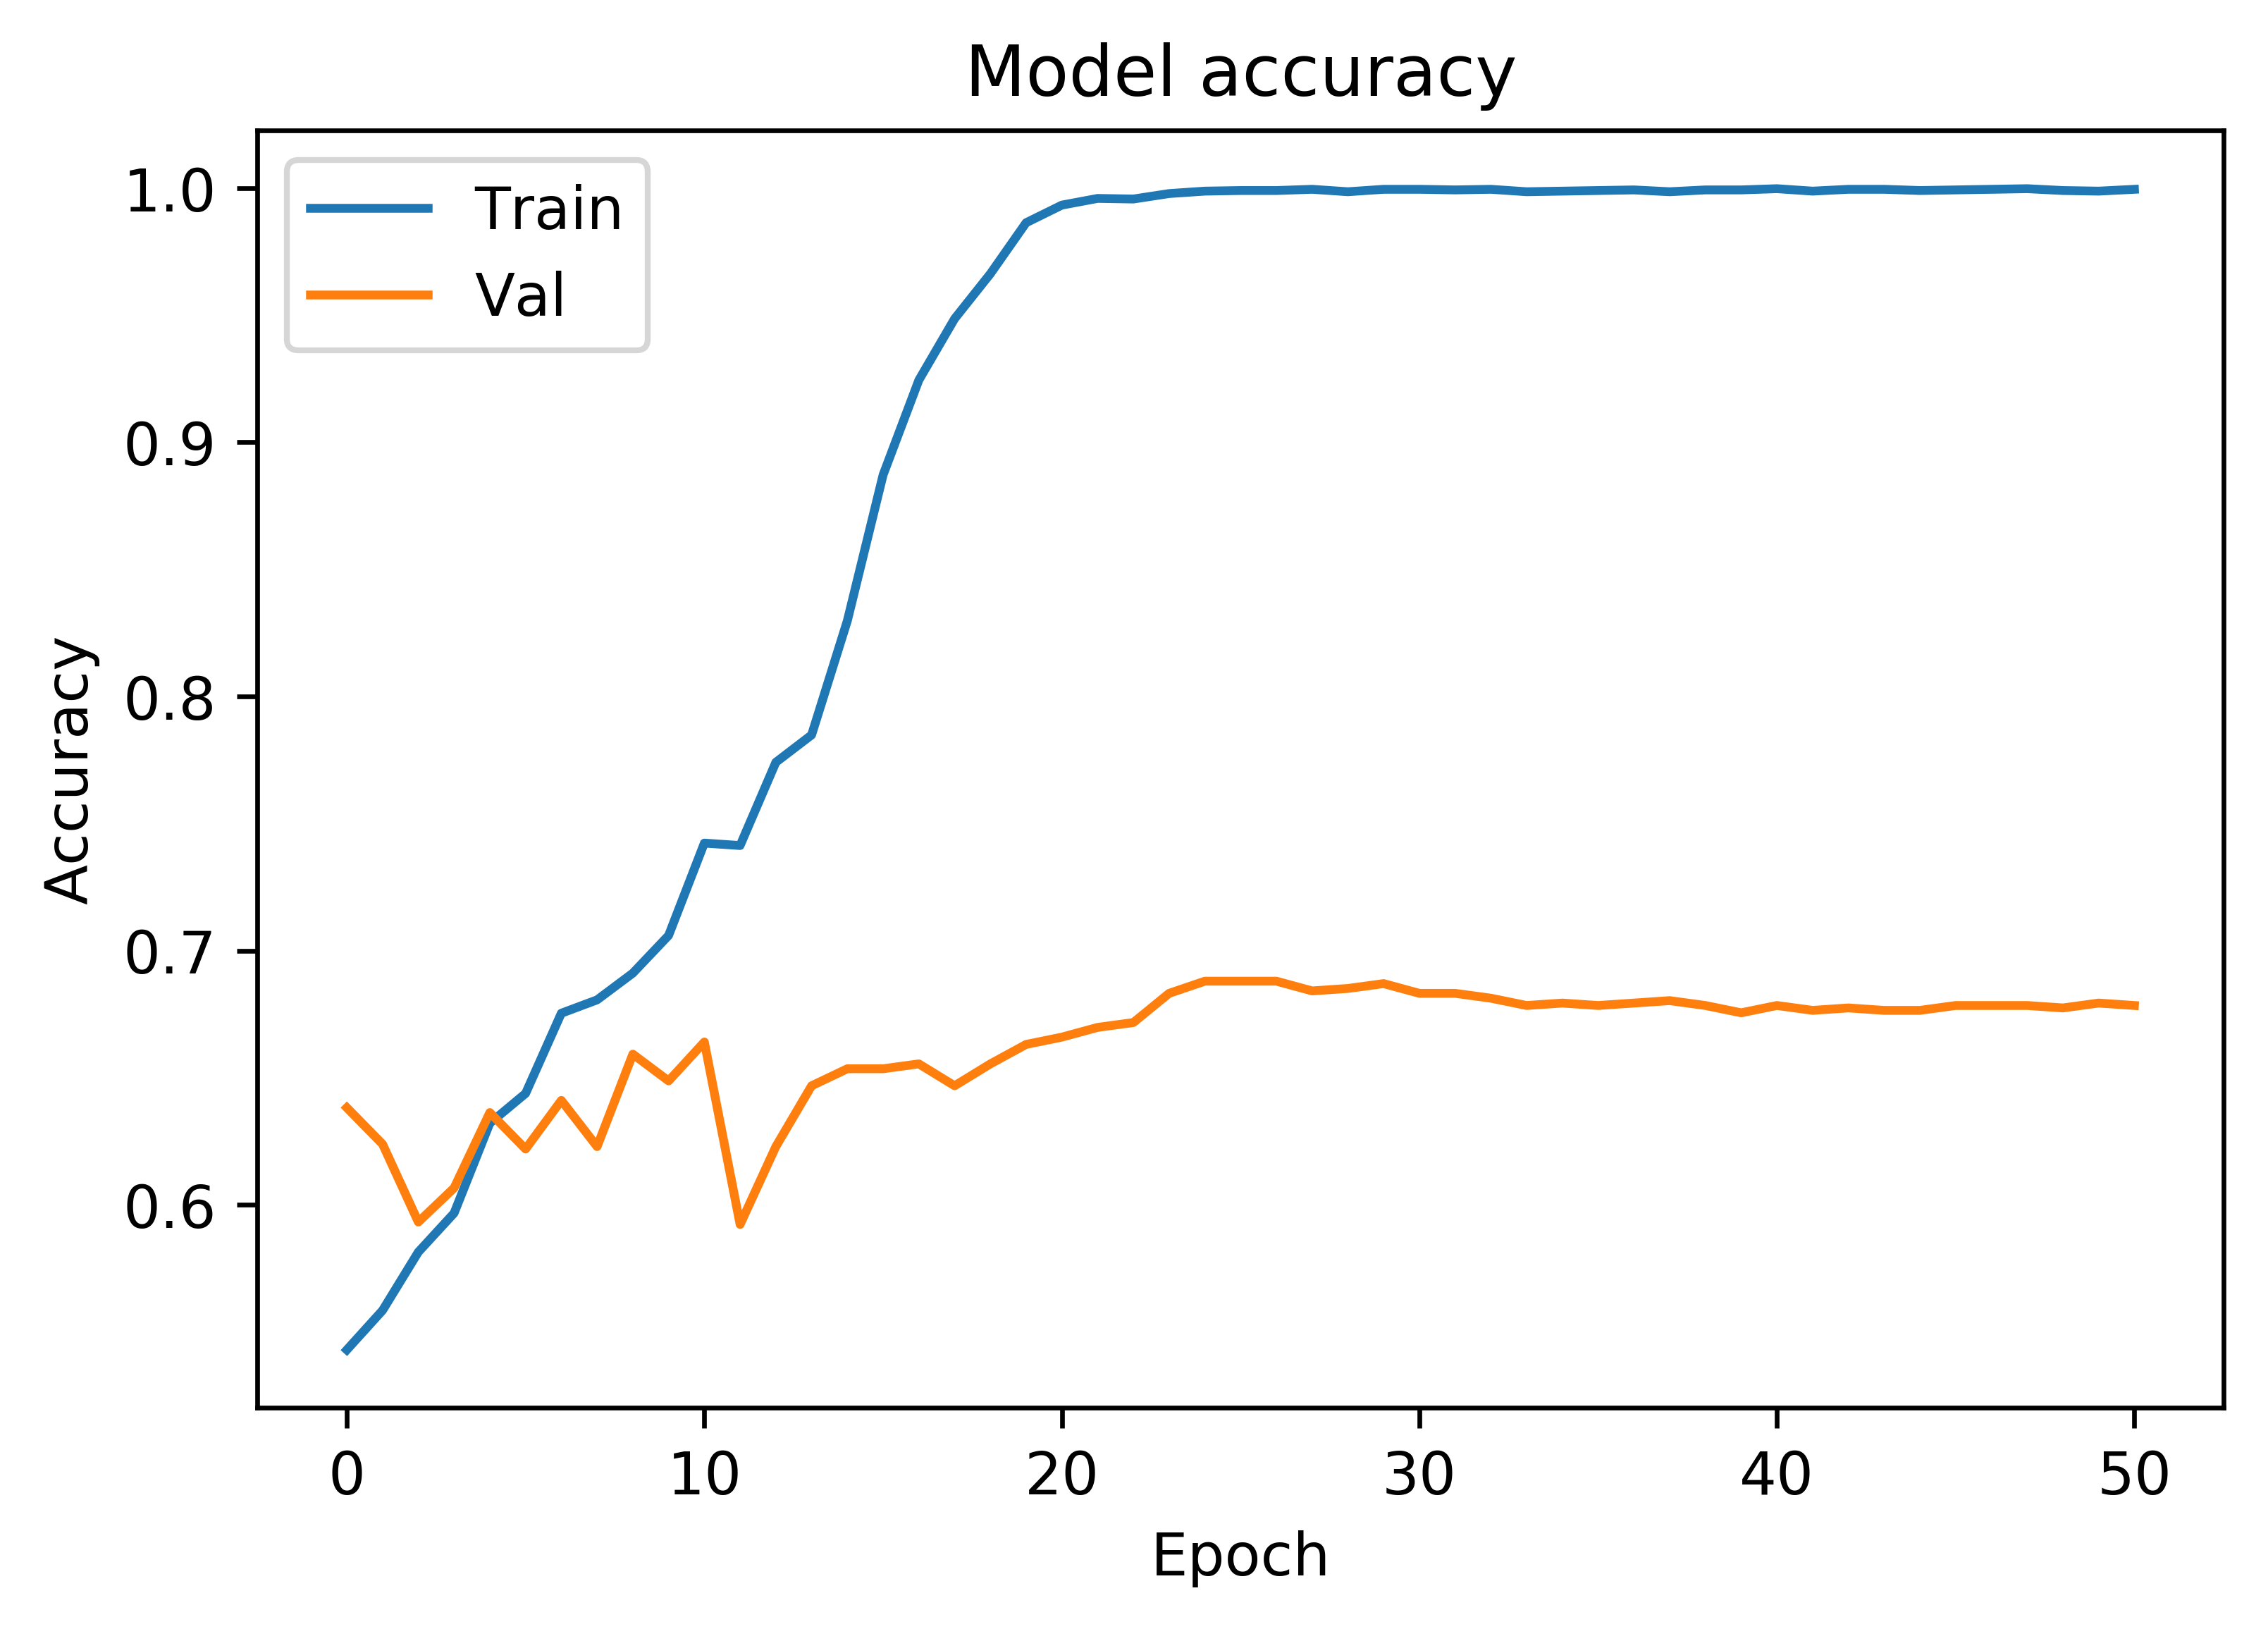

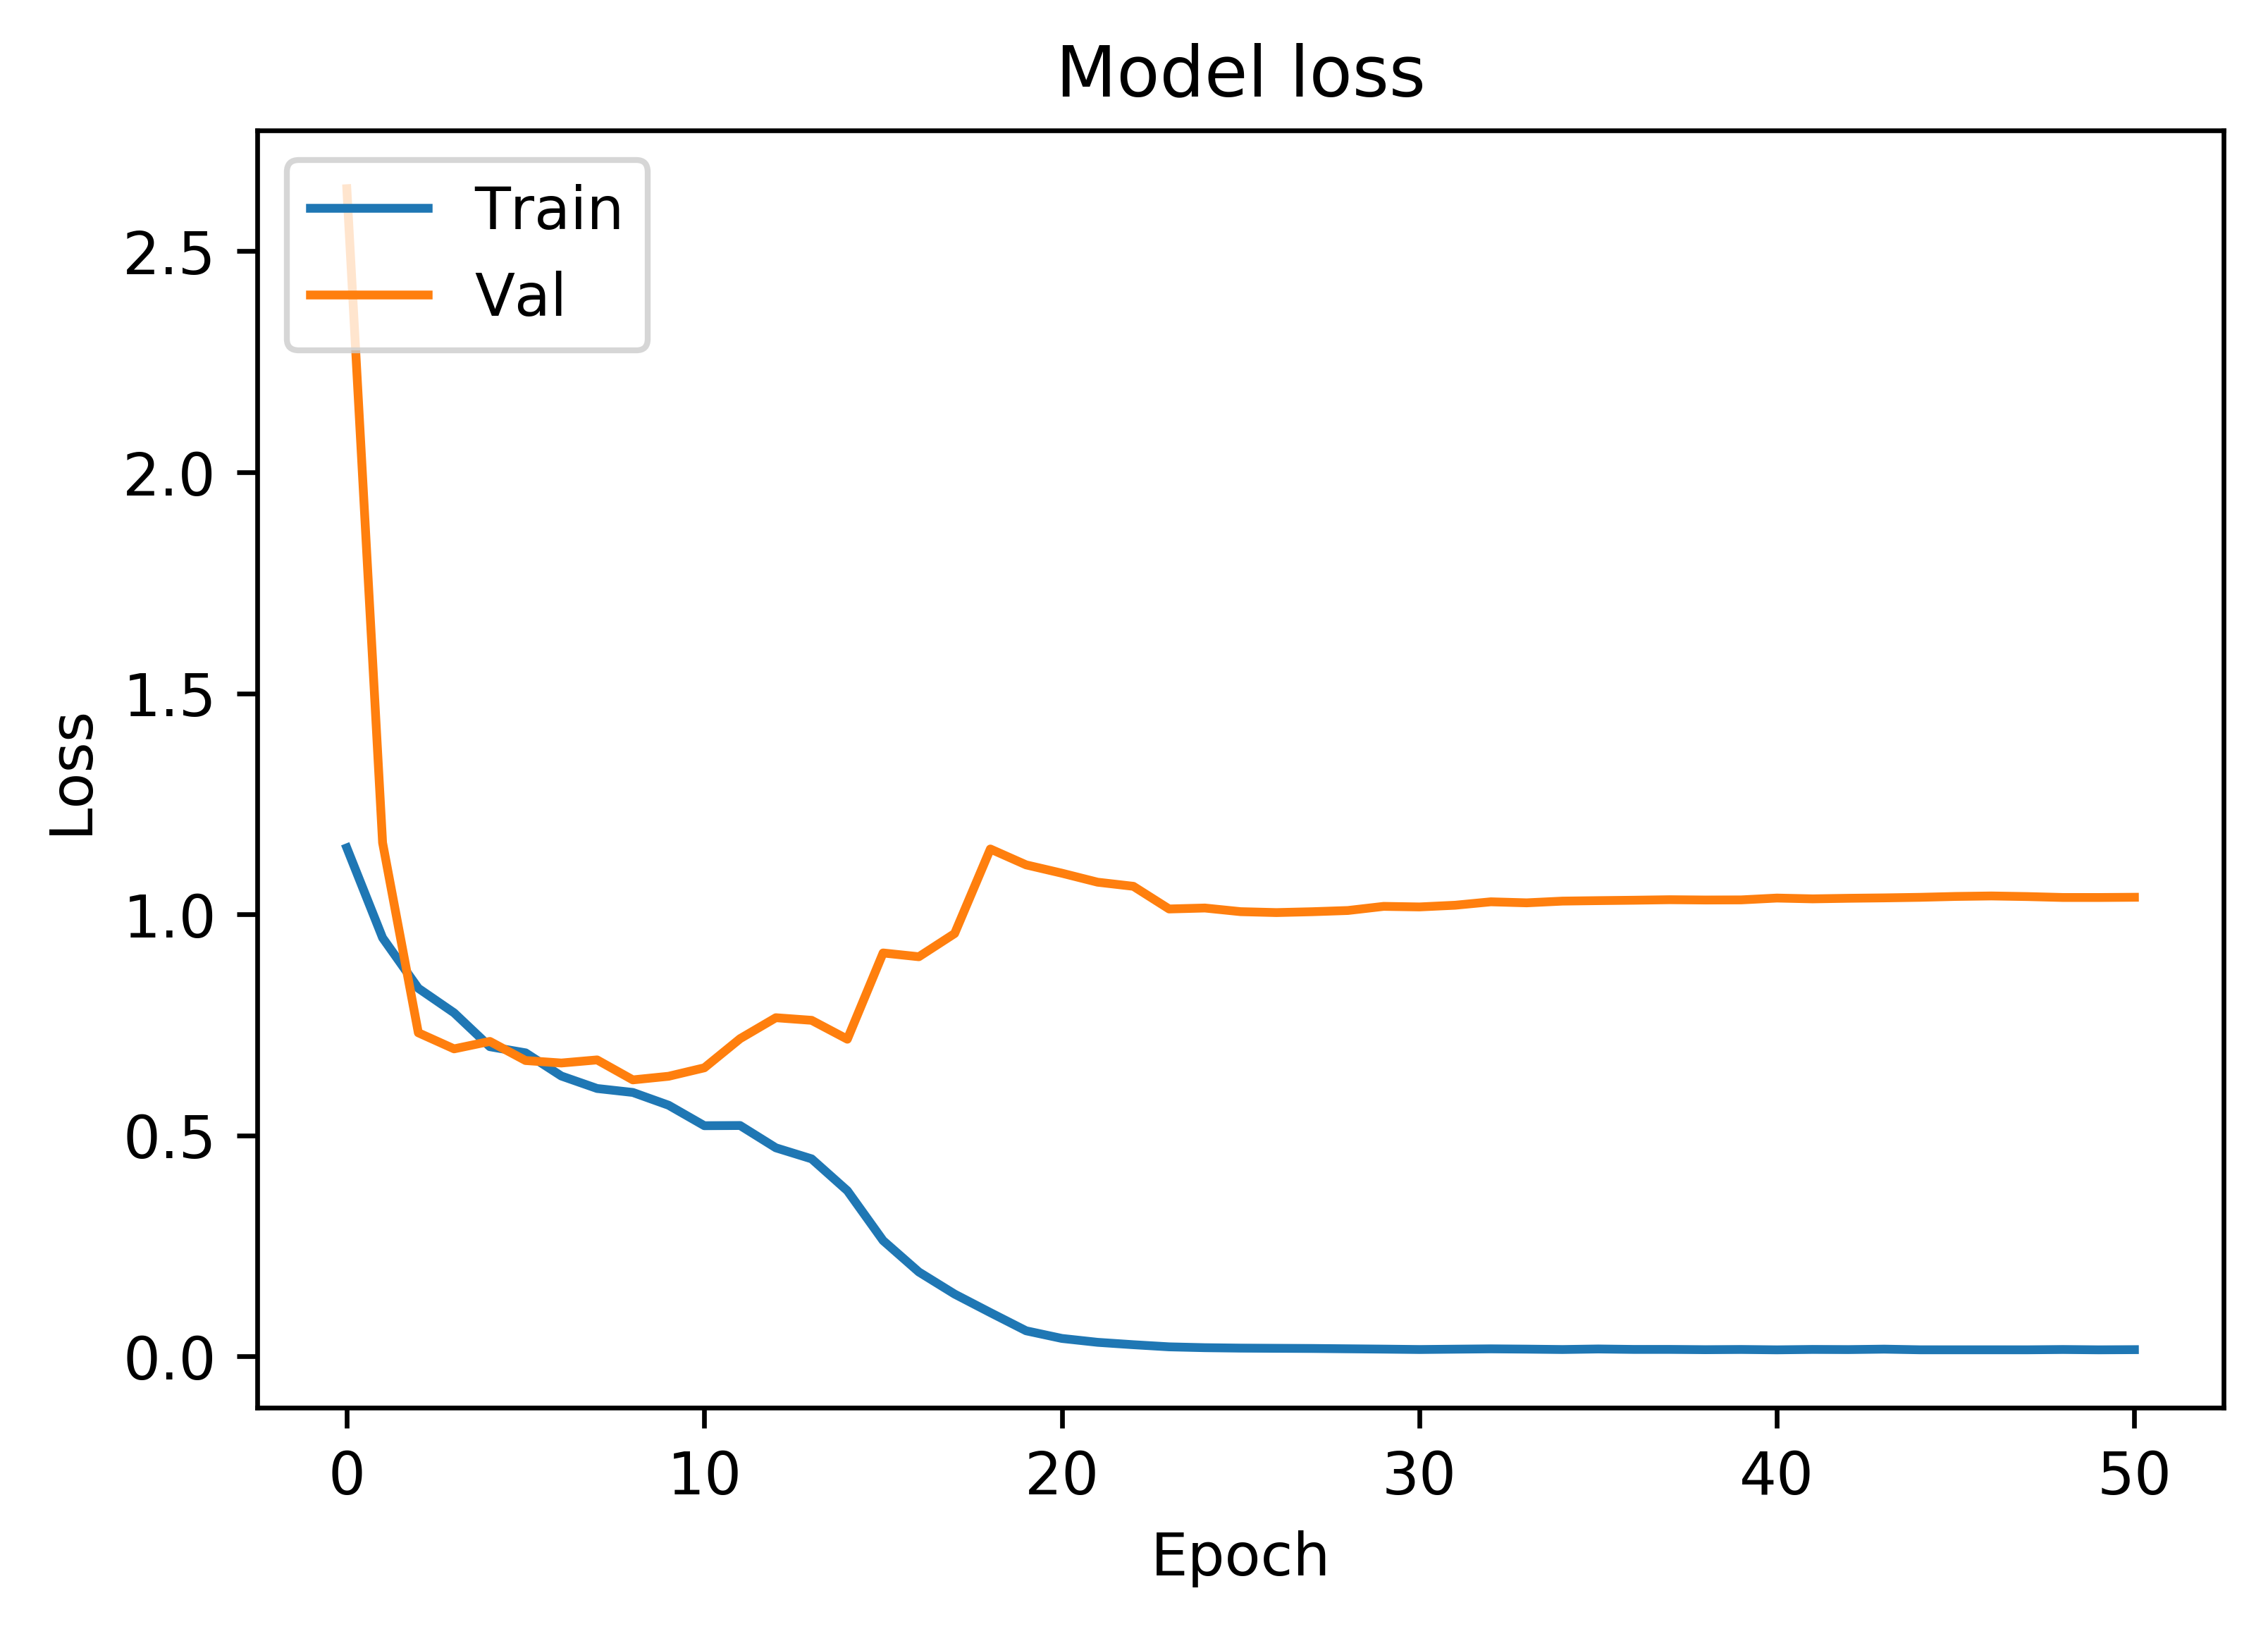

Results from K-fold: 5
acc: 67.85%
1045/1045 [==============================] - 1s 728us/step
[1.0386432123526432, 0.6784688998637587]
          normal  abnormal
normal       537       131
abnormal     205       172
              precision    recall  f1-score   support

      normal       0.72      0.80      0.76       668
    abnormal       0.57      0.46      0.51       377

   micro avg       0.68      0.68      0.68      1045
   macro avg       0.65      0.63      0.63      1045
weighted avg       0.67      0.68      0.67      1045

Average for kfold accuracy and stdev
68.12% (+/- 0.77%)
Average classification report for all folds
              precision  recall  f1_score  support
class                                             
abnormal          0.572   0.468     0.516    377.6
macro_avg         0.650   0.632     0.640   1045.8
micro_avg         0.682   0.682     0.682   1045.8
normal            0.726   0.802     0.764    668.2
weighted_avg      0.672   0.682     0.674   1045.8


In [16]:
#set K folds to 5
#could do this: https://github.com/keras-team/keras/issues/2607#issuecomment-260560602
cvscores = []
count = 1
confusion_matrix_list = []
report_list = []

for key, kfold in kfolds.items():
    print(key)
    train = kfold['train']
    val = kfold['valid']
    
    print('K-: {}'.format(key))
            
    print("Samples from Training")
    print_samples(samples=train, images=X_image)
    print("============================")
    
    print("Samples from Validation")
    print_samples(samples=val, images=X_image)
    print("============================")
    
    image_model = Generate_Model(model_type = "image")
    image_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    filepath="unimodal_weights/best_weight_image_only_k-fold_{}.hdf5".format(count)
    checkpoint = MultiGPUCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [reduce_lr, checkpoint, early_stopping]
    #pass in validation data from kfold split
    history = image_model.fit([X_image[train]], y[train], 
                     epochs=epochs, batch_size=bs, validation_data=([X_image[val]], y[val]), 
                     callbacks=callbacks_list)
    plot_model_history(history)
    filepath="unimodal_weights/final_weight_image_only_k-fold_{}.hdf5".format(count)
    image_model.save_weights(filepath)
    scores = image_model.evaluate([X_image[val]], y[val], verbose=0)
    print('Results from K-fold: {}'.format(count))
    print("%s: %.2f%%" % (image_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    y_hat = test_model(image_model, zip(X_image[val], y[val]), image = True, text = False, 
                       class_names=class_names)
    cm = confusion_matrix([np.argmax(t) for t in y[val]], y_hat)
    confusion_matrix_list.append(pd.DataFrame(cm, index=class_names, columns=class_names))
    cr = classification_report([np.argmax(t) for t in y[val]], y_hat, target_names=class_names)
    report_list.append(classification_report_df(cr))
    count += 1
    print('================================================')
print('Average for kfold accuracy and stdev')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("Average classification report for all folds")
print(df_mean(report_list))

### Hold out method on 2/3 training data and 1/3 testing data - Image only

In [17]:
'''
TODO: Train model on full training dataset, test on test set to get valid accuracy, 
not sure why we are doing CV anymore?
'''
reduce_lr_final = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

image_model = Generate_Model(model_type = "image")
image_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
filepath="unimodal_weights/best_weight_image_only_final.hdf5"
checkpoint = MultiGPUCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [reduce_lr_final, checkpoint, early_stopping]

history = image_model.fit([X_image[final_train]], y[final_train], 
                 epochs=epochs, batch_size=bs, validation_split=None, callbacks=callbacks_list)
#plot_model_history(history)
filepath="unimodal_weights/final_weight_image_only_final.hdf5"
image_model.save_weights(filepath)
print('========================TEST MODEL=======================')
scores = image_model.evaluate([X_image[final_test]], y[final_test], verbose=0)
print("%s: %.2f%%" % (image_model.metrics_names[1], scores[1]*100))
y_hat = test_model(image_model, zip(X_image[final_test], y[final_test]), image = True, text = False, 
                       class_names=class_names)

[INFO] training with 2 GPUs...
Epoch 1/150
5229/5229 [==============================] - 13s 2ms/step - loss: 1.1805 - acc: 0.5412

Epoch 00001: acc improved from -inf to 0.54121, saving model to unimodal_weights/best_weight_image_only_final.hdf5
Epoch 2/150
5229/5229 [==============================] - 6s 1ms/step - loss: 0.9150 - acc: 0.5707

Epoch 00002: acc improved from 0.54121 to 0.57066, saving model to unimodal_weights/best_weight_image_only_final.hdf5
Epoch 3/150
5229/5229 [==============================] - 6s 1ms/step - loss: 0.7874 - acc: 0.5982

Epoch 00003: acc improved from 0.57066 to 0.59820, saving model to unimodal_weights/best_weight_image_only_final.hdf5
Epoch 4/150
5229/5229 [==============================] - 6s 1ms/step - loss: 0.7414 - acc: 0.6116

Epoch 00004: acc improved from 0.59820 to 0.61159, saving model to unimodal_weights/best_weight_image_only_final.hdf5
Epoch 5/150
5229/5229 [==============================] - 6s 1ms/step - loss: 0.6970 - acc: 0.6351

Epoc

### K fold validation on text_1d only

fold_1
K-: fold_1
Samples from Training
[1267 5926 2215 2933]
id: 1267
comparison none available indication xxxx-year-old female dyspnea findings heart size normal pneumothorax pleural effusion focal airspace disease bony structures appear intact impression acute cardiopulmonary abnormality 
id: 5926
comparison portable chest xxxx indication xxxx-year-old female chest pain findings heart size within normal limits focal airspace disease pneumothorax pleural effusion impression acute cardiopulmonary findings 
id: 2215
indication colorectal mass evaluate lung mass findings heart normal size mediastinum stable calcified right paratracheal lymph xxxx seen aorta atherosclerotic lungs mildly hypoinflated without focal consolidation pleural effusion impression acute disease 
id: 2933
comparison none indication left sided chest pain findings lungs appear clear heart pulmonary xxxx normal pleural spaces clear mediastinal contours normal impression acute acute cardiopulmonary disease 
Samples fro

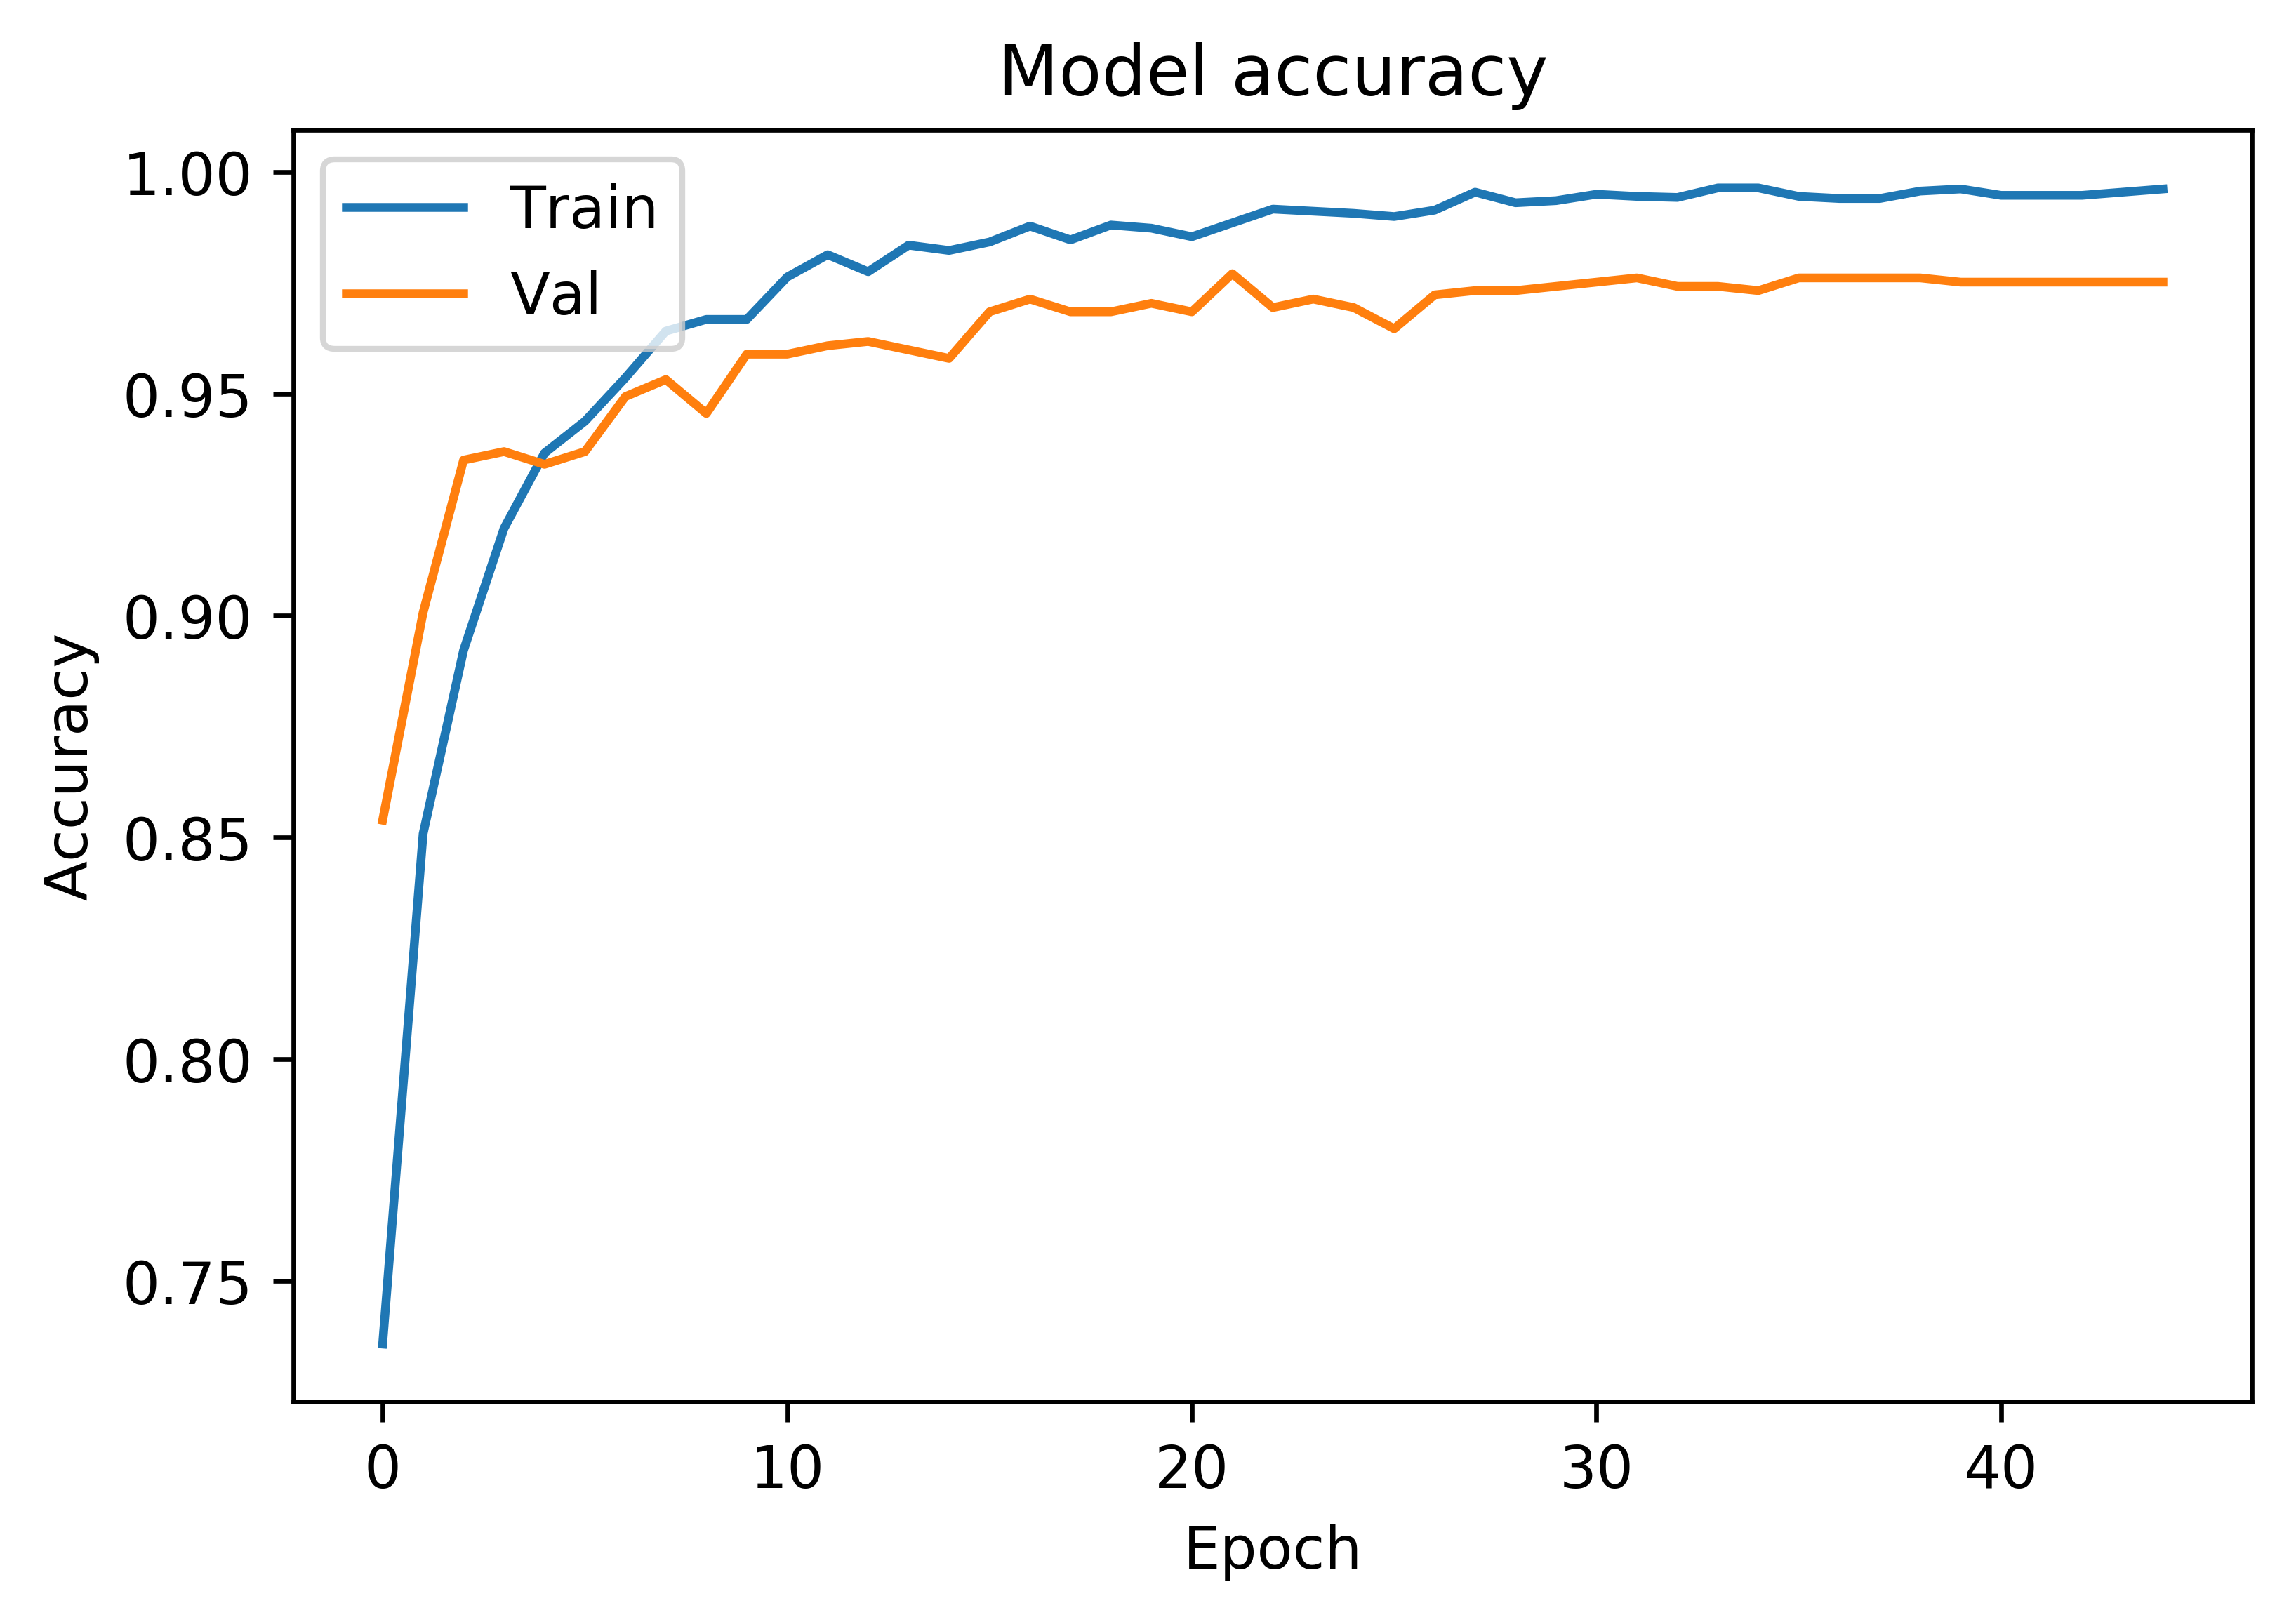

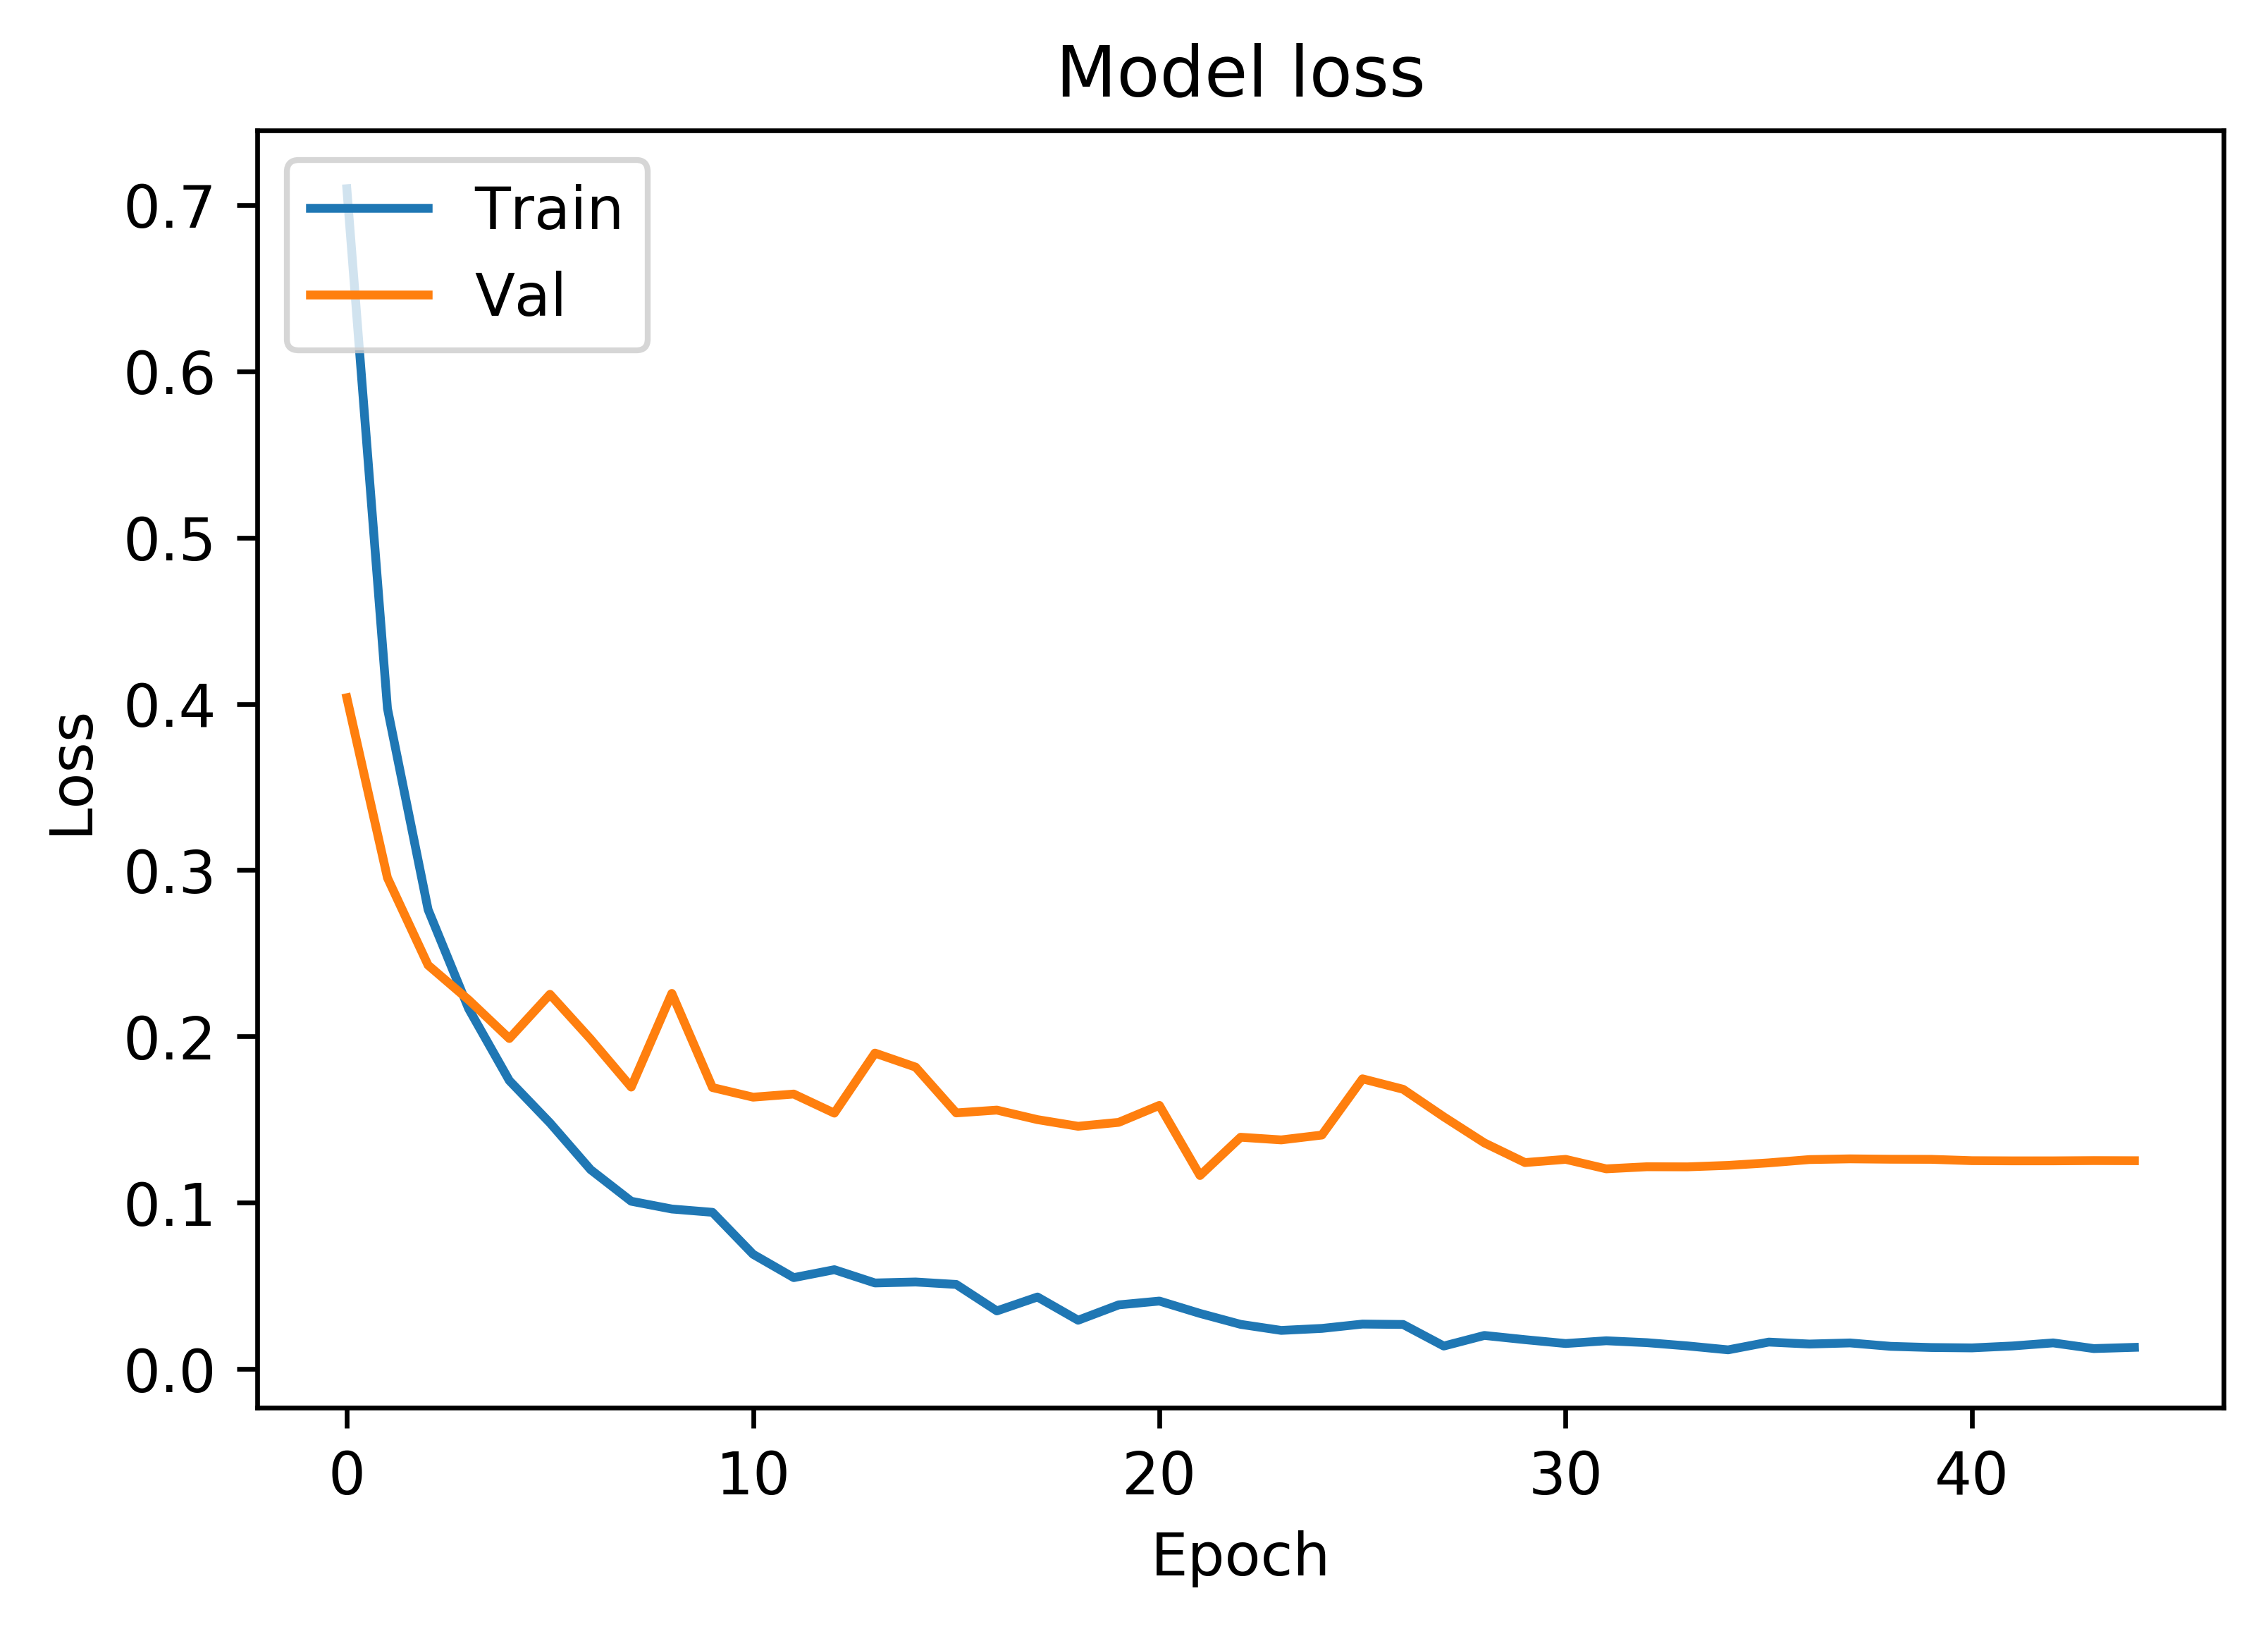

Results from K-fold: 1
acc: 97.52%
1047/1047 [==============================] - 0s 164us/step
[0.12526883910398542, 0.9751671444493014]
          normal  abnormal
normal       656        13
abnormal      13       365
              precision    recall  f1-score   support

      normal       0.98      0.98      0.98       669
    abnormal       0.97      0.97      0.97       378

   micro avg       0.98      0.98      0.98      1047
   macro avg       0.97      0.97      0.97      1047
weighted avg       0.98      0.98      0.98      1047

fold_2
K-: fold_2
Samples from Training
[6945 4672 2690 2928]
id: 6945
comparison none indication xxxx yr old female dyspnea findings left chest wall mediport placement venous catheter tip superior xxxx xxxx normal cardiac contours pneumothorax pleural effusions clear lungs bilaterally xxxx fracture seen l areas sclerosis throughout thoracic lumbar spine impression pathologic fractures seen l left venous catheter svc 
id: 4672
comparison radiographs ch

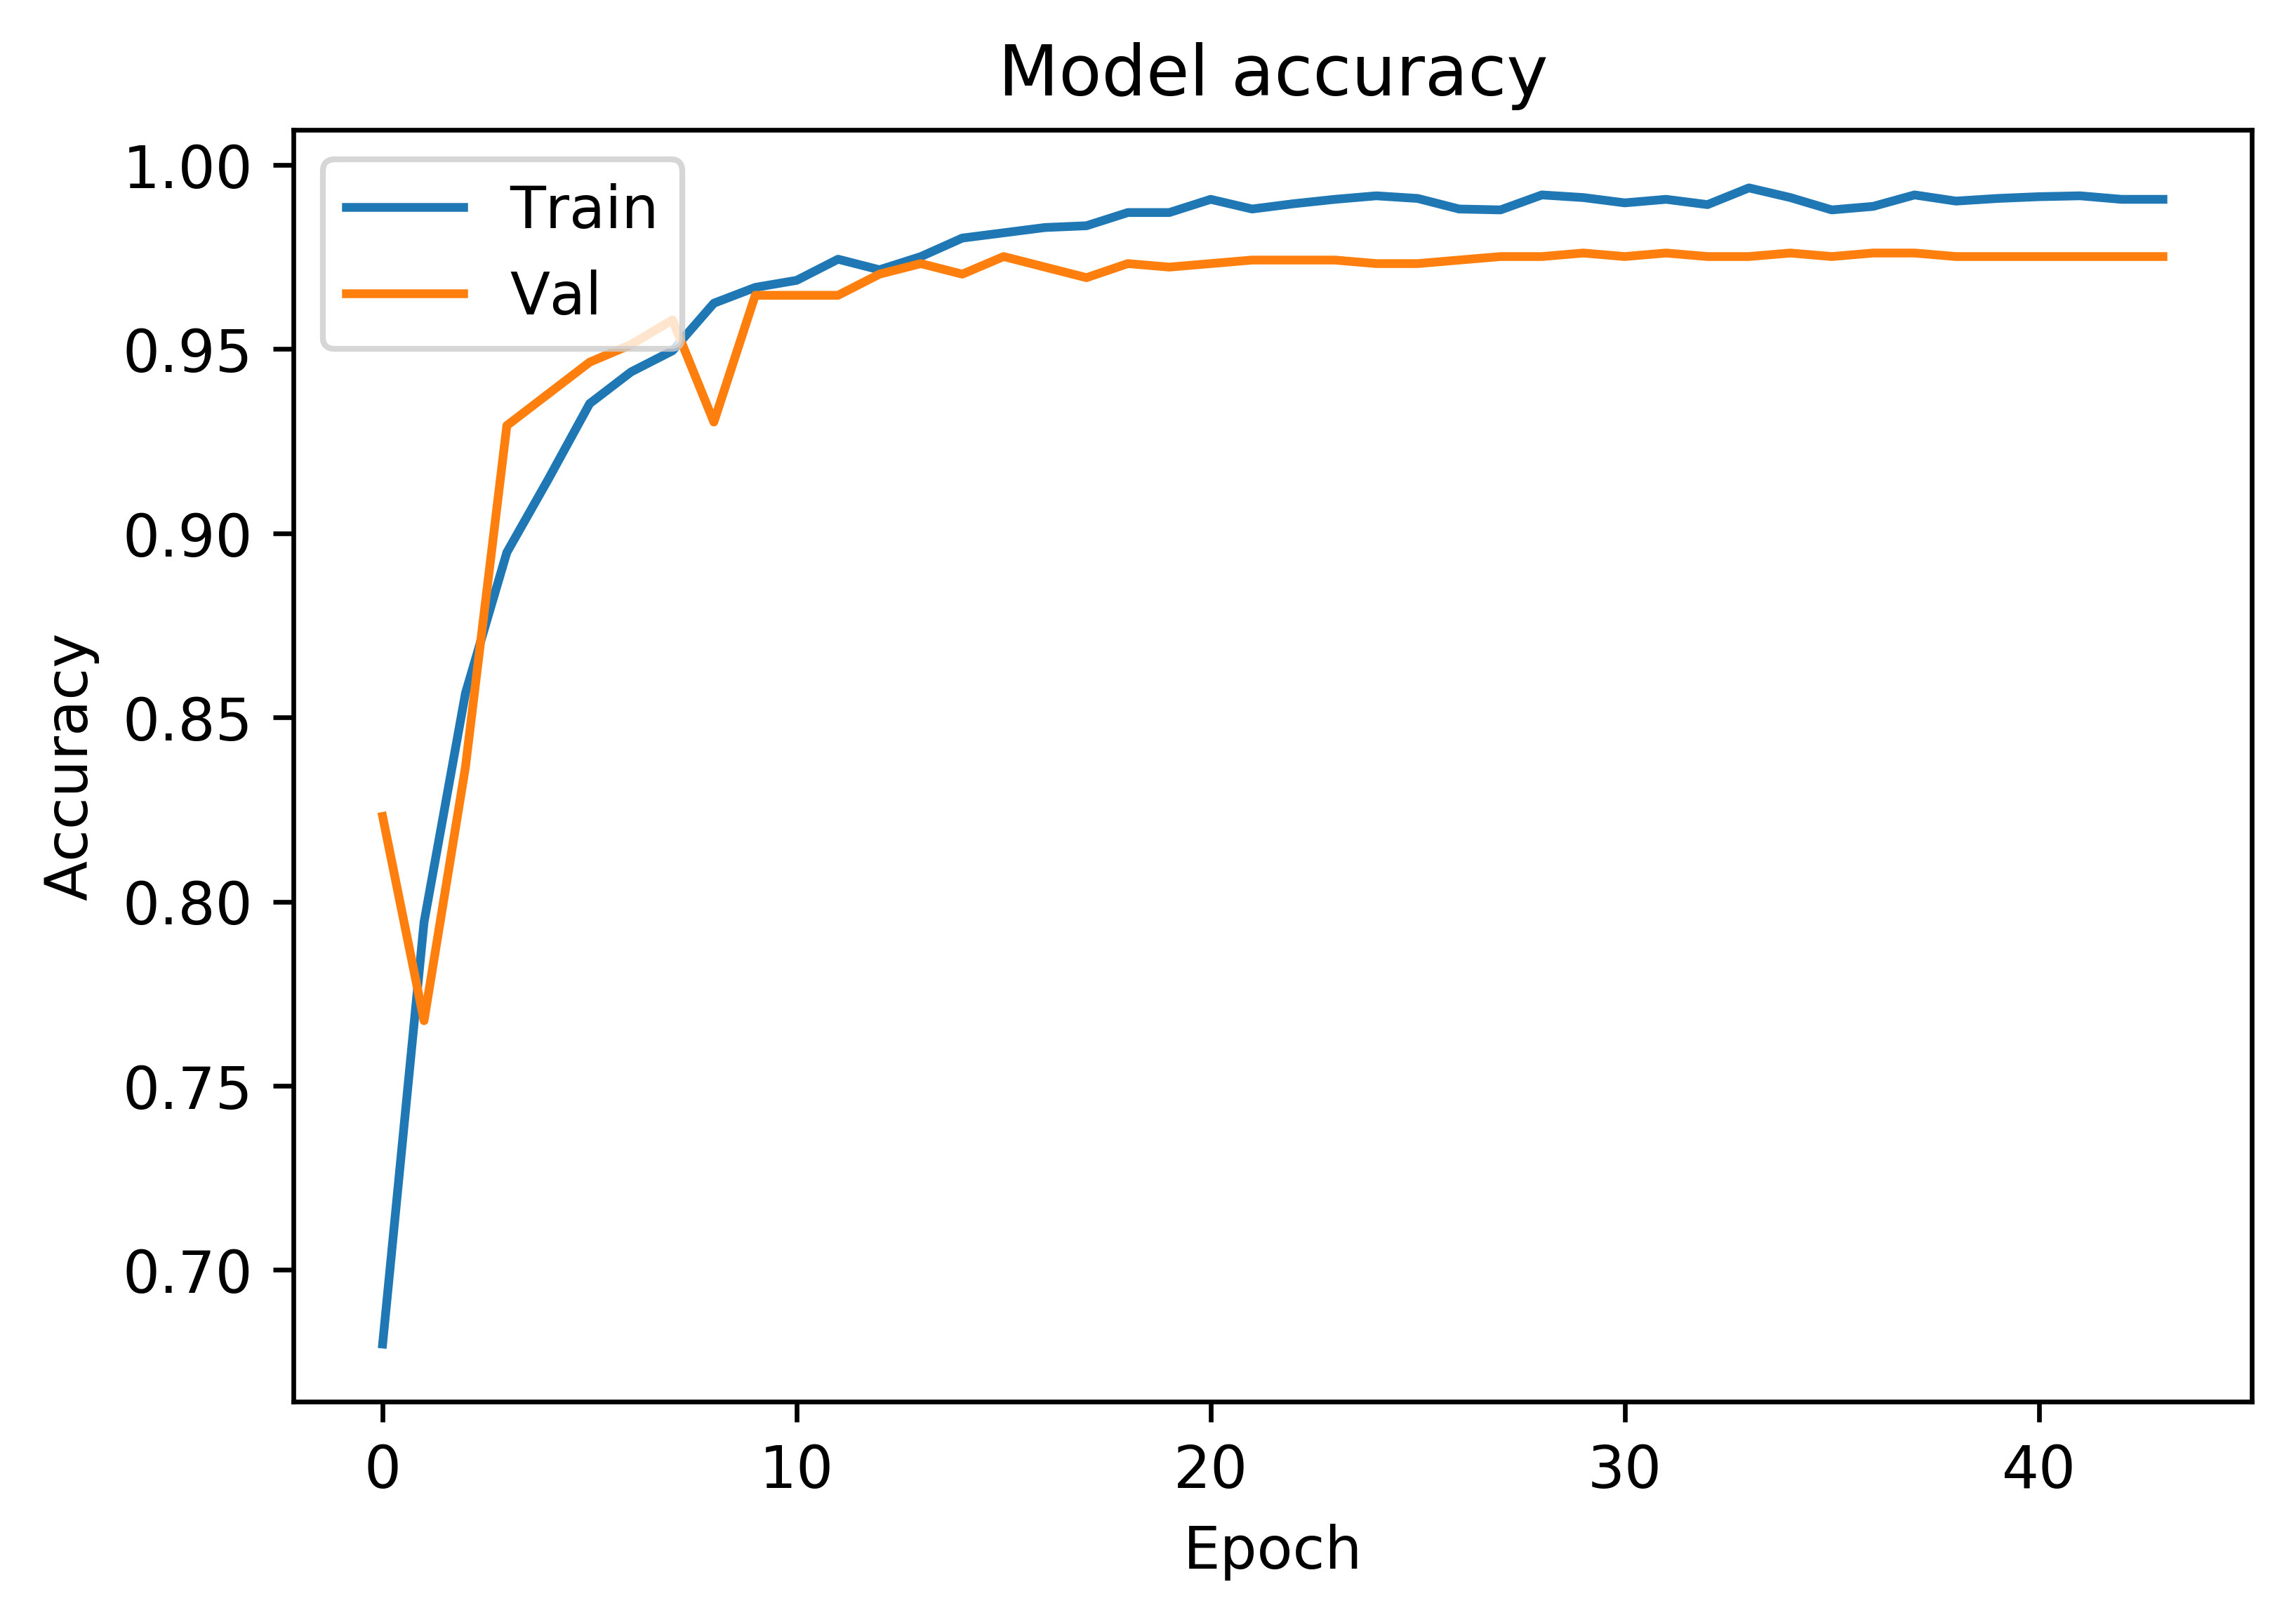

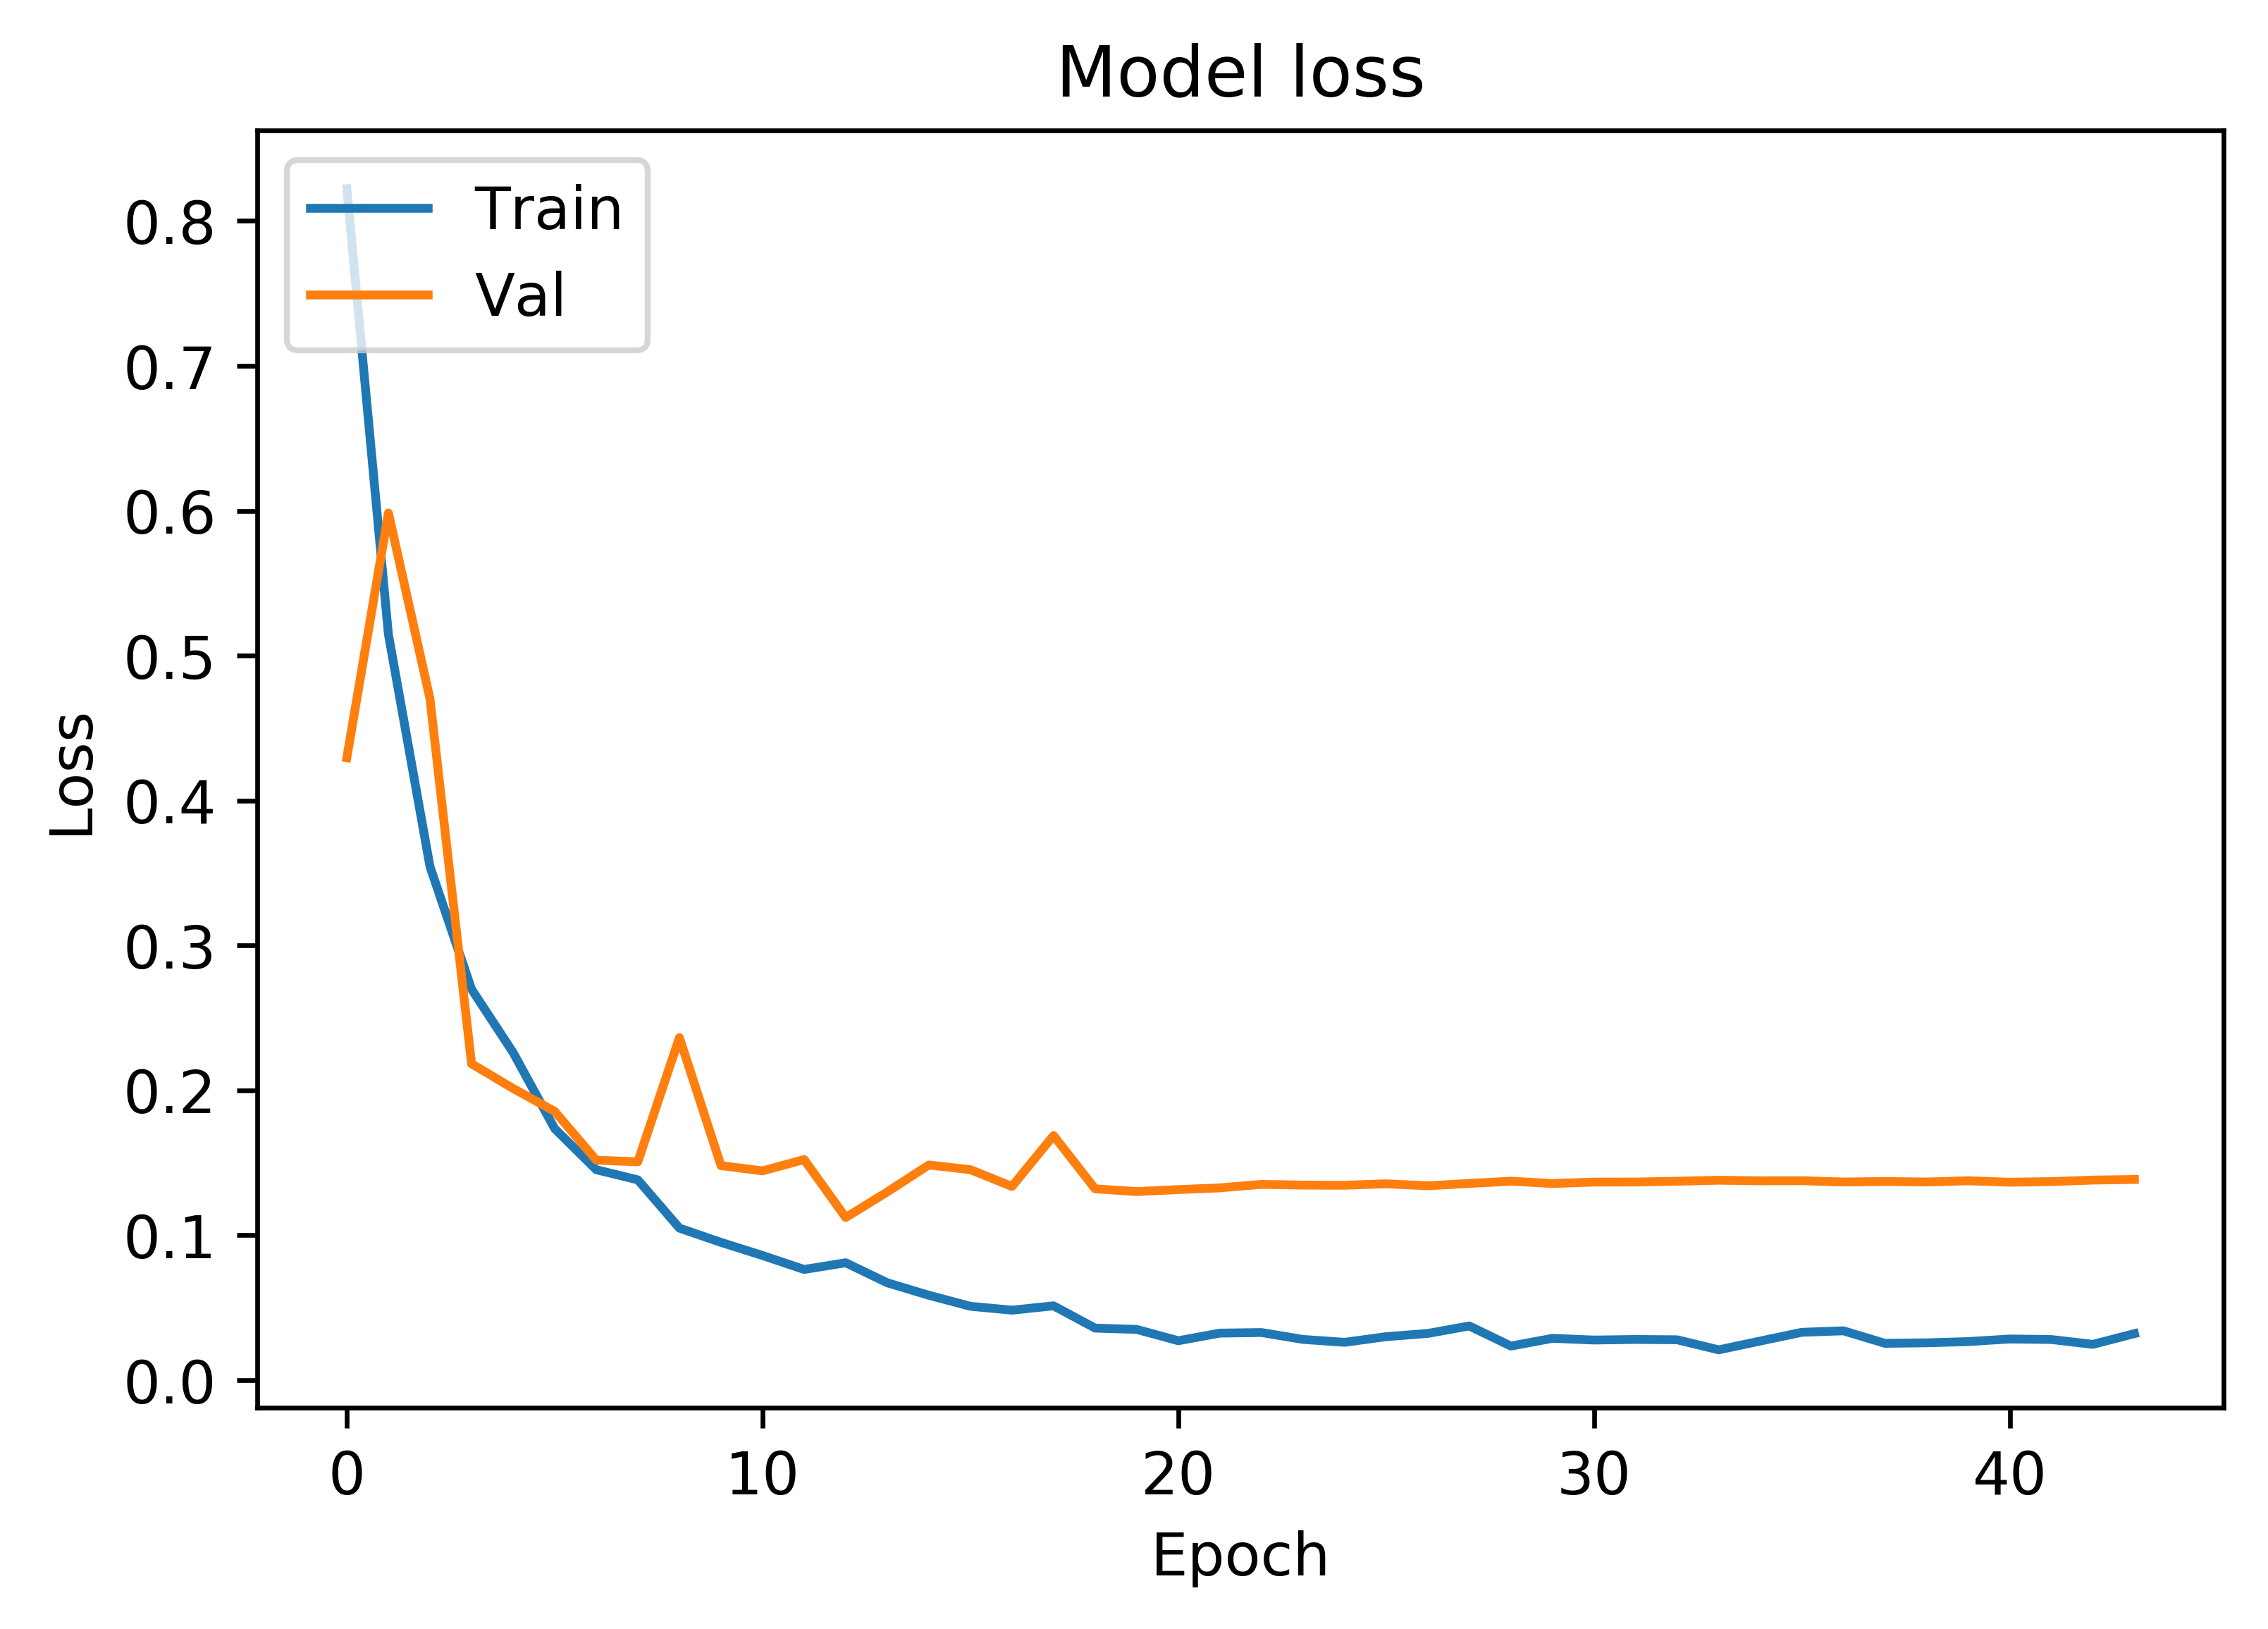

Results from K-fold: 2
acc: 97.51%
1046/1046 [==============================] - 0s 189us/step
[0.1384455385630377, 0.9751434030997822]
          normal  abnormal
normal       652        16
abnormal      10       368
              precision    recall  f1-score   support

      normal       0.98      0.98      0.98       668
    abnormal       0.96      0.97      0.97       378

   micro avg       0.98      0.98      0.98      1046
   macro avg       0.97      0.97      0.97      1046
weighted avg       0.98      0.98      0.98      1046

fold_3
K-: fold_3
Samples from Training
[1892 2643 6303 1168]
id: 1892
comparison none indication chest pain shortness breath findings lungs pleural spaces show acute abnormality heart size pulmonary vascularity within normal limits impression acute pulmonary abnormality 
id: 2643
indication chest pain impression heart size normal lungs clear 
id: 6303
comparison none indication history smoking status post left upper lobectomy impression heart size norm

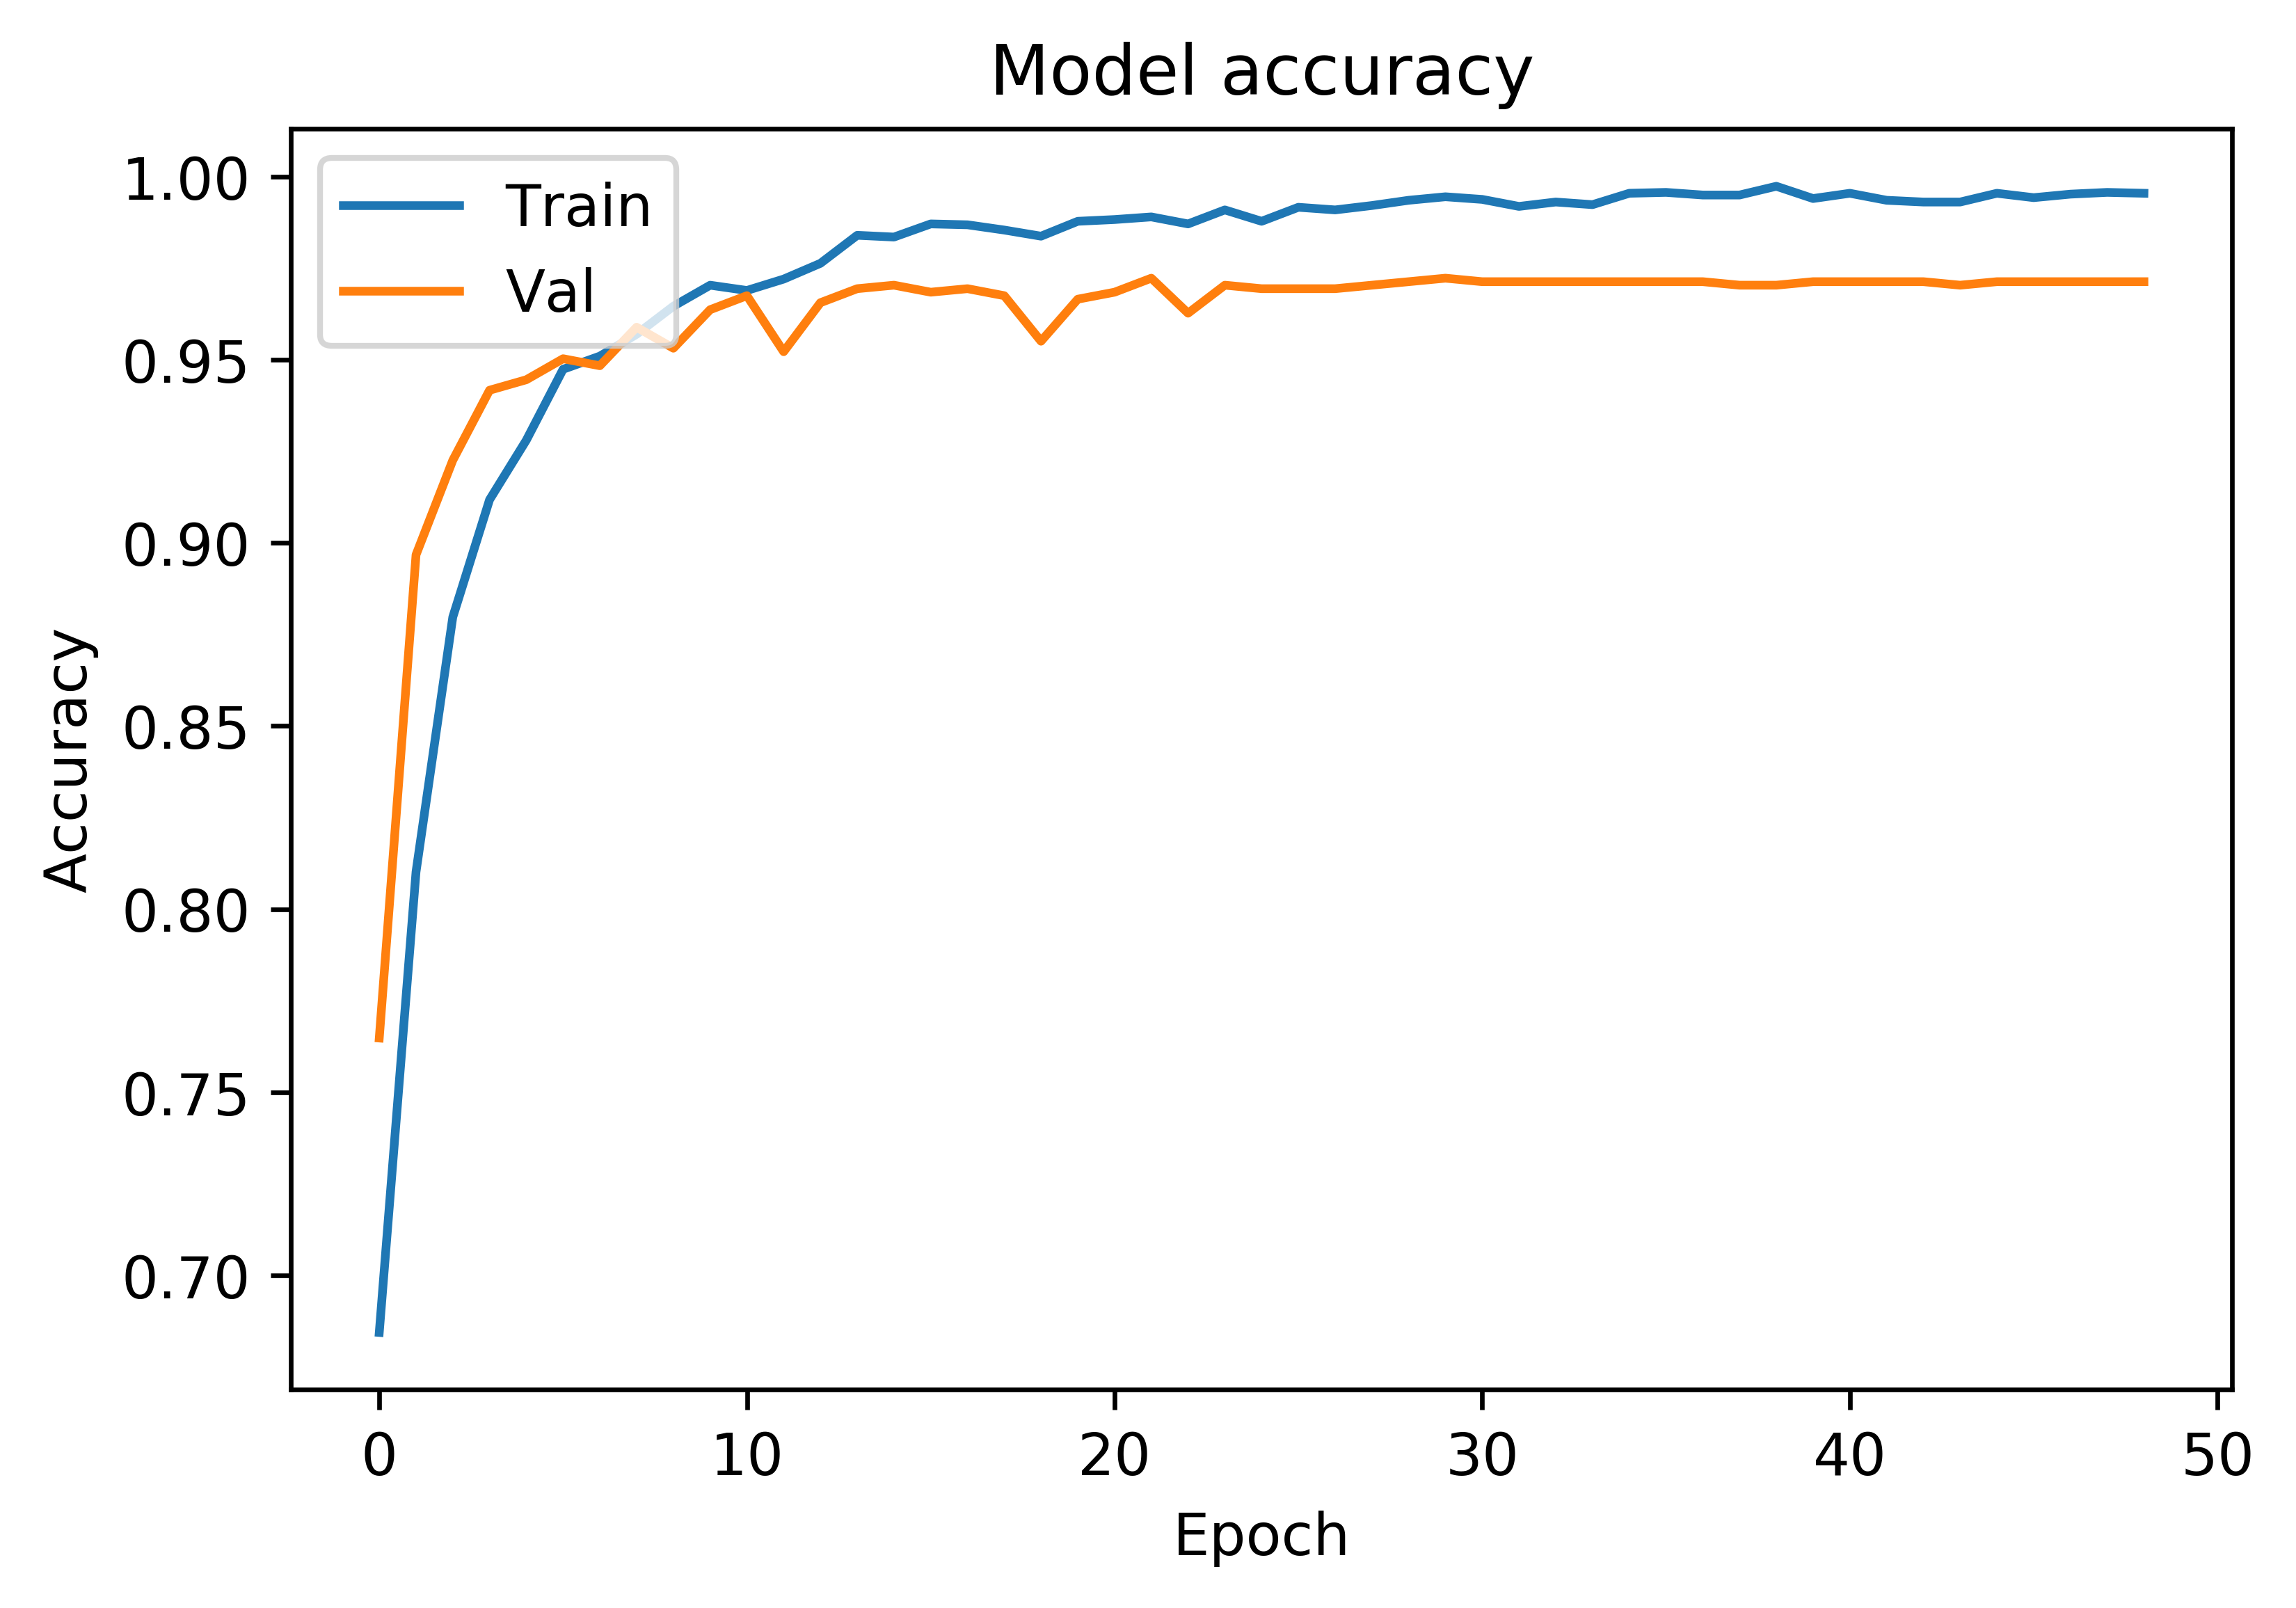

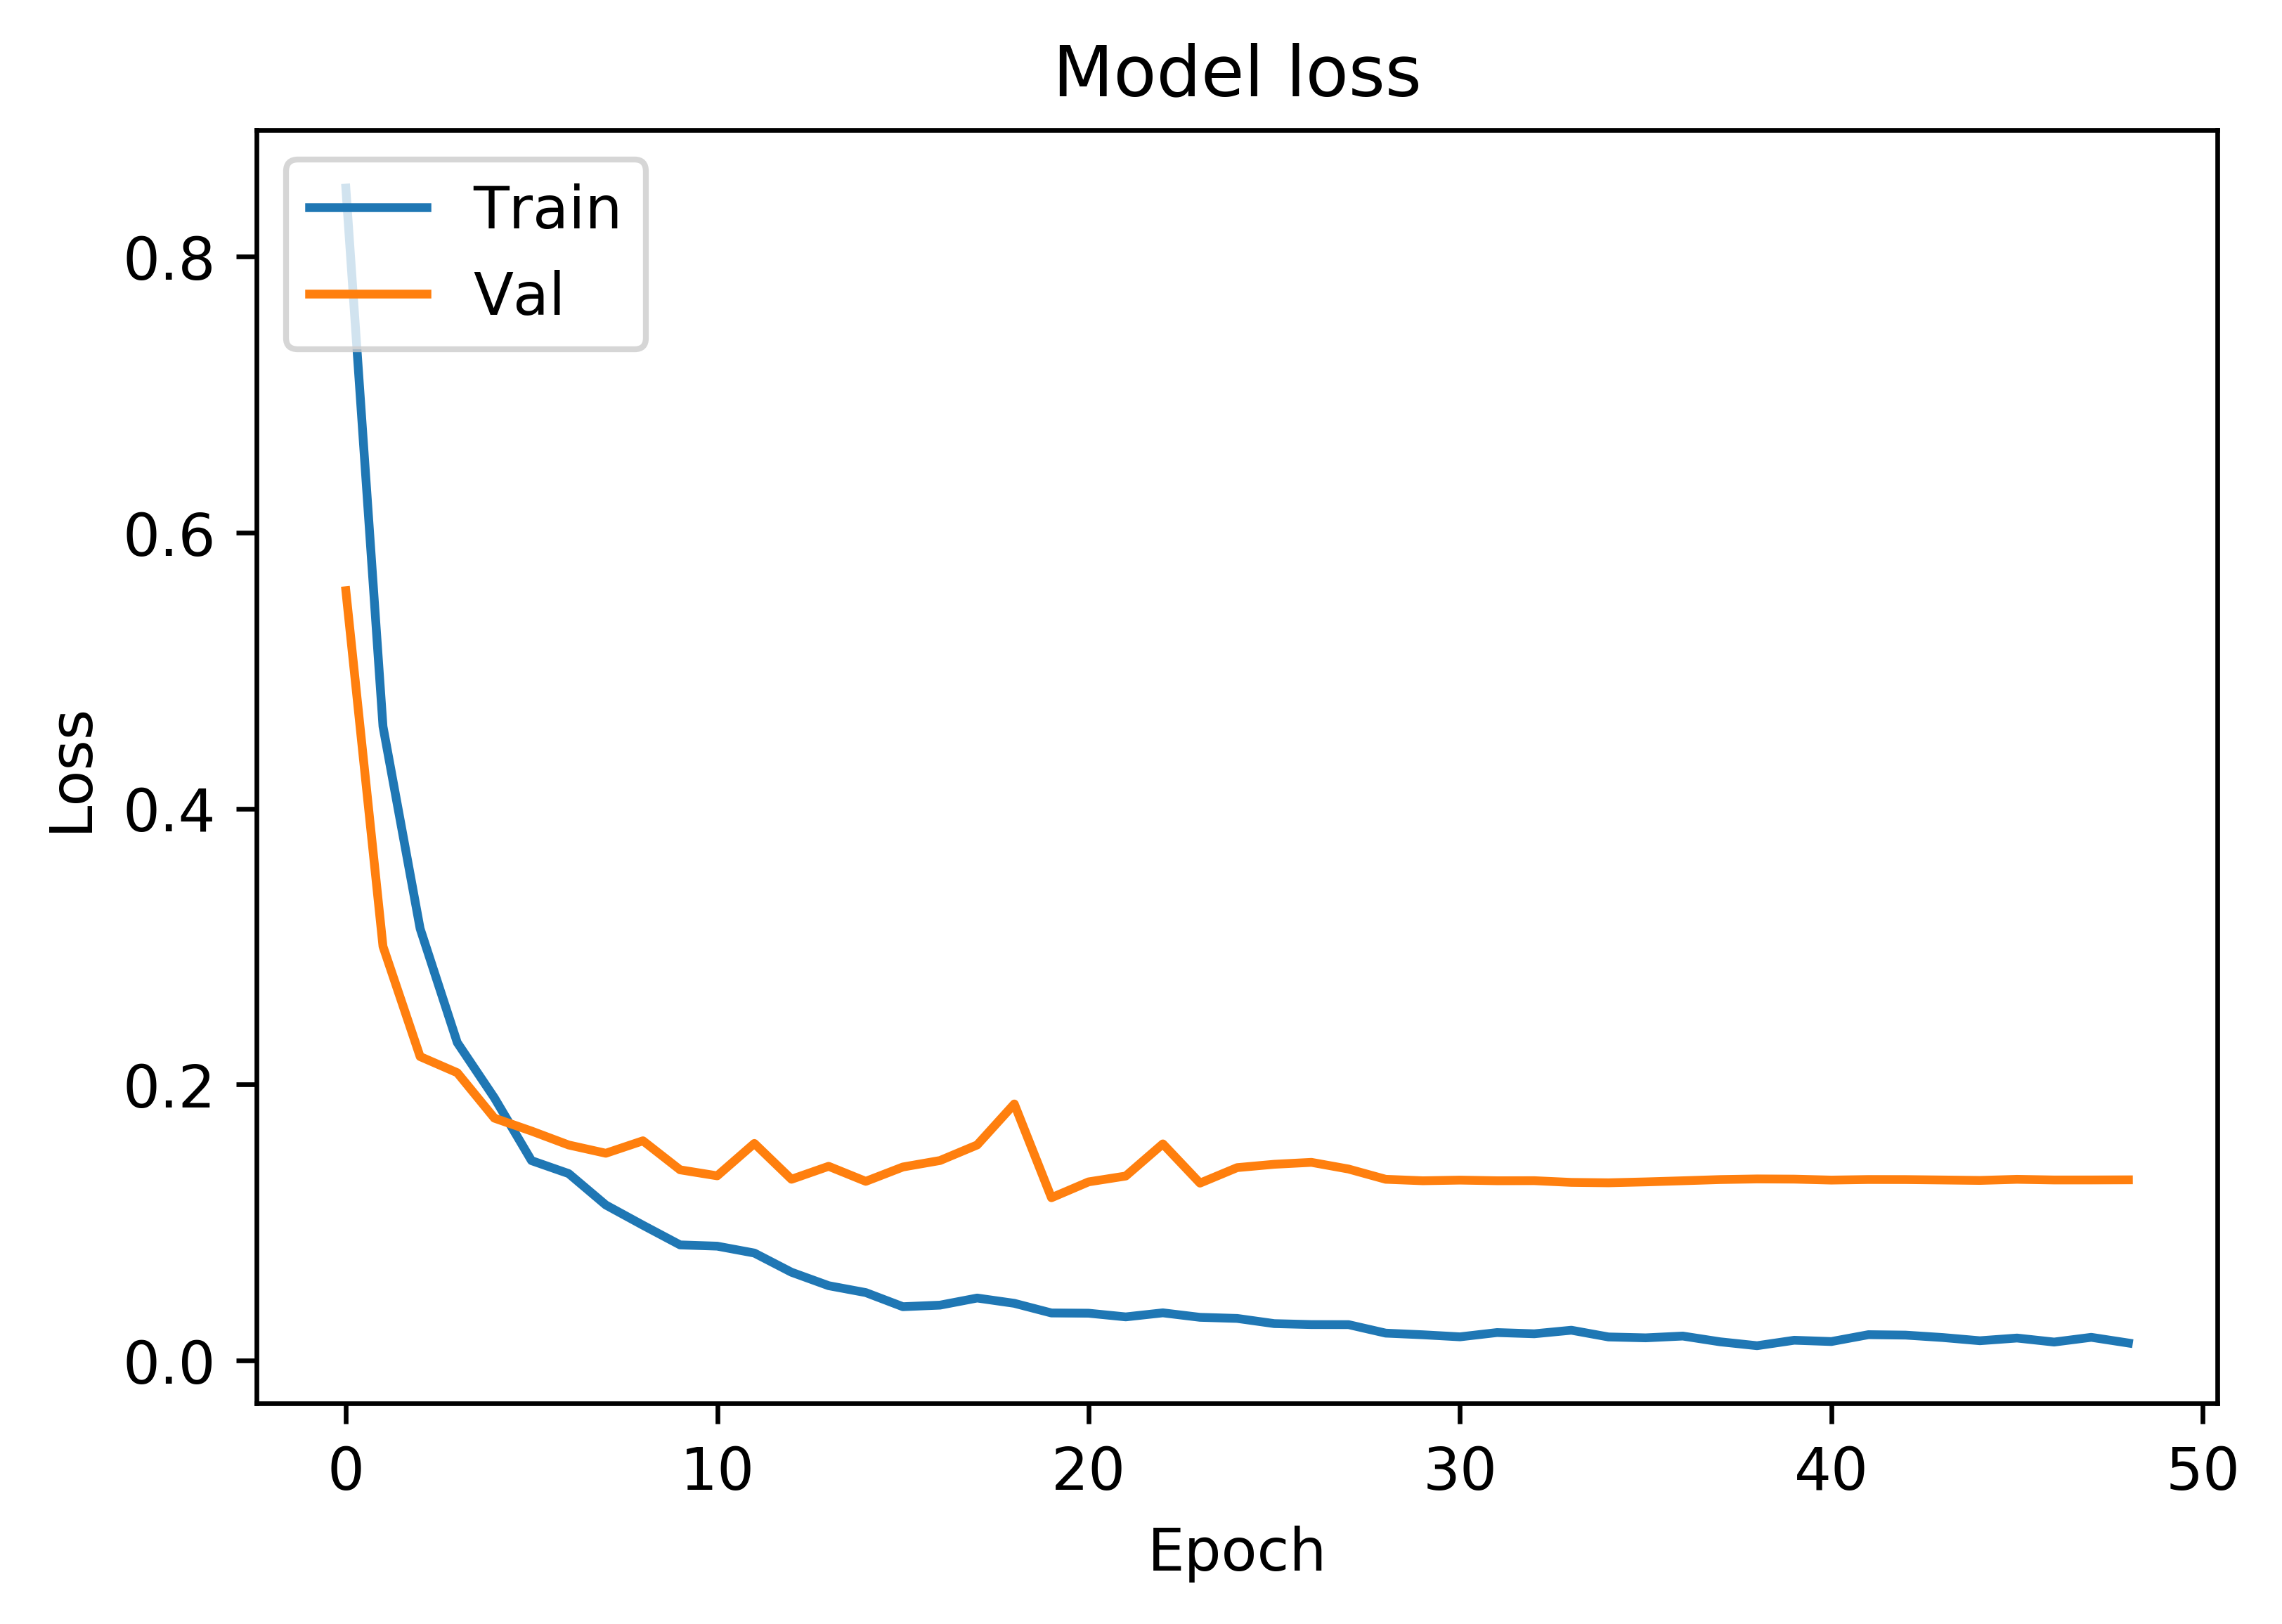

Results from K-fold: 3
acc: 97.13%
1046/1046 [==============================] - 0s 159us/step
[0.13103176120946444, 0.97131931166348]
          normal  abnormal
normal       655        13
abnormal      17       361
              precision    recall  f1-score   support

      normal       0.97      0.98      0.98       668
    abnormal       0.97      0.96      0.96       378

   micro avg       0.97      0.97      0.97      1046
   macro avg       0.97      0.97      0.97      1046
weighted avg       0.97      0.97      0.97      1046

fold_4
K-: fold_4
Samples from Training
[3579  177 3127 5831]
id: 3579
comparison none indication xxxx-year-old female chest pain findings cardiomediastinal silhouettes within normal limits lungs clear without focal consolidation pneumothorax pleural effusion bony thorax unremarkable impression acute cardiopulmonary abnormalities 
id: 177
indication xxxx-year-old male syncopal episode additional information obtained electronic medical record history lung

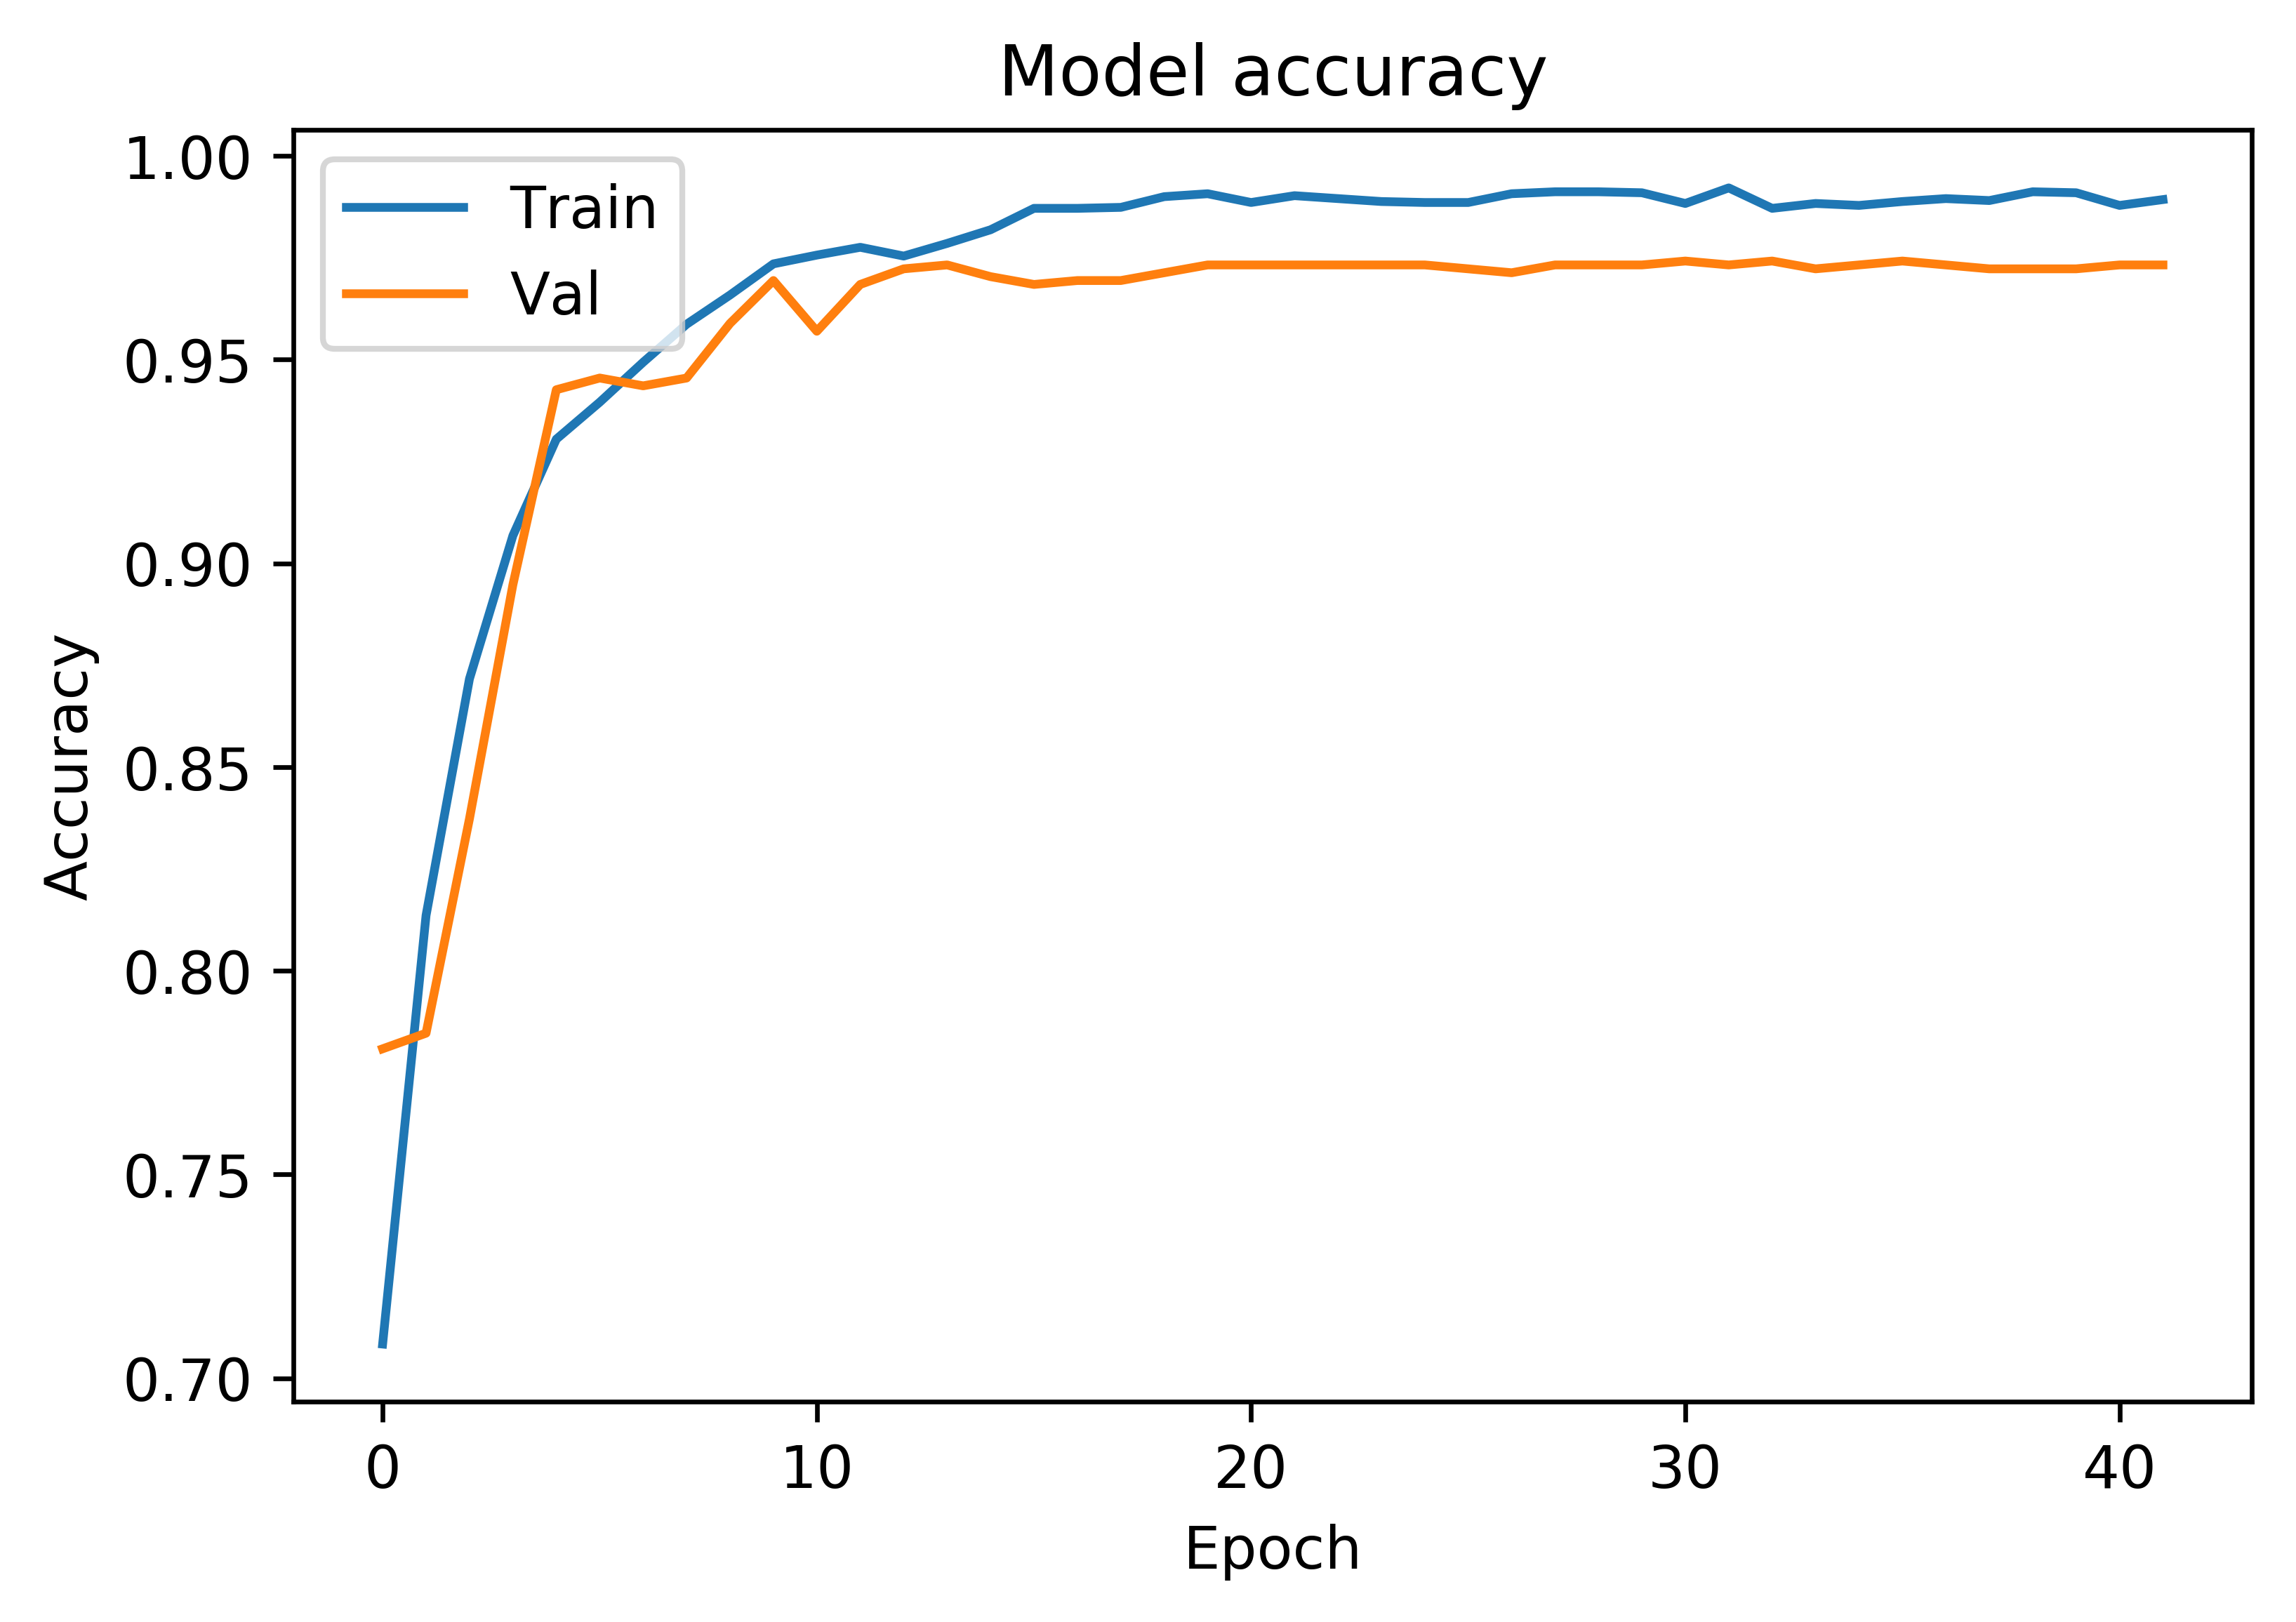

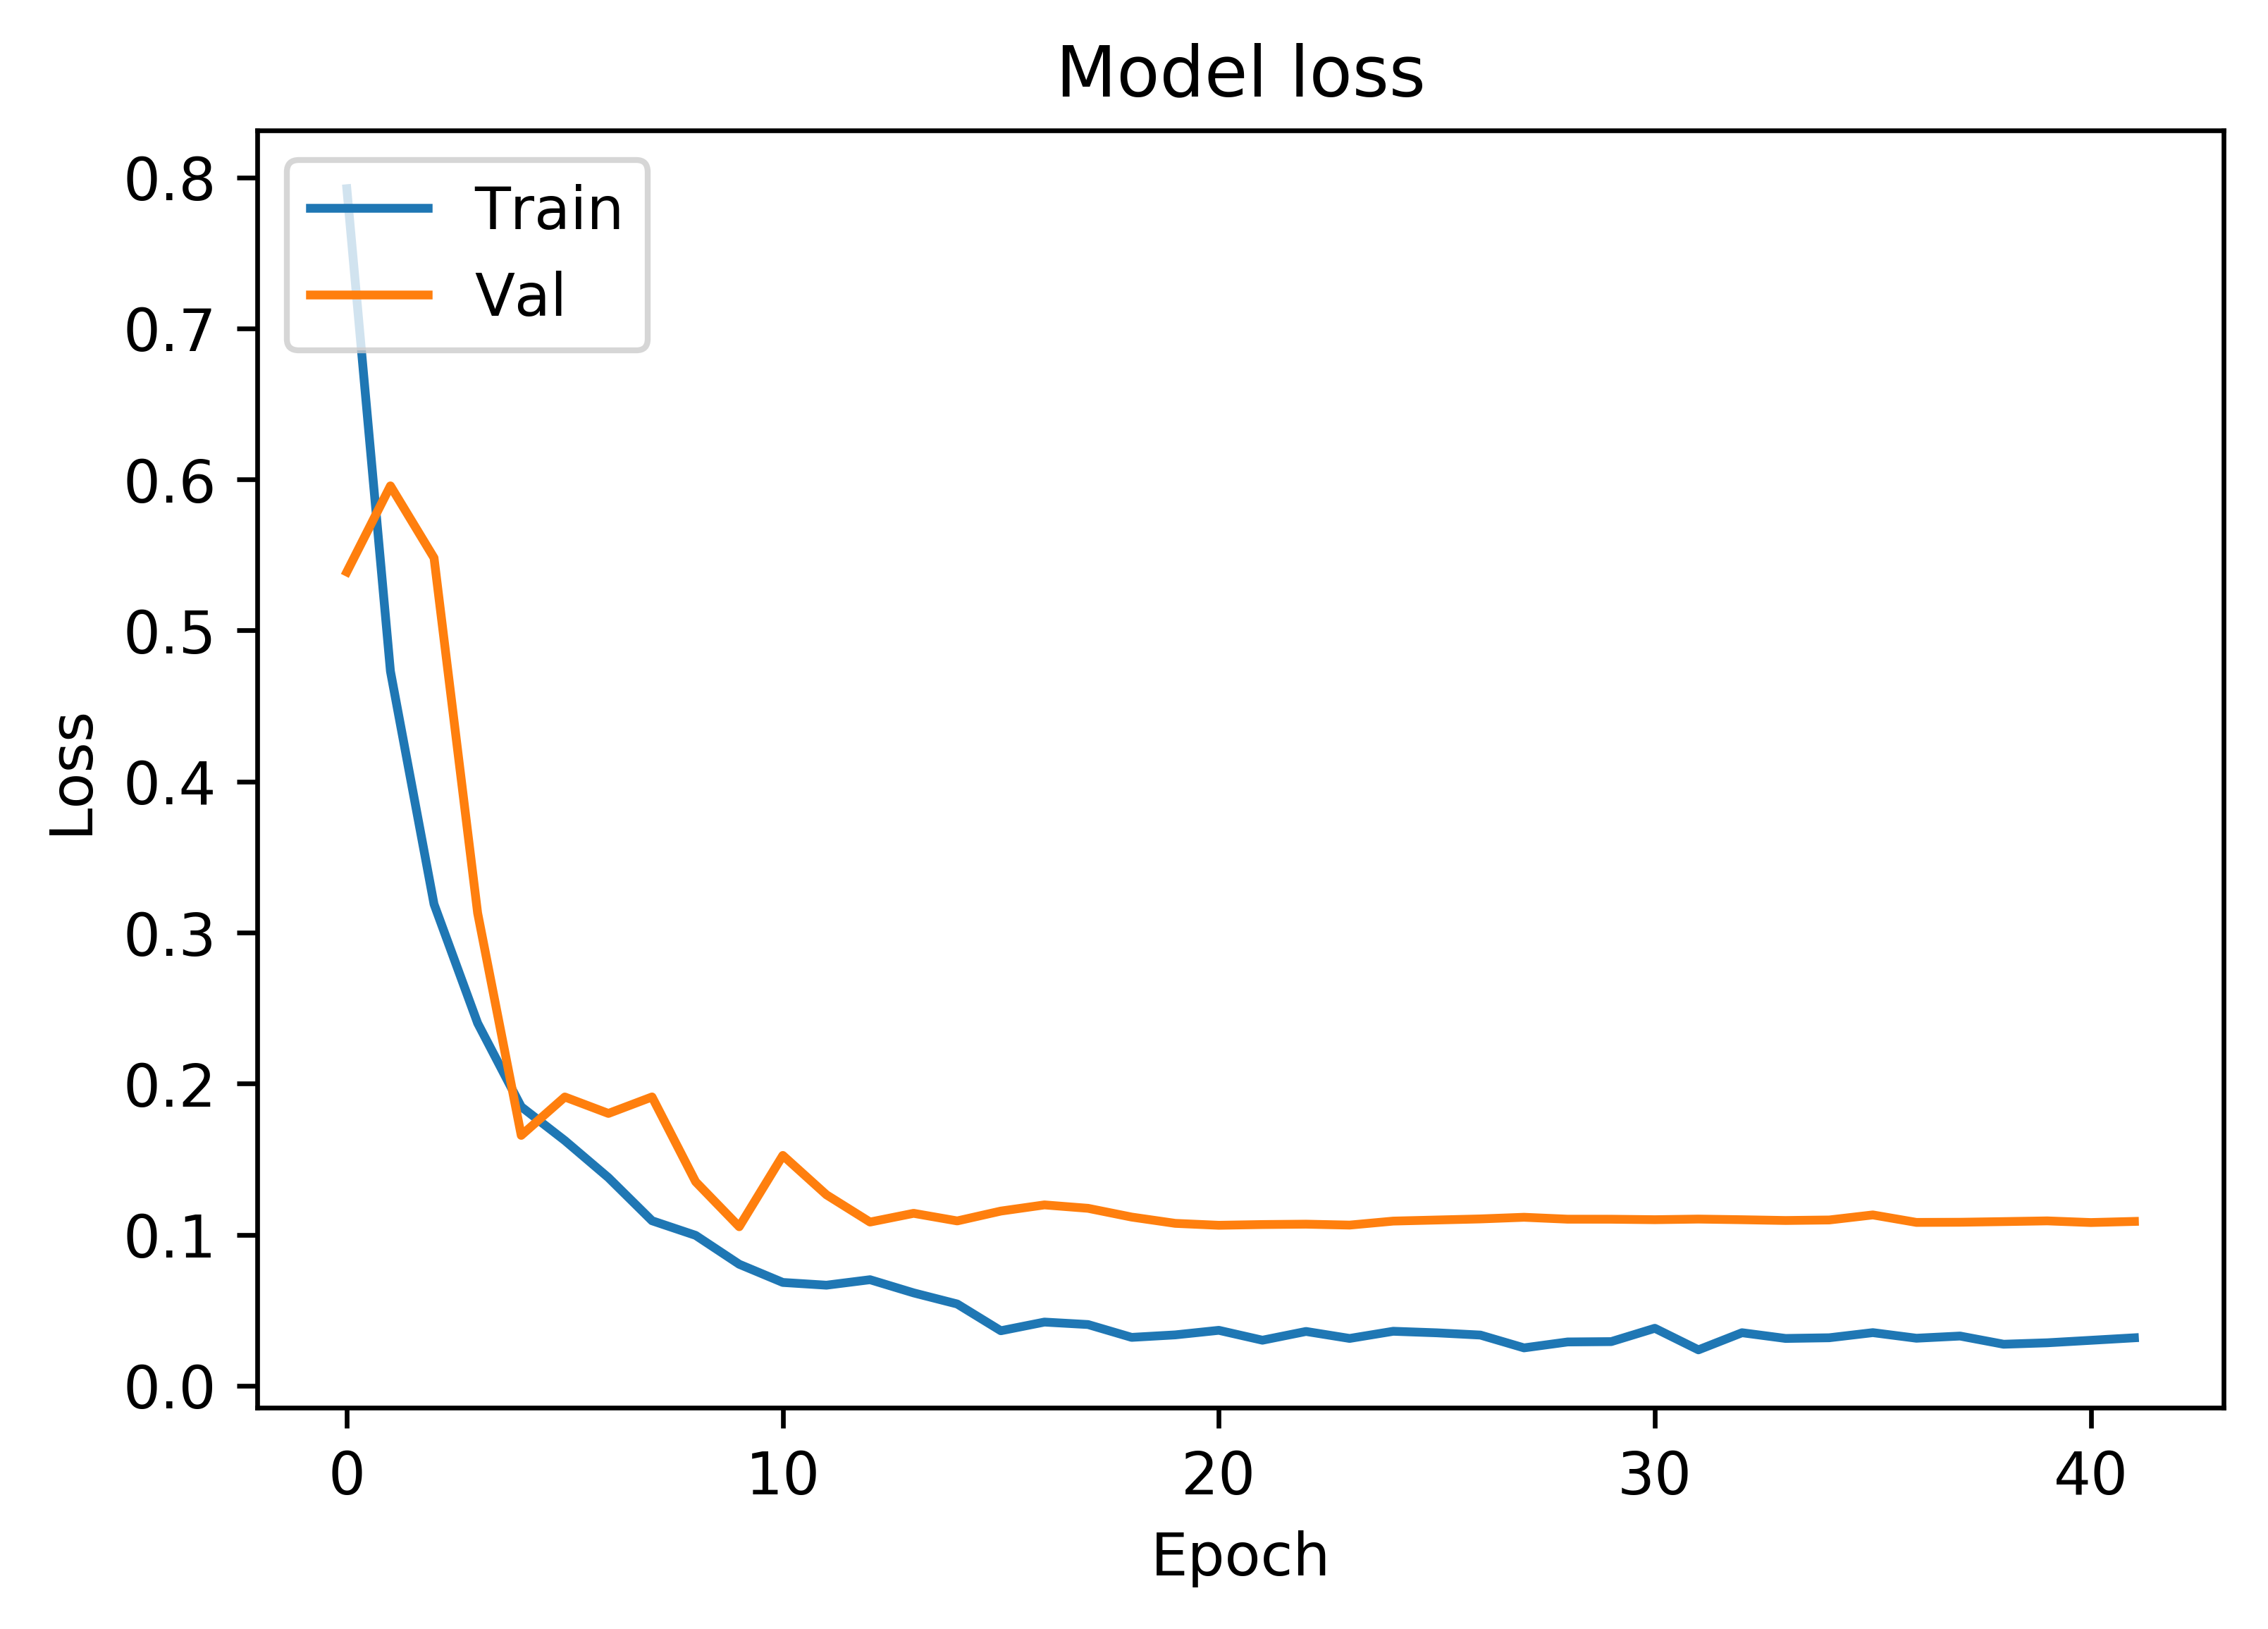

Results from K-fold: 4
acc: 97.32%
1045/1045 [==============================] - 0s 192us/step
[0.10875688376502272, 0.9732057416267943]
          normal  abnormal
normal       651        17
abnormal      11       366
              precision    recall  f1-score   support

      normal       0.98      0.97      0.98       668
    abnormal       0.96      0.97      0.96       377

   micro avg       0.97      0.97      0.97      1045
   macro avg       0.97      0.97      0.97      1045
weighted avg       0.97      0.97      0.97      1045

fold_5
K-: fold_5
Samples from Training
[5822 5097 4853 3579]
id: 5822
comparison none available indication xxxx-year-old male shortness breath findings heart size mediastinal contours appear within normal limits focal airspace consolidation pleural effusion pneumothorax acute bony abnormalities impression acute cardiopulmonary findings 
id: 5097
comparison none available indication left-sided chest pain findings heart size mildly enlarged tortuous aor

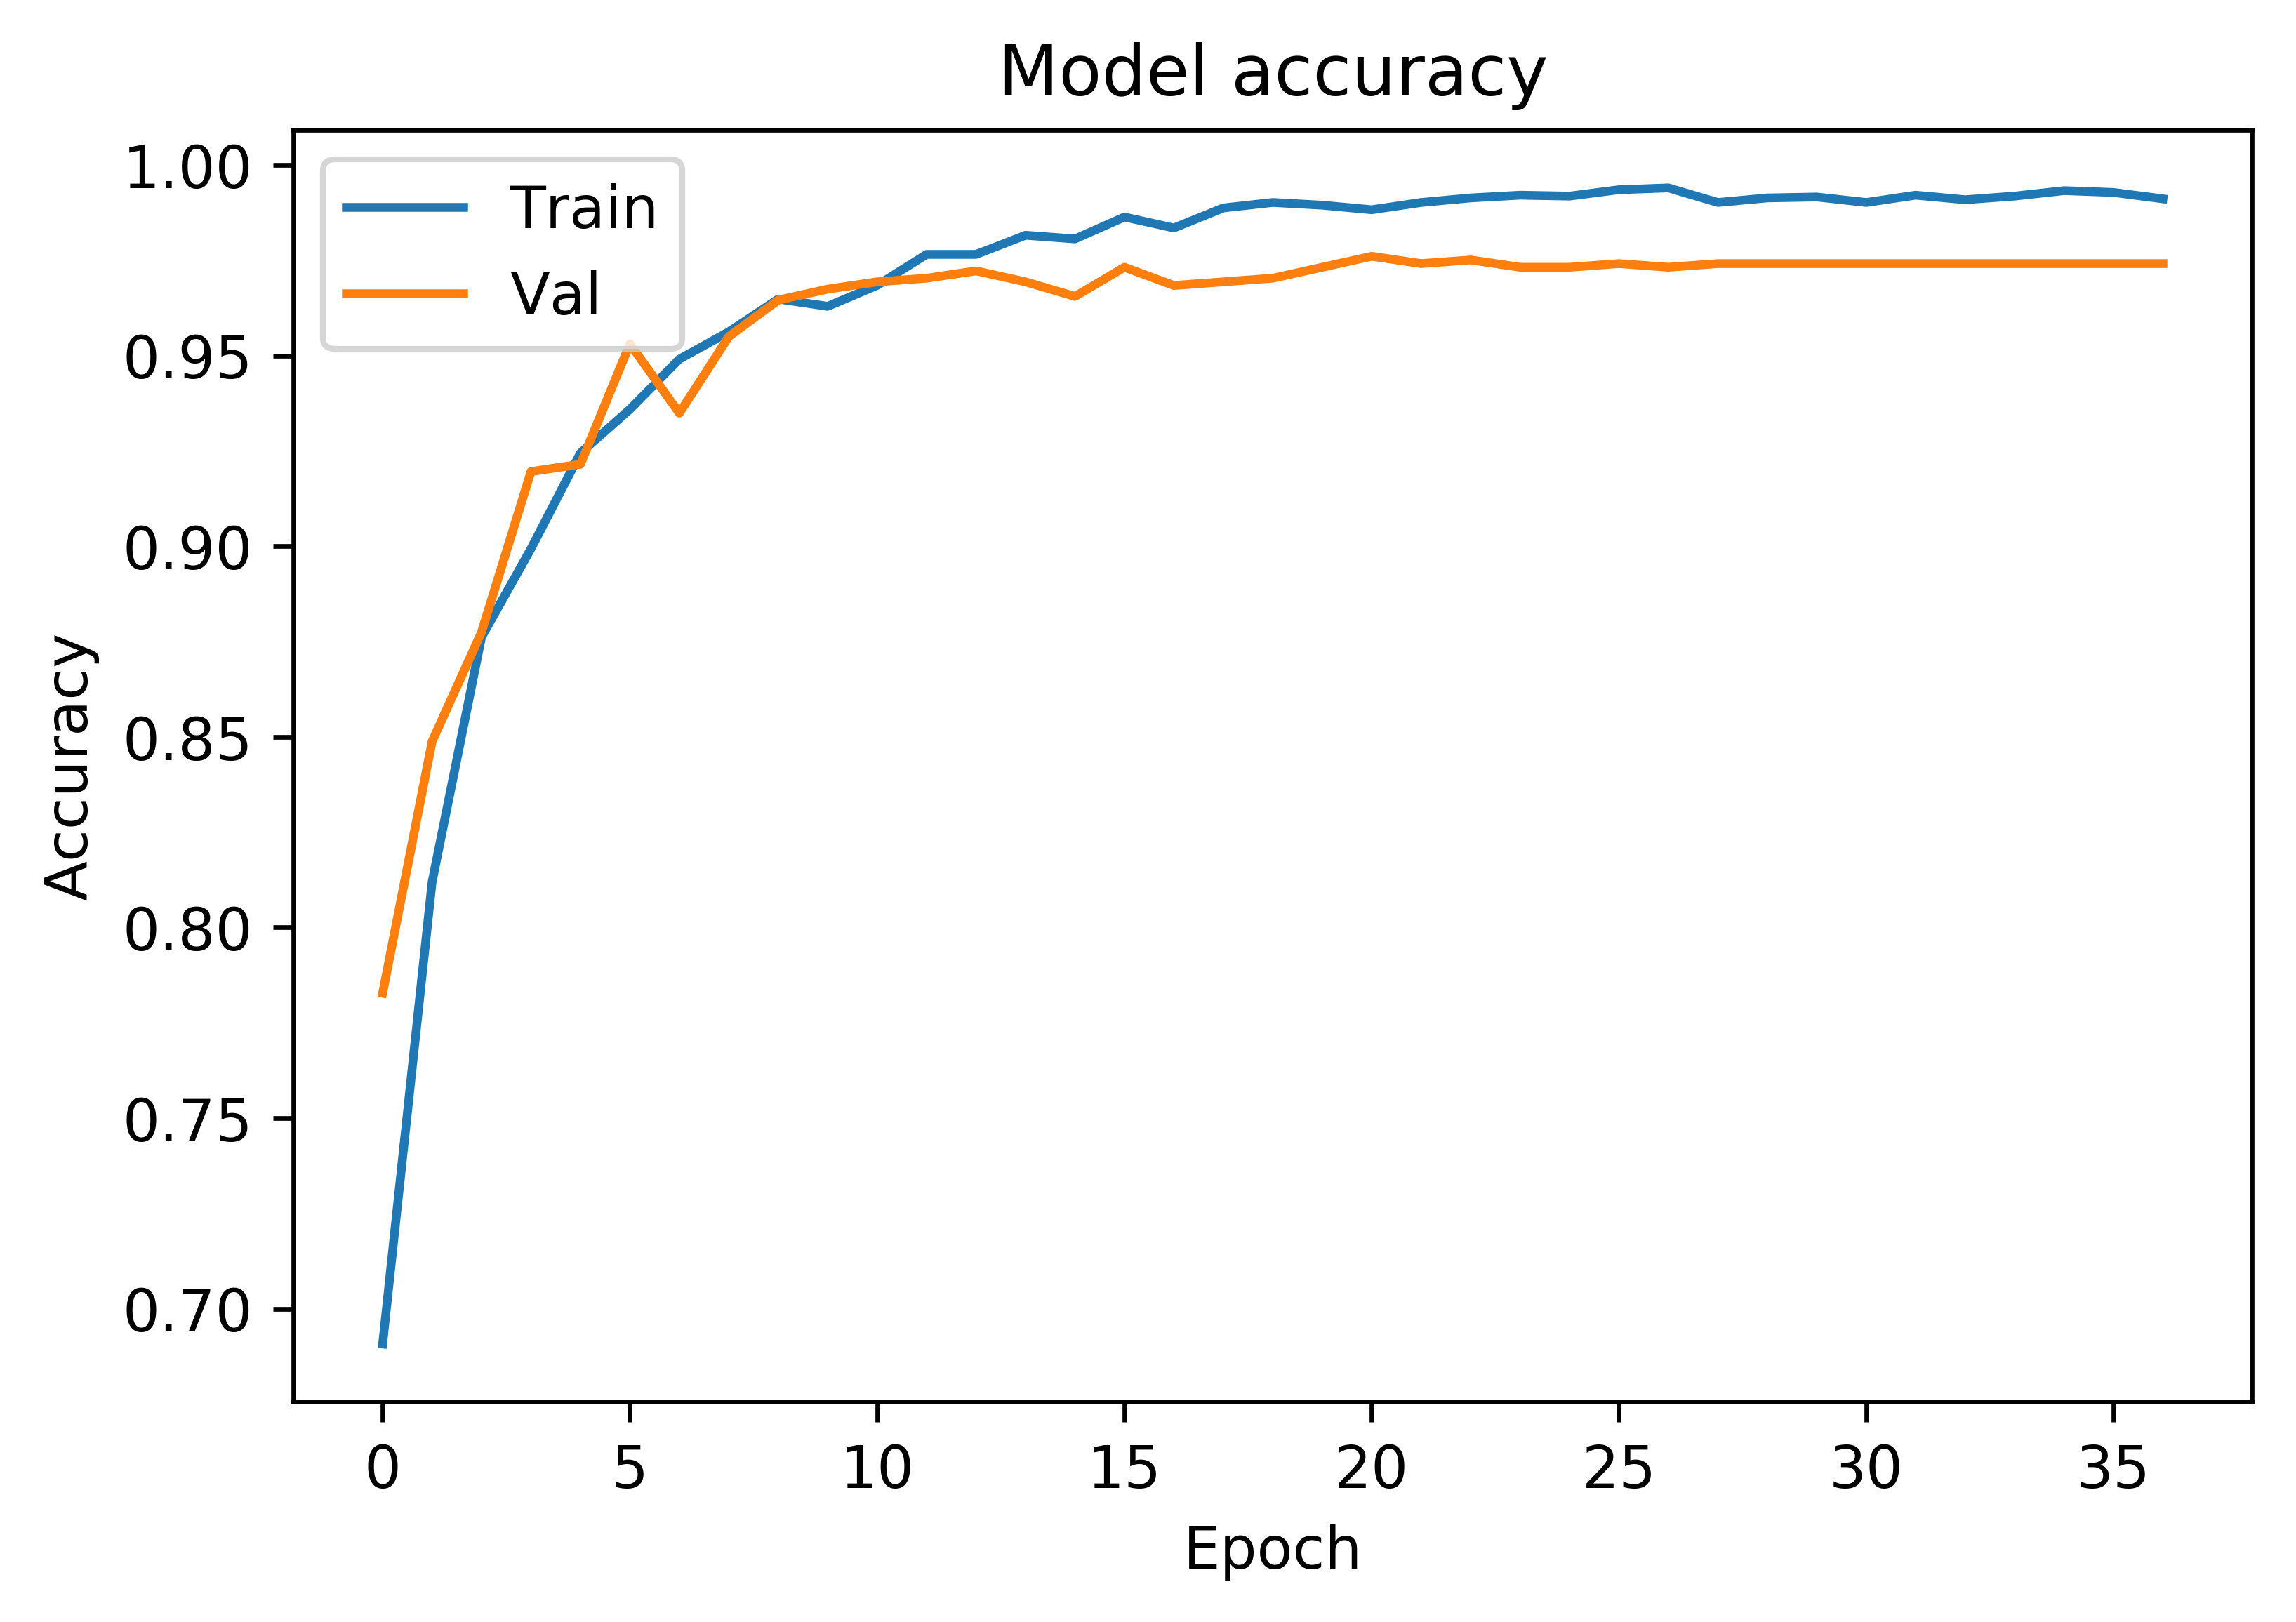

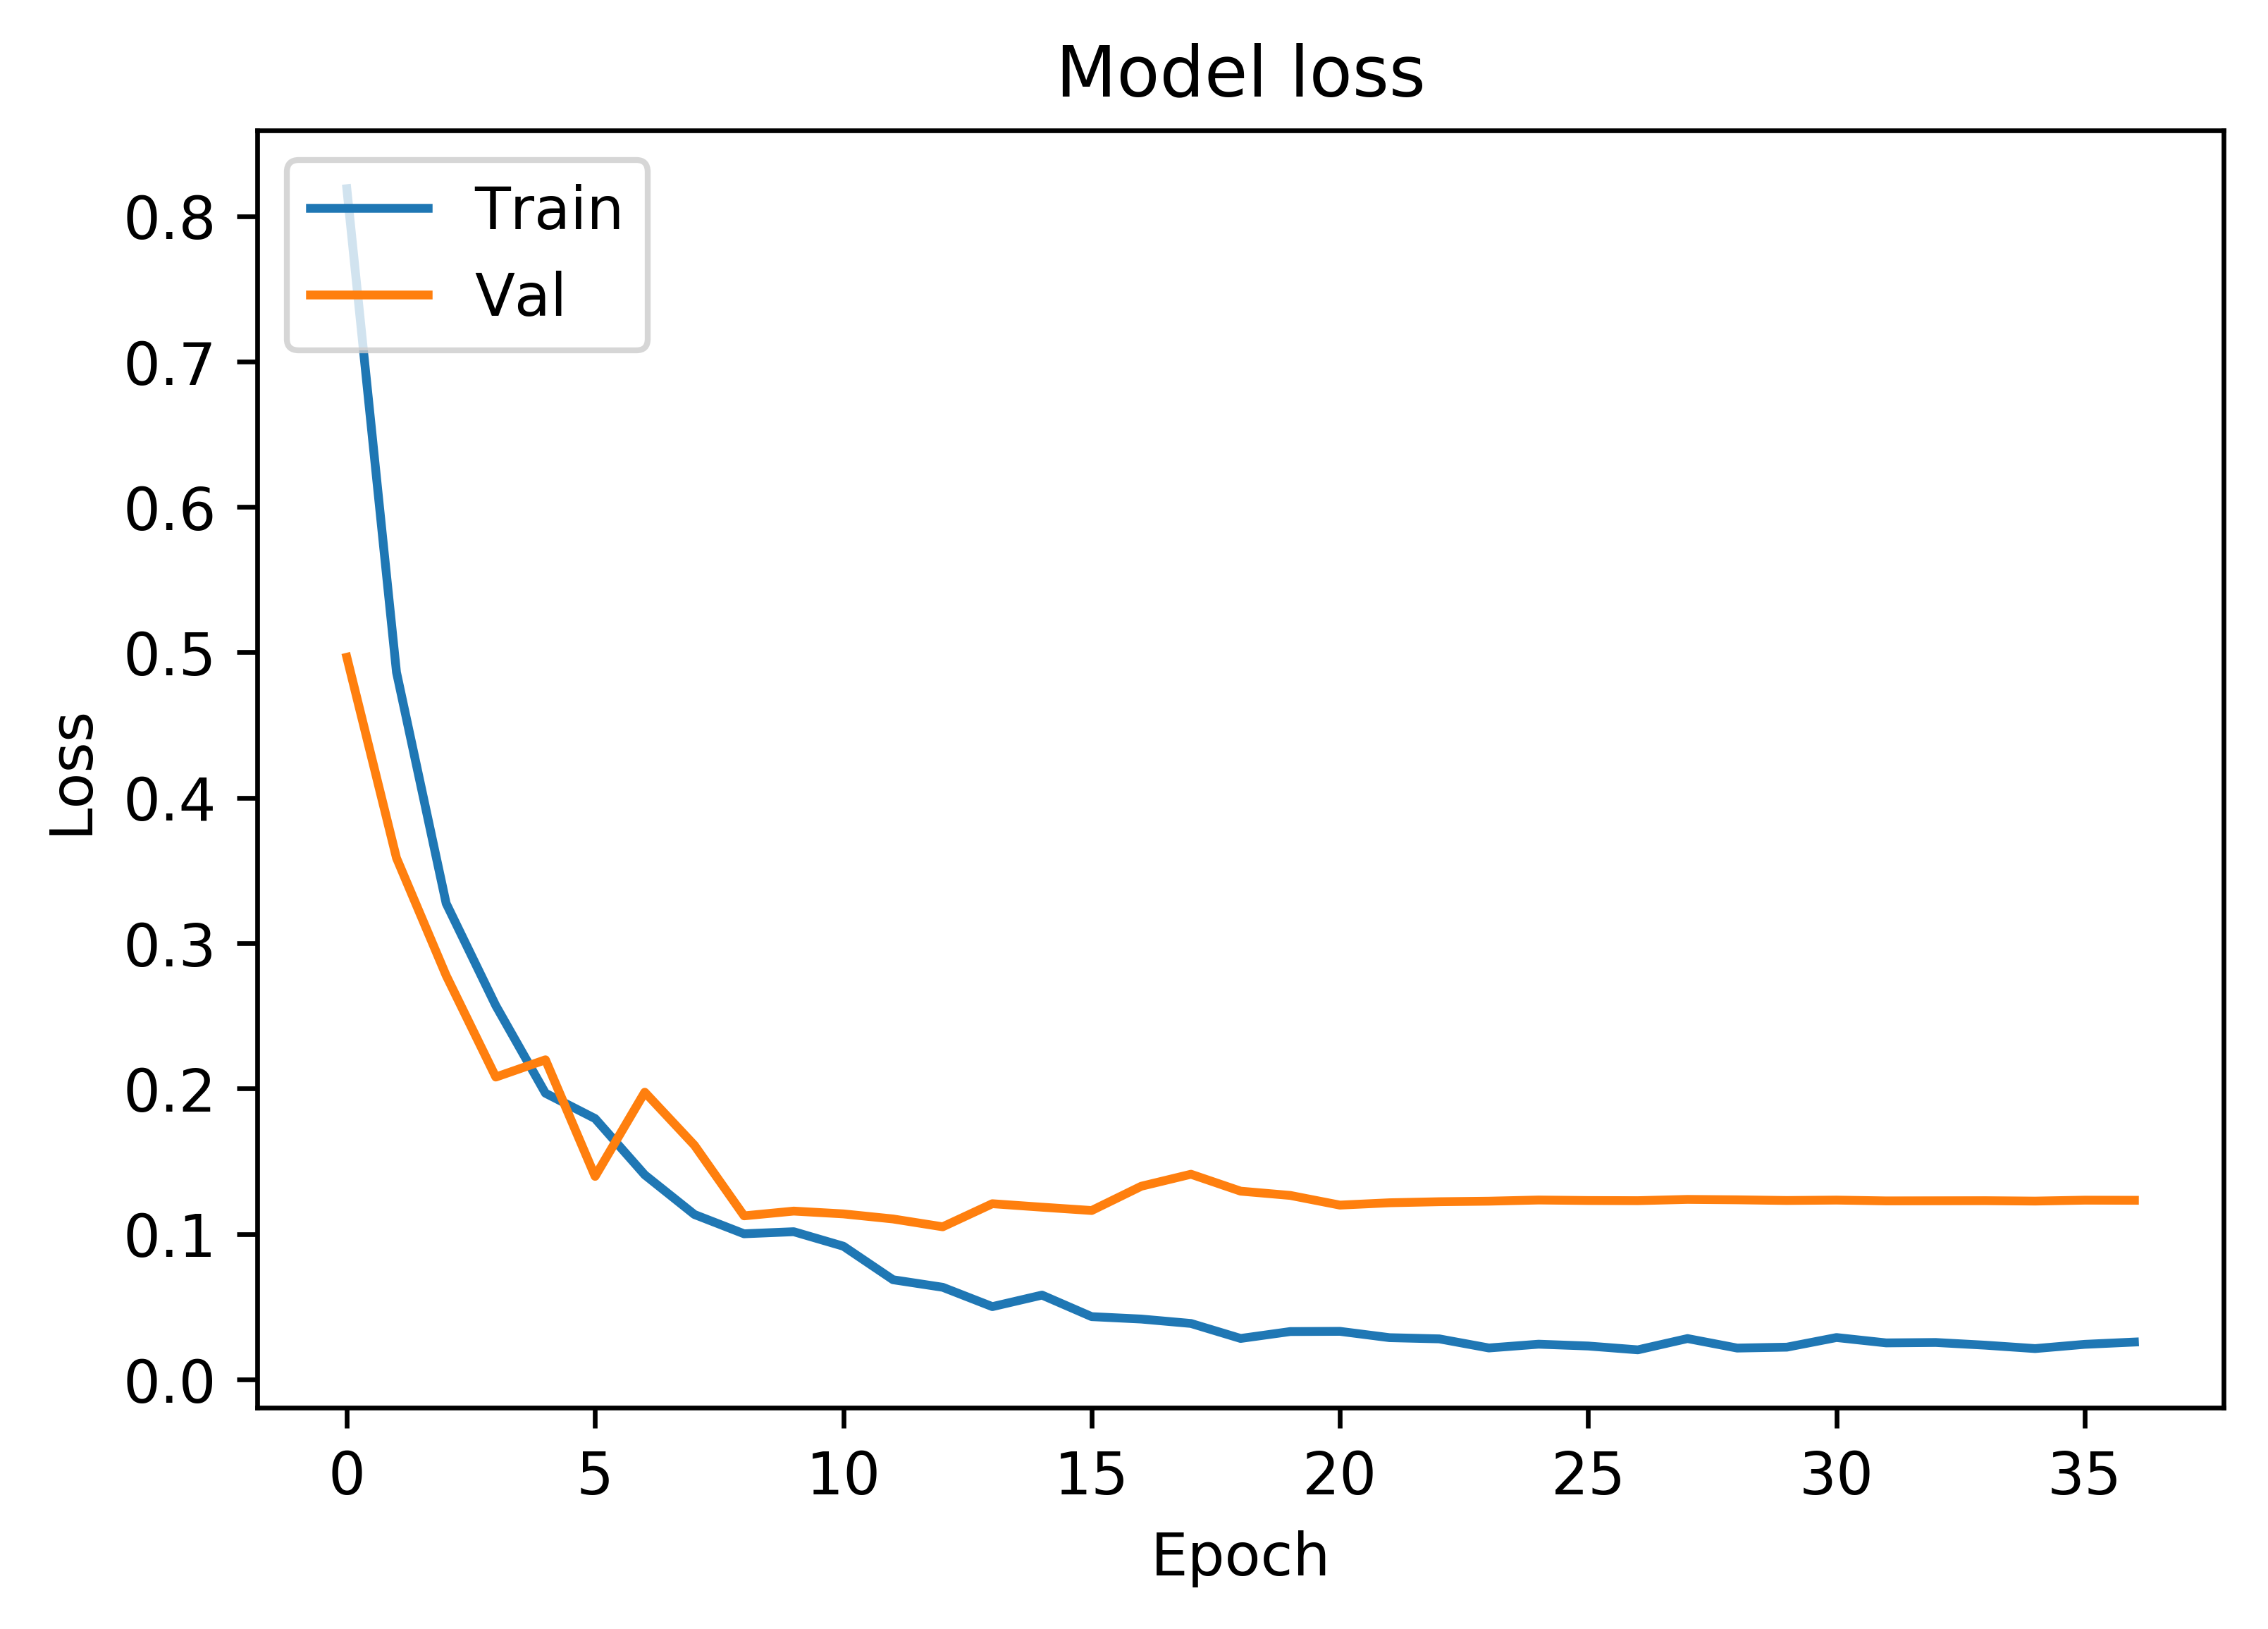

Results from K-fold: 5
acc: 97.42%
1045/1045 [==============================] - 0s 170us/step
[0.1231858744495437, 0.9741626794258373]
          normal  abnormal
normal       661         7
abnormal      20       357
              precision    recall  f1-score   support

      normal       0.97      0.99      0.98       668
    abnormal       0.98      0.95      0.96       377

   micro avg       0.97      0.97      0.97      1045
   macro avg       0.98      0.97      0.97      1045
weighted avg       0.97      0.97      0.97      1045

Average for kfold accuracy and stdev
97.38% (+/- 0.14%)
Average classification report for all folds
              precision  recall  f1_score  support
class                                             
abnormal          0.968   0.964     0.964    377.6
macro_avg         0.972   0.970     0.970   1045.8
micro_avg         0.974   0.974     0.974   1045.8
normal            0.976   0.980     0.980    668.2
weighted_avg      0.974   0.974     0.974   1045.8


In [18]:
#set K folds to 5
cvscores = []
count = 1
confusion_matrix_list = []
report_list = []

for key, kfold in kfolds.items():
    print(key)
    train = kfold['train']
    val = kfold['valid']
    
    print('K-: {}'.format(key))
            
    print("Samples from Training")
    print_samples(samples=train, text=X_text, tokenizer=tokenizer)
    print("============================")
    
    print("Samples from validation")
    print_samples(samples=val, text=X_text, tokenizer=tokenizer)
    print("============================")
    
    text_model = Generate_Model(model_type = "text_1d")
    text_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    filepath="unimodal_weights/best_weight_text_1d_only_k-fold_{}.hdf5".format(count)
    checkpoint = MultiGPUCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [reduce_lr, checkpoint, early_stopping]

    history = text_model.fit([X_text[train]], y[train], 
                     epochs=epochs, batch_size=bs, validation_data=([X_text[val]], y[val]),
                     callbacks=callbacks_list)
    plot_model_history(history)
    filepath="unimodal_weights/final_weight_text_1d_only_k-fold_{}.hdf5".format(count)
    text_model.save_weights(filepath)
    scores = text_model.evaluate([X_text[val]], y[val], verbose=0)
    print('Results from K-fold: {}'.format(count))
    print("%s: %.2f%%" % (text_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    y_hat = test_model(text_model, zip(X_text[val], y[val]), image = False, text = True, 
                       class_names=class_names)
    cm = confusion_matrix([np.argmax(t) for t in y[val]], y_hat)
    confusion_matrix_list.append(pd.DataFrame(cm, index=class_names, columns=class_names))
    cr = classification_report([np.argmax(t) for t in y[val]], y_hat, target_names=class_names)
    report_list.append(classification_report_df(cr))
    count += 1
    print('================================================')
print('Average for kfold accuracy and stdev')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("Average classification report for all folds")
print(df_mean(report_list))

### Hold out method on 2/3 training data and 1/3 testing data - Text 1D

In [19]:
reduce_lr_final = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
text_model = Generate_Model(model_type = "text_1d")
text_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
filepath="unimodal_weights/best_weight_text_1d_only_final.hdf5"
checkpoint = MultiGPUCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [reduce_lr_final, checkpoint, early_stopping]

history = text_model.fit([X_text[final_train]], y[final_train], 
                 epochs=epochs, batch_size=bs, validation_split=None, callbacks=callbacks_list)
filepath="unimodal_weights/final_weight_text_1d_only_final.hdf5"
text_model.save_weights(filepath)
print('========================TEST MODEL=======================')
scores = text_model.evaluate([X_text[final_test]], y[final_test], verbose=0)
print("%s: %.2f%%" % (text_model.metrics_names[1], scores[1]*100))
y_hat = test_model(text_model, zip(X_text[final_test], y[final_test]), image = False, text = True, 
                   class_names=class_names)

[INFO] training with 2 GPUs...
Epoch 1/150
5229/5229 [==============================] - 10s 2ms/step - loss: 0.8051 - acc: 0.7089

Epoch 00001: acc improved from -inf to 0.70893, saving model to unimodal_weights/best_weight_text_1d_only_final.hdf5
Epoch 2/150
5229/5229 [==============================] - 1s 117us/step - loss: 0.4371 - acc: 0.8306

Epoch 00002: acc improved from 0.70893 to 0.83056, saving model to unimodal_weights/best_weight_text_1d_only_final.hdf5
Epoch 3/150
5229/5229 [==============================] - 1s 122us/step - loss: 0.2901 - acc: 0.8843

Epoch 00003: acc improved from 0.83056 to 0.88430, saving model to unimodal_weights/best_weight_text_1d_only_final.hdf5
Epoch 4/150
5229/5229 [==============================] - 1s 119us/step - loss: 0.2275 - acc: 0.9155

Epoch 00004: acc improved from 0.88430 to 0.91547, saving model to unimodal_weights/best_weight_text_1d_only_final.hdf5
Epoch 5/150
5229/5229 [==============================] - 1s 133us/step - loss: 0.1983 - a

### K fold validation on text_2d only

fold_1
K-: fold_1
Samples from Training
[1267 5926 2215 2933]
id: 1267
comparison none available indication xxxx-year-old female dyspnea findings heart size normal pneumothorax pleural effusion focal airspace disease bony structures appear intact impression acute cardiopulmonary abnormality 
id: 5926
comparison portable chest xxxx indication xxxx-year-old female chest pain findings heart size within normal limits focal airspace disease pneumothorax pleural effusion impression acute cardiopulmonary findings 
id: 2215
indication colorectal mass evaluate lung mass findings heart normal size mediastinum stable calcified right paratracheal lymph xxxx seen aorta atherosclerotic lungs mildly hypoinflated without focal consolidation pleural effusion impression acute disease 
id: 2933
comparison none indication left sided chest pain findings lungs appear clear heart pulmonary xxxx normal pleural spaces clear mediastinal contours normal impression acute acute cardiopulmonary disease 
Samples fro

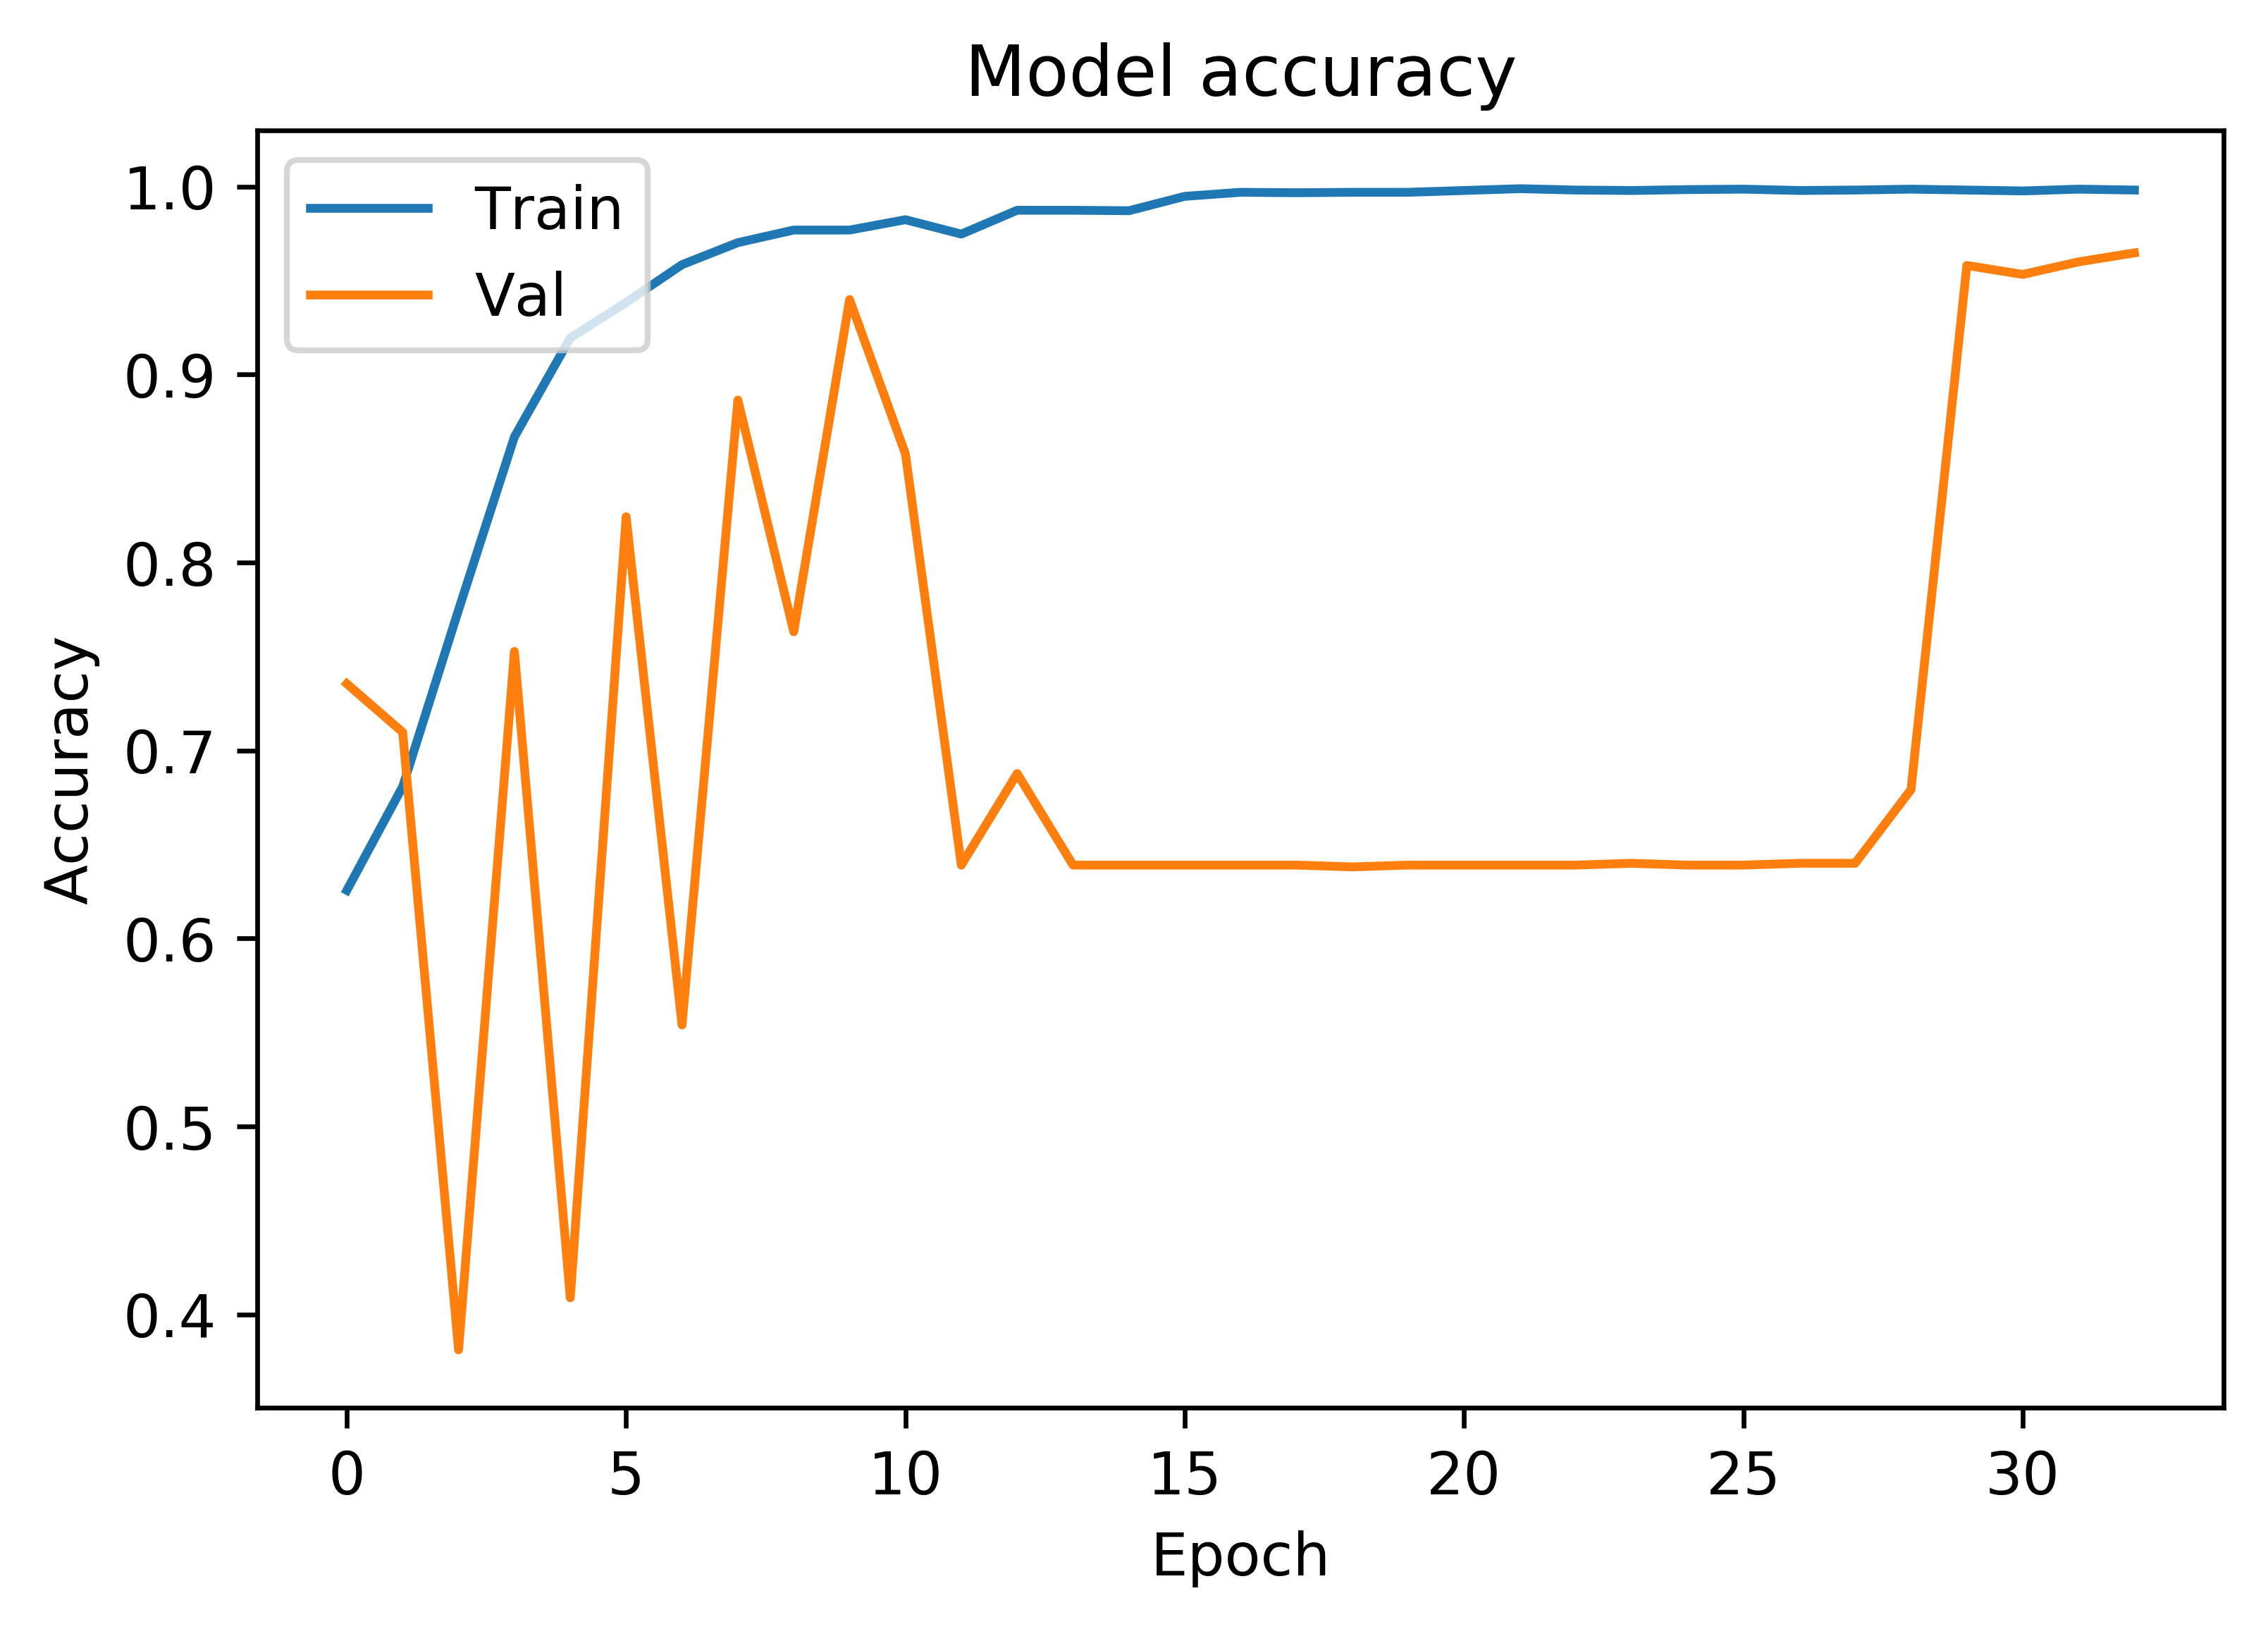

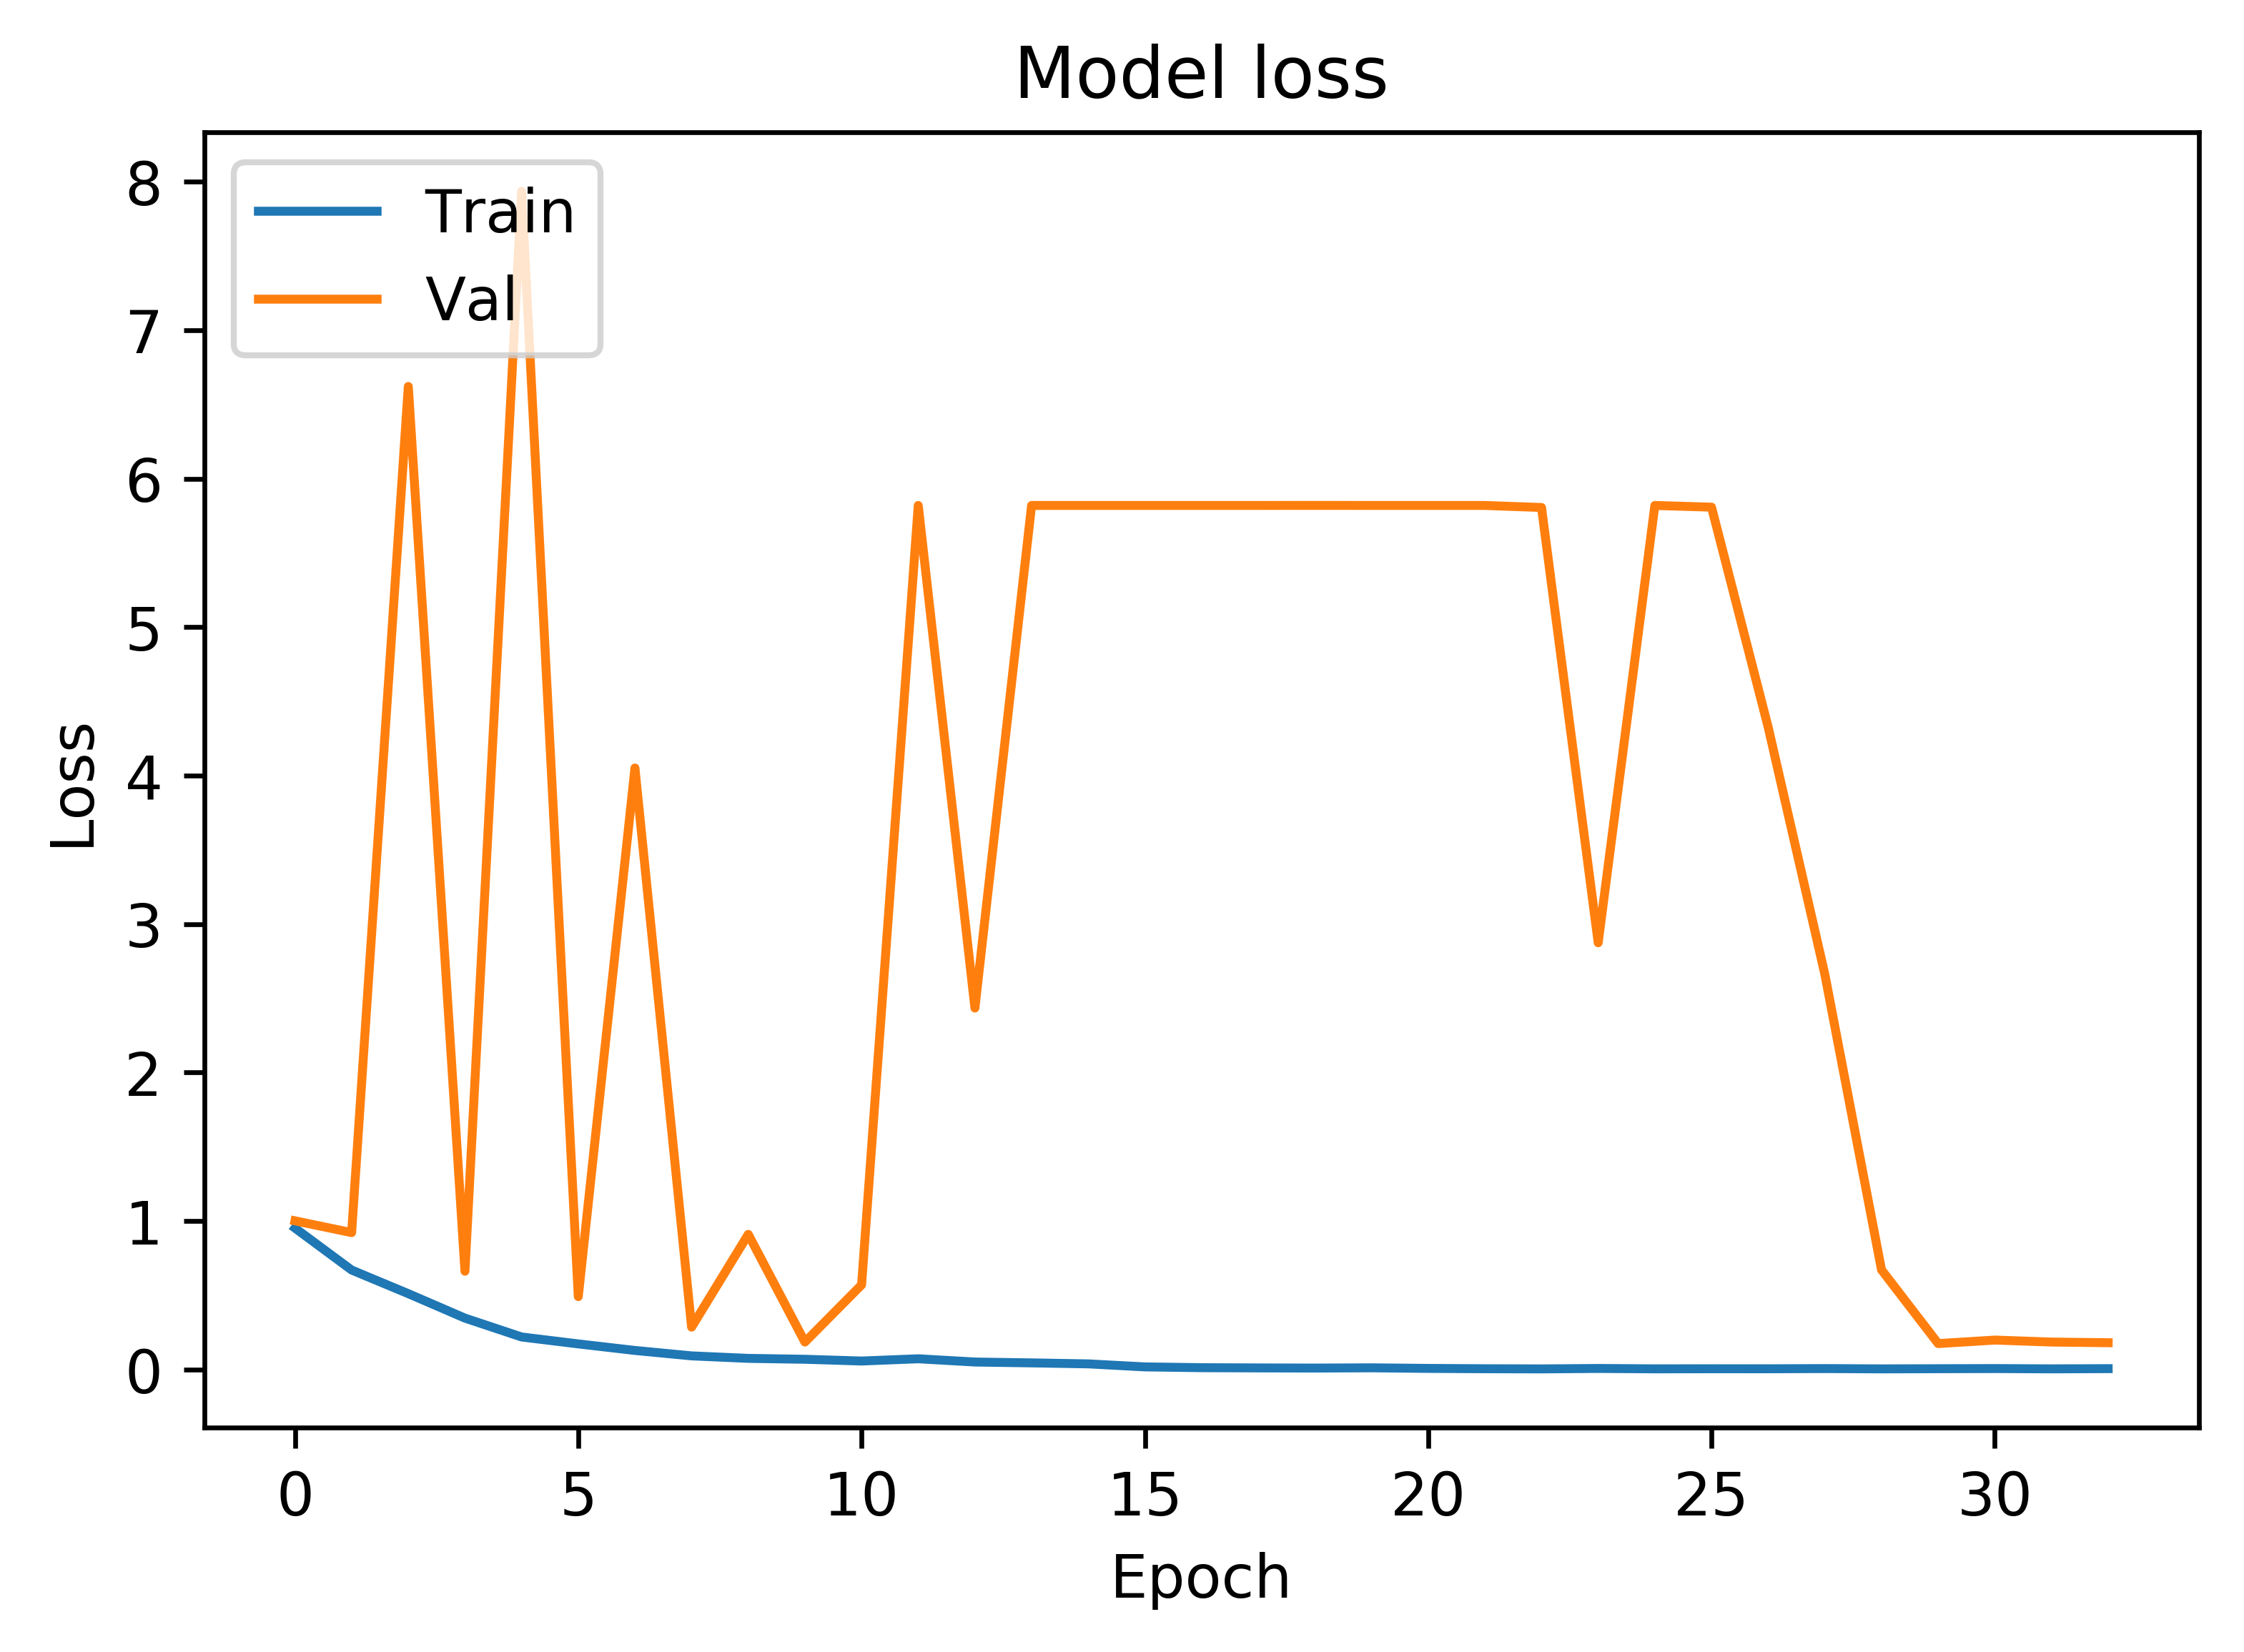

Results from K-fold: 1
acc: 96.47%
1047/1047 [==============================] - 1s 1ms/step
[0.18112499727987627, 0.9646609362353568]
          normal  abnormal
normal       648        21
abnormal      16       362
              precision    recall  f1-score   support

      normal       0.98      0.97      0.97       669
    abnormal       0.95      0.96      0.95       378

   micro avg       0.96      0.96      0.96      1047
   macro avg       0.96      0.96      0.96      1047
weighted avg       0.96      0.96      0.96      1047

fold_2
K-: fold_2
Samples from Training
[6945 4672 2690 2928]
id: 6945
comparison none indication xxxx yr old female dyspnea findings left chest wall mediport placement venous catheter tip superior xxxx xxxx normal cardiac contours pneumothorax pleural effusions clear lungs bilaterally xxxx fracture seen l areas sclerosis throughout thoracic lumbar spine impression pathologic fractures seen l left venous catheter svc 
id: 4672
comparison radiographs ches

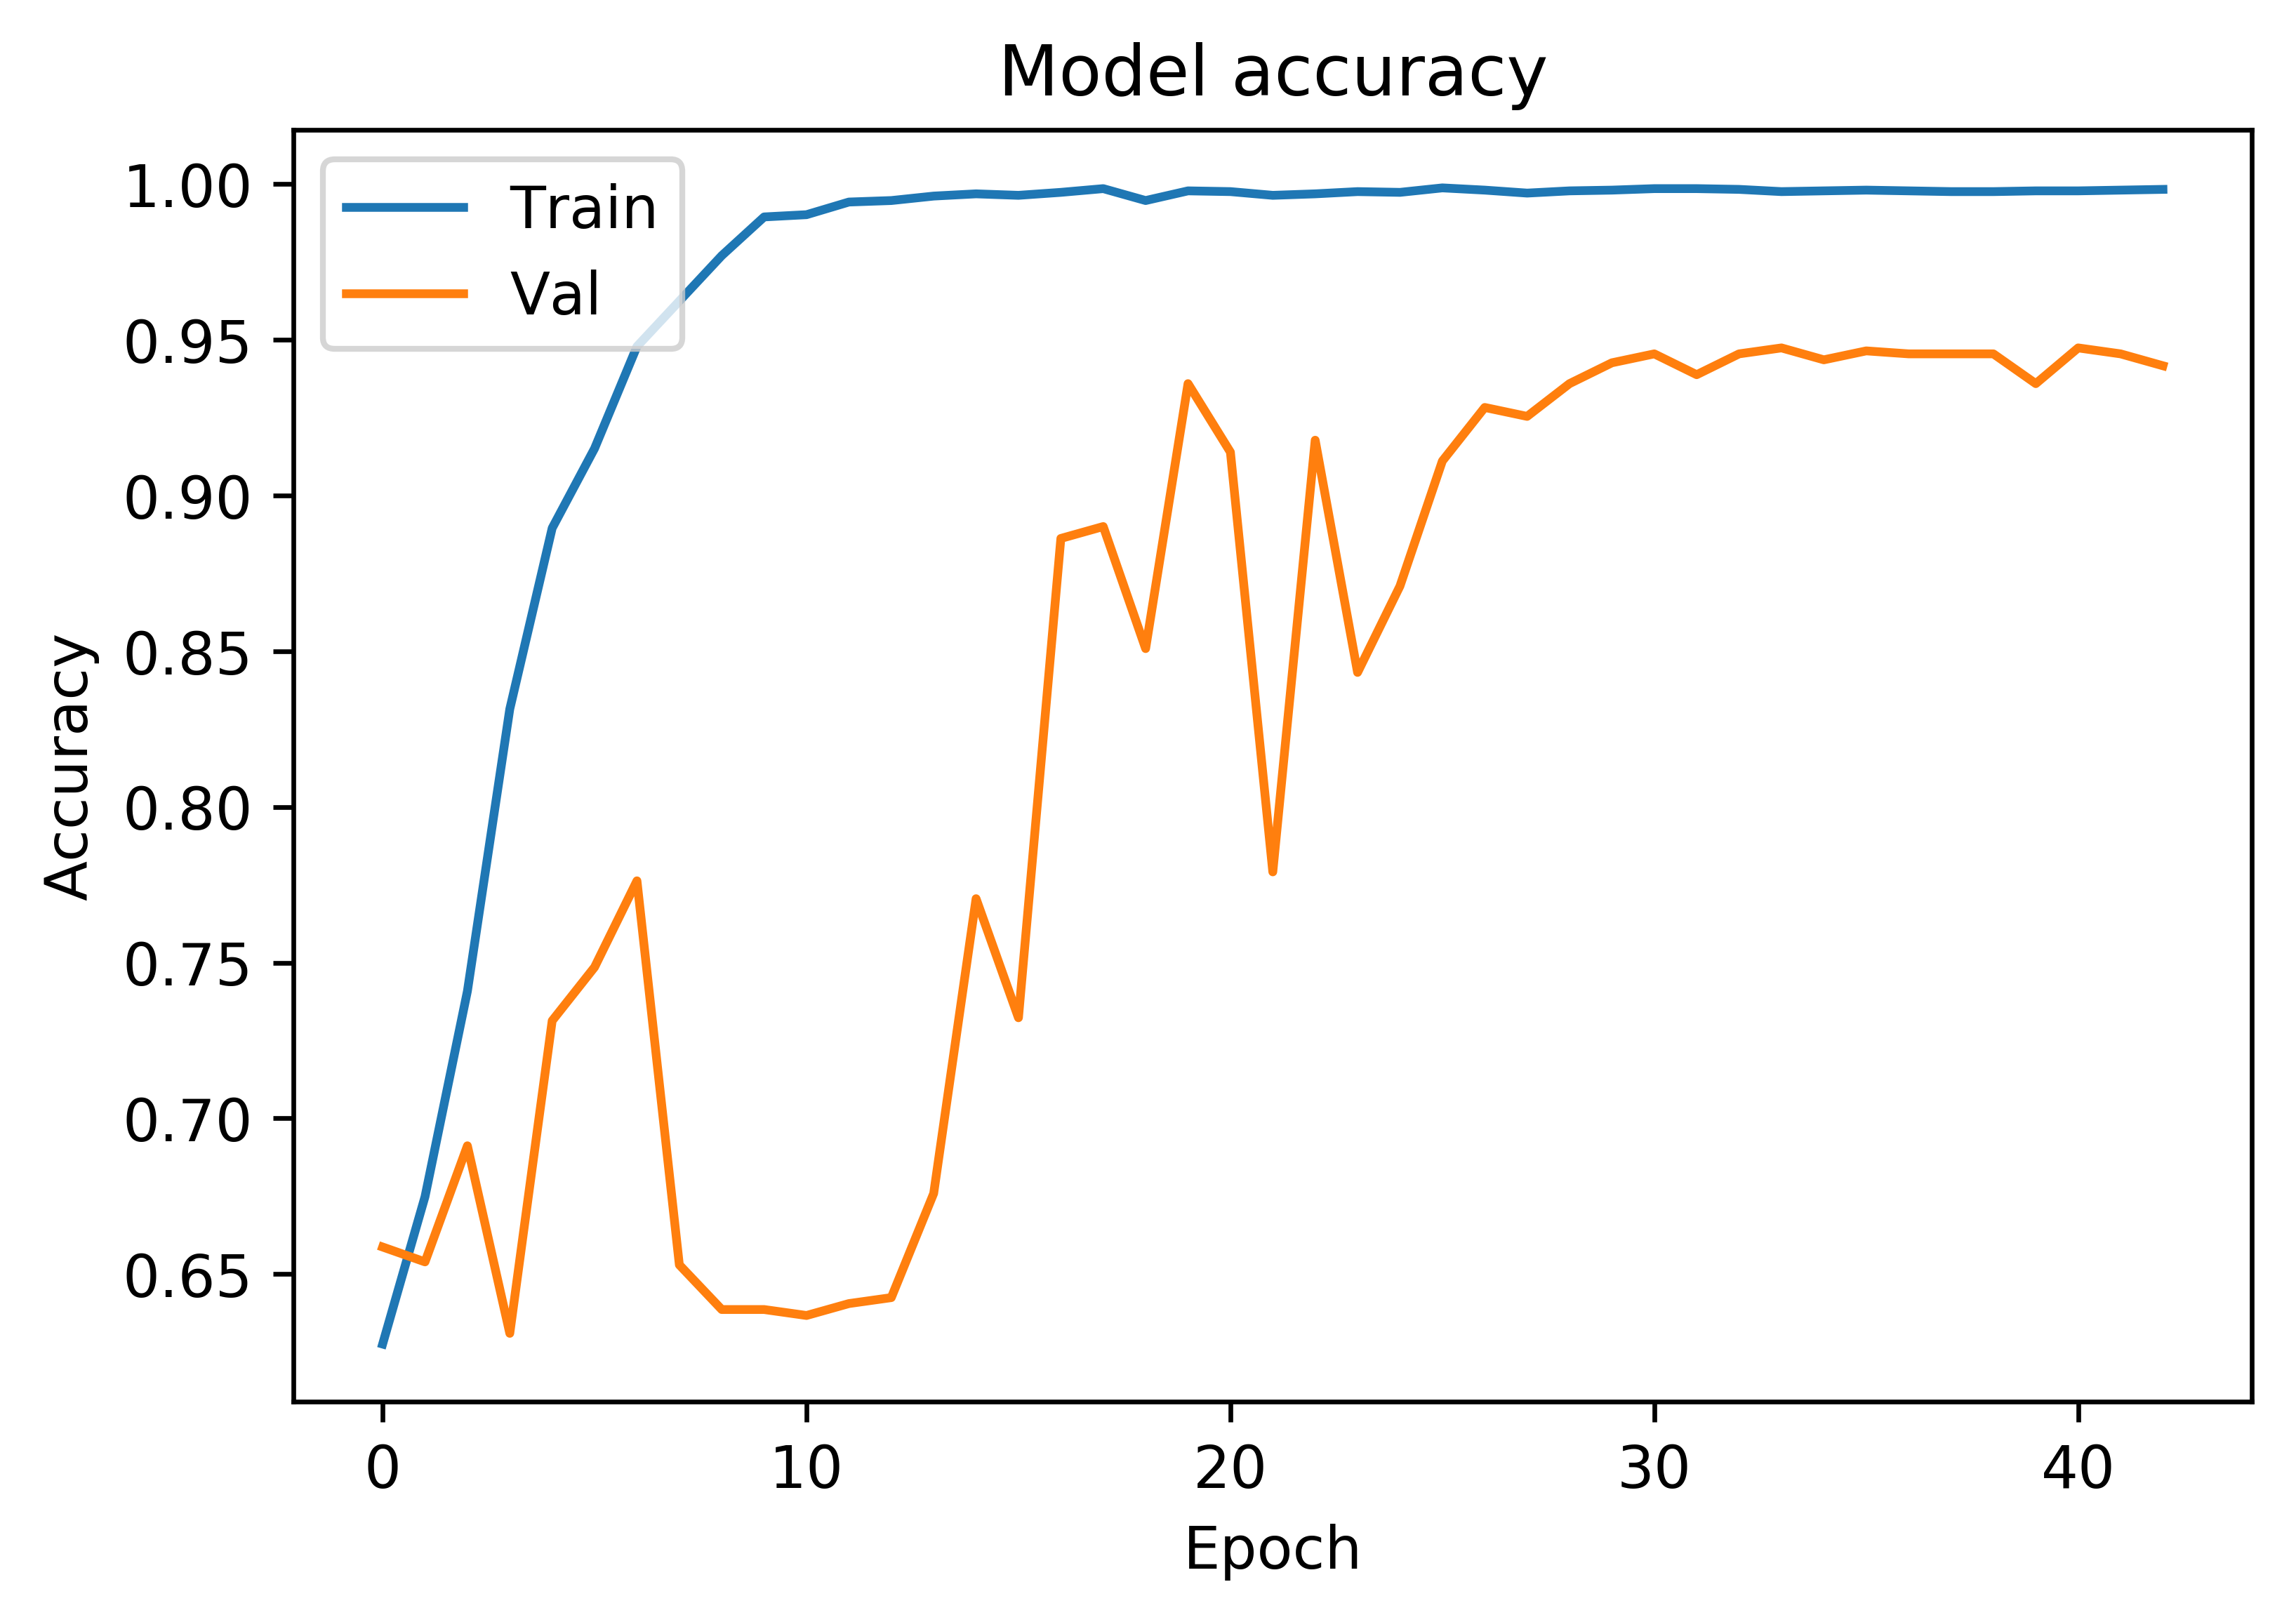

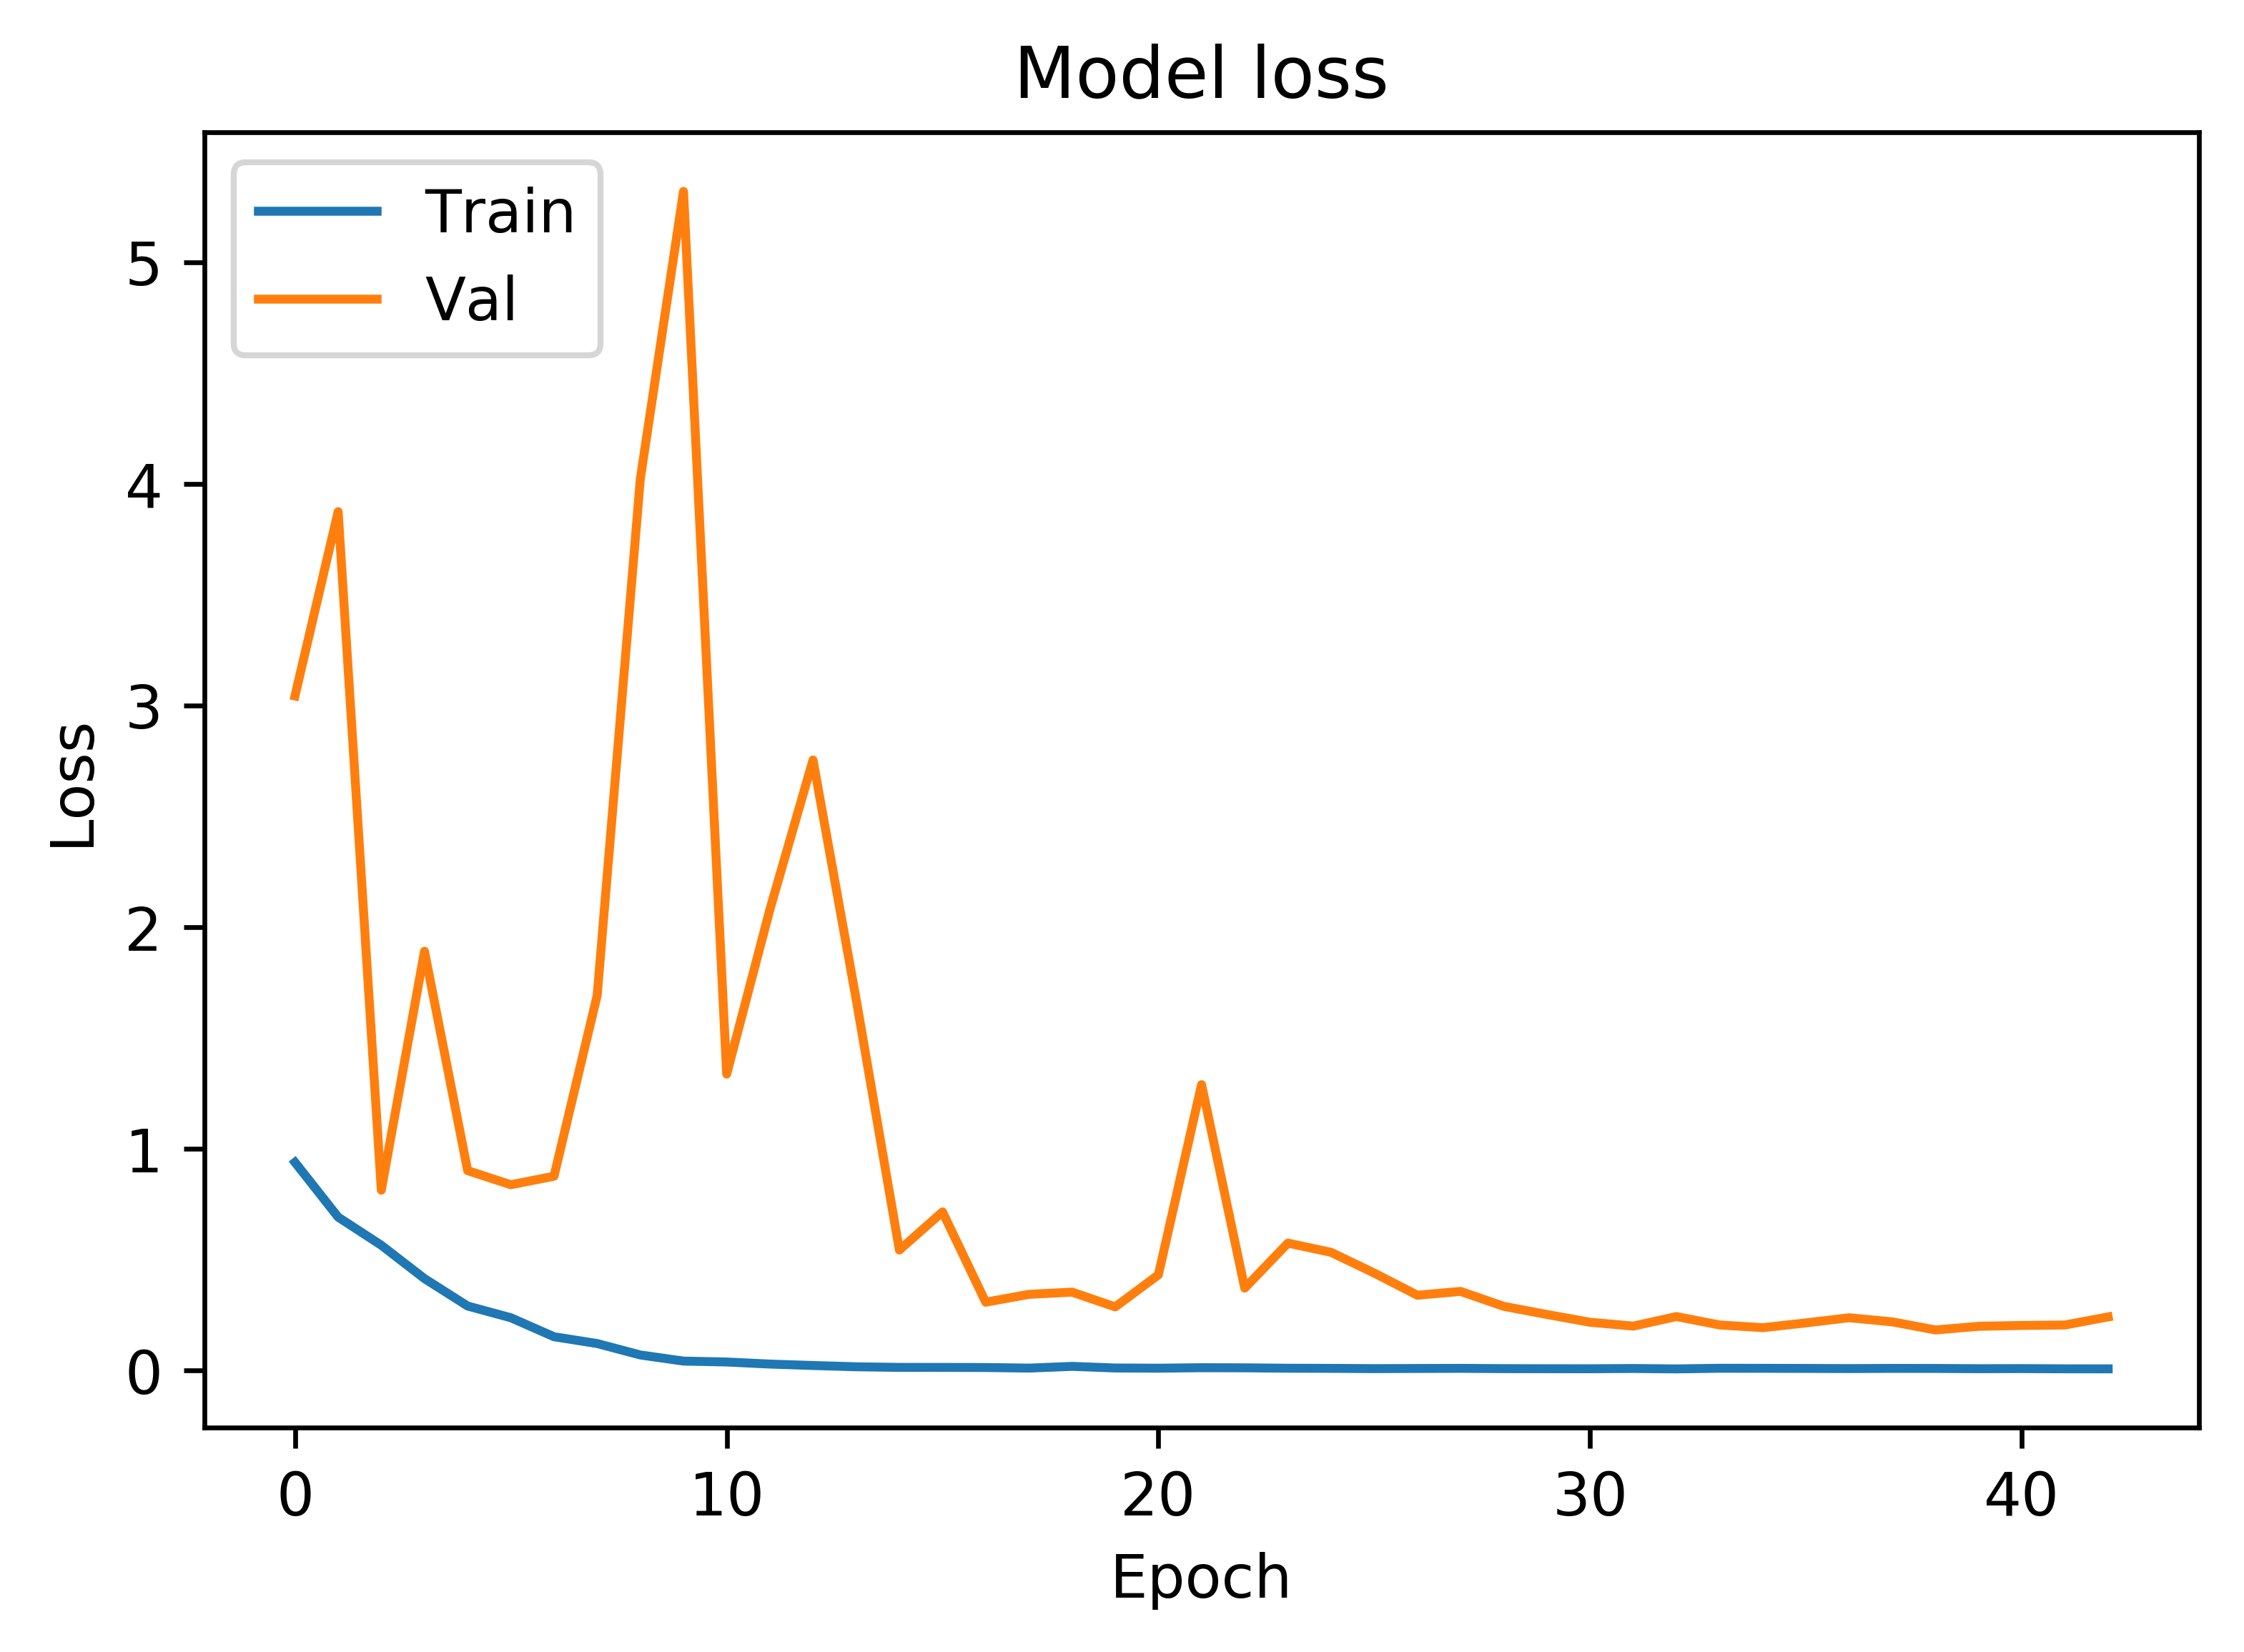

Results from K-fold: 2
acc: 94.17%
1046/1046 [==============================] - 1s 1ms/step
[0.24090651649604222, 0.9416826009522432]
          normal  abnormal
normal       626        42
abnormal      19       359
              precision    recall  f1-score   support

      normal       0.97      0.94      0.95       668
    abnormal       0.90      0.95      0.92       378

   micro avg       0.94      0.94      0.94      1046
   macro avg       0.93      0.94      0.94      1046
weighted avg       0.94      0.94      0.94      1046

fold_3
K-: fold_3
Samples from Training
[1892 2643 6303 1168]
id: 1892
comparison none indication chest pain shortness breath findings lungs pleural spaces show acute abnormality heart size pulmonary vascularity within normal limits impression acute pulmonary abnormality 
id: 2643
indication chest pain impression heart size normal lungs clear 
id: 6303
comparison none indication history smoking status post left upper lobectomy impression heart size norma

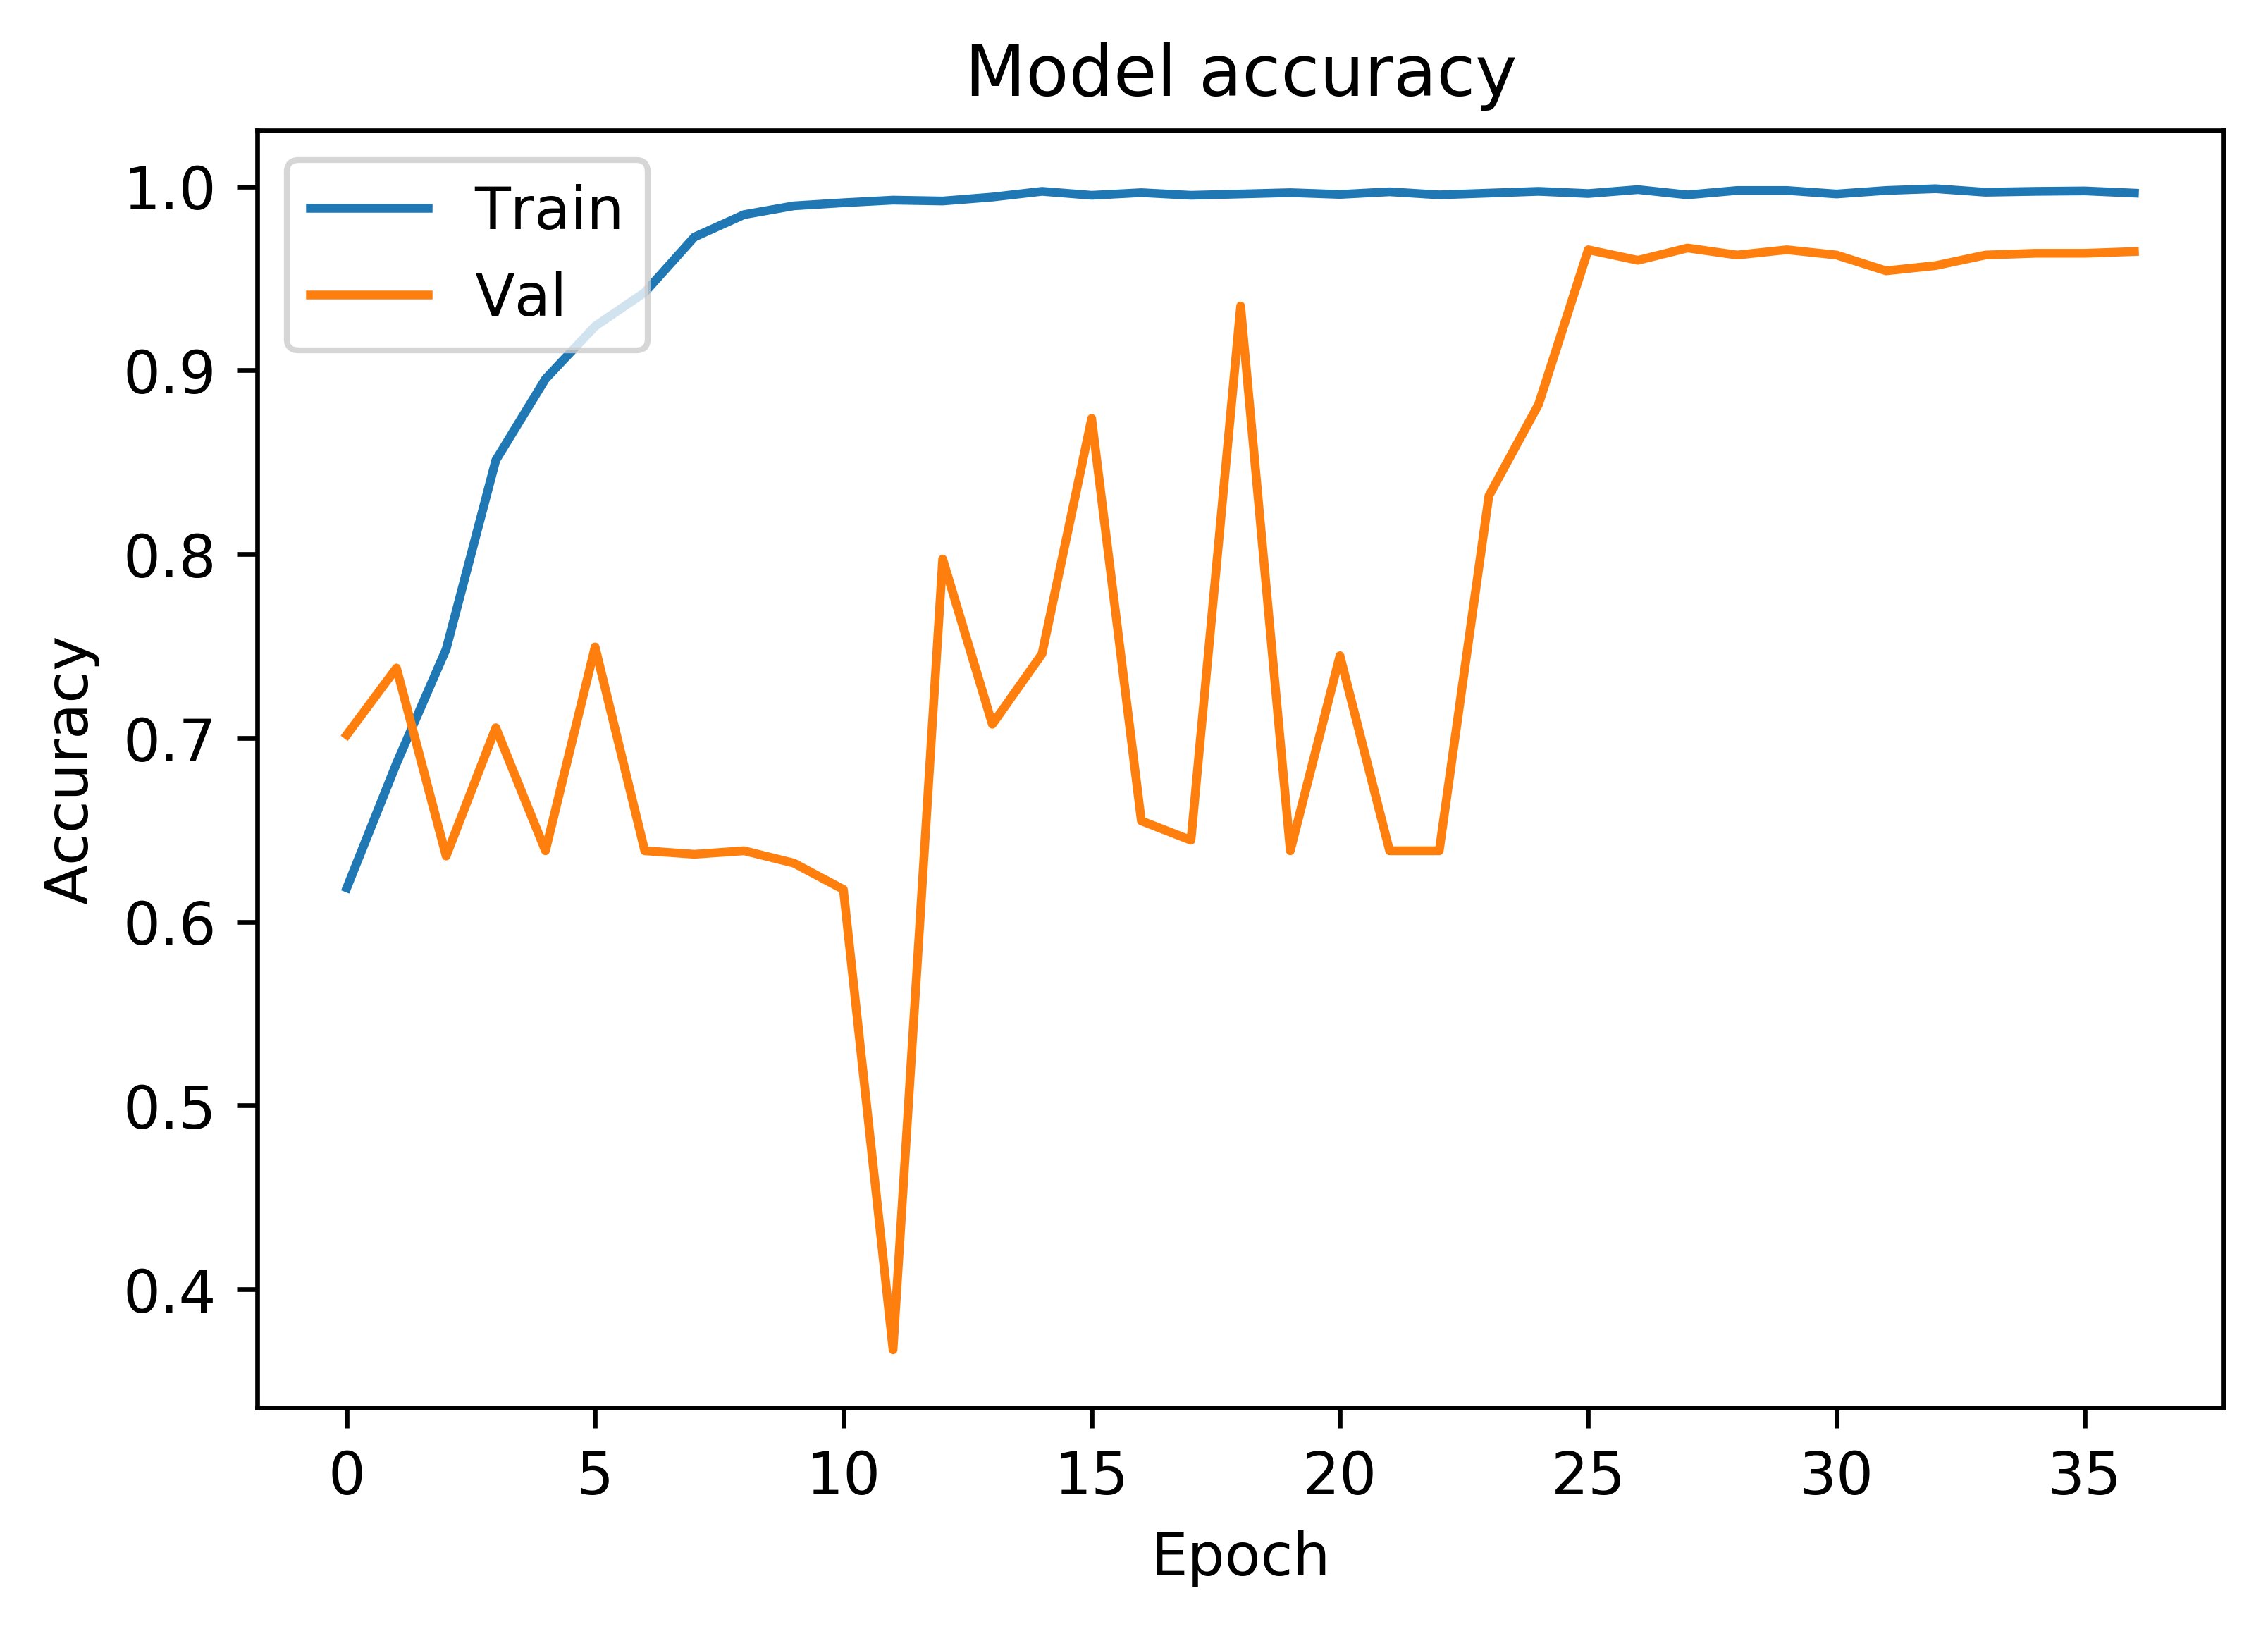

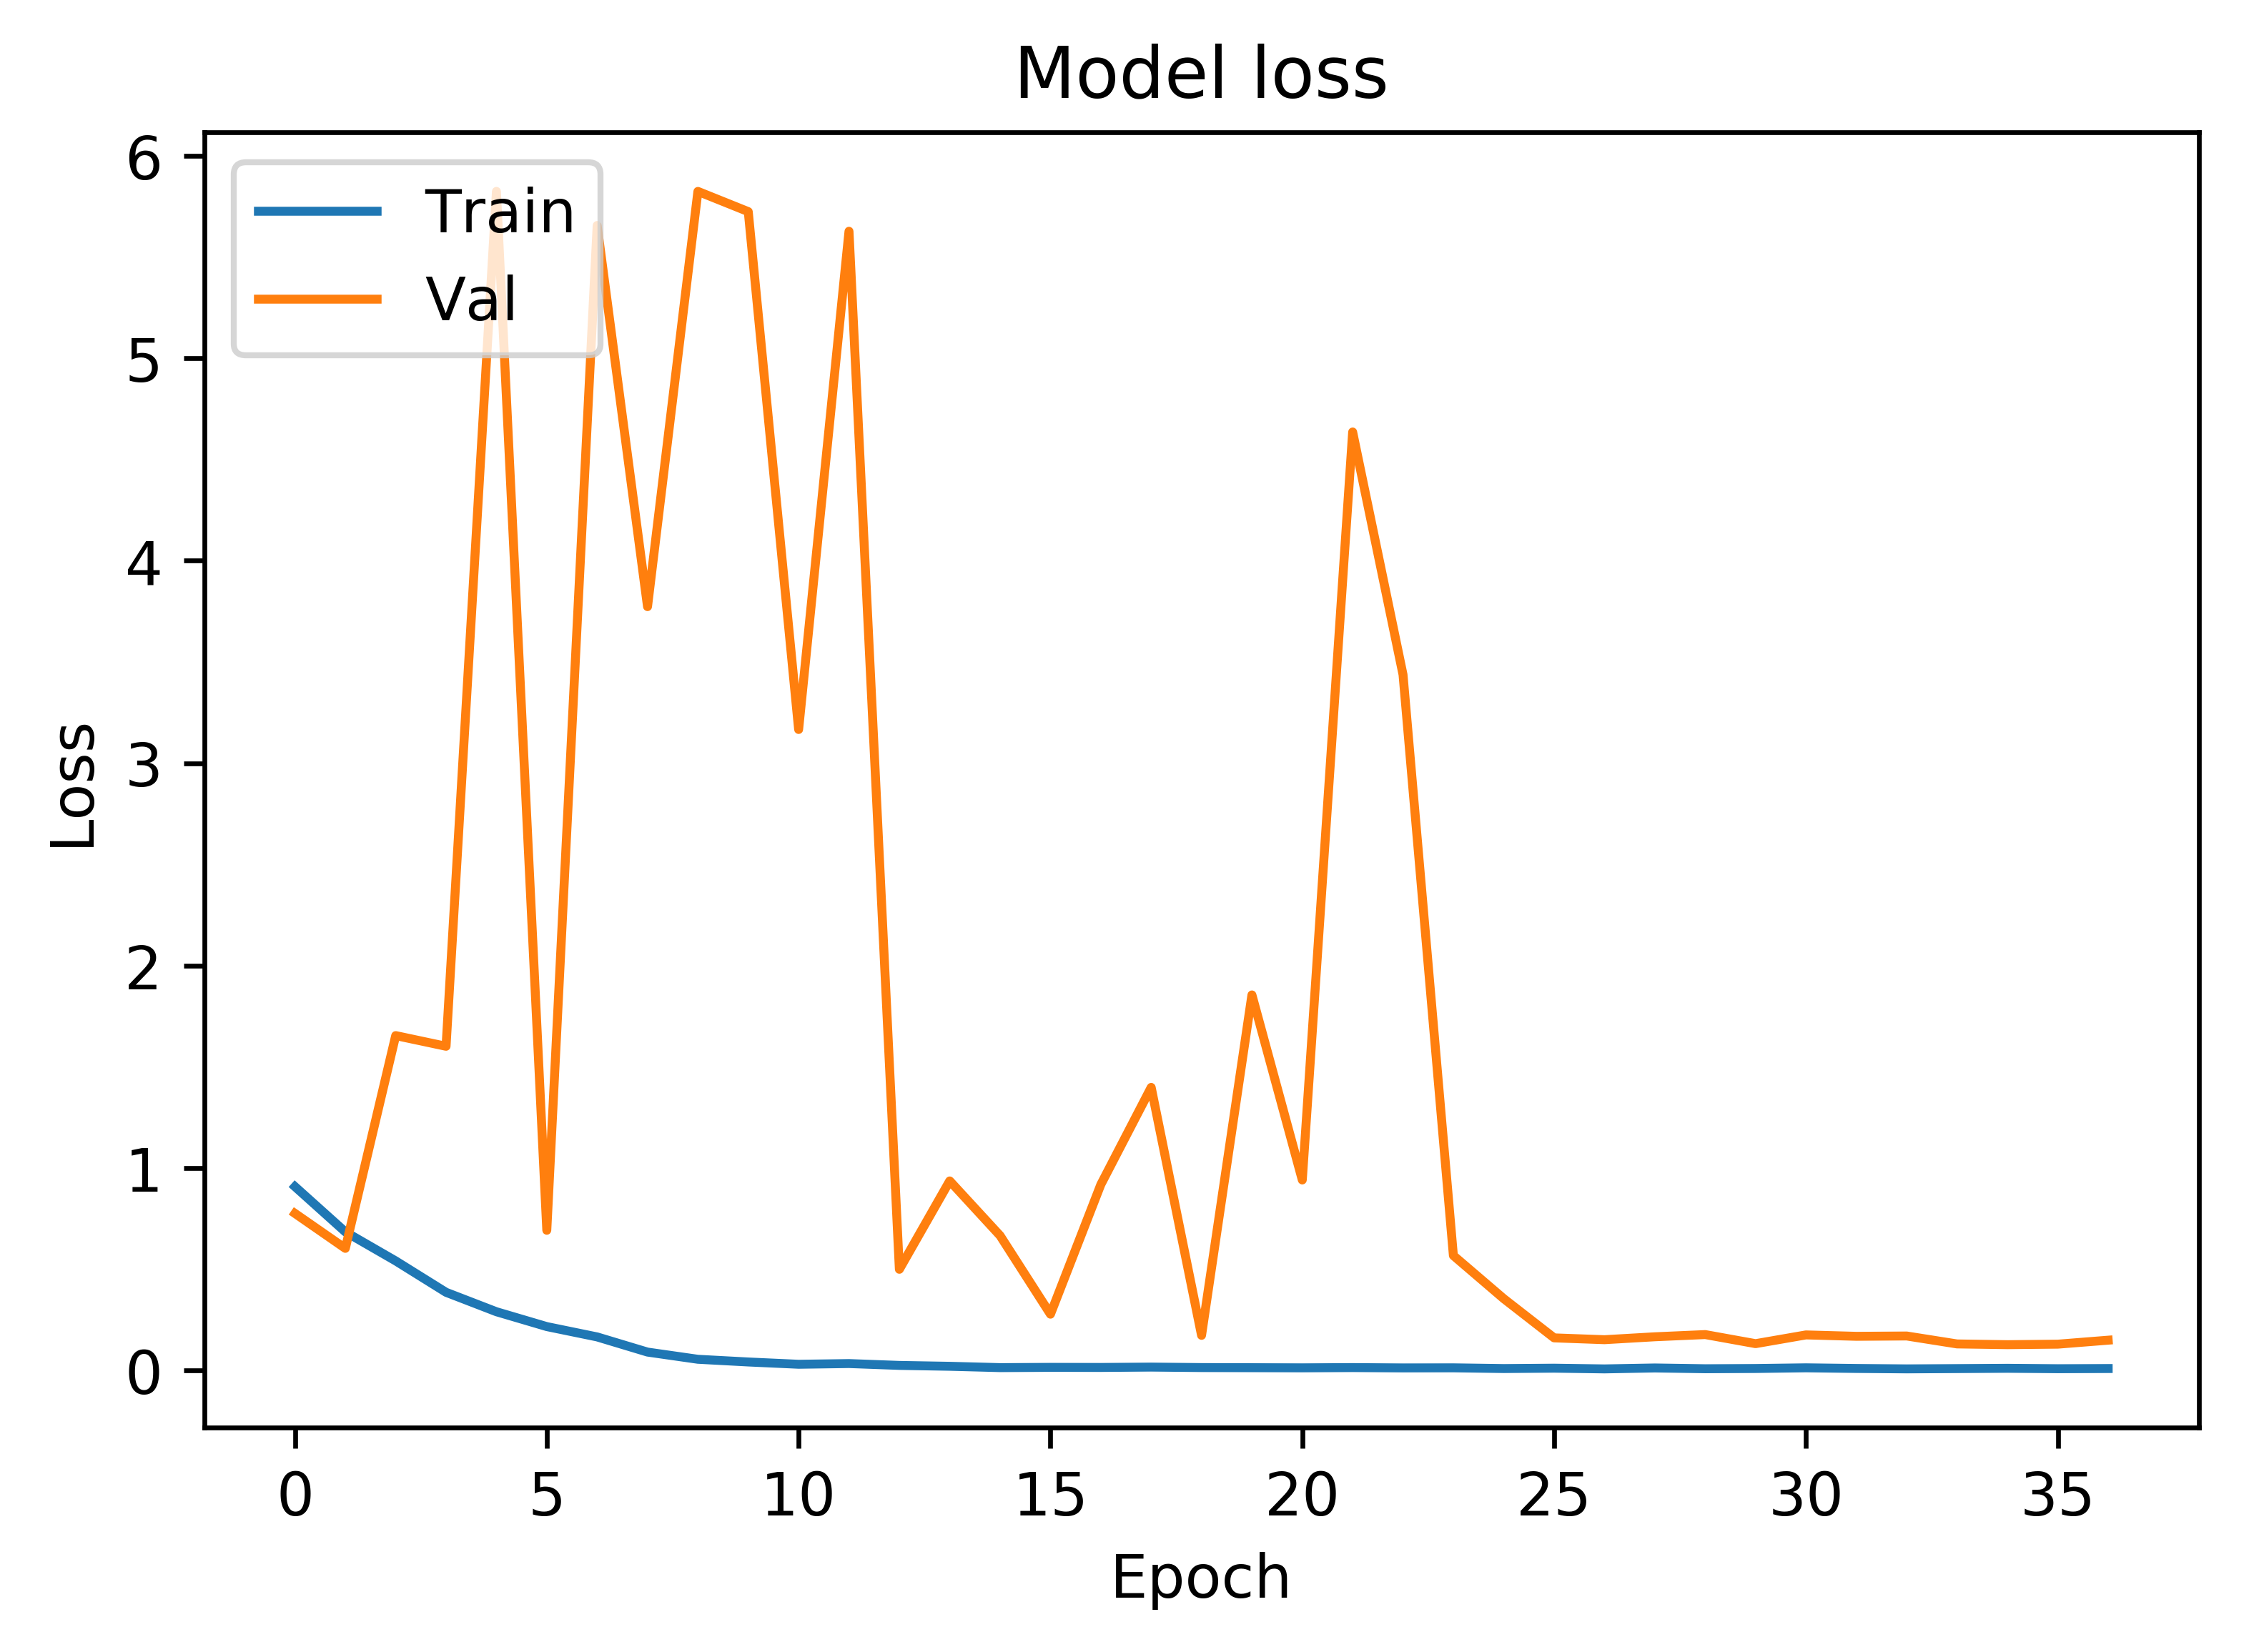

Results from K-fold: 3
acc: 96.46%
1046/1046 [==============================] - 1s 1ms/step
[0.14995869112345275, 0.9646271507097248]
          normal  abnormal
normal       643        25
abnormal      12       366
              precision    recall  f1-score   support

      normal       0.98      0.96      0.97       668
    abnormal       0.94      0.97      0.95       378

   micro avg       0.96      0.96      0.96      1046
   macro avg       0.96      0.97      0.96      1046
weighted avg       0.97      0.96      0.96      1046

fold_4
K-: fold_4
Samples from Training
[3579  177 3127 5831]
id: 3579
comparison none indication xxxx-year-old female chest pain findings cardiomediastinal silhouettes within normal limits lungs clear without focal consolidation pneumothorax pleural effusion bony thorax unremarkable impression acute cardiopulmonary abnormalities 
id: 177
indication xxxx-year-old male syncopal episode additional information obtained electronic medical record history lung

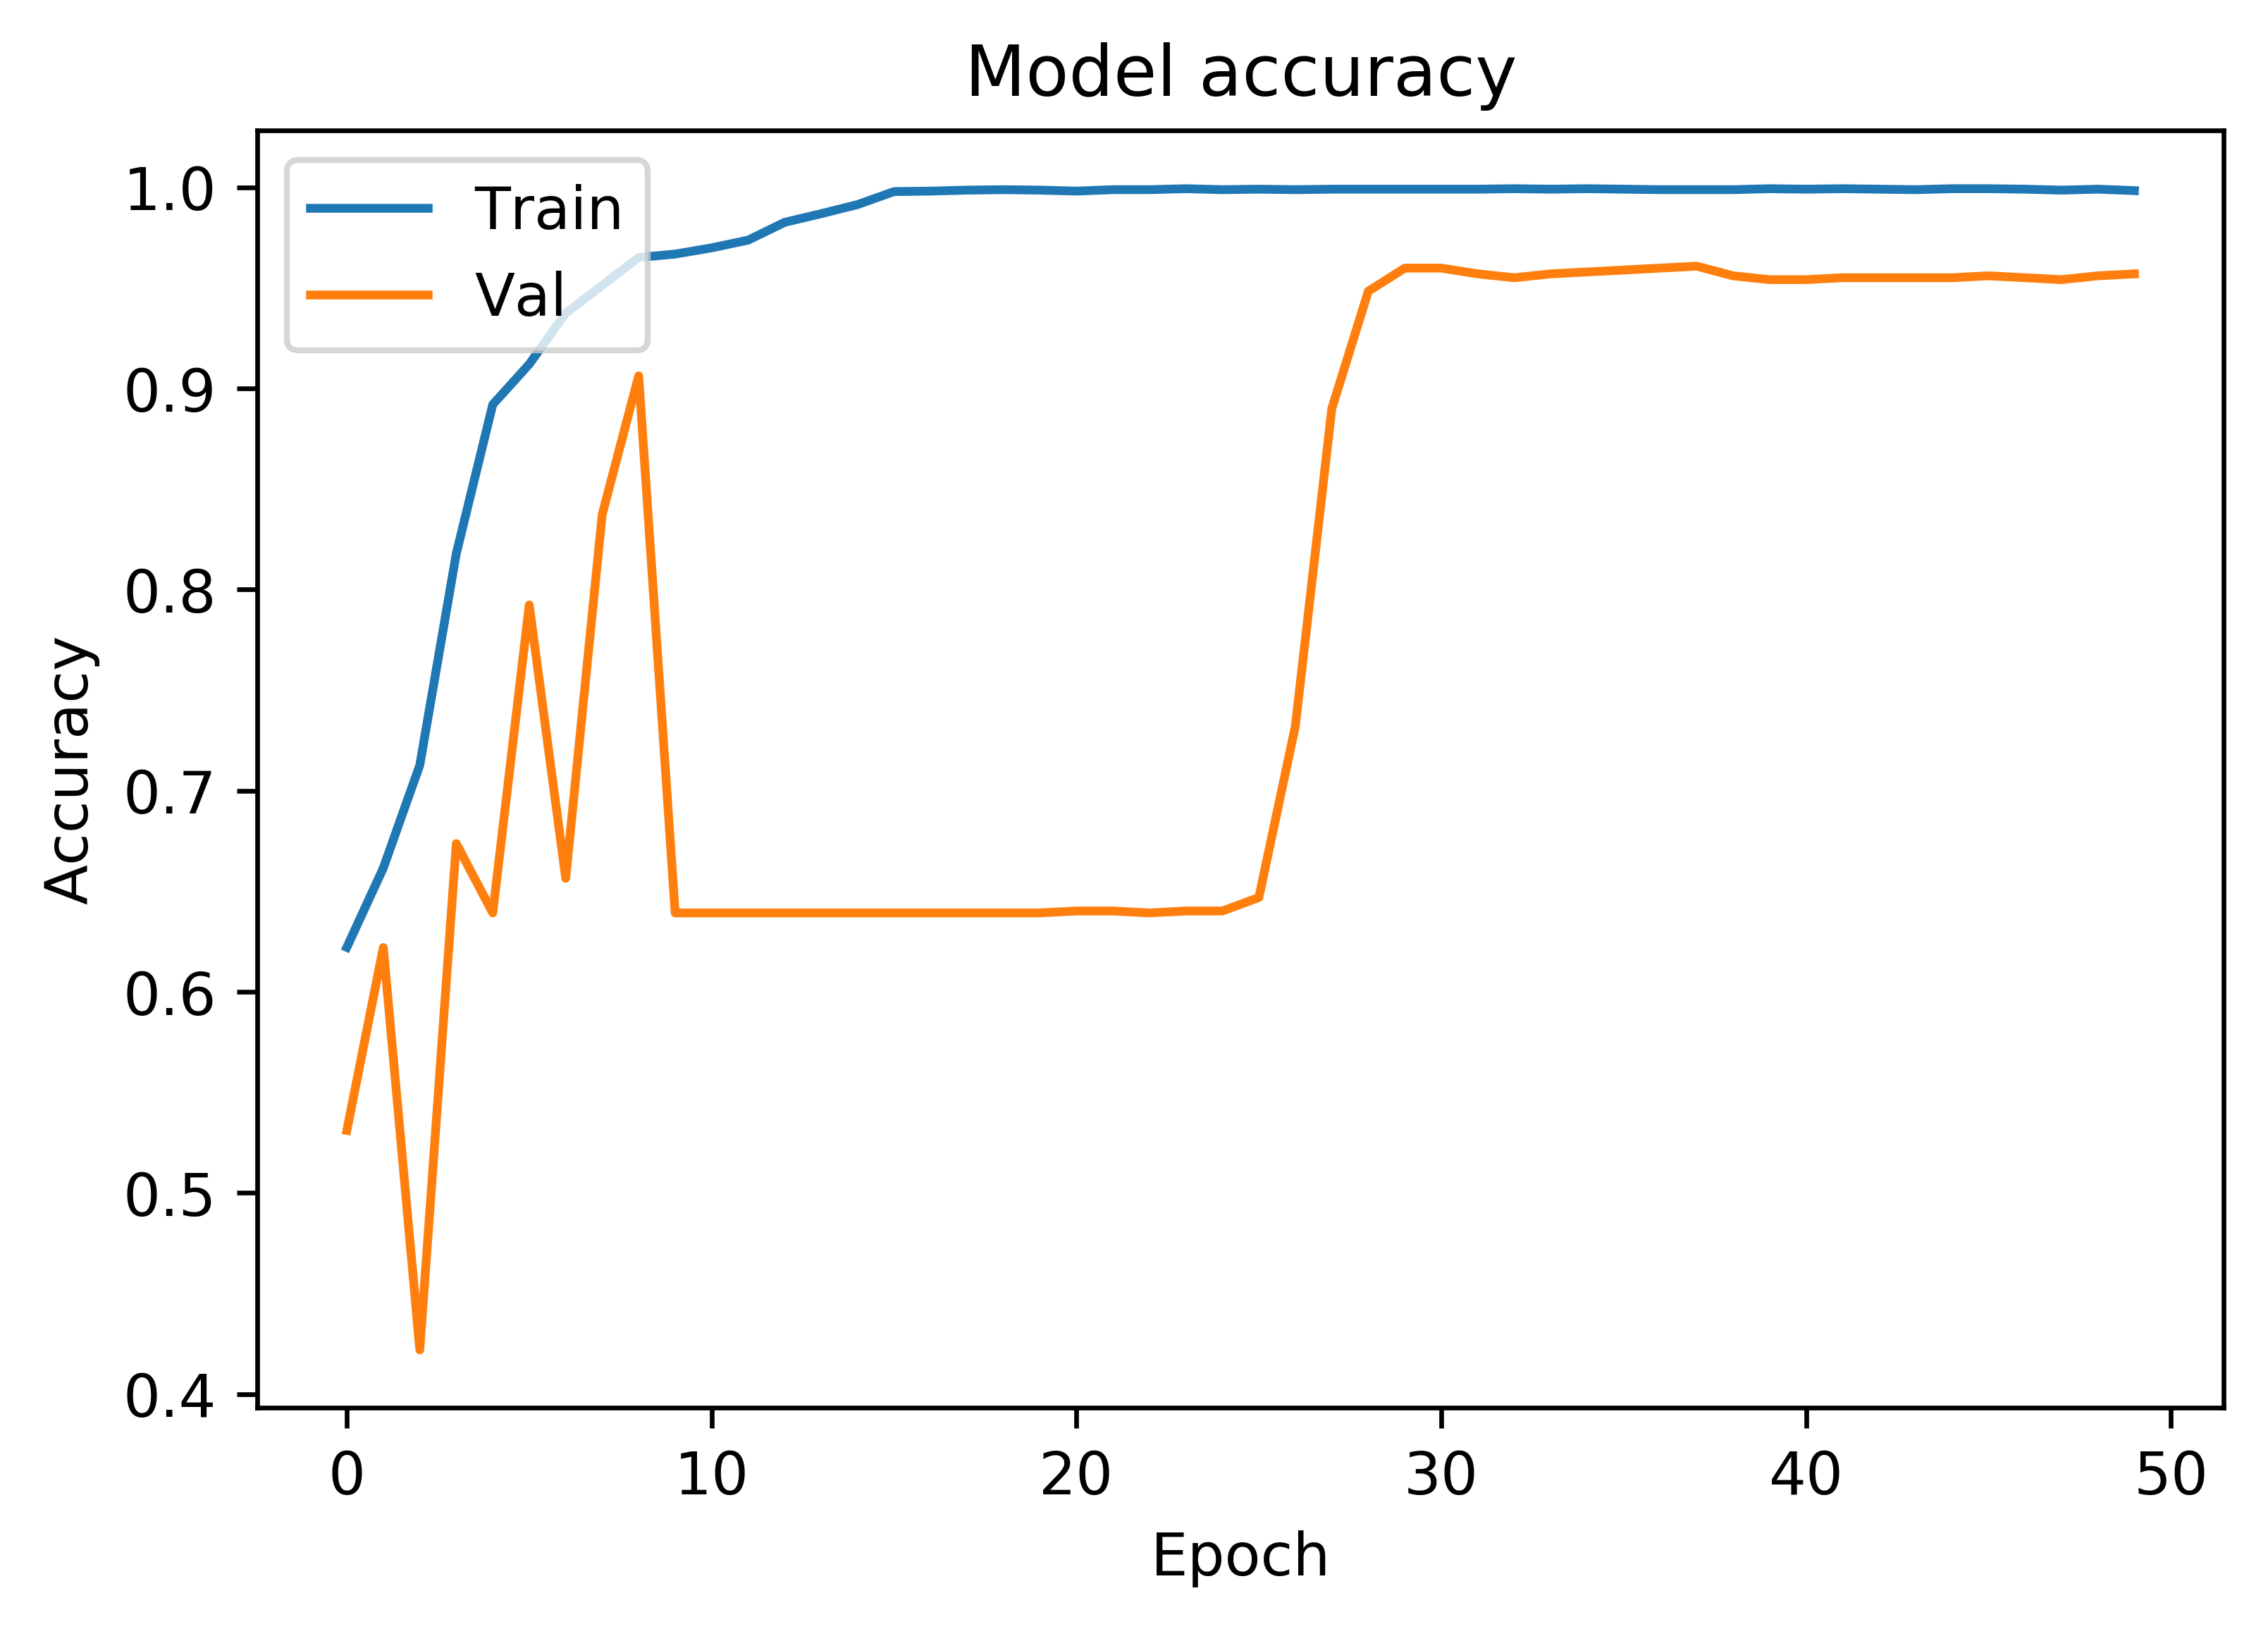

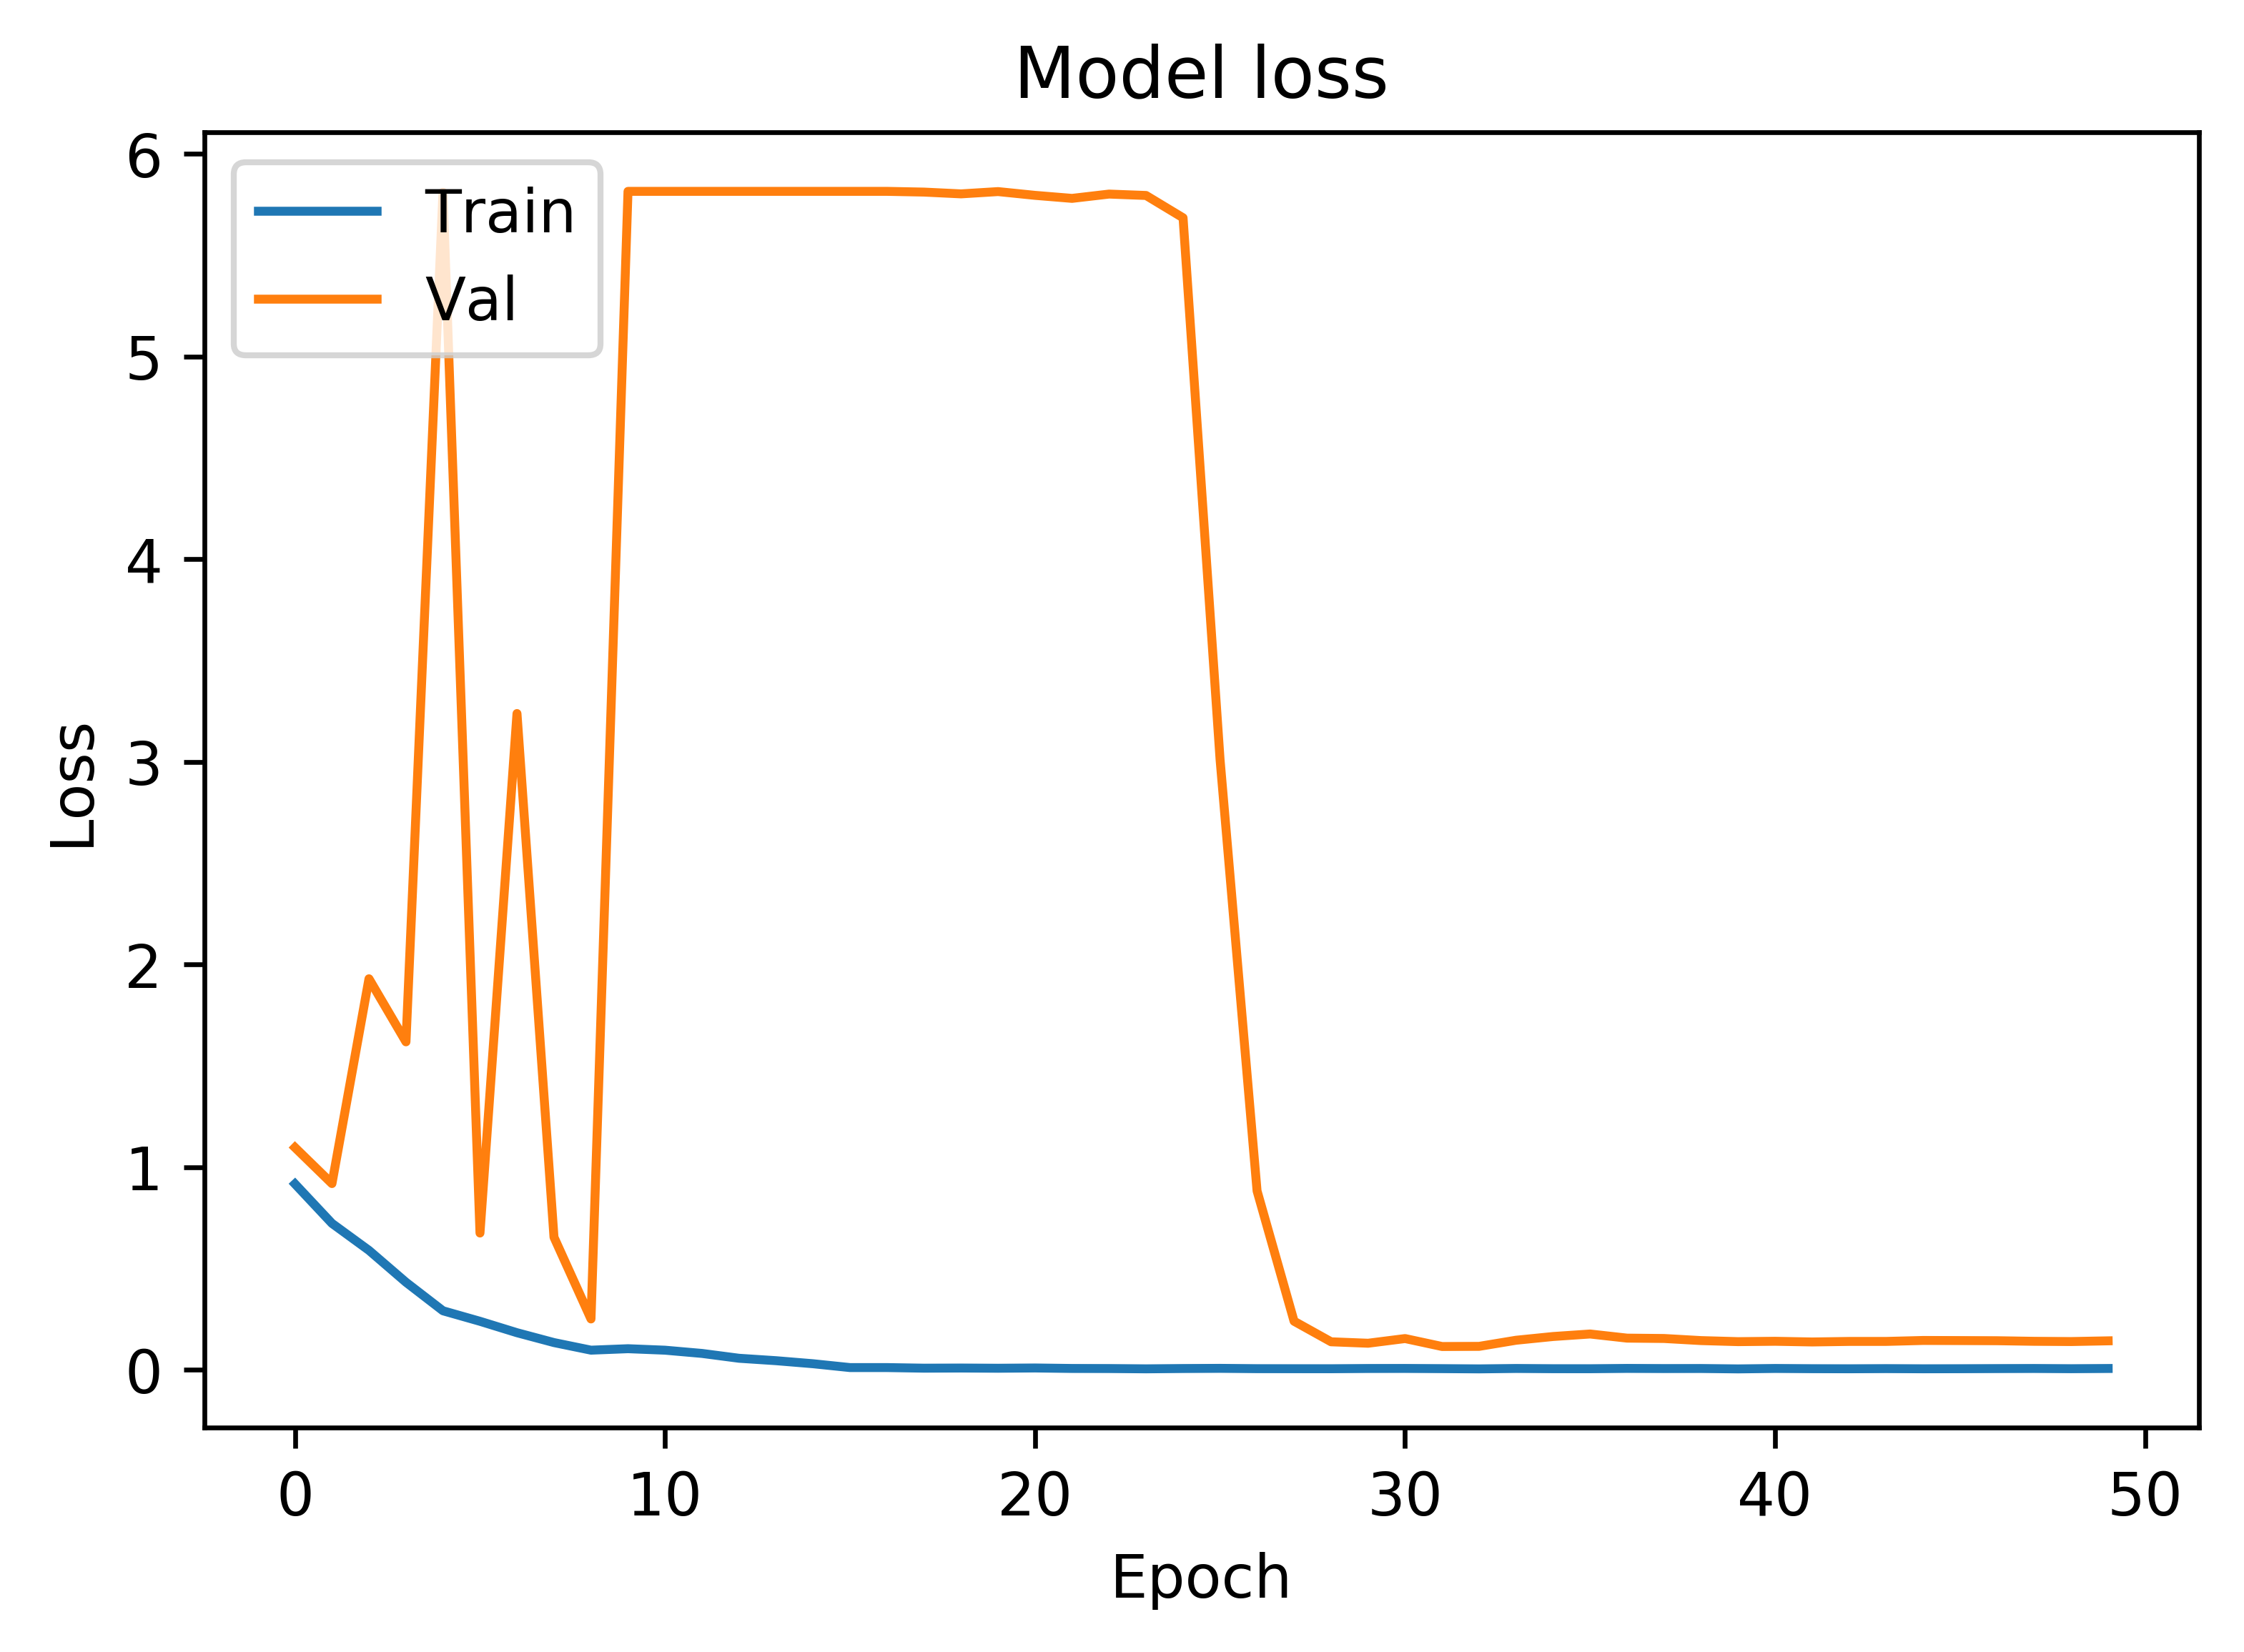

Results from K-fold: 4
acc: 95.69%
1045/1045 [==============================] - 1s 1ms/step
[0.14211573403965877, 0.9569377990430622]
          normal  abnormal
normal       645        23
abnormal      22       355
              precision    recall  f1-score   support

      normal       0.97      0.97      0.97       668
    abnormal       0.94      0.94      0.94       377

   micro avg       0.96      0.96      0.96      1045
   macro avg       0.95      0.95      0.95      1045
weighted avg       0.96      0.96      0.96      1045

fold_5
K-: fold_5
Samples from Training
[5822 5097 4853 3579]
id: 5822
comparison none available indication xxxx-year-old male shortness breath findings heart size mediastinal contours appear within normal limits focal airspace consolidation pleural effusion pneumothorax acute bony abnormalities impression acute cardiopulmonary findings 
id: 5097
comparison none available indication left-sided chest pain findings heart size mildly enlarged tortuous aorta

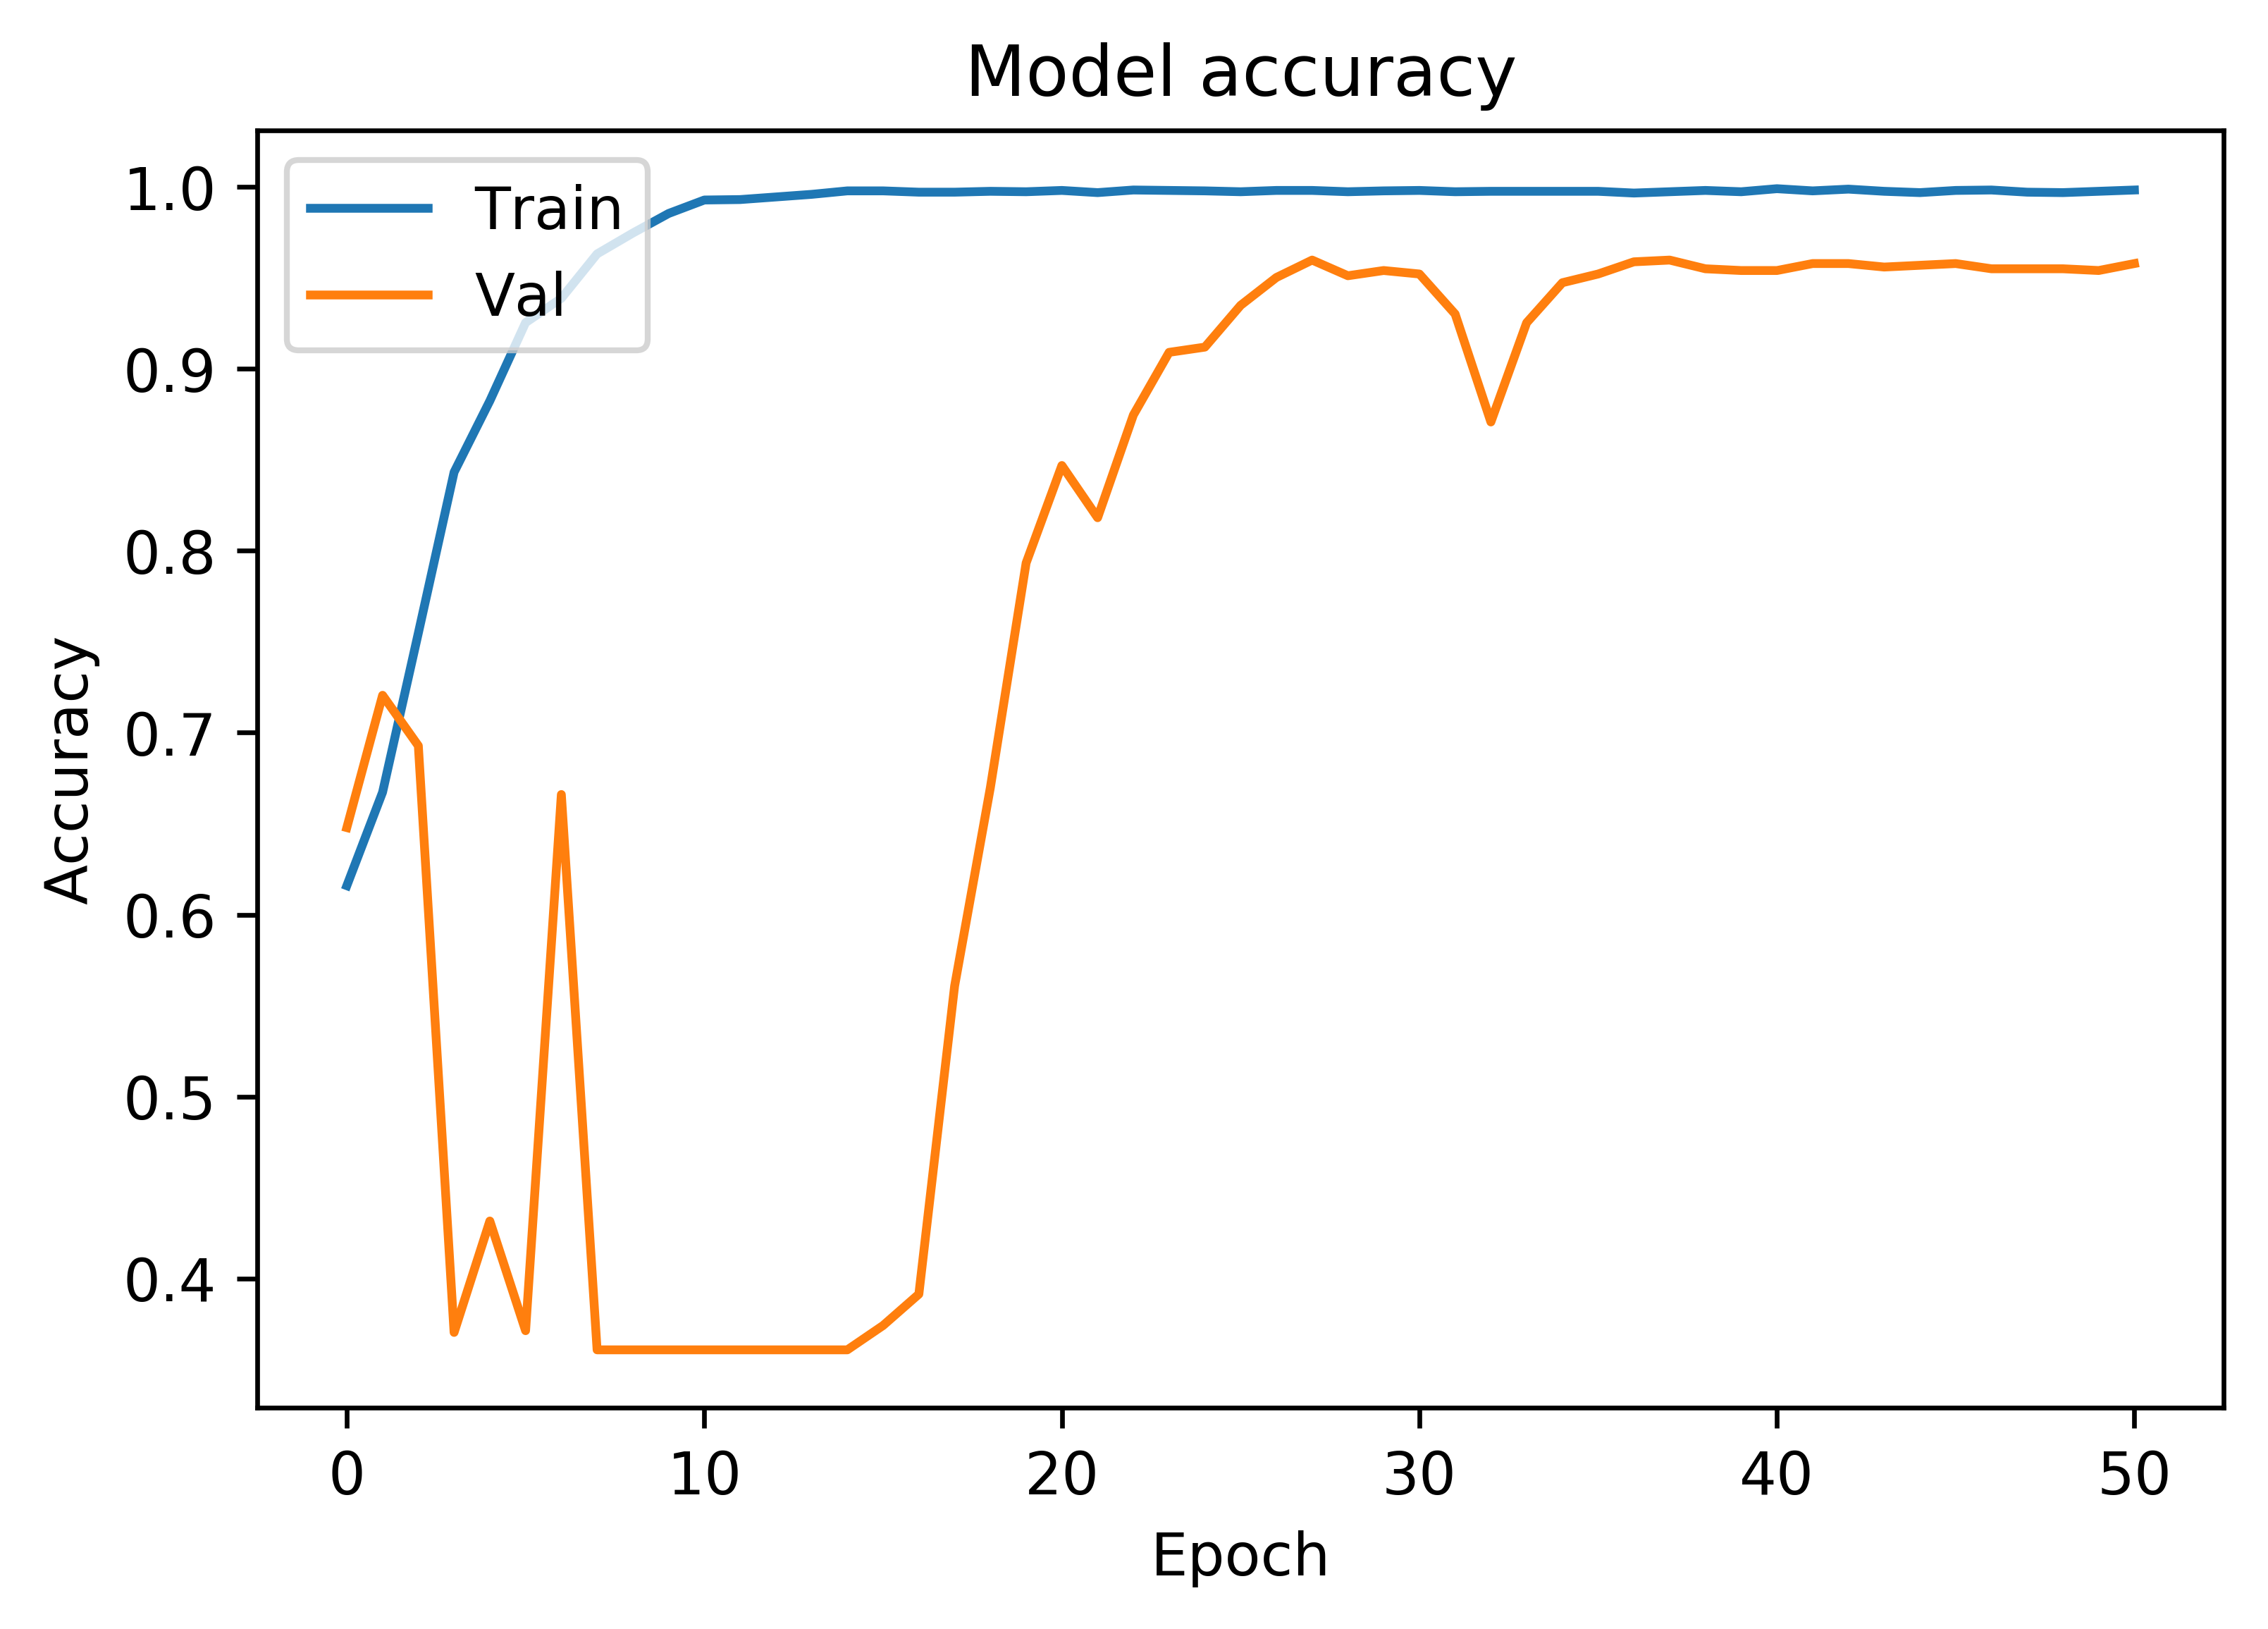

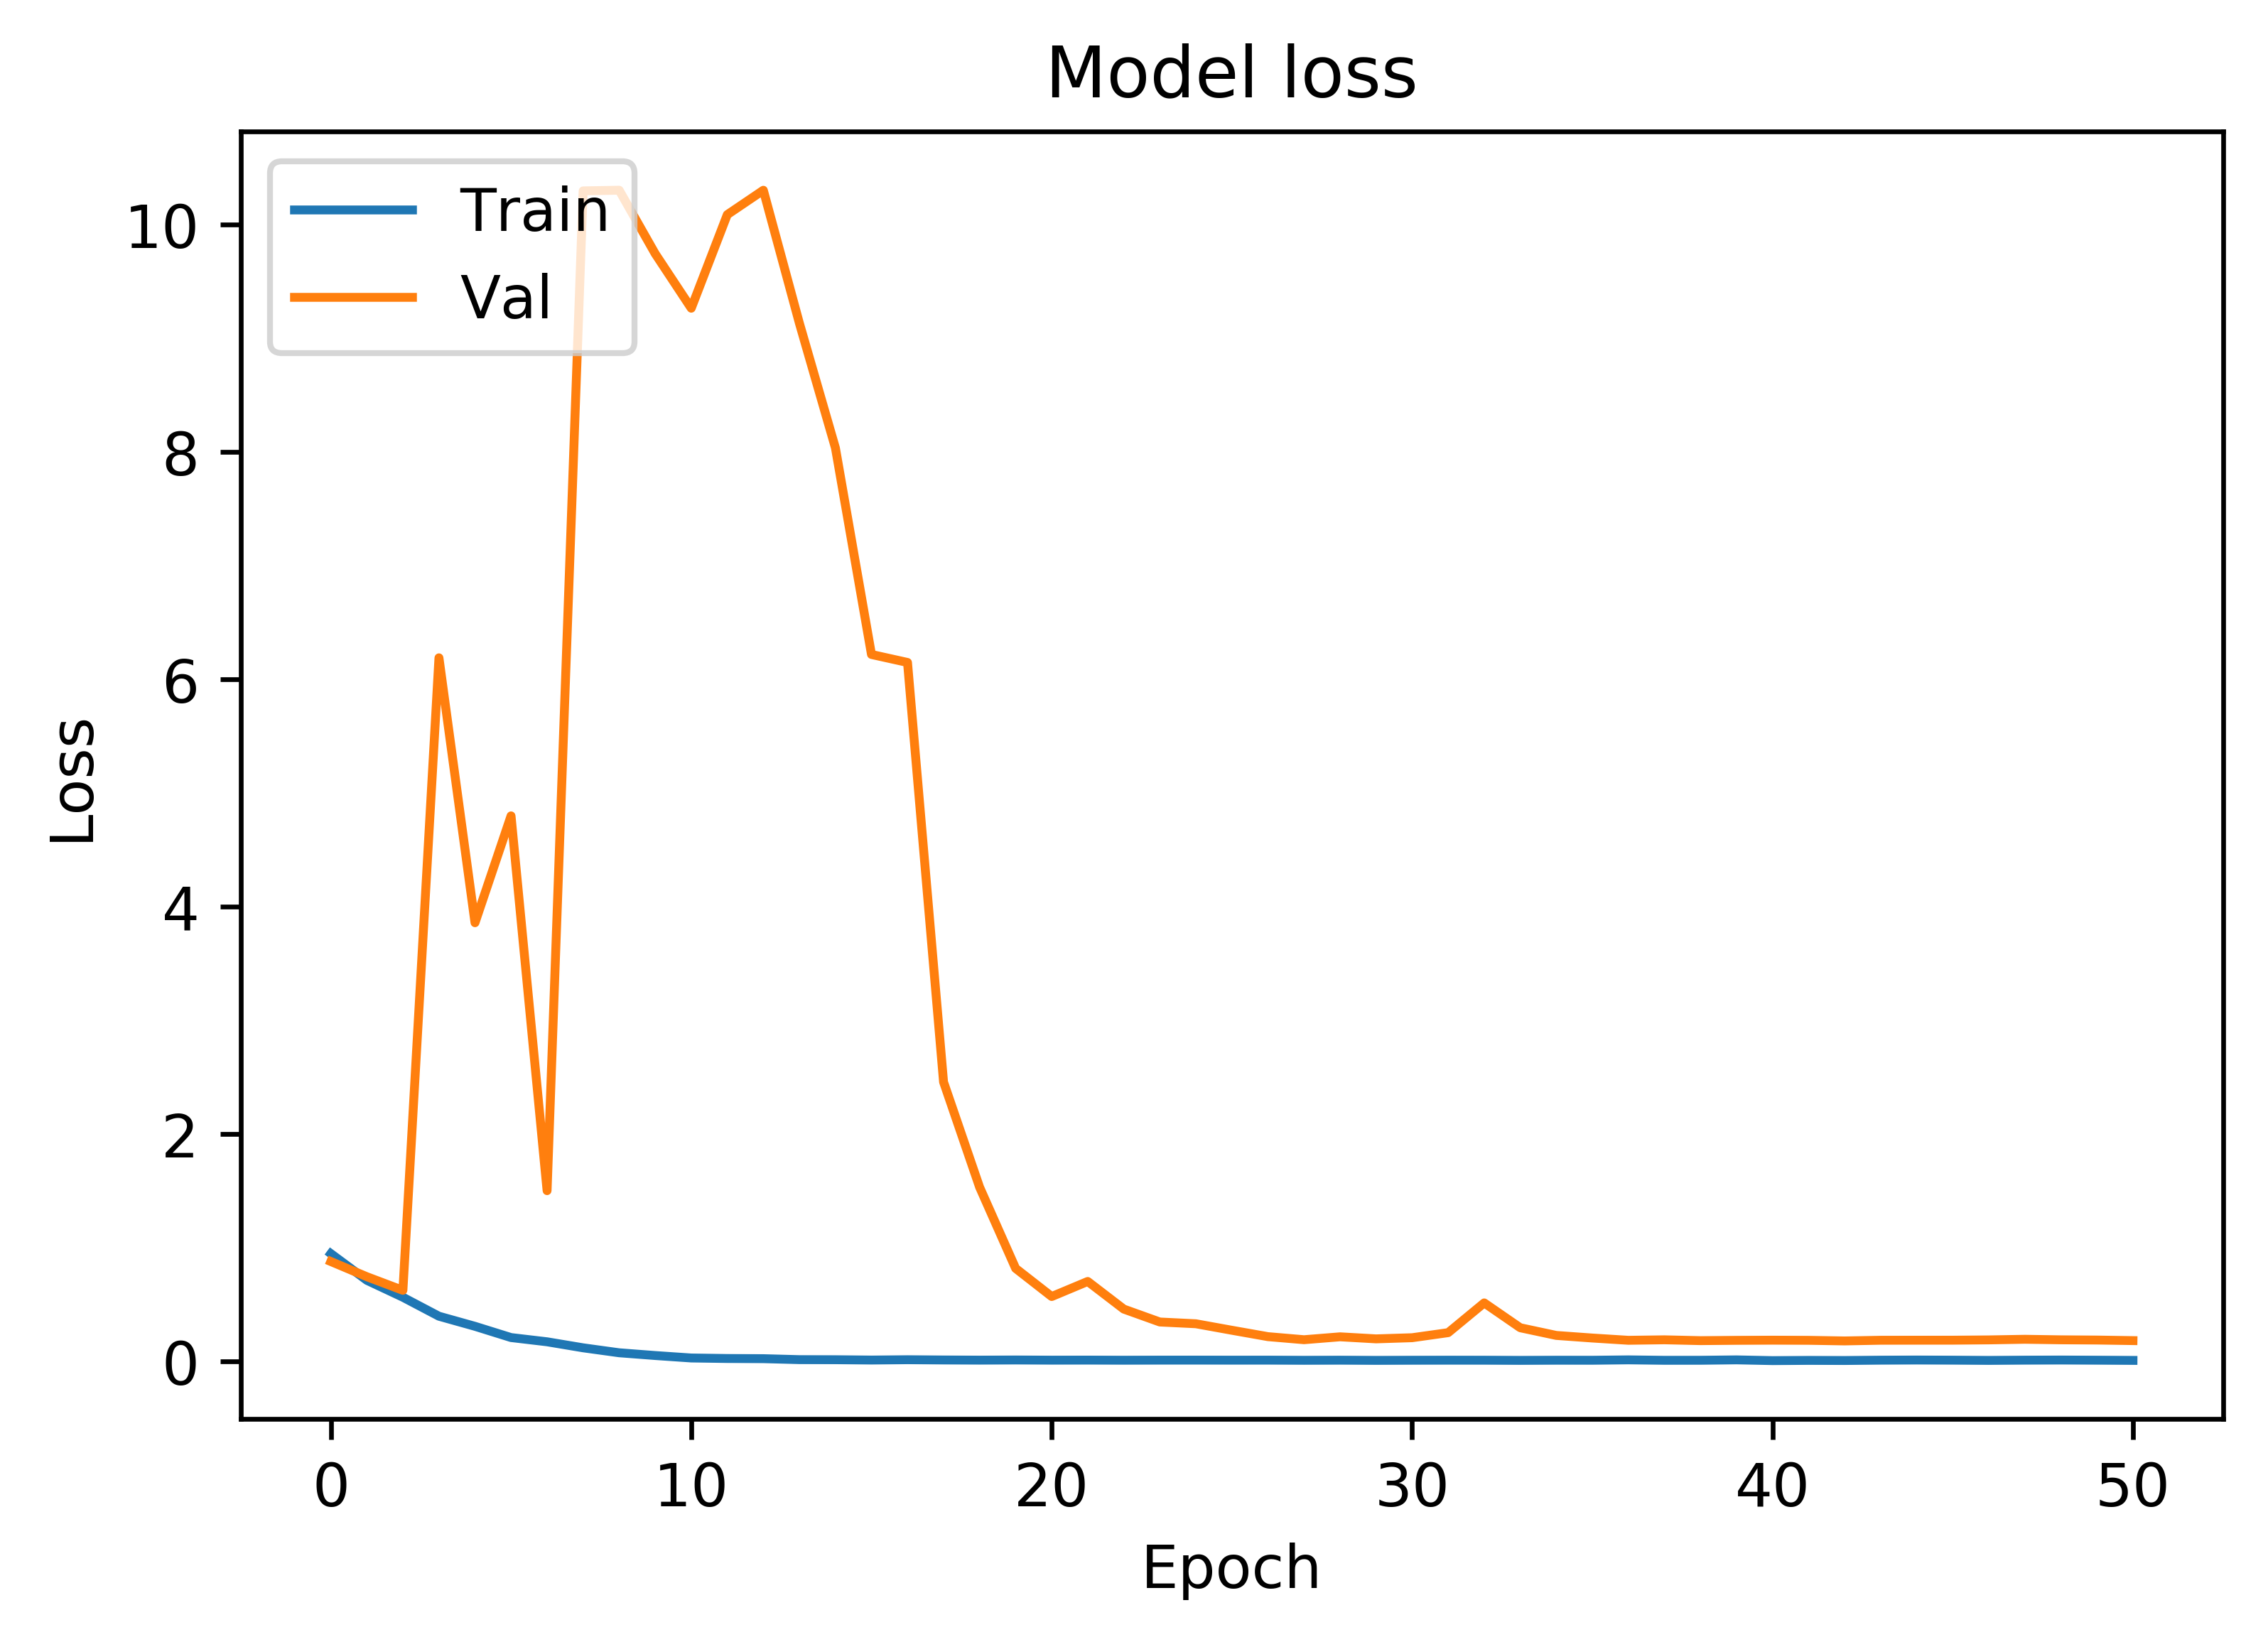

Results from K-fold: 5
acc: 95.79%
1045/1045 [==============================] - 1s 1ms/step
[0.18156882254629614, 0.9578947368421052]
          normal  abnormal
normal       646        22
abnormal      22       355
              precision    recall  f1-score   support

      normal       0.97      0.97      0.97       668
    abnormal       0.94      0.94      0.94       377

   micro avg       0.96      0.96      0.96      1045
   macro avg       0.95      0.95      0.95      1045
weighted avg       0.96      0.96      0.96      1045

Average for kfold accuracy and stdev
95.72% (+/- 0.84%)
Average classification report for all folds
              precision  recall  f1_score  support
class                                             
abnormal          0.934   0.952     0.940    377.6
macro_avg         0.950   0.954     0.952   1045.8
micro_avg         0.956   0.956     0.956   1045.8
normal            0.974   0.962     0.966    668.2
weighted_avg      0.958   0.956     0.956   1045.8


In [20]:
#set K folds to 5
cvscores = []
count = 1
confusion_matrix_list = []
report_list = []

for key, kfold in kfolds.items():
    print(key)
    train = kfold['train']
    val = kfold['valid']
    
    print('K-: {}'.format(key))
            
    print("Samples from Training")
    print_samples(samples=train, text=X_text, tokenizer=tokenizer)
    print("============================")
    
    print("Samples from Validation")
    print_samples(samples=val, text=X_text, tokenizer=tokenizer)
    print("============================")
    
    text_model = Generate_Model(model_type = "text_2d")
    text_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    filepath="unimodal_weights/best_weight_text_2d_only_k-fold_{}.hdf5".format(count)
    checkpoint = MultiGPUCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [reduce_lr, checkpoint, early_stopping]

    history = text_model.fit([X_text[train]], y[train], 
                     epochs=epochs, batch_size=bs, validation_data=([X_text[val]], y[val]),
                             callbacks=callbacks_list)
    plot_model_history(history)
    filepath="unimodal_weights/final_weight_text_2d_only_k-fold_{}.hdf5".format(count)
    text_model.save_weights(filepath)
    scores = text_model.evaluate([X_text[val]], y[val], verbose=0)
    print('Results from K-fold: {}'.format(count))
    print("%s: %.2f%%" % (text_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    y_hat = test_model(text_model, zip(X_text[val], y[val]), image = False, text = True, 
                       class_names=class_names)
    cm = confusion_matrix([np.argmax(t) for t in y[val]], y_hat)
    confusion_matrix_list.append(pd.DataFrame(cm, index=class_names, columns=class_names))
    cr = classification_report([np.argmax(t) for t in y[val]], y_hat, target_names=class_names)
    report_list.append(classification_report_df(cr))
    count += 1
    print('================================================')
print('Average for kfold accuracy and stdev')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("Average classification report for all folds")
print(df_mean(report_list))

### Hold out method on 2/3 training data and 1/3 testing data - Text 2D

In [21]:
reduce_lr_final = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
text_model = Generate_Model(model_type = "text_2d")
text_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
filepath="unimodal_weights/best_weight_text_2d_only_final.hdf5"
checkpoint = MultiGPUCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [reduce_lr_final, checkpoint, early_stopping]

history = text_model.fit([X_text[final_train]], y[final_train], 
                 epochs=epochs, batch_size=bs, validation_split=None, callbacks=callbacks_list)
filepath="unimodal_weights/final_weight_text_2d_only_final.hdf5"
text_model.save_weights(filepath)
print('========================TEST MODEL=======================')
scores = text_model.evaluate([X_text[final_test]], y[final_test], verbose=0)
print("%s: %.2f%%" % (text_model.metrics_names[1], scores[1]*100))
y_hat = test_model(text_model, zip(X_text[final_test], y[final_test]), image = False, text = True, 
                   class_names=class_names)

[INFO] training with 2 GPUs...
Epoch 1/150
5229/5229 [==============================] - 25s 5ms/step - loss: 0.8861 - acc: 0.6416

Epoch 00001: acc improved from -inf to 0.64161, saving model to unimodal_weights/best_weight_text_2d_only_final.hdf5
Epoch 2/150
5229/5229 [==============================] - 10s 2ms/step - loss: 0.6298 - acc: 0.7170

Epoch 00002: acc improved from 0.64161 to 0.71696, saving model to unimodal_weights/best_weight_text_2d_only_final.hdf5
Epoch 3/150
5229/5229 [==============================] - 10s 2ms/step - loss: 0.4369 - acc: 0.8122

Epoch 00003: acc improved from 0.71696 to 0.81220, saving model to unimodal_weights/best_weight_text_2d_only_final.hdf5
Epoch 4/150
5229/5229 [==============================] - 10s 2ms/step - loss: 0.3023 - acc: 0.8818

Epoch 00004: acc improved from 0.81220 to 0.88181, saving model to unimodal_weights/best_weight_text_2d_only_final.hdf5
Epoch 5/150
5229/5229 [==============================] - 10s 2ms/step - loss: 0.2111 - acc: 